## In this Notebook, I have implemented Light GCN Model for Recommendation System from scratch using Pytorch.


* Light GCN was originally Developed By Microsoft and was released in Jul'2020. It is the SOTA Algorithm for Recommendation System as of now.
* Link to the original paper -> https://paperswithcode.com/paper/lightgcn-simplifying-and-powering-graph/review/
* There is also a Github Link to Light GCN implementation using Tensorflow -> https://github.com/microsoft/recommenders/tree/efaa3d7742183dee0846877e2dc64977098e1977
* I have taken help from the above Repository and tried to recreate LightGCN in pytorch.
* In the 2nd part of the notebook, I have also compared my result with the direct result from Original Tensorflow code. 

### Please do upvote the notebook if you liked the content. It will motivate me. Thanks !!

In [7]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # 禁用所有 CUDA 设备

In [8]:
import torch
torch.__version__
import os

# 设置环境变量以便更好地调试
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [9]:
torch.cuda.is_available()

True

In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [11]:
columns_name=['user_id','item_id','rating','timestamp']
# df = pd.read_csv("./ml-100k/u.data",sep='\t',names=columns_name)
df=pd.read_csv('./ml-latest-small/ratings.csv')
df.columns=columns_name
print(len(df))
df

100836


,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [12]:
# df[df['user_id_2']==442]

In [13]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

#### Label Encoding the User and Item IDs

In [14]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
df.loc[:, 'user_id_2'] = le_user.fit_transform(df['user_id'].values)
df.loc[:, 'item_id_2'] = le_item.fit_transform(df['item_id'].values)

In [15]:
df

,user_id,item_id,rating,timestamp,user_id_2,item_id_2
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,9416
100832,610,168248,5.0,1493850091,609,9443
100833,610,168250,5.0,1494273047,609,9444
100834,610,168252,5.0,1493846352,609,9445


In [16]:
# df = df[df['rating']>=2.5]
print(len(df))

100836


In [17]:
df.user_id_2.nunique()

610

In [18]:
df.item_id_2.nunique()

9724

In [19]:
df

,user_id,item_id,rating,timestamp,user_id_2,item_id_2
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,9416
100832,610,168248,5.0,1493850091,609,9443
100833,610,168250,5.0,1494273047,609,9444
100834,610,168252,5.0,1493846352,609,9445


In [20]:
df.user_id.nunique()

610

In [21]:
# train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
# train = pd.DataFrame(train, columns = df.columns)
# test = pd.DataFrame(test, columns = df.columns)

In [22]:
# train_user_ids = train['user_id'].unique()
# train_item_ids = train['item_id'].unique()

# print(len(train_user_ids), len(train_item_ids))

# test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
# print(len(test))

In [25]:
import pandas as pd
item_sim=pd.read_csv('dataset_movie/cosine_similarity_after_fit_transform.csv',index_col=0)
item_sim.index = item_sim.index.astype(int)
item_sim.columns = item_sim.columns.astype(int)
item_sim

,0,9,10,13,14,15,16,17,18,19,...,9273,9288,9295,9302,9305,9310,9311,9313,9314,9327
0,1.000000,0.000000,0.095346,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,...,0.000000,0.095346,0.000000,0.000000,0.105409,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,1.000000,0.000000,0.000000,0.210819,0.000000,0.000000,0.000000,0.100000,0.100000,...,0.095346,0.190693,0.200000,0.000000,0.105409,0.210819,0.141421,0.210819,0.200000,0.100000
10,0.095346,0.000000,1.000000,0.201008,0.000000,0.100504,0.201008,0.095346,0.095346,0.095346,...,0.090909,0.090909,0.000000,0.000000,0.100504,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.201008,1.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,...,0.100504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.210819,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.105409,0.105409,...,0.000000,0.201008,0.210819,0.000000,0.111111,0.111111,0.000000,0.222222,0.105409,0.105409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9310,0.000000,0.210819,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.105409,...,0.100504,0.100504,0.105409,0.000000,0.111111,1.000000,0.149071,0.111111,0.210819,0.000000
9311,0.000000,0.141421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.134840,0.000000,0.000000,0.000000,0.000000,0.149071,1.000000,0.000000,0.141421,0.000000
9313,0.000000,0.210819,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,0.210819,0.105409,...,0.000000,0.201008,0.210819,0.000000,0.111111,0.111111,0.000000,1.000000,0.105409,0.105409
9314,0.000000,0.200000,0.000000,0.000000,0.105409,0.000000,0.000000,0.000000,0.000000,0.100000,...,0.190693,0.095346,0.200000,0.111803,0.105409,0.210819,0.141421,0.105409,1.000000,0.000000


### latent_dim is the length of the user/item embedding. 
### n_layers is the number of times we want to propagate our initial user/item embedding through the graph 

In [26]:
latent_dim = 64
n_layers = 3

In [27]:
def convert_to_sparse_tensor(dok_mtrx):
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## **Metrics**
### Below Function gets the 4 different metrics out of Test Data -> Recall@K, Precision@K, NDCG@K, MAP@K where K is the top K items we would like to recommend to User. 

In [28]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_2'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_2'], train_data['item_id_2']] = 1.0 #交互矩阵

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense#去掉了train edge

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_2')['item_id_2'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_2',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df. item_id_2, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_2']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list( item_id, top_rlvnt_itm):
        return [1 if x in set( item_id) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_2'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg( item_id, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len( item_id),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map( item_id, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len( item_id)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_2'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_2'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

##  **LightGCN Model**
### **get_A_tilda** function is used to get A_tilda which will be multiplied with initial user/item embedding (E0) to create embedding at different layers (n_layers = 3) in **propagate_through_layers** function
### **forward** function is used to look up for initial(E0) and final embedding of a user/item

In [29]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda(n_users=n_users)

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self,n_users):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_2'], self.data['item_id_2']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        # Below Code is toconvert the dok_matrix to sparse tensor.
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.n_users, self.n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [self.n_users, self.n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0,final_user_Embed

### **BPR Loss**

In [30]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

In [31]:
def bpr_loss_with_quantile(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0, sample_rating,quantile_tensor):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    score_diff = pos_scores - neg_scores
    
    # Quantile adjustment
    weight = sample_rating - quantile_tensor
    weighted_loss = weight * torch.nn.functional.softplus(-score_diff)
    quantile_loss = torch.mean(weighted_loss)
    
        
    return quantile_loss, reg_loss

In [32]:
def movie_reg_loss(item_sim, batch_item_embeddings, all_item_indices, device='cpu', loss_mode='basic', margin=1.5, beta=1.0):
    """
    Compute movie regularization loss with support for multiple modes.

    Args:
        item_sim (pd.DataFrame): Precomputed similarity matrix (values in [0, 1]).
        batch_item_embeddings (torch.Tensor): Batch of item embeddings.
        all_item_indices (list): List of global item indices for the batch.
        device (str): Device to run the computation on ('cpu' or 'cuda').
        loss_mode (str): Loss mode ('basic', 'cosine', 'margin', 'dissimilar-separation').
        margin (float): Margin for dissimilar items.
        alpha (float): Weight for dissimilarity penalty.

    Returns:
        torch.Tensor: Regularization loss value.
    """

    # Move batch_item_embeddings to device
    batch_item_embeddings = batch_item_embeddings.to(device)

    # Convert similarity_matrix to tensor and move to device
    similarity_matrix = torch.tensor(item_sim.values, dtype=torch.float32).to(device)

    # Get column names of similarity_matrix
    colnames = list(item_sim.columns)

    # Find batch_indices matching global indices
    batch_indices = []
    for idx in all_item_indices:
        if idx in colnames:
            batch_indices.append(colnames.index(idx))

    # If no matching indices, return 0 loss
    if not batch_indices:
        return torch.tensor(0.0, device=device)

    batch_indices = torch.tensor(batch_indices, dtype=torch.long).to(device)

    # Get the similarity matrix for the batch
    batch_similarity_matrix = similarity_matrix[batch_indices][:, batch_indices]

    # Get upper triangular indices (excluding diagonal)
    triu_indices = torch.triu_indices(row=batch_similarity_matrix.size(0), col=batch_similarity_matrix.size(1), offset=1)

    # Extract similarity values from the upper triangular part of the matrix
    similarity_values = batch_similarity_matrix[triu_indices[0], triu_indices[1]]

    # Extract embeddings for the pairs of items
    embeddings_i = batch_item_embeddings[triu_indices[0]]
    embeddings_j = batch_item_embeddings[triu_indices[1]]

    if loss_mode == 'basic':
        # Basic similarity loss: similarity_weight * ||h_i - h_j||^2
        diff_norms = torch.norm(embeddings_i - embeddings_j, dim=1, p=2)
        basic_loss = torch.sum(similarity_values * (diff_norms ** 2))
        return basic_loss

    elif loss_mode == 'cosine':
        # Cosine similarity loss: similarity_weight * (1 - cosine_similarity)
        cosine_sim = torch.nn.functional.cosine_similarity(embeddings_i, embeddings_j, dim=1)
        cosine_loss = torch.sum(similarity_values * (1 - cosine_sim))
        return cosine_loss

    elif loss_mode == 'margin':
        # Margin-based similarity loss: (1 - similarity_weight) * max(0, margin - ||h_i - h_j||)^2
        diff_norms = torch.norm(embeddings_i - embeddings_j, dim=1, p=2)
        # print(diff_norms)
        margin_loss = torch.sum((1 - similarity_values) * torch.relu(margin - diff_norms).pow(2))
        return margin_loss
    
    elif loss_mode =='mixed-margin':
        # Margin-based similarity loss: (1 - similarity_weight) * max(0, margin - ||h_i - h_j||)^2
        diff_norms = torch.norm(embeddings_i - embeddings_j, dim=1, p=2)

        similar_loss=torch.sum(similarity_values * diff_norms)
        dissimilar_mask = (similarity_values == 0).float()
        dissimilar_loss = torch.sum(dissimilar_mask * torch.relu(margin - diff_norms).pow(2))
        total_loss = similar_loss + beta * dissimilar_loss
        return total_loss

    # elif loss_mode == 'dissimilar-separation':
    #     # Weakly similar items loss
    #     diff_norms = torch.norm(embeddings_i - embeddings_j, dim=1, p=2)
    #     similar_loss = torch.sum(similarity_values * diff_norms.pow(2))

    #     # Dissimilar items loss
    #     dissimilar_mask = (similarity_values == 0).float()
    #     dissimilar_loss = torch.sum(dissimilar_mask * torch.relu(margin - diff_norms).pow(2))

    #     # Combined loss
    #     total_loss = similar_loss + alpha * dissimilar_loss
    #     return total_loss

    else:
        raise ValueError(f"Invalid loss_mode '{loss_mode}'. Choose 'basic', 'cosine', 'margin', or 'mixed-margin'.")


In [35]:
intersection_sim_matrix=pd.read_csv('./dataset_movie/Jaccard_sim_matrix.csv',index_col=0)

In [36]:
intersection_sim_matrix

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.024383,0.073590,0.201021,0.128669,0.122266,0.138455,0.143648,0.048400,0.033292,...,0.071860,0.152564,0.235176,0.078784,0.154571,0.165157,0.288062,0.309738,0.097140,0.125545
1,0.024383,0.000000,0.000000,0.012635,0.027995,0.020959,0.045186,0.027086,0.000000,0.078471,...,0.203251,0.015982,0.012094,0.000000,0.000000,0.027806,0.013579,0.038650,0.030528,0.092633
2,0.073590,0.000000,0.000000,0.010895,0.024140,0.027110,0.000000,0.023357,0.000000,0.000000,...,0.031867,0.027563,0.046930,0.000000,0.010771,0.038364,0.046839,0.049993,0.000000,0.031064
3,0.201021,0.012635,0.010895,0.000000,0.123091,0.103675,0.121415,0.089324,0.010032,0.051755,...,0.101556,0.134690,0.307987,0.061237,0.073231,0.195617,0.144295,0.174664,0.033558,0.099941
4,0.128669,0.027995,0.024140,0.123091,0.000000,0.306275,0.110051,0.417810,0.000000,0.038224,...,0.060003,0.402224,0.122732,0.286436,0.141973,0.103840,0.165365,0.156890,0.247841,0.058492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.165157,0.027806,0.038364,0.195617,0.103840,0.108163,0.196755,0.100471,0.066233,0.101241,...,0.160915,0.118564,0.301346,0.068880,0.147058,0.000000,0.164249,0.263873,0.073850,0.185081
606,0.288062,0.013579,0.046839,0.144295,0.165365,0.148565,0.166079,0.170667,0.010782,0.030902,...,0.080041,0.182520,0.226228,0.138942,0.113139,0.164249,0.000000,0.294264,0.144265,0.123624
607,0.309738,0.038650,0.049993,0.174664,0.156890,0.217299,0.295438,0.202400,0.092065,0.079159,...,0.131166,0.211978,0.248523,0.183855,0.179678,0.263873,0.294264,0.000000,0.131168,0.284568
608,0.097140,0.030528,0.000000,0.033558,0.247841,0.204107,0.080007,0.407661,0.000000,0.027789,...,0.032717,0.325432,0.069596,0.230159,0.099528,0.073850,0.144265,0.131168,0.000000,0.045561


In [37]:
def user_reg_loss(user_sim,user_embeddings,device='cuda'):
    # 确保 user_embeddings 在 GPU上
    user_embeddings = user_embeddings.to(device)

    # 将 similarity_matrix 转换为 tensor 并移到 GPU
    user_sim = torch.tensor(user_sim.values, dtype=torch.float32).to(device)

    # 获取上三角索引（不包括对角线）
    triu_indices = torch.triu_indices(row=user_sim.size(0), col=user_sim.size(1), offset=1)

    # 使用索引从 user_sim 中提取上三角部分的相似度值
    similarity_values = user_sim[triu_indices[0], triu_indices[1]]

    # 使用索引从 user_embeddings 中提取对应的 embeddings
    embeddings_i = user_embeddings[triu_indices[0]]
    embeddings_j = user_embeddings[triu_indices[1]]

    # 计算 embeddings 差的 L2 范数
    diff_norms = torch.norm(embeddings_i - embeddings_j, dim=1, p=2)

    # 计算正则化损失：相似度乘以范数的平方
    regularization_loss = torch.sum(similarity_values * (diff_norms ** 2))

    # print(f"Regularization Loss: {regularization_loss.item()}")
    return regularization_loss

### Data Loader - Samples users and for each user it sample 1 postive item - which User interacted with in Training Data and 1 negative item - with which User have not interacted.

In [38]:
import pandas as pd
import random

def data_loader(data, batch_size, n_usr, n_itm):
    # 获取用户与物品交互信息的 DataFrame
    interected_items_df = data.groupby('user_id_2')['item_id_2'].apply(list).reset_index()

    # 函数：从未交互的物品中采样负样本
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # 生成用户索引列表
    indices = [x for x in range(n_usr)]

    # 随机采样用户
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    # 创建包含采样用户的 DataFrame
    users_df = pd.DataFrame(users, columns=['users'])

    # 只保留采样用户的交互记录
    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_id_2', right_on='users')

    # 处理可能的 NaN 值，将其替换为空列表
    interected_items_df['item_id_2'] = interected_items_df['item_id_2'].apply(lambda x: x if isinstance(x, list) else [])

    # 为每个用户采样一个正样本（已交互的物品）
    pos_items = interected_items_df['item_id_2'].apply(lambda x: random.choice(x) if x else -1).values

    # 为每个用户采样一个负样本（未交互的物品）
    neg_items = interected_items_df['item_id_2'].apply(lambda x: sample_neg(x) if x else -1).values

    # 删除无效的样本（-1）
    valid_indices = pos_items != -1
    users = [user for i, user in enumerate(users) if valid_indices[i]]
    pos_items = pos_items[valid_indices]
    neg_items = neg_items[valid_indices]

    return list(users), list(pos_items), list(neg_items)



In [39]:
import pandas as pd
import random
import torch

def data_loader_with_quantile(data, batch_size, n_usr, n_itm, quantile=0.25):
    # 获取用户与物品交互信息的 DataFrame
    interected_items_df = data.groupby('user_id_2')['item_id_2'].apply(list).reset_index()

    # 函数：从未交互的物品中采样负样本
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # 生成用户索引列表
    indices = [x for x in range(n_usr)]

    # 随机采样用户
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    # 创建包含采样用户的 DataFrame
    users_df = pd.DataFrame(users, columns=['users'])

    # 只保留采样用户的交互记录
    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_id_2', right_on='users')

    # 处理可能的 NaN 值，将其替换为空列表
    interected_items_df['item_id_2'] = interected_items_df['item_id_2'].apply(lambda x: x if isinstance(x, list) else [])

    # 为每个用户采样一个正样本（已交互的物品）
    pos_items = interected_items_df['item_id_2'].apply(lambda x: random.choice(x) if x else -1).values

    # 为每个用户采样一个负样本（未交互的物品）
    neg_items = interected_items_df['item_id_2'].apply(lambda x: sample_neg(x) if x else -1).values

    # 删除无效的样本（-1）
    valid_indices = pos_items != -1
    users = [user for i, user in enumerate(users) if valid_indices[i]]
    pos_items = pos_items[valid_indices]
    neg_items = neg_items[valid_indices]

    # 创建包含用户和正样本物品的 DataFrame
    sampled_items_df = pd.DataFrame({
        'user_id_2': users,
        'item_id_2': pos_items
    })

    # 合并评分数据，获取采样正样本的评分
    ratings_df = data[['user_id_2', 'item_id_2', 'rating']]
    sampled_ratings_df = pd.merge(sampled_items_df, ratings_df, on=['user_id_2', 'item_id_2'], how='left')

    # 填充 NaN 值为 0
    # sampled_ratings_df['rating'].fillna(0.0, inplace=True)
    sampled_ratings_df['rating'] = sampled_ratings_df['rating'].fillna(0.0)

    # 转换采样评分为张量
    sampled_ratings_tensor = torch.tensor(sampled_ratings_df['rating'].values, dtype=torch.float32)

    # 计算指定分位数的评分
    user_ratings = data.groupby('user_id_2')['rating']
    quantile_series = user_ratings.quantile(quantile)

    # 将分位数数据整理为 DataFrame
    quantile_df = quantile_series.reset_index().rename(columns={'user_id_2': 'users', 'rating': 'quantile_rating'})

    # 计算默认分位数值为 `quantile_df` 的均值
    default_quantile = quantile_df['quantile_rating'].mean() if not quantile_df['quantile_rating'].isna().all() else 0.0

    # 合并分位数信息到用户数据中
    users_quantiles = pd.DataFrame(users, columns=['users']).merge(quantile_df, on='users', how='left')

    # 填充 NaN 值为均值分位数
    # users_quantiles['quantile_rating'].fillna(default_quantile, inplace=True)
    users_quantiles['quantile_rating'] = users_quantiles['quantile_rating'].fillna(default_quantile)


    # 转换分位数为张量
    quantile_tensor = torch.tensor(users_quantiles['quantile_rating'].values, dtype=torch.float32)

    return list(users), list(pos_items), list(neg_items), quantile_tensor, sampled_ratings_tensor


In [40]:
EPOCHS = 100
BATCH_SIZE = 1024 
DECAY = 1e-4
K = 20

### **Training Loop**

注意 要从user_id_idx 做！！！ 不要乱改

删去了 df[rating]>3.5的操作 因为会导致user 以及 item稀疏 不好处理


这个是baseline没有正则化Fold 1 Best Recall: 0.22535753504375303, Best Precision: 0.20811475409836067

用户正则化1e-4和-5都 太大了 recall只在0.11左右

epoch数量不够 调整为40

尝试1e-8的值 update在了overleaf
尝试1e-9

实现了item 相似度！！！实验1e-7 -6 -5都不行 比最基本的baseline23%还要差 只有1e-8 1e-9可以 但是呢 需要的epoch更多了 先从30改为了40 现在想从40改成80 智能训练

woc!!!24.6%的recall 果然增大训练epoch有效果！！

optuna找超参数使用cv太慢了 先不使用cv找超参数

In [41]:
# import time
# import numpy as np
# from tqdm import tqdm
# import torch
# import optuna
# from sklearn.model_selection import train_test_split
# from optuna.trial import create_trial

# # 定义训练和评估函数
# def train_and_evaluate(lightGCN, train, test, lambda_1, lambda_2, n_users, n_items):
#     optimizer = torch.optim.Adam(lightGCN.parameters(), lr=0.005)
#     best_recall = 0
#     best_precision = 0
#     epochs_no_improve = 0
#     patience = 5  # 提前停止的容忍度

#     for epoch in range(EPOCHS):
#         lightGCN.train()
#         n_batch = len(train) // BATCH_SIZE
#         final_loss_list = []

#         for batch_idx in range(n_batch):
#             optimizer.zero_grad()
#             users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)
#             users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, _ = lightGCN.forward(users, pos_items, neg_items)
#             mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
#             reg_loss = DECAY * reg_loss

#             final_loss = mf_loss + reg_loss + lambda_1 * movie_reg_loss(item_sim, pos_emb, pos_items) + lambda_2 * user_reg_loss(intersection_sim_matrix, users_emb)
#             final_loss.backward()
#             optimizer.step()
#             final_loss_list.append(final_loss.item())

#         # 评估模型性能
#         lightGCN.eval()
#         with torch.no_grad():
#             final_user_Embed, final_item_Embed, _, _ = lightGCN.propagate_through_layers()
#             recall, precision, _, _ = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)

#         # 提前停止逻辑
#         if recall > best_recall:
#             best_recall = recall
#             best_precision = precision
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {np.mean(final_loss_list):.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

#         if epochs_no_improve >= patience:
#             print("Early stopping triggered!")
#             break

#     return best_recall, best_precision


# # 定义 Optuna 目标函数
# def objective(trial):
#     # 随机划分训练集和测试集
#     train, test = train_test_split(df, test_size=0.2, random_state=42)
#     n_users = df['user_id'].nunique()
#     n_items = df['item_id'].nunique()

#     # Optuna 搜索的超参数范围
#     lambda_1 = trial.suggest_float("lambda_1", 1e-12, 1e-8, log=True)
#     lambda_2 = trial.suggest_float("lambda_2", 1e-12, 1e-8, log=True)

#     # 初始化模型
#     lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
#     best_recall, best_precision = train_and_evaluate(lightGCN, train, test, lambda_1, lambda_2, n_users, n_items)

#     print(f"Trial {trial.number} - Lambda_1: {lambda_1:.2e}, Lambda_2: {lambda_2:.2e}, Recall: {best_recall:.4f}, Precision: {best_precision:.4f}")
#     return best_recall  # 以 Recall 作为优化目标


# # Optuna 超参数优化
# study = optuna.create_study(direction="maximize")
# history_trials = [
#     {"params": {"lambda_1": 6.66e-12, "lambda_2": 1.94e-09}, "value": 0.2369},
#     {"params": {"lambda_1": 3.77e-10, "lambda_2": 6.01e-10}, "value": 0.2425},
#     {"params": {"lambda_1": 6.04e-10, "lambda_2": 1.34e-12}, "value": 0.2460},
# ]
# # 将历史结果添加到 Optuna Study
# for trial_data in history_trials:
#     trial = create_trial(
#         params=trial_data["params"],
#         distributions={
#             "lambda_1": optuna.distributions.FloatDistribution(1e-12, 1e-8, log=True),
#             "lambda_2": optuna.distributions.FloatDistribution(1e-12, 1e-8, log=True),
#         },
#         value=trial_data["value"],
#     )
#     study.add_trial(trial)

# study.optimize(objective, n_trials=30)

# # 输出最佳结果
# print("Best Trial:")
# print(f"Params: {study.best_trial.params}")
# print(f"Value: {study.best_trial.value:.4f}")


Best Trial:
Params: {'lambda_1': 1.0894899480252902e-09, 'lambda_2': 8.371198855714277e-11}
Value: 0.2527

In [42]:
import time
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch

# Helper function to evaluate metrics
def evaluate_model(lightGCN, train, test, n_users, n_items, K):
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, _, _ = lightGCN.propagate_through_layers()
        recall, precision, ndcg, _map = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)
    return recall, precision, ndcg, _map

# Helper function to log results
def log_epoch_results(epoch, train_time, eval_time, avg_loss, mf_loss, reg_loss, recall, precision, ndcg, _map):
    print(f"Epoch: {epoch}, Train Time: {train_time:.2f}s, Eval Time: {eval_time:.2f}s, "
          f"Loss: {avg_loss:.4f}, MF Loss: {mf_loss:.4f}, Reg Loss: {reg_loss:.4f}, "
          f"Recall: {recall:.4f}, Precision: {precision:.4f}, NDCG: {ndcg:.4f}, MAP: {_map:.4f}")

# Initialize K-Fold Cross Validation
fold_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid search
for lambda_1 in [0]:
    for lambda_2 in [0]:
        for quantile in [0.1,0.2,0.3,0.4,0.5]:
            print(f"\nStarting training with Lambda 1: {lambda_1}, Lambda 2: {lambda_2}, Quantile: {quantile}")
            fold_results.clear()

            for fold, (train_index, test_index) in enumerate(kf.split(df)):
                print(f"\nFold {fold + 1} started")
                train, test = df.iloc[train_index], df.iloc[test_index]
                n_users, n_items = df['user_id'].nunique(), df['item_id'].nunique()

                lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
                optimizer = torch.optim.Adam(lightGCN.parameters(), lr=0.005)

                best_recall, best_precision, best_ndcg = 0, 0, -1
                epochs_no_improve, patience = 0, 5

                for epoch in tqdm(range(EPOCHS), desc=f"Fold {fold + 1} Training"):
                    n_batch = len(train) // BATCH_SIZE
                    final_loss_list, mf_loss_list, reg_loss_list = [], [], []
                    
                    # Training loop
                    train_start_time = time.time()
                    lightGCN.train()
                    for _ in range(n_batch):
                        optimizer.zero_grad()
                        # users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items) #这里不使用quantile
                        users, pos_items, neg_items,quantile_tensor,sample_rating = data_loader_with_quantile(train, BATCH_SIZE, n_users, n_items,quantile=quantile) #这里使用quantile做weighted

                        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, _ = lightGCN.forward(users, pos_items, neg_items)
                        # mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0) #这是原始的bpr_loss
                        mf_loss, reg_loss = bpr_loss_with_quantile(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0,sample_rating,quantile_tensor) #这是加入quantile的bpr_loss
                        reg_loss *= DECAY
                        final_loss = (mf_loss + reg_loss 
                                    #   +
                                    #   lambda_1 * movie_reg_loss(item_sim, pos_emb, pos_items) +
                                    #   lambda_2 * user_reg_loss(intersection_sim_matrix, users_emb)
                                    )

                        final_loss.backward()
                        optimizer.step()

                        final_loss_list.append(final_loss.item())
                        mf_loss_list.append(mf_loss.item())
                        reg_loss_list.append(reg_loss.item())
                    train_time = time.time() - train_start_time

                    # Evaluation
                    eval_start_time = time.time()
                    recall, precision, ndcg, _map = evaluate_model(lightGCN, train, test, n_users, n_items, K)
                    eval_time = time.time() - eval_start_time

                    # Log results
                    log_epoch_results(epoch + 1, train_time, eval_time, np.mean(final_loss_list),
                                    np.mean(mf_loss_list), np.mean(reg_loss_list), recall, precision, ndcg, _map)

                    # Update best metrics and check for early stopping
                    if ndcg > best_ndcg:
                        best_ndcg = ndcg
                        torch.save(lightGCN.state_dict(), f"best_model_fold_{fold + 1}.pth")
                    
                    if recall > best_recall:
                        best_recall, best_precision = recall, precision
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1

                    if epoch + 1 > 50 and epochs_no_improve >= patience:
                        print(f"Early stopping triggered at epoch {epoch + 1}")
                        break

                fold_results.append((best_recall, best_precision))

            # Print fold results
            for i, (recall, precision) in enumerate(fold_results):
                print(f"Fold {i + 1}: Best Recall: {recall:.4f}, Best Precision: {precision:.4f}")

            # Print average results across folds
            recalls = [recall for recall, _ in fold_results]
            precisions = [precision for _, precision in fold_results]
            print(f"\nLambda 1: {lambda_1}, Lambda 2: {lambda_2} Results:")
            print(f"Average Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
            print(f"Average Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")



Starting training with Lambda 1: 0, Lambda 2: 0, Quantile: 0.1

Fold 1 started


C:\Users\Dell\AppData\Local\Temp\ipykernel_97816\2546836031.py:48: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:653.)
  norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
Fold 1 Training:   0%|          | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: 

尝试把final layer embedding 改为 posEmb0 1e-6指定不行太大了

In [32]:
import time
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch

# Helper function to evaluate metrics
def evaluate_model(lightGCN, train, test, n_users, n_items, K):
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, _, _ = lightGCN.propagate_through_layers()
        recall, precision, ndcg, _map = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)
    return recall, precision, ndcg, _map

# Helper function to log results
def log_epoch_results(epoch, train_time, eval_time, avg_loss, mf_loss, reg_loss, recall, precision, ndcg, _map):
    print(f"Epoch: {epoch}, Train Time: {train_time:.2f}s, Eval Time: {eval_time:.2f}s, "
          f"Loss: {avg_loss:.4f}, MF Loss: {mf_loss:.4f}, Reg Loss: {reg_loss:.4f}, "
          f"Recall: {recall:.4f}, Precision: {precision:.4f}, NDCG: {ndcg:.4f}, MAP: {_map:.4f}")

# Initialize K-Fold Cross Validation
fold_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid search
for lambda_1 in [1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]:
    for lambda_2 in [1.34e-12]:
        print(f"\nStarting training with Lambda 1: {lambda_1}, Lambda 2: {lambda_2}")
        fold_results.clear()

        for fold, (train_index, test_index) in enumerate(kf.split(df)):
            print(f"\nFold {fold + 1} started")
            train, test = df.iloc[train_index], df.iloc[test_index]
            n_users, n_items = df['user_id'].nunique(), df['item_id'].nunique()

            lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
            optimizer = torch.optim.Adam(lightGCN.parameters(), lr=0.005)

            best_recall, best_precision, best_ndcg = 0, 0, -1
            epochs_no_improve, patience = 0, 5

            for epoch in tqdm(range(EPOCHS), desc=f"Fold {fold + 1} Training"):
                n_batch = len(train) // BATCH_SIZE
                final_loss_list, mf_loss_list, reg_loss_list = [], [], []
                
                # Training loop
                train_start_time = time.time()
                lightGCN.train()
                for _ in range(n_batch):
                    optimizer.zero_grad()
                    users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

                    users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, _ = lightGCN.forward(users, pos_items, neg_items)
                    mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
                    reg_loss *= DECAY
                    final_loss = (mf_loss + reg_loss 
                                  + lambda_1 * movie_reg_loss(item_sim, posEmb0, pos_items) 
                                #   +lambda_2 * user_reg_loss(intersection_sim_matrix, users_emb)
                                  )

                    final_loss.backward()
                    optimizer.step()

                    final_loss_list.append(final_loss.item())
                    mf_loss_list.append(mf_loss.item())
                    reg_loss_list.append(reg_loss.item())
                train_time = time.time() - train_start_time

                # Evaluation
                eval_start_time = time.time()
                recall, precision, ndcg, _map = evaluate_model(lightGCN, train, test, n_users, n_items, K)
                eval_time = time.time() - eval_start_time

                # Log results
                log_epoch_results(epoch + 1, train_time, eval_time, np.mean(final_loss_list),
                                  np.mean(mf_loss_list), np.mean(reg_loss_list), recall, precision, ndcg, _map)

                # Update best metrics and check for early stopping
                if ndcg > best_ndcg:
                    best_ndcg = ndcg
                    torch.save(lightGCN.state_dict(), f"best_model_fold_{fold + 1}.pth")
                
                if recall > best_recall:
                    best_recall, best_precision = recall, precision
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epoch + 1 > 50 and epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

            fold_results.append((best_recall, best_precision))

        # Print fold results
        for i, (recall, precision) in enumerate(fold_results):
            print(f"Fold {i + 1}: Best Recall: {recall:.4f}, Best Precision: {precision:.4f}")

        # Print average results across folds
        recalls = [recall for recall, _ in fold_results]
        precisions = [precision for _, precision in fold_results]
        print(f"\nLambda 1: {lambda_1}, Lambda 2: {lambda_2} Results:")
        print(f"Average Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
        print(f"Average Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")



Starting training with Lambda 1: 1e-07, Lambda 2: 1.34e-12

Fold 1 started


Fold 1 Training:   1%|          | 1/100 [00:26<43:19, 26.25s/it]

Epoch: 1, Train Time: 25.85s, Eval Time: 0.40s, Loss: 0.4102, MF Loss: 0.4095, Reg Loss: 0.0002, Recall: 0.1160, Precision: 0.1283, NDCG: 0.1762, MAP: 0.0471


Fold 1 Training:   2%|▏         | 2/100 [00:54<45:01, 27.56s/it]

Epoch: 2, Train Time: 27.90s, Eval Time: 0.58s, Loss: 0.2240, MF Loss: 0.2219, Reg Loss: 0.0006, Recall: 0.1178, Precision: 0.1273, NDCG: 0.1752, MAP: 0.0471


Fold 1 Training:   3%|▎         | 3/100 [01:23<45:16, 28.01s/it]

Epoch: 3, Train Time: 28.25s, Eval Time: 0.29s, Loss: 0.2077, MF Loss: 0.2053, Reg Loss: 0.0007, Recall: 0.1217, Precision: 0.1292, NDCG: 0.1782, MAP: 0.0487


Fold 1 Training:   4%|▍         | 4/100 [01:50<44:33, 27.85s/it]

Epoch: 4, Train Time: 27.03s, Eval Time: 0.58s, Loss: 0.1902, MF Loss: 0.1872, Reg Loss: 0.0009, Recall: 0.1346, Precision: 0.1409, NDCG: 0.1927, MAP: 0.0538


Fold 1 Training:   5%|▌         | 5/100 [02:18<43:45, 27.64s/it]

Epoch: 5, Train Time: 26.93s, Eval Time: 0.32s, Loss: 0.1756, MF Loss: 0.1720, Reg Loss: 0.0010, Recall: 0.1457, Precision: 0.1495, NDCG: 0.2061, MAP: 0.0603


Fold 1 Training:   6%|▌         | 6/100 [02:45<43:18, 27.65s/it]

Epoch: 6, Train Time: 27.11s, Eval Time: 0.56s, Loss: 0.1640, MF Loss: 0.1595, Reg Loss: 0.0012, Recall: 0.1573, Precision: 0.1563, NDCG: 0.2177, MAP: 0.0666


Fold 1 Training:   7%|▋         | 7/100 [03:12<42:26, 27.38s/it]

Epoch: 7, Train Time: 26.54s, Eval Time: 0.30s, Loss: 0.1534, MF Loss: 0.1481, Reg Loss: 0.0013, Recall: 0.1627, Precision: 0.1600, NDCG: 0.2228, MAP: 0.0704


Fold 1 Training:   8%|▊         | 8/100 [03:40<42:05, 27.45s/it]

Epoch: 8, Train Time: 27.31s, Eval Time: 0.29s, Loss: 0.1465, MF Loss: 0.1406, Reg Loss: 0.0015, Recall: 0.1607, Precision: 0.1601, NDCG: 0.2225, MAP: 0.0699


Fold 1 Training:   9%|▉         | 9/100 [04:07<41:30, 27.37s/it]

Epoch: 9, Train Time: 26.58s, Eval Time: 0.60s, Loss: 0.1392, MF Loss: 0.1328, Reg Loss: 0.0017, Recall: 0.1675, Precision: 0.1635, NDCG: 0.2287, MAP: 0.0741


Fold 1 Training:  10%|█         | 10/100 [04:34<41:03, 27.37s/it]

Epoch: 10, Train Time: 26.95s, Eval Time: 0.42s, Loss: 0.1349, MF Loss: 0.1280, Reg Loss: 0.0018, Recall: 0.1697, Precision: 0.1664, NDCG: 0.2320, MAP: 0.0751


Fold 1 Training:  11%|█         | 11/100 [05:02<40:51, 27.54s/it]

Epoch: 11, Train Time: 27.65s, Eval Time: 0.29s, Loss: 0.1262, MF Loss: 0.1189, Reg Loss: 0.0020, Recall: 0.1733, Precision: 0.1687, NDCG: 0.2361, MAP: 0.0770


Fold 1 Training:  12%|█▏        | 12/100 [05:28<39:33, 26.97s/it]

Epoch: 12, Train Time: 25.15s, Eval Time: 0.51s, Loss: 0.1214, MF Loss: 0.1136, Reg Loss: 0.0021, Recall: 0.1742, Precision: 0.1683, NDCG: 0.2373, MAP: 0.0777


Fold 1 Training:  13%|█▎        | 13/100 [05:53<38:29, 26.54s/it]

Epoch: 13, Train Time: 25.27s, Eval Time: 0.28s, Loss: 0.1158, MF Loss: 0.1075, Reg Loss: 0.0023, Recall: 0.1752, Precision: 0.1716, NDCG: 0.2391, MAP: 0.0788


Fold 1 Training:  14%|█▍        | 14/100 [06:19<37:34, 26.22s/it]

Epoch: 14, Train Time: 24.89s, Eval Time: 0.58s, Loss: 0.1140, MF Loss: 0.1053, Reg Loss: 0.0024, Recall: 0.1790, Precision: 0.1743, NDCG: 0.2425, MAP: 0.0804


Fold 1 Training:  15%|█▌        | 15/100 [06:45<36:52, 26.03s/it]

Epoch: 15, Train Time: 25.31s, Eval Time: 0.27s, Loss: 0.1090, MF Loss: 0.0998, Reg Loss: 0.0026, Recall: 0.1783, Precision: 0.1752, NDCG: 0.2427, MAP: 0.0799


Fold 1 Training:  16%|█▌        | 16/100 [07:11<36:32, 26.10s/it]

Epoch: 16, Train Time: 25.65s, Eval Time: 0.60s, Loss: 0.1083, MF Loss: 0.0988, Reg Loss: 0.0027, Recall: 0.1811, Precision: 0.1770, NDCG: 0.2451, MAP: 0.0810


Fold 1 Training:  17%|█▋        | 17/100 [07:37<36:18, 26.25s/it]

Epoch: 17, Train Time: 26.34s, Eval Time: 0.27s, Loss: 0.1042, MF Loss: 0.0942, Reg Loss: 0.0029, Recall: 0.1830, Precision: 0.1767, NDCG: 0.2453, MAP: 0.0817


Fold 1 Training:  18%|█▊        | 18/100 [08:03<35:47, 26.18s/it]

Epoch: 18, Train Time: 25.41s, Eval Time: 0.60s, Loss: 0.0998, MF Loss: 0.0896, Reg Loss: 0.0030, Recall: 0.1842, Precision: 0.1792, NDCG: 0.2493, MAP: 0.0836


Fold 1 Training:  19%|█▉        | 19/100 [08:30<35:41, 26.44s/it]

Epoch: 19, Train Time: 26.72s, Eval Time: 0.30s, Loss: 0.0950, MF Loss: 0.0844, Reg Loss: 0.0032, Recall: 0.1841, Precision: 0.1787, NDCG: 0.2484, MAP: 0.0814


Fold 1 Training:  20%|██        | 20/100 [08:57<35:14, 26.44s/it]

Epoch: 20, Train Time: 26.14s, Eval Time: 0.29s, Loss: 0.0922, MF Loss: 0.0812, Reg Loss: 0.0034, Recall: 0.1869, Precision: 0.1810, NDCG: 0.2514, MAP: 0.0833


Fold 1 Training:  21%|██        | 21/100 [09:23<34:41, 26.35s/it]

Epoch: 21, Train Time: 25.87s, Eval Time: 0.28s, Loss: 0.0916, MF Loss: 0.0802, Reg Loss: 0.0035, Recall: 0.1886, Precision: 0.1830, NDCG: 0.2542, MAP: 0.0839


Fold 1 Training:  22%|██▏       | 22/100 [09:52<35:21, 27.21s/it]

Epoch: 22, Train Time: 28.60s, Eval Time: 0.58s, Loss: 0.0874, MF Loss: 0.0756, Reg Loss: 0.0037, Recall: 0.1904, Precision: 0.1843, NDCG: 0.2573, MAP: 0.0858


Fold 1 Training:  23%|██▎       | 23/100 [10:21<35:20, 27.54s/it]

Epoch: 23, Train Time: 27.91s, Eval Time: 0.40s, Loss: 0.0876, MF Loss: 0.0755, Reg Loss: 0.0039, Recall: 0.1928, Precision: 0.1866, NDCG: 0.2591, MAP: 0.0861


Fold 1 Training:  24%|██▍       | 24/100 [10:50<35:28, 28.01s/it]

Epoch: 24, Train Time: 28.52s, Eval Time: 0.59s, Loss: 0.0830, MF Loss: 0.0706, Reg Loss: 0.0040, Recall: 0.1956, Precision: 0.1896, NDCG: 0.2620, MAP: 0.0871


Fold 1 Training:  25%|██▌       | 25/100 [11:20<35:48, 28.65s/it]

Epoch: 25, Train Time: 29.81s, Eval Time: 0.31s, Loss: 0.0803, MF Loss: 0.0676, Reg Loss: 0.0042, Recall: 0.1966, Precision: 0.1911, NDCG: 0.2631, MAP: 0.0870


Fold 1 Training:  26%|██▌       | 26/100 [11:48<35:13, 28.56s/it]

Epoch: 26, Train Time: 28.09s, Eval Time: 0.28s, Loss: 0.0802, MF Loss: 0.0671, Reg Loss: 0.0043, Recall: 0.1994, Precision: 0.1927, NDCG: 0.2666, MAP: 0.0889


Fold 1 Training:  27%|██▋       | 27/100 [12:16<34:39, 28.49s/it]

Epoch: 27, Train Time: 27.90s, Eval Time: 0.42s, Loss: 0.0780, MF Loss: 0.0646, Reg Loss: 0.0045, Recall: 0.2003, Precision: 0.1945, NDCG: 0.2690, MAP: 0.0889


Fold 1 Training:  28%|██▊       | 28/100 [12:45<34:18, 28.58s/it]

Epoch: 28, Train Time: 28.22s, Eval Time: 0.57s, Loss: 0.0768, MF Loss: 0.0631, Reg Loss: 0.0046, Recall: 0.2013, Precision: 0.1964, NDCG: 0.2719, MAP: 0.0909


Fold 1 Training:  29%|██▉       | 29/100 [13:12<33:13, 28.07s/it]

Epoch: 29, Train Time: 26.58s, Eval Time: 0.30s, Loss: 0.0745, MF Loss: 0.0606, Reg Loss: 0.0048, Recall: 0.2052, Precision: 0.1990, NDCG: 0.2743, MAP: 0.0912


Fold 1 Training:  30%|███       | 30/100 [13:40<32:37, 27.96s/it]

Epoch: 30, Train Time: 27.14s, Eval Time: 0.56s, Loss: 0.0726, MF Loss: 0.0583, Reg Loss: 0.0050, Recall: 0.2070, Precision: 0.2007, NDCG: 0.2771, MAP: 0.0930


Fold 1 Training:  31%|███       | 31/100 [14:06<31:21, 27.27s/it]

Epoch: 31, Train Time: 25.35s, Eval Time: 0.29s, Loss: 0.0735, MF Loss: 0.0589, Reg Loss: 0.0051, Recall: 0.2093, Precision: 0.2009, NDCG: 0.2803, MAP: 0.0953


Fold 1 Training:  32%|███▏      | 32/100 [14:31<30:25, 26.85s/it]

Epoch: 32, Train Time: 25.57s, Eval Time: 0.29s, Loss: 0.0718, MF Loss: 0.0570, Reg Loss: 0.0053, Recall: 0.2110, Precision: 0.2025, NDCG: 0.2835, MAP: 0.0970


Fold 1 Training:  33%|███▎      | 33/100 [14:57<29:37, 26.53s/it]

Epoch: 33, Train Time: 25.45s, Eval Time: 0.32s, Loss: 0.0699, MF Loss: 0.0549, Reg Loss: 0.0054, Recall: 0.2125, Precision: 0.2038, NDCG: 0.2862, MAP: 0.0979


Fold 1 Training:  34%|███▍      | 34/100 [15:23<29:00, 26.37s/it]

Epoch: 34, Train Time: 25.36s, Eval Time: 0.63s, Loss: 0.0690, MF Loss: 0.0538, Reg Loss: 0.0056, Recall: 0.2133, Precision: 0.2048, NDCG: 0.2877, MAP: 0.0989


Fold 1 Training:  35%|███▌      | 35/100 [15:49<28:16, 26.11s/it]

Epoch: 35, Train Time: 25.21s, Eval Time: 0.28s, Loss: 0.0676, MF Loss: 0.0522, Reg Loss: 0.0057, Recall: 0.2152, Precision: 0.2068, NDCG: 0.2898, MAP: 0.1001


Fold 1 Training:  36%|███▌      | 36/100 [16:15<28:00, 26.26s/it]

Epoch: 36, Train Time: 26.07s, Eval Time: 0.56s, Loss: 0.0673, MF Loss: 0.0517, Reg Loss: 0.0059, Recall: 0.2165, Precision: 0.2078, NDCG: 0.2921, MAP: 0.1014


Fold 1 Training:  37%|███▋      | 37/100 [16:41<27:28, 26.17s/it]

Epoch: 37, Train Time: 25.67s, Eval Time: 0.28s, Loss: 0.0674, MF Loss: 0.0517, Reg Loss: 0.0060, Recall: 0.2147, Precision: 0.2080, NDCG: 0.2927, MAP: 0.1016


Fold 1 Training:  38%|███▊      | 38/100 [17:07<26:51, 26.00s/it]

Epoch: 38, Train Time: 25.33s, Eval Time: 0.27s, Loss: 0.0655, MF Loss: 0.0496, Reg Loss: 0.0062, Recall: 0.2151, Precision: 0.2077, NDCG: 0.2928, MAP: 0.1021


Fold 1 Training:  39%|███▉      | 39/100 [17:33<26:35, 26.16s/it]

Epoch: 39, Train Time: 26.25s, Eval Time: 0.28s, Loss: 0.0633, MF Loss: 0.0473, Reg Loss: 0.0063, Recall: 0.2161, Precision: 0.2087, NDCG: 0.2930, MAP: 0.1023


Fold 1 Training:  40%|████      | 40/100 [17:59<26:01, 26.03s/it]

Epoch: 40, Train Time: 25.12s, Eval Time: 0.60s, Loss: 0.0647, MF Loss: 0.0485, Reg Loss: 0.0064, Recall: 0.2187, Precision: 0.2112, NDCG: 0.2964, MAP: 0.1034


Fold 1 Training:  41%|████      | 41/100 [18:25<25:36, 26.05s/it]

Epoch: 41, Train Time: 25.81s, Eval Time: 0.27s, Loss: 0.0631, MF Loss: 0.0467, Reg Loss: 0.0066, Recall: 0.2210, Precision: 0.2116, NDCG: 0.2971, MAP: 0.1039


Fold 1 Training:  42%|████▏     | 42/100 [18:51<25:13, 26.09s/it]

Epoch: 42, Train Time: 25.65s, Eval Time: 0.55s, Loss: 0.0625, MF Loss: 0.0461, Reg Loss: 0.0067, Recall: 0.2259, Precision: 0.2155, NDCG: 0.3017, MAP: 0.1061


Fold 1 Training:  43%|████▎     | 43/100 [19:17<24:34, 25.87s/it]

Epoch: 43, Train Time: 25.05s, Eval Time: 0.28s, Loss: 0.0618, MF Loss: 0.0450, Reg Loss: 0.0068, Recall: 0.2259, Precision: 0.2138, NDCG: 0.3015, MAP: 0.1064


Fold 1 Training:  44%|████▍     | 44/100 [19:42<24:06, 25.83s/it]

Epoch: 44, Train Time: 25.48s, Eval Time: 0.27s, Loss: 0.0601, MF Loss: 0.0432, Reg Loss: 0.0070, Recall: 0.2258, Precision: 0.2148, NDCG: 0.3020, MAP: 0.1068


Fold 1 Training:  45%|████▌     | 45/100 [20:09<23:45, 25.92s/it]

Epoch: 45, Train Time: 25.84s, Eval Time: 0.29s, Loss: 0.0605, MF Loss: 0.0435, Reg Loss: 0.0071, Recall: 0.2263, Precision: 0.2166, NDCG: 0.3042, MAP: 0.1078


Fold 1 Training:  46%|████▌     | 46/100 [20:35<23:25, 26.03s/it]

Epoch: 46, Train Time: 25.73s, Eval Time: 0.54s, Loss: 0.0599, MF Loss: 0.0429, Reg Loss: 0.0072, Recall: 0.2271, Precision: 0.2149, NDCG: 0.3039, MAP: 0.1090


Fold 1 Training:  47%|████▋     | 47/100 [21:00<22:52, 25.89s/it]

Epoch: 47, Train Time: 25.31s, Eval Time: 0.28s, Loss: 0.0584, MF Loss: 0.0411, Reg Loss: 0.0074, Recall: 0.2276, Precision: 0.2156, NDCG: 0.3031, MAP: 0.1078


Fold 1 Training:  48%|████▊     | 48/100 [21:28<22:52, 26.40s/it]

Epoch: 48, Train Time: 26.99s, Eval Time: 0.58s, Loss: 0.0601, MF Loss: 0.0428, Reg Loss: 0.0075, Recall: 0.2278, Precision: 0.2165, NDCG: 0.3051, MAP: 0.1090


Fold 1 Training:  49%|████▉     | 49/100 [21:54<22:12, 26.14s/it]

Epoch: 49, Train Time: 25.24s, Eval Time: 0.28s, Loss: 0.0578, MF Loss: 0.0403, Reg Loss: 0.0076, Recall: 0.2281, Precision: 0.2177, NDCG: 0.3056, MAP: 0.1088


Fold 1 Training:  50%|█████     | 50/100 [22:19<21:32, 25.85s/it]

Epoch: 50, Train Time: 24.89s, Eval Time: 0.30s, Loss: 0.0571, MF Loss: 0.0394, Reg Loss: 0.0077, Recall: 0.2297, Precision: 0.2183, NDCG: 0.3064, MAP: 0.1087


Fold 1 Training:  51%|█████     | 51/100 [22:44<21:03, 25.79s/it]

Epoch: 51, Train Time: 25.34s, Eval Time: 0.31s, Loss: 0.0592, MF Loss: 0.0414, Reg Loss: 0.0078, Recall: 0.2322, Precision: 0.2199, NDCG: 0.3091, MAP: 0.1105


Fold 1 Training:  52%|█████▏    | 52/100 [23:10<20:31, 25.65s/it]

Epoch: 52, Train Time: 24.77s, Eval Time: 0.55s, Loss: 0.0563, MF Loss: 0.0383, Reg Loss: 0.0080, Recall: 0.2334, Precision: 0.2194, NDCG: 0.3081, MAP: 0.1091


Fold 1 Training:  53%|█████▎    | 53/100 [23:36<20:11, 25.78s/it]

Epoch: 53, Train Time: 25.77s, Eval Time: 0.31s, Loss: 0.0563, MF Loss: 0.0383, Reg Loss: 0.0081, Recall: 0.2313, Precision: 0.2194, NDCG: 0.3093, MAP: 0.1102


Fold 1 Training:  54%|█████▍    | 54/100 [24:02<19:49, 25.85s/it]

Epoch: 54, Train Time: 25.46s, Eval Time: 0.55s, Loss: 0.0559, MF Loss: 0.0377, Reg Loss: 0.0082, Recall: 0.2305, Precision: 0.2205, NDCG: 0.3103, MAP: 0.1108


Fold 1 Training:  55%|█████▌    | 55/100 [24:27<19:18, 25.75s/it]

Epoch: 55, Train Time: 25.19s, Eval Time: 0.31s, Loss: 0.0563, MF Loss: 0.0380, Reg Loss: 0.0083, Recall: 0.2332, Precision: 0.2208, NDCG: 0.3110, MAP: 0.1117


Fold 1 Training:  56%|█████▌    | 56/100 [24:52<18:41, 25.49s/it]

Epoch: 56, Train Time: 24.63s, Eval Time: 0.27s, Loss: 0.0556, MF Loss: 0.0373, Reg Loss: 0.0084, Recall: 0.2319, Precision: 0.2205, NDCG: 0.3097, MAP: 0.1110


Fold 1 Training:  56%|█████▌    | 56/100 [25:19<19:53, 27.13s/it]

Epoch: 57, Train Time: 26.19s, Eval Time: 0.32s, Loss: 0.0547, MF Loss: 0.0364, Reg Loss: 0.0085, Recall: 0.2326, Precision: 0.2220, NDCG: 0.3125, MAP: 0.1123
Early stopping triggered at epoch 57

Fold 2 started



Fold 2 Training:   1%|          | 1/100 [00:25<41:59, 25.45s/it]

Epoch: 1, Train Time: 25.17s, Eval Time: 0.28s, Loss: 0.4063, MF Loss: 0.4055, Reg Loss: 0.0002, Recall: 0.1163, Precision: 0.1259, NDCG: 0.1741, MAP: 0.0483


Fold 2 Training:   2%|▏         | 2/100 [00:51<41:54, 25.66s/it]

Epoch: 2, Train Time: 25.52s, Eval Time: 0.28s, Loss: 0.2202, MF Loss: 0.2178, Reg Loss: 0.0006, Recall: 0.1195, Precision: 0.1282, NDCG: 0.1776, MAP: 0.0496


Fold 2 Training:   3%|▎         | 3/100 [01:17<41:56, 25.95s/it]

Epoch: 3, Train Time: 26.01s, Eval Time: 0.28s, Loss: 0.1955, MF Loss: 0.1924, Reg Loss: 0.0008, Recall: 0.1320, Precision: 0.1388, NDCG: 0.1897, MAP: 0.0535


Fold 2 Training:   4%|▍         | 4/100 [01:43<41:17, 25.81s/it]

Epoch: 4, Train Time: 25.04s, Eval Time: 0.55s, Loss: 0.1774, MF Loss: 0.1734, Reg Loss: 0.0009, Recall: 0.1456, Precision: 0.1464, NDCG: 0.2002, MAP: 0.0591


Fold 2 Training:   5%|▌         | 5/100 [02:09<40:58, 25.88s/it]

Epoch: 5, Train Time: 25.73s, Eval Time: 0.27s, Loss: 0.1673, MF Loss: 0.1625, Reg Loss: 0.0011, Recall: 0.1508, Precision: 0.1495, NDCG: 0.2055, MAP: 0.0623


Fold 2 Training:   6%|▌         | 6/100 [02:34<40:04, 25.57s/it]

Epoch: 6, Train Time: 24.69s, Eval Time: 0.28s, Loss: 0.1576, MF Loss: 0.1521, Reg Loss: 0.0012, Recall: 0.1540, Precision: 0.1536, NDCG: 0.2118, MAP: 0.0659


Fold 2 Training:   7%|▋         | 7/100 [03:00<40:12, 25.94s/it]

Epoch: 7, Train Time: 26.40s, Eval Time: 0.30s, Loss: 0.1513, MF Loss: 0.1452, Reg Loss: 0.0013, Recall: 0.1564, Precision: 0.1549, NDCG: 0.2148, MAP: 0.0684


Fold 2 Training:   8%|▊         | 8/100 [03:27<40:07, 26.17s/it]

Epoch: 8, Train Time: 26.08s, Eval Time: 0.57s, Loss: 0.1462, MF Loss: 0.1396, Reg Loss: 0.0015, Recall: 0.1605, Precision: 0.1565, NDCG: 0.2178, MAP: 0.0708


Fold 2 Training:   9%|▉         | 9/100 [03:57<41:34, 27.41s/it]

Epoch: 9, Train Time: 29.81s, Eval Time: 0.32s, Loss: 0.1402, MF Loss: 0.1333, Reg Loss: 0.0016, Recall: 0.1628, Precision: 0.1586, NDCG: 0.2210, MAP: 0.0720


Fold 2 Training:  10%|█         | 10/100 [04:26<41:38, 27.76s/it]

Epoch: 10, Train Time: 27.93s, Eval Time: 0.62s, Loss: 0.1336, MF Loss: 0.1262, Reg Loss: 0.0017, Recall: 0.1657, Precision: 0.1624, NDCG: 0.2241, MAP: 0.0727


Fold 2 Training:  11%|█         | 11/100 [04:55<41:52, 28.23s/it]

Epoch: 11, Train Time: 28.86s, Eval Time: 0.41s, Loss: 0.1319, MF Loss: 0.1241, Reg Loss: 0.0018, Recall: 0.1675, Precision: 0.1632, NDCG: 0.2257, MAP: 0.0732


Fold 2 Training:  12%|█▏        | 12/100 [05:26<42:35, 29.04s/it]

Epoch: 12, Train Time: 30.53s, Eval Time: 0.37s, Loss: 0.1265, MF Loss: 0.1184, Reg Loss: 0.0020, Recall: 0.1700, Precision: 0.1655, NDCG: 0.2289, MAP: 0.0748


Fold 2 Training:  13%|█▎        | 13/100 [05:57<42:50, 29.54s/it]

Epoch: 13, Train Time: 30.38s, Eval Time: 0.30s, Loss: 0.1207, MF Loss: 0.1122, Reg Loss: 0.0021, Recall: 0.1722, Precision: 0.1680, NDCG: 0.2335, MAP: 0.0772


Fold 2 Training:  14%|█▍        | 14/100 [06:28<42:59, 30.00s/it]

Epoch: 14, Train Time: 30.39s, Eval Time: 0.65s, Loss: 0.1158, MF Loss: 0.1069, Reg Loss: 0.0023, Recall: 0.1729, Precision: 0.1687, NDCG: 0.2347, MAP: 0.0781


Fold 2 Training:  15%|█▌        | 15/100 [06:59<43:00, 30.36s/it]

Epoch: 15, Train Time: 30.86s, Eval Time: 0.32s, Loss: 0.1138, MF Loss: 0.1045, Reg Loss: 0.0024, Recall: 0.1747, Precision: 0.1698, NDCG: 0.2358, MAP: 0.0792


Fold 2 Training:  16%|█▌        | 16/100 [07:29<42:27, 30.33s/it]

Epoch: 16, Train Time: 29.64s, Eval Time: 0.63s, Loss: 0.1116, MF Loss: 0.1020, Reg Loss: 0.0026, Recall: 0.1772, Precision: 0.1719, NDCG: 0.2382, MAP: 0.0793


Fold 2 Training:  17%|█▋        | 17/100 [07:59<41:56, 30.32s/it]

Epoch: 17, Train Time: 29.93s, Eval Time: 0.34s, Loss: 0.1070, MF Loss: 0.0971, Reg Loss: 0.0027, Recall: 0.1780, Precision: 0.1748, NDCG: 0.2406, MAP: 0.0796


Fold 2 Training:  18%|█▊        | 18/100 [08:29<41:06, 30.08s/it]

Epoch: 18, Train Time: 29.22s, Eval Time: 0.31s, Loss: 0.1033, MF Loss: 0.0929, Reg Loss: 0.0029, Recall: 0.1765, Precision: 0.1748, NDCG: 0.2401, MAP: 0.0795


Fold 2 Training:  19%|█▉        | 19/100 [09:00<40:58, 30.35s/it]

Epoch: 19, Train Time: 30.65s, Eval Time: 0.34s, Loss: 0.1011, MF Loss: 0.0904, Reg Loss: 0.0031, Recall: 0.1801, Precision: 0.1785, NDCG: 0.2443, MAP: 0.0813


Fold 2 Training:  20%|██        | 20/100 [09:31<40:52, 30.66s/it]

Epoch: 20, Train Time: 30.77s, Eval Time: 0.60s, Loss: 0.0954, MF Loss: 0.0843, Reg Loss: 0.0032, Recall: 0.1813, Precision: 0.1795, NDCG: 0.2465, MAP: 0.0817


Fold 2 Training:  21%|██        | 21/100 [10:02<40:13, 30.55s/it]

Epoch: 21, Train Time: 29.87s, Eval Time: 0.40s, Loss: 0.0931, MF Loss: 0.0816, Reg Loss: 0.0034, Recall: 0.1815, Precision: 0.1792, NDCG: 0.2468, MAP: 0.0828


Fold 2 Training:  22%|██▏       | 22/100 [10:33<39:55, 30.71s/it]

Epoch: 22, Train Time: 30.46s, Eval Time: 0.63s, Loss: 0.0901, MF Loss: 0.0782, Reg Loss: 0.0036, Recall: 0.1863, Precision: 0.1829, NDCG: 0.2520, MAP: 0.0849


Fold 2 Training:  23%|██▎       | 23/100 [11:03<39:25, 30.72s/it]

Epoch: 23, Train Time: 30.41s, Eval Time: 0.33s, Loss: 0.0874, MF Loss: 0.0751, Reg Loss: 0.0037, Recall: 0.1875, Precision: 0.1839, NDCG: 0.2539, MAP: 0.0862


Fold 2 Training:  24%|██▍       | 24/100 [11:34<38:55, 30.73s/it]

Epoch: 24, Train Time: 30.43s, Eval Time: 0.31s, Loss: 0.0861, MF Loss: 0.0736, Reg Loss: 0.0039, Recall: 0.1926, Precision: 0.1863, NDCG: 0.2571, MAP: 0.0871


Fold 2 Training:  25%|██▌       | 25/100 [12:05<38:23, 30.72s/it]

Epoch: 25, Train Time: 30.38s, Eval Time: 0.30s, Loss: 0.0822, MF Loss: 0.0693, Reg Loss: 0.0041, Recall: 0.1890, Precision: 0.1865, NDCG: 0.2565, MAP: 0.0867


Fold 2 Training:  26%|██▌       | 26/100 [12:36<37:59, 30.81s/it]

Epoch: 26, Train Time: 30.36s, Eval Time: 0.66s, Loss: 0.0814, MF Loss: 0.0681, Reg Loss: 0.0042, Recall: 0.1933, Precision: 0.1892, NDCG: 0.2591, MAP: 0.0869


Fold 2 Training:  27%|██▋       | 27/100 [13:06<37:10, 30.56s/it]

Epoch: 27, Train Time: 29.63s, Eval Time: 0.33s, Loss: 0.0779, MF Loss: 0.0644, Reg Loss: 0.0044, Recall: 0.1973, Precision: 0.1928, NDCG: 0.2637, MAP: 0.0885


Fold 2 Training:  28%|██▊       | 28/100 [13:37<36:44, 30.62s/it]

Epoch: 28, Train Time: 30.13s, Eval Time: 0.64s, Loss: 0.0770, MF Loss: 0.0631, Reg Loss: 0.0046, Recall: 0.2002, Precision: 0.1931, NDCG: 0.2662, MAP: 0.0902


Fold 2 Training:  29%|██▉       | 29/100 [14:07<36:13, 30.61s/it]

Epoch: 29, Train Time: 30.24s, Eval Time: 0.34s, Loss: 0.0756, MF Loss: 0.0616, Reg Loss: 0.0047, Recall: 0.2029, Precision: 0.1961, NDCG: 0.2679, MAP: 0.0897


Fold 2 Training:  30%|███       | 30/100 [14:39<35:58, 30.84s/it]

Epoch: 30, Train Time: 31.03s, Eval Time: 0.35s, Loss: 0.0727, MF Loss: 0.0583, Reg Loss: 0.0049, Recall: 0.1998, Precision: 0.1956, NDCG: 0.2683, MAP: 0.0903


Fold 2 Training:  31%|███       | 31/100 [15:10<35:31, 30.90s/it]

Epoch: 31, Train Time: 30.68s, Eval Time: 0.34s, Loss: 0.0717, MF Loss: 0.0570, Reg Loss: 0.0051, Recall: 0.2070, Precision: 0.1986, NDCG: 0.2736, MAP: 0.0931


Fold 2 Training:  32%|███▏      | 32/100 [15:40<34:52, 30.78s/it]

Epoch: 32, Train Time: 29.89s, Eval Time: 0.61s, Loss: 0.0713, MF Loss: 0.0564, Reg Loss: 0.0052, Recall: 0.2049, Precision: 0.1993, NDCG: 0.2752, MAP: 0.0936


Fold 2 Training:  33%|███▎      | 33/100 [16:10<34:09, 30.60s/it]

Epoch: 33, Train Time: 29.86s, Eval Time: 0.31s, Loss: 0.0716, MF Loss: 0.0565, Reg Loss: 0.0054, Recall: 0.2060, Precision: 0.1993, NDCG: 0.2750, MAP: 0.0938


Fold 2 Training:  34%|███▍      | 34/100 [16:41<33:47, 30.71s/it]

Epoch: 34, Train Time: 30.26s, Eval Time: 0.72s, Loss: 0.0691, MF Loss: 0.0537, Reg Loss: 0.0055, Recall: 0.2056, Precision: 0.2005, NDCG: 0.2763, MAP: 0.0950


Fold 2 Training:  35%|███▌      | 35/100 [17:11<32:58, 30.44s/it]

Epoch: 35, Train Time: 29.46s, Eval Time: 0.33s, Loss: 0.0706, MF Loss: 0.0551, Reg Loss: 0.0057, Recall: 0.2080, Precision: 0.2020, NDCG: 0.2804, MAP: 0.0967


Fold 2 Training:  36%|███▌      | 36/100 [17:41<32:21, 30.34s/it]

Epoch: 36, Train Time: 29.73s, Eval Time: 0.36s, Loss: 0.0683, MF Loss: 0.0525, Reg Loss: 0.0058, Recall: 0.2101, Precision: 0.2030, NDCG: 0.2816, MAP: 0.0978


Fold 2 Training:  37%|███▋      | 37/100 [18:11<31:51, 30.35s/it]

Epoch: 37, Train Time: 30.05s, Eval Time: 0.30s, Loss: 0.0660, MF Loss: 0.0499, Reg Loss: 0.0060, Recall: 0.2120, Precision: 0.2040, NDCG: 0.2841, MAP: 0.0989


Fold 2 Training:  38%|███▊      | 38/100 [18:42<31:21, 30.35s/it]

Epoch: 38, Train Time: 29.71s, Eval Time: 0.65s, Loss: 0.0647, MF Loss: 0.0484, Reg Loss: 0.0061, Recall: 0.2097, Precision: 0.2034, NDCG: 0.2855, MAP: 0.1004


Fold 2 Training:  39%|███▉      | 39/100 [19:12<30:45, 30.25s/it]

Epoch: 39, Train Time: 29.67s, Eval Time: 0.33s, Loss: 0.0641, MF Loss: 0.0478, Reg Loss: 0.0063, Recall: 0.2122, Precision: 0.2055, NDCG: 0.2883, MAP: 0.1017


Fold 2 Training:  40%|████      | 40/100 [19:42<30:21, 30.35s/it]

Epoch: 40, Train Time: 29.90s, Eval Time: 0.69s, Loss: 0.0644, MF Loss: 0.0478, Reg Loss: 0.0064, Recall: 0.2171, Precision: 0.2079, NDCG: 0.2917, MAP: 0.1036


Fold 2 Training:  41%|████      | 41/100 [20:12<29:36, 30.10s/it]

Epoch: 41, Train Time: 29.21s, Eval Time: 0.31s, Loss: 0.0625, MF Loss: 0.0458, Reg Loss: 0.0066, Recall: 0.2177, Precision: 0.2069, NDCG: 0.2912, MAP: 0.1038


Fold 2 Training:  42%|████▏     | 42/100 [20:42<29:02, 30.05s/it]

Epoch: 42, Train Time: 29.59s, Eval Time: 0.33s, Loss: 0.0618, MF Loss: 0.0447, Reg Loss: 0.0067, Recall: 0.2198, Precision: 0.2088, NDCG: 0.2940, MAP: 0.1054


Fold 2 Training:  43%|████▎     | 43/100 [21:12<28:37, 30.14s/it]

Epoch: 43, Train Time: 30.05s, Eval Time: 0.29s, Loss: 0.0608, MF Loss: 0.0437, Reg Loss: 0.0069, Recall: 0.2195, Precision: 0.2110, NDCG: 0.2953, MAP: 0.1056


Fold 2 Training:  44%|████▍     | 44/100 [21:40<27:20, 29.30s/it]

Epoch: 44, Train Time: 26.77s, Eval Time: 0.58s, Loss: 0.0594, MF Loss: 0.0421, Reg Loss: 0.0070, Recall: 0.2167, Precision: 0.2098, NDCG: 0.2937, MAP: 0.1047


Fold 2 Training:  45%|████▌     | 45/100 [22:08<26:29, 28.90s/it]

Epoch: 45, Train Time: 27.63s, Eval Time: 0.34s, Loss: 0.0608, MF Loss: 0.0434, Reg Loss: 0.0071, Recall: 0.2237, Precision: 0.2128, NDCG: 0.2975, MAP: 0.1064


Fold 2 Training:  46%|████▌     | 46/100 [22:35<25:33, 28.41s/it]

Epoch: 46, Train Time: 26.66s, Eval Time: 0.58s, Loss: 0.0594, MF Loss: 0.0418, Reg Loss: 0.0073, Recall: 0.2188, Precision: 0.2102, NDCG: 0.2953, MAP: 0.1052


Fold 2 Training:  47%|████▋     | 47/100 [23:02<24:48, 28.09s/it]

Epoch: 47, Train Time: 27.06s, Eval Time: 0.30s, Loss: 0.0582, MF Loss: 0.0408, Reg Loss: 0.0074, Recall: 0.2206, Precision: 0.2106, NDCG: 0.2965, MAP: 0.1050


Fold 2 Training:  48%|████▊     | 48/100 [23:29<24:02, 27.73s/it]

Epoch: 48, Train Time: 26.60s, Eval Time: 0.29s, Loss: 0.0580, MF Loss: 0.0403, Reg Loss: 0.0075, Recall: 0.2213, Precision: 0.2113, NDCG: 0.2979, MAP: 0.1062


Fold 2 Training:  49%|████▉     | 49/100 [23:57<23:37, 27.80s/it]

Epoch: 49, Train Time: 27.64s, Eval Time: 0.30s, Loss: 0.0576, MF Loss: 0.0398, Reg Loss: 0.0076, Recall: 0.2221, Precision: 0.2126, NDCG: 0.2995, MAP: 0.1068


Fold 2 Training:  50%|█████     | 50/100 [24:25<23:10, 27.80s/it]

Epoch: 50, Train Time: 27.24s, Eval Time: 0.57s, Loss: 0.0577, MF Loss: 0.0397, Reg Loss: 0.0078, Recall: 0.2201, Precision: 0.2120, NDCG: 0.2979, MAP: 0.1060


Fold 2 Training:  50%|█████     | 50/100 [24:52<24:52, 29.85s/it]

Epoch: 51, Train Time: 26.79s, Eval Time: 0.33s, Loss: 0.0565, MF Loss: 0.0384, Reg Loss: 0.0079, Recall: 0.2216, Precision: 0.2128, NDCG: 0.2996, MAP: 0.1071
Early stopping triggered at epoch 51

Fold 3 started



Fold 3 Training:   1%|          | 1/100 [00:26<44:31, 26.98s/it]

Epoch: 1, Train Time: 26.63s, Eval Time: 0.34s, Loss: 0.4091, MF Loss: 0.4084, Reg Loss: 0.0002, Recall: 0.1204, Precision: 0.1291, NDCG: 0.1818, MAP: 0.0498


Fold 3 Training:   2%|▏         | 2/100 [00:53<43:56, 26.90s/it]

Epoch: 2, Train Time: 26.55s, Eval Time: 0.29s, Loss: 0.2247, MF Loss: 0.2227, Reg Loss: 0.0006, Recall: 0.1193, Precision: 0.1284, NDCG: 0.1811, MAP: 0.0497


Fold 3 Training:   3%|▎         | 3/100 [01:21<43:50, 27.12s/it]

Epoch: 3, Train Time: 26.80s, Eval Time: 0.58s, Loss: 0.2101, MF Loss: 0.2078, Reg Loss: 0.0007, Recall: 0.1209, Precision: 0.1285, NDCG: 0.1815, MAP: 0.0498


Fold 3 Training:   4%|▍         | 4/100 [01:48<43:12, 27.01s/it]

Epoch: 4, Train Time: 26.51s, Eval Time: 0.32s, Loss: 0.2023, MF Loss: 0.1998, Reg Loss: 0.0008, Recall: 0.1215, Precision: 0.1312, NDCG: 0.1829, MAP: 0.0490


Fold 3 Training:   5%|▌         | 5/100 [02:15<42:54, 27.10s/it]

Epoch: 5, Train Time: 26.64s, Eval Time: 0.61s, Loss: 0.1909, MF Loss: 0.1879, Reg Loss: 0.0010, Recall: 0.1305, Precision: 0.1388, NDCG: 0.1920, MAP: 0.0526


Fold 3 Training:   6%|▌         | 6/100 [02:42<42:27, 27.10s/it]

Epoch: 6, Train Time: 26.80s, Eval Time: 0.30s, Loss: 0.1747, MF Loss: 0.1711, Reg Loss: 0.0011, Recall: 0.1472, Precision: 0.1520, NDCG: 0.2099, MAP: 0.0612


Fold 3 Training:   7%|▋         | 7/100 [03:09<42:09, 27.19s/it]

Epoch: 7, Train Time: 26.80s, Eval Time: 0.58s, Loss: 0.1596, MF Loss: 0.1550, Reg Loss: 0.0013, Recall: 0.1637, Precision: 0.1601, NDCG: 0.2250, MAP: 0.0712


Fold 3 Training:   8%|▊         | 8/100 [03:36<41:24, 27.00s/it]

Epoch: 8, Train Time: 26.27s, Eval Time: 0.31s, Loss: 0.1469, MF Loss: 0.1415, Reg Loss: 0.0015, Recall: 0.1667, Precision: 0.1638, NDCG: 0.2302, MAP: 0.0750


Fold 3 Training:   9%|▉         | 9/100 [04:03<40:58, 27.02s/it]

Epoch: 9, Train Time: 26.76s, Eval Time: 0.29s, Loss: 0.1405, MF Loss: 0.1346, Reg Loss: 0.0016, Recall: 0.1745, Precision: 0.1679, NDCG: 0.2359, MAP: 0.0776


Fold 3 Training:  10%|█         | 10/100 [04:30<40:40, 27.12s/it]

Epoch: 10, Train Time: 26.72s, Eval Time: 0.62s, Loss: 0.1356, MF Loss: 0.1290, Reg Loss: 0.0018, Recall: 0.1740, Precision: 0.1697, NDCG: 0.2384, MAP: 0.0795


Fold 3 Training:  11%|█         | 11/100 [04:57<40:05, 27.03s/it]

Epoch: 11, Train Time: 26.49s, Eval Time: 0.33s, Loss: 0.1293, MF Loss: 0.1222, Reg Loss: 0.0020, Recall: 0.1763, Precision: 0.1708, NDCG: 0.2405, MAP: 0.0814


Fold 3 Training:  12%|█▏        | 12/100 [05:24<39:24, 26.87s/it]

Epoch: 12, Train Time: 26.21s, Eval Time: 0.29s, Loss: 0.1254, MF Loss: 0.1179, Reg Loss: 0.0021, Recall: 0.1761, Precision: 0.1724, NDCG: 0.2430, MAP: 0.0833


Fold 3 Training:  13%|█▎        | 13/100 [05:51<39:10, 27.02s/it]

Epoch: 13, Train Time: 26.79s, Eval Time: 0.57s, Loss: 0.1194, MF Loss: 0.1114, Reg Loss: 0.0023, Recall: 0.1830, Precision: 0.1764, NDCG: 0.2466, MAP: 0.0845


Fold 3 Training:  14%|█▍        | 14/100 [06:18<38:50, 27.10s/it]

Epoch: 14, Train Time: 26.64s, Eval Time: 0.63s, Loss: 0.1155, MF Loss: 0.1070, Reg Loss: 0.0024, Recall: 0.1847, Precision: 0.1778, NDCG: 0.2494, MAP: 0.0860


Fold 3 Training:  15%|█▌        | 15/100 [06:45<38:22, 27.08s/it]

Epoch: 15, Train Time: 26.76s, Eval Time: 0.29s, Loss: 0.1118, MF Loss: 0.1029, Reg Loss: 0.0026, Recall: 0.1852, Precision: 0.1796, NDCG: 0.2517, MAP: 0.0863


Fold 3 Training:  16%|█▌        | 16/100 [07:12<37:45, 26.97s/it]

Epoch: 16, Train Time: 26.35s, Eval Time: 0.35s, Loss: 0.1057, MF Loss: 0.0964, Reg Loss: 0.0027, Recall: 0.1853, Precision: 0.1828, NDCG: 0.2539, MAP: 0.0866


Fold 3 Training:  17%|█▋        | 17/100 [07:39<37:11, 26.89s/it]

Epoch: 17, Train Time: 26.12s, Eval Time: 0.59s, Loss: 0.1037, MF Loss: 0.0939, Reg Loss: 0.0029, Recall: 0.1861, Precision: 0.1829, NDCG: 0.2537, MAP: 0.0865


Fold 3 Training:  18%|█▊        | 18/100 [08:06<36:48, 26.93s/it]

Epoch: 18, Train Time: 26.70s, Eval Time: 0.32s, Loss: 0.0999, MF Loss: 0.0897, Reg Loss: 0.0031, Recall: 0.1884, Precision: 0.1851, NDCG: 0.2554, MAP: 0.0872


Fold 3 Training:  19%|█▉        | 19/100 [08:33<36:28, 27.02s/it]

Epoch: 19, Train Time: 26.92s, Eval Time: 0.28s, Loss: 0.0954, MF Loss: 0.0848, Reg Loss: 0.0032, Recall: 0.1903, Precision: 0.1884, NDCG: 0.2594, MAP: 0.0892


Fold 3 Training:  20%|██        | 20/100 [09:00<36:08, 27.10s/it]

Epoch: 20, Train Time: 26.74s, Eval Time: 0.56s, Loss: 0.0935, MF Loss: 0.0826, Reg Loss: 0.0034, Recall: 0.1926, Precision: 0.1873, NDCG: 0.2588, MAP: 0.0885


Fold 3 Training:  21%|██        | 21/100 [09:28<35:52, 27.25s/it]

Epoch: 21, Train Time: 27.30s, Eval Time: 0.28s, Loss: 0.0909, MF Loss: 0.0794, Reg Loss: 0.0036, Recall: 0.1963, Precision: 0.1890, NDCG: 0.2629, MAP: 0.0910


Fold 3 Training:  22%|██▏       | 22/100 [09:55<35:28, 27.29s/it]

Epoch: 22, Train Time: 26.81s, Eval Time: 0.59s, Loss: 0.0895, MF Loss: 0.0778, Reg Loss: 0.0037, Recall: 0.1967, Precision: 0.1893, NDCG: 0.2619, MAP: 0.0913


Fold 3 Training:  23%|██▎       | 23/100 [10:22<34:43, 27.06s/it]

Epoch: 23, Train Time: 26.21s, Eval Time: 0.30s, Loss: 0.0854, MF Loss: 0.0733, Reg Loss: 0.0039, Recall: 0.2017, Precision: 0.1952, NDCG: 0.2696, MAP: 0.0940


Fold 3 Training:  24%|██▍       | 24/100 [10:49<34:15, 27.05s/it]

Epoch: 24, Train Time: 26.70s, Eval Time: 0.31s, Loss: 0.0841, MF Loss: 0.0717, Reg Loss: 0.0041, Recall: 0.2031, Precision: 0.1963, NDCG: 0.2738, MAP: 0.0957


Fold 3 Training:  25%|██▌       | 25/100 [11:16<33:55, 27.14s/it]

Epoch: 25, Train Time: 26.77s, Eval Time: 0.58s, Loss: 0.0799, MF Loss: 0.0670, Reg Loss: 0.0042, Recall: 0.2042, Precision: 0.1974, NDCG: 0.2758, MAP: 0.0971


Fold 3 Training:  26%|██▌       | 26/100 [11:43<33:16, 26.98s/it]

Epoch: 26, Train Time: 26.30s, Eval Time: 0.29s, Loss: 0.0812, MF Loss: 0.0681, Reg Loss: 0.0044, Recall: 0.2049, Precision: 0.2003, NDCG: 0.2796, MAP: 0.0983


Fold 3 Training:  27%|██▋       | 27/100 [12:10<32:55, 27.07s/it]

Epoch: 27, Train Time: 26.98s, Eval Time: 0.29s, Loss: 0.0783, MF Loss: 0.0649, Reg Loss: 0.0045, Recall: 0.2060, Precision: 0.2005, NDCG: 0.2789, MAP: 0.0978


Fold 3 Training:  28%|██▊       | 28/100 [12:37<32:25, 27.03s/it]

Epoch: 28, Train Time: 26.34s, Eval Time: 0.58s, Loss: 0.0774, MF Loss: 0.0638, Reg Loss: 0.0047, Recall: 0.2084, Precision: 0.2021, NDCG: 0.2810, MAP: 0.0990


Fold 3 Training:  29%|██▉       | 29/100 [13:04<31:56, 27.00s/it]

Epoch: 29, Train Time: 26.62s, Eval Time: 0.31s, Loss: 0.0763, MF Loss: 0.0624, Reg Loss: 0.0048, Recall: 0.2101, Precision: 0.2035, NDCG: 0.2828, MAP: 0.1003


Fold 3 Training:  30%|███       | 30/100 [13:31<31:31, 27.01s/it]

Epoch: 30, Train Time: 26.46s, Eval Time: 0.58s, Loss: 0.0734, MF Loss: 0.0592, Reg Loss: 0.0050, Recall: 0.2114, Precision: 0.2057, NDCG: 0.2852, MAP: 0.1007


Fold 3 Training:  31%|███       | 31/100 [13:58<30:58, 26.93s/it]

Epoch: 31, Train Time: 26.40s, Eval Time: 0.34s, Loss: 0.0722, MF Loss: 0.0578, Reg Loss: 0.0051, Recall: 0.2120, Precision: 0.2062, NDCG: 0.2881, MAP: 0.1036


Fold 3 Training:  32%|███▏      | 32/100 [14:25<30:41, 27.08s/it]

Epoch: 32, Train Time: 26.85s, Eval Time: 0.58s, Loss: 0.0724, MF Loss: 0.0578, Reg Loss: 0.0053, Recall: 0.2112, Precision: 0.2056, NDCG: 0.2867, MAP: 0.1028


Fold 3 Training:  33%|███▎      | 33/100 [14:52<30:12, 27.05s/it]

Epoch: 33, Train Time: 26.64s, Eval Time: 0.32s, Loss: 0.0717, MF Loss: 0.0569, Reg Loss: 0.0054, Recall: 0.2157, Precision: 0.2077, NDCG: 0.2906, MAP: 0.1051


Fold 3 Training:  34%|███▍      | 34/100 [15:19<29:45, 27.06s/it]

Epoch: 34, Train Time: 26.51s, Eval Time: 0.57s, Loss: 0.0691, MF Loss: 0.0540, Reg Loss: 0.0056, Recall: 0.2145, Precision: 0.2076, NDCG: 0.2914, MAP: 0.1061


Fold 3 Training:  35%|███▌      | 35/100 [15:46<29:14, 26.99s/it]

Epoch: 35, Train Time: 26.54s, Eval Time: 0.29s, Loss: 0.0705, MF Loss: 0.0553, Reg Loss: 0.0057, Recall: 0.2163, Precision: 0.2103, NDCG: 0.2929, MAP: 0.1068


Fold 3 Training:  36%|███▌      | 36/100 [16:13<28:46, 26.98s/it]

Epoch: 36, Train Time: 26.60s, Eval Time: 0.35s, Loss: 0.0683, MF Loss: 0.0529, Reg Loss: 0.0058, Recall: 0.2158, Precision: 0.2095, NDCG: 0.2937, MAP: 0.1073


Fold 3 Training:  37%|███▋      | 37/100 [16:40<28:19, 26.98s/it]

Epoch: 37, Train Time: 26.69s, Eval Time: 0.29s, Loss: 0.0665, MF Loss: 0.0508, Reg Loss: 0.0060, Recall: 0.2177, Precision: 0.2130, NDCG: 0.2971, MAP: 0.1087


Fold 3 Training:  38%|███▊      | 38/100 [17:07<27:54, 27.01s/it]

Epoch: 38, Train Time: 26.46s, Eval Time: 0.62s, Loss: 0.0654, MF Loss: 0.0496, Reg Loss: 0.0061, Recall: 0.2180, Precision: 0.2130, NDCG: 0.2975, MAP: 0.1087


Fold 3 Training:  39%|███▉      | 39/100 [17:34<27:24, 26.96s/it]

Epoch: 39, Train Time: 26.54s, Eval Time: 0.29s, Loss: 0.0653, MF Loss: 0.0494, Reg Loss: 0.0063, Recall: 0.2212, Precision: 0.2149, NDCG: 0.2994, MAP: 0.1094


Fold 3 Training:  40%|████      | 40/100 [18:01<27:06, 27.11s/it]

Epoch: 40, Train Time: 26.89s, Eval Time: 0.55s, Loss: 0.0646, MF Loss: 0.0484, Reg Loss: 0.0064, Recall: 0.2208, Precision: 0.2130, NDCG: 0.2985, MAP: 0.1092


Fold 3 Training:  41%|████      | 41/100 [18:28<26:36, 27.07s/it]

Epoch: 41, Train Time: 26.67s, Eval Time: 0.30s, Loss: 0.0641, MF Loss: 0.0480, Reg Loss: 0.0065, Recall: 0.2215, Precision: 0.2152, NDCG: 0.3001, MAP: 0.1100


Fold 3 Training:  42%|████▏     | 42/100 [18:55<26:07, 27.03s/it]

Epoch: 42, Train Time: 26.63s, Eval Time: 0.31s, Loss: 0.0616, MF Loss: 0.0452, Reg Loss: 0.0067, Recall: 0.2233, Precision: 0.2163, NDCG: 0.3019, MAP: 0.1101


Fold 3 Training:  43%|████▎     | 43/100 [19:22<25:44, 27.10s/it]

Epoch: 43, Train Time: 26.98s, Eval Time: 0.28s, Loss: 0.0619, MF Loss: 0.0453, Reg Loss: 0.0068, Recall: 0.2247, Precision: 0.2156, NDCG: 0.3010, MAP: 0.1106


Fold 3 Training:  44%|████▍     | 44/100 [19:50<25:18, 27.11s/it]

Epoch: 44, Train Time: 26.57s, Eval Time: 0.57s, Loss: 0.0628, MF Loss: 0.0461, Reg Loss: 0.0069, Recall: 0.2240, Precision: 0.2166, NDCG: 0.3019, MAP: 0.1108


Fold 3 Training:  45%|████▌     | 45/100 [20:17<24:50, 27.10s/it]

Epoch: 45, Train Time: 26.80s, Eval Time: 0.28s, Loss: 0.0609, MF Loss: 0.0440, Reg Loss: 0.0070, Recall: 0.2253, Precision: 0.2172, NDCG: 0.3047, MAP: 0.1124


Fold 3 Training:  46%|████▌     | 46/100 [20:44<24:31, 27.24s/it]

Epoch: 46, Train Time: 26.99s, Eval Time: 0.57s, Loss: 0.0596, MF Loss: 0.0425, Reg Loss: 0.0072, Recall: 0.2272, Precision: 0.2189, NDCG: 0.3065, MAP: 0.1129


Fold 3 Training:  47%|████▋     | 47/100 [21:11<23:56, 27.11s/it]

Epoch: 47, Train Time: 26.49s, Eval Time: 0.29s, Loss: 0.0588, MF Loss: 0.0416, Reg Loss: 0.0073, Recall: 0.2280, Precision: 0.2196, NDCG: 0.3072, MAP: 0.1130


Fold 3 Training:  48%|████▊     | 48/100 [21:38<23:29, 27.11s/it]

Epoch: 48, Train Time: 26.80s, Eval Time: 0.30s, Loss: 0.0591, MF Loss: 0.0419, Reg Loss: 0.0074, Recall: 0.2282, Precision: 0.2194, NDCG: 0.3079, MAP: 0.1141


Fold 3 Training:  49%|████▉     | 49/100 [22:06<23:09, 27.25s/it]

Epoch: 49, Train Time: 27.31s, Eval Time: 0.28s, Loss: 0.0585, MF Loss: 0.0412, Reg Loss: 0.0075, Recall: 0.2315, Precision: 0.2204, NDCG: 0.3083, MAP: 0.1140


Fold 3 Training:  50%|█████     | 50/100 [22:33<22:42, 27.25s/it]

Epoch: 50, Train Time: 26.64s, Eval Time: 0.59s, Loss: 0.0581, MF Loss: 0.0407, Reg Loss: 0.0077, Recall: 0.2293, Precision: 0.2195, NDCG: 0.3080, MAP: 0.1140


Fold 3 Training:  51%|█████     | 51/100 [23:00<22:08, 27.11s/it]

Epoch: 51, Train Time: 26.49s, Eval Time: 0.30s, Loss: 0.0580, MF Loss: 0.0404, Reg Loss: 0.0078, Recall: 0.2280, Precision: 0.2202, NDCG: 0.3099, MAP: 0.1150


Fold 3 Training:  52%|█████▏    | 52/100 [23:27<21:40, 27.09s/it]

Epoch: 52, Train Time: 26.47s, Eval Time: 0.57s, Loss: 0.0558, MF Loss: 0.0380, Reg Loss: 0.0079, Recall: 0.2302, Precision: 0.2218, NDCG: 0.3097, MAP: 0.1145


Fold 3 Training:  53%|█████▎    | 53/100 [23:54<21:13, 27.09s/it]

Epoch: 53, Train Time: 26.82s, Eval Time: 0.28s, Loss: 0.0566, MF Loss: 0.0388, Reg Loss: 0.0080, Recall: 0.2303, Precision: 0.2207, NDCG: 0.3103, MAP: 0.1157


Fold 3 Training:  54%|█████▍    | 54/100 [24:21<20:40, 26.97s/it]

Epoch: 54, Train Time: 26.35s, Eval Time: 0.35s, Loss: 0.0560, MF Loss: 0.0380, Reg Loss: 0.0081, Recall: 0.2320, Precision: 0.2213, NDCG: 0.3106, MAP: 0.1149


Fold 3 Training:  55%|█████▌    | 55/100 [24:48<20:17, 27.05s/it]

Epoch: 55, Train Time: 26.93s, Eval Time: 0.29s, Loss: 0.0565, MF Loss: 0.0385, Reg Loss: 0.0082, Recall: 0.2340, Precision: 0.2234, NDCG: 0.3121, MAP: 0.1152


Fold 3 Training:  56%|█████▌    | 56/100 [25:15<19:48, 27.02s/it]

Epoch: 56, Train Time: 26.36s, Eval Time: 0.57s, Loss: 0.0556, MF Loss: 0.0375, Reg Loss: 0.0083, Recall: 0.2337, Precision: 0.2243, NDCG: 0.3127, MAP: 0.1152


Fold 3 Training:  57%|█████▋    | 57/100 [25:41<19:14, 26.85s/it]

Epoch: 57, Train Time: 26.20s, Eval Time: 0.28s, Loss: 0.0542, MF Loss: 0.0361, Reg Loss: 0.0084, Recall: 0.2335, Precision: 0.2236, NDCG: 0.3124, MAP: 0.1153


Fold 3 Training:  58%|█████▊    | 58/100 [26:08<18:47, 26.83s/it]

Epoch: 58, Train Time: 26.20s, Eval Time: 0.58s, Loss: 0.0552, MF Loss: 0.0368, Reg Loss: 0.0085, Recall: 0.2333, Precision: 0.2241, NDCG: 0.3128, MAP: 0.1156


Fold 3 Training:  59%|█████▉    | 59/100 [26:35<18:20, 26.83s/it]

Epoch: 59, Train Time: 26.53s, Eval Time: 0.29s, Loss: 0.0532, MF Loss: 0.0348, Reg Loss: 0.0086, Recall: 0.2336, Precision: 0.2234, NDCG: 0.3121, MAP: 0.1154


Fold 3 Training:  59%|█████▉    | 59/100 [27:02<18:47, 27.50s/it]

Epoch: 60, Train Time: 27.07s, Eval Time: 0.30s, Loss: 0.0546, MF Loss: 0.0362, Reg Loss: 0.0088, Recall: 0.2339, Precision: 0.2241, NDCG: 0.3137, MAP: 0.1160
Early stopping triggered at epoch 60

Fold 4 started



Fold 4 Training:   1%|          | 1/100 [00:26<44:31, 26.98s/it]

Epoch: 1, Train Time: 26.36s, Eval Time: 0.62s, Loss: 0.4071, MF Loss: 0.4063, Reg Loss: 0.0002, Recall: 0.1248, Precision: 0.1330, NDCG: 0.1834, MAP: 0.0493


Fold 4 Training:   2%|▏         | 2/100 [00:53<43:45, 26.79s/it]

Epoch: 2, Train Time: 26.25s, Eval Time: 0.39s, Loss: 0.2221, MF Loss: 0.2197, Reg Loss: 0.0006, Recall: 0.1337, Precision: 0.1380, NDCG: 0.1906, MAP: 0.0532


Fold 4 Training:   3%|▎         | 3/100 [01:20<43:35, 26.96s/it]

Epoch: 3, Train Time: 26.58s, Eval Time: 0.58s, Loss: 0.2038, MF Loss: 0.2008, Reg Loss: 0.0008, Recall: 0.1537, Precision: 0.1519, NDCG: 0.2090, MAP: 0.0615


Fold 4 Training:   4%|▍         | 4/100 [01:47<43:16, 27.05s/it]

Epoch: 4, Train Time: 26.88s, Eval Time: 0.29s, Loss: 0.1855, MF Loss: 0.1817, Reg Loss: 0.0009, Recall: 0.1620, Precision: 0.1606, NDCG: 0.2207, MAP: 0.0682


Fold 4 Training:   5%|▌         | 5/100 [02:15<42:57, 27.13s/it]

Epoch: 5, Train Time: 26.70s, Eval Time: 0.57s, Loss: 0.1766, MF Loss: 0.1721, Reg Loss: 0.0010, Recall: 0.1679, Precision: 0.1669, NDCG: 0.2302, MAP: 0.0744


Fold 4 Training:   6%|▌         | 6/100 [02:42<42:23, 27.06s/it]

Epoch: 6, Train Time: 26.63s, Eval Time: 0.30s, Loss: 0.1631, MF Loss: 0.1577, Reg Loss: 0.0012, Recall: 0.1667, Precision: 0.1657, NDCG: 0.2317, MAP: 0.0761


Fold 4 Training:   7%|▋         | 7/100 [03:09<41:59, 27.09s/it]

Epoch: 7, Train Time: 26.60s, Eval Time: 0.56s, Loss: 0.1517, MF Loss: 0.1457, Reg Loss: 0.0013, Recall: 0.1670, Precision: 0.1671, NDCG: 0.2341, MAP: 0.0783


Fold 4 Training:   8%|▊         | 8/100 [03:36<41:25, 27.02s/it]

Epoch: 8, Train Time: 26.51s, Eval Time: 0.33s, Loss: 0.1470, MF Loss: 0.1403, Reg Loss: 0.0015, Recall: 0.1683, Precision: 0.1675, NDCG: 0.2354, MAP: 0.0796


Fold 4 Training:   9%|▉         | 9/100 [04:03<40:52, 26.95s/it]

Epoch: 9, Train Time: 26.24s, Eval Time: 0.57s, Loss: 0.1373, MF Loss: 0.1301, Reg Loss: 0.0017, Recall: 0.1722, Precision: 0.1713, NDCG: 0.2387, MAP: 0.0807


Fold 4 Training:  10%|█         | 10/100 [04:29<40:24, 26.94s/it]

Epoch: 10, Train Time: 26.63s, Eval Time: 0.28s, Loss: 0.1328, MF Loss: 0.1251, Reg Loss: 0.0018, Recall: 0.1726, Precision: 0.1693, NDCG: 0.2377, MAP: 0.0813


Fold 4 Training:  11%|█         | 11/100 [04:57<40:13, 27.12s/it]

Epoch: 11, Train Time: 27.21s, Eval Time: 0.30s, Loss: 0.1284, MF Loss: 0.1203, Reg Loss: 0.0019, Recall: 0.1751, Precision: 0.1743, NDCG: 0.2417, MAP: 0.0821


Fold 4 Training:  12%|█▏        | 12/100 [05:25<39:59, 27.27s/it]

Epoch: 12, Train Time: 26.99s, Eval Time: 0.61s, Loss: 0.1231, MF Loss: 0.1146, Reg Loss: 0.0021, Recall: 0.1773, Precision: 0.1751, NDCG: 0.2453, MAP: 0.0844


Fold 4 Training:  13%|█▎        | 13/100 [05:51<39:06, 26.97s/it]

Epoch: 13, Train Time: 25.98s, Eval Time: 0.32s, Loss: 0.1189, MF Loss: 0.1101, Reg Loss: 0.0022, Recall: 0.1770, Precision: 0.1762, NDCG: 0.2474, MAP: 0.0865


Fold 4 Training:  14%|█▍        | 14/100 [06:19<39:00, 27.21s/it]

Epoch: 14, Train Time: 27.47s, Eval Time: 0.29s, Loss: 0.1133, MF Loss: 0.1042, Reg Loss: 0.0024, Recall: 0.1776, Precision: 0.1764, NDCG: 0.2469, MAP: 0.0853


Fold 4 Training:  15%|█▌        | 15/100 [06:47<38:57, 27.50s/it]

Epoch: 15, Train Time: 27.54s, Eval Time: 0.63s, Loss: 0.1090, MF Loss: 0.0994, Reg Loss: 0.0025, Recall: 0.1815, Precision: 0.1805, NDCG: 0.2509, MAP: 0.0866


Fold 4 Training:  16%|█▌        | 16/100 [07:16<39:05, 27.92s/it]

Epoch: 16, Train Time: 28.59s, Eval Time: 0.31s, Loss: 0.1082, MF Loss: 0.0982, Reg Loss: 0.0027, Recall: 0.1832, Precision: 0.1823, NDCG: 0.2524, MAP: 0.0872


Fold 4 Training:  17%|█▋        | 17/100 [07:45<39:05, 28.26s/it]

Epoch: 17, Train Time: 28.48s, Eval Time: 0.57s, Loss: 0.1050, MF Loss: 0.0946, Reg Loss: 0.0028, Recall: 0.1823, Precision: 0.1806, NDCG: 0.2517, MAP: 0.0875


Fold 4 Training:  18%|█▊        | 18/100 [08:15<39:26, 28.86s/it]

Epoch: 18, Train Time: 29.92s, Eval Time: 0.34s, Loss: 0.0983, MF Loss: 0.0876, Reg Loss: 0.0030, Recall: 0.1831, Precision: 0.1836, NDCG: 0.2553, MAP: 0.0890


Fold 4 Training:  19%|█▉        | 19/100 [08:43<38:31, 28.54s/it]

Epoch: 19, Train Time: 27.48s, Eval Time: 0.30s, Loss: 0.0955, MF Loss: 0.0844, Reg Loss: 0.0032, Recall: 0.1850, Precision: 0.1856, NDCG: 0.2571, MAP: 0.0888


Fold 4 Training:  20%|██        | 20/100 [09:10<37:32, 28.16s/it]

Epoch: 20, Train Time: 26.70s, Eval Time: 0.57s, Loss: 0.0934, MF Loss: 0.0818, Reg Loss: 0.0033, Recall: 0.1889, Precision: 0.1894, NDCG: 0.2609, MAP: 0.0901


Fold 4 Training:  21%|██        | 21/100 [09:37<36:43, 27.90s/it]

Epoch: 21, Train Time: 26.99s, Eval Time: 0.28s, Loss: 0.0892, MF Loss: 0.0774, Reg Loss: 0.0035, Recall: 0.1922, Precision: 0.1922, NDCG: 0.2655, MAP: 0.0931


Fold 4 Training:  22%|██▏       | 22/100 [10:04<35:53, 27.61s/it]

Epoch: 22, Train Time: 26.62s, Eval Time: 0.31s, Loss: 0.0874, MF Loss: 0.0752, Reg Loss: 0.0037, Recall: 0.1964, Precision: 0.1941, NDCG: 0.2671, MAP: 0.0933


Fold 4 Training:  23%|██▎       | 23/100 [10:32<35:18, 27.51s/it]

Epoch: 23, Train Time: 26.73s, Eval Time: 0.53s, Loss: 0.0857, MF Loss: 0.0731, Reg Loss: 0.0039, Recall: 0.1954, Precision: 0.1957, NDCG: 0.2682, MAP: 0.0931


Fold 4 Training:  24%|██▍       | 24/100 [10:59<34:45, 27.44s/it]

Epoch: 24, Train Time: 26.98s, Eval Time: 0.29s, Loss: 0.0825, MF Loss: 0.0695, Reg Loss: 0.0040, Recall: 0.1965, Precision: 0.1967, NDCG: 0.2700, MAP: 0.0936


Fold 4 Training:  25%|██▌       | 25/100 [11:26<34:03, 27.24s/it]

Epoch: 25, Train Time: 26.22s, Eval Time: 0.55s, Loss: 0.0821, MF Loss: 0.0689, Reg Loss: 0.0042, Recall: 0.1969, Precision: 0.1984, NDCG: 0.2719, MAP: 0.0949


Fold 4 Training:  26%|██▌       | 26/100 [11:53<33:29, 27.15s/it]

Epoch: 26, Train Time: 26.64s, Eval Time: 0.30s, Loss: 0.0797, MF Loss: 0.0661, Reg Loss: 0.0044, Recall: 0.1994, Precision: 0.2009, NDCG: 0.2745, MAP: 0.0959


Fold 4 Training:  27%|██▋       | 27/100 [12:20<33:05, 27.20s/it]

Epoch: 27, Train Time: 26.72s, Eval Time: 0.58s, Loss: 0.0764, MF Loss: 0.0626, Reg Loss: 0.0046, Recall: 0.1999, Precision: 0.2003, NDCG: 0.2765, MAP: 0.0969


Fold 4 Training:  28%|██▊       | 28/100 [12:47<32:33, 27.13s/it]

Epoch: 28, Train Time: 26.69s, Eval Time: 0.29s, Loss: 0.0746, MF Loss: 0.0605, Reg Loss: 0.0047, Recall: 0.2021, Precision: 0.2020, NDCG: 0.2798, MAP: 0.0982


Fold 4 Training:  29%|██▉       | 29/100 [13:15<32:20, 27.34s/it]

Epoch: 29, Train Time: 27.22s, Eval Time: 0.58s, Loss: 0.0745, MF Loss: 0.0601, Reg Loss: 0.0049, Recall: 0.2091, Precision: 0.2058, NDCG: 0.2843, MAP: 0.1002


Fold 4 Training:  30%|███       | 30/100 [13:41<31:42, 27.18s/it]

Epoch: 30, Train Time: 26.52s, Eval Time: 0.30s, Loss: 0.0734, MF Loss: 0.0588, Reg Loss: 0.0050, Recall: 0.2064, Precision: 0.2043, NDCG: 0.2829, MAP: 0.0991


Fold 4 Training:  31%|███       | 31/100 [14:08<31:05, 27.04s/it]

Epoch: 31, Train Time: 26.40s, Eval Time: 0.29s, Loss: 0.0716, MF Loss: 0.0567, Reg Loss: 0.0052, Recall: 0.2072, Precision: 0.2062, NDCG: 0.2839, MAP: 0.0997


Fold 4 Training:  32%|███▏      | 32/100 [14:35<30:39, 27.06s/it]

Epoch: 32, Train Time: 26.81s, Eval Time: 0.29s, Loss: 0.0697, MF Loss: 0.0546, Reg Loss: 0.0054, Recall: 0.2115, Precision: 0.2082, NDCG: 0.2864, MAP: 0.1007


Fold 4 Training:  33%|███▎      | 33/100 [15:03<30:28, 27.29s/it]

Epoch: 33, Train Time: 27.28s, Eval Time: 0.56s, Loss: 0.0690, MF Loss: 0.0537, Reg Loss: 0.0055, Recall: 0.2129, Precision: 0.2098, NDCG: 0.2886, MAP: 0.1015


Fold 4 Training:  34%|███▍      | 34/100 [15:30<30:02, 27.32s/it]

Epoch: 34, Train Time: 27.07s, Eval Time: 0.29s, Loss: 0.0688, MF Loss: 0.0532, Reg Loss: 0.0057, Recall: 0.2150, Precision: 0.2103, NDCG: 0.2898, MAP: 0.1030


Fold 4 Training:  35%|███▌      | 35/100 [15:57<29:23, 27.13s/it]

Epoch: 35, Train Time: 26.13s, Eval Time: 0.56s, Loss: 0.0684, MF Loss: 0.0526, Reg Loss: 0.0058, Recall: 0.2141, Precision: 0.2080, NDCG: 0.2890, MAP: 0.1029


Fold 4 Training:  36%|███▌      | 36/100 [16:24<28:56, 27.13s/it]

Epoch: 36, Train Time: 26.84s, Eval Time: 0.28s, Loss: 0.0664, MF Loss: 0.0504, Reg Loss: 0.0060, Recall: 0.2184, Precision: 0.2111, NDCG: 0.2935, MAP: 0.1045


Fold 4 Training:  37%|███▋      | 37/100 [16:52<28:35, 27.24s/it]

Epoch: 37, Train Time: 27.14s, Eval Time: 0.34s, Loss: 0.0647, MF Loss: 0.0486, Reg Loss: 0.0061, Recall: 0.2209, Precision: 0.2106, NDCG: 0.2929, MAP: 0.1044


Fold 4 Training:  38%|███▊      | 38/100 [17:19<28:05, 27.18s/it]

Epoch: 38, Train Time: 26.77s, Eval Time: 0.29s, Loss: 0.0633, MF Loss: 0.0470, Reg Loss: 0.0063, Recall: 0.2203, Precision: 0.2131, NDCG: 0.2970, MAP: 0.1060


Fold 4 Training:  39%|███▉      | 39/100 [17:46<27:39, 27.21s/it]

Epoch: 39, Train Time: 26.63s, Eval Time: 0.63s, Loss: 0.0625, MF Loss: 0.0462, Reg Loss: 0.0064, Recall: 0.2192, Precision: 0.2128, NDCG: 0.2961, MAP: 0.1059


Fold 4 Training:  40%|████      | 40/100 [18:13<27:02, 27.05s/it]

Epoch: 40, Train Time: 26.40s, Eval Time: 0.28s, Loss: 0.0641, MF Loss: 0.0474, Reg Loss: 0.0066, Recall: 0.2250, Precision: 0.2157, NDCG: 0.2997, MAP: 0.1078


Fold 4 Training:  41%|████      | 41/100 [18:40<26:42, 27.15s/it]

Epoch: 41, Train Time: 26.81s, Eval Time: 0.58s, Loss: 0.0638, MF Loss: 0.0471, Reg Loss: 0.0067, Recall: 0.2226, Precision: 0.2143, NDCG: 0.2980, MAP: 0.1066


Fold 4 Training:  42%|████▏     | 42/100 [19:07<26:15, 27.16s/it]

Epoch: 42, Train Time: 26.88s, Eval Time: 0.29s, Loss: 0.0603, MF Loss: 0.0433, Reg Loss: 0.0069, Recall: 0.2249, Precision: 0.2172, NDCG: 0.3004, MAP: 0.1075


Fold 4 Training:  43%|████▎     | 43/100 [19:35<25:48, 27.17s/it]

Epoch: 43, Train Time: 26.92s, Eval Time: 0.29s, Loss: 0.0607, MF Loss: 0.0436, Reg Loss: 0.0070, Recall: 0.2247, Precision: 0.2177, NDCG: 0.3038, MAP: 0.1100


Fold 4 Training:  44%|████▍     | 44/100 [20:02<25:24, 27.22s/it]

Epoch: 44, Train Time: 26.97s, Eval Time: 0.34s, Loss: 0.0595, MF Loss: 0.0423, Reg Loss: 0.0071, Recall: 0.2250, Precision: 0.2175, NDCG: 0.3036, MAP: 0.1089


Fold 4 Training:  45%|████▌     | 45/100 [20:29<24:56, 27.20s/it]

Epoch: 45, Train Time: 26.54s, Eval Time: 0.62s, Loss: 0.0606, MF Loss: 0.0432, Reg Loss: 0.0073, Recall: 0.2258, Precision: 0.2170, NDCG: 0.3031, MAP: 0.1089


Fold 4 Training:  46%|████▌     | 46/100 [20:56<24:19, 27.03s/it]

Epoch: 46, Train Time: 26.33s, Eval Time: 0.30s, Loss: 0.0605, MF Loss: 0.0430, Reg Loss: 0.0074, Recall: 0.2243, Precision: 0.2170, NDCG: 0.3034, MAP: 0.1090


Fold 4 Training:  47%|████▋     | 47/100 [21:23<23:58, 27.14s/it]

Epoch: 47, Train Time: 26.83s, Eval Time: 0.55s, Loss: 0.0600, MF Loss: 0.0423, Reg Loss: 0.0075, Recall: 0.2280, Precision: 0.2184, NDCG: 0.3051, MAP: 0.1098


Fold 4 Training:  48%|████▊     | 48/100 [21:50<23:25, 27.02s/it]

Epoch: 48, Train Time: 26.45s, Eval Time: 0.30s, Loss: 0.0576, MF Loss: 0.0398, Reg Loss: 0.0076, Recall: 0.2285, Precision: 0.2192, NDCG: 0.3059, MAP: 0.1108


Fold 4 Training:  49%|████▉     | 49/100 [22:17<23:00, 27.07s/it]

Epoch: 49, Train Time: 26.88s, Eval Time: 0.30s, Loss: 0.0575, MF Loss: 0.0396, Reg Loss: 0.0078, Recall: 0.2289, Precision: 0.2200, NDCG: 0.3058, MAP: 0.1105


Fold 4 Training:  50%|█████     | 50/100 [22:44<22:36, 27.14s/it]

Epoch: 50, Train Time: 26.95s, Eval Time: 0.33s, Loss: 0.0569, MF Loss: 0.0389, Reg Loss: 0.0079, Recall: 0.2330, Precision: 0.2200, NDCG: 0.3073, MAP: 0.1112


Fold 4 Training:  51%|█████     | 51/100 [23:11<22:05, 27.05s/it]

Epoch: 51, Train Time: 26.28s, Eval Time: 0.57s, Loss: 0.0574, MF Loss: 0.0392, Reg Loss: 0.0080, Recall: 0.2326, Precision: 0.2208, NDCG: 0.3079, MAP: 0.1112


Fold 4 Training:  52%|█████▏    | 52/100 [23:38<21:36, 27.02s/it]

Epoch: 52, Train Time: 26.64s, Eval Time: 0.28s, Loss: 0.0561, MF Loss: 0.0378, Reg Loss: 0.0081, Recall: 0.2351, Precision: 0.2224, NDCG: 0.3086, MAP: 0.1115


Fold 4 Training:  53%|█████▎    | 53/100 [24:06<21:16, 27.16s/it]

Epoch: 53, Train Time: 26.91s, Eval Time: 0.57s, Loss: 0.0570, MF Loss: 0.0386, Reg Loss: 0.0083, Recall: 0.2312, Precision: 0.2214, NDCG: 0.3089, MAP: 0.1128


Fold 4 Training:  54%|█████▍    | 54/100 [24:33<20:47, 27.13s/it]

Epoch: 54, Train Time: 26.78s, Eval Time: 0.29s, Loss: 0.0553, MF Loss: 0.0368, Reg Loss: 0.0084, Recall: 0.2319, Precision: 0.2233, NDCG: 0.3118, MAP: 0.1129


Fold 4 Training:  55%|█████▌    | 55/100 [24:59<20:15, 27.02s/it]

Epoch: 55, Train Time: 26.47s, Eval Time: 0.30s, Loss: 0.0545, MF Loss: 0.0360, Reg Loss: 0.0085, Recall: 0.2344, Precision: 0.2238, NDCG: 0.3111, MAP: 0.1119


Fold 4 Training:  56%|█████▌    | 56/100 [25:26<19:49, 27.04s/it]

Epoch: 56, Train Time: 26.78s, Eval Time: 0.30s, Loss: 0.0543, MF Loss: 0.0357, Reg Loss: 0.0086, Recall: 0.2315, Precision: 0.2223, NDCG: 0.3100, MAP: 0.1119


Fold 4 Training:  56%|█████▌    | 56/100 [25:54<20:21, 27.75s/it]

Epoch: 57, Train Time: 26.62s, Eval Time: 0.57s, Loss: 0.0542, MF Loss: 0.0354, Reg Loss: 0.0087, Recall: 0.2315, Precision: 0.2234, NDCG: 0.3100, MAP: 0.1116
Early stopping triggered at epoch 57

Fold 5 started



Fold 5 Training:   1%|          | 1/100 [00:27<44:48, 27.16s/it]

Epoch: 1, Train Time: 26.53s, Eval Time: 0.62s, Loss: 0.4083, MF Loss: 0.4075, Reg Loss: 0.0002, Recall: 0.1097, Precision: 0.1229, NDCG: 0.1750, MAP: 0.0479


Fold 5 Training:   2%|▏         | 2/100 [00:54<44:23, 27.18s/it]

Epoch: 2, Train Time: 26.91s, Eval Time: 0.28s, Loss: 0.2201, MF Loss: 0.2179, Reg Loss: 0.0006, Recall: 0.1144, Precision: 0.1250, NDCG: 0.1774, MAP: 0.0487


Fold 5 Training:   3%|▎         | 3/100 [01:21<44:15, 27.37s/it]

Epoch: 3, Train Time: 27.04s, Eval Time: 0.56s, Loss: 0.2010, MF Loss: 0.1983, Reg Loss: 0.0008, Recall: 0.1211, Precision: 0.1324, NDCG: 0.1890, MAP: 0.0535


Fold 5 Training:   4%|▍         | 4/100 [01:48<43:32, 27.21s/it]

Epoch: 4, Train Time: 26.67s, Eval Time: 0.29s, Loss: 0.1816, MF Loss: 0.1780, Reg Loss: 0.0009, Recall: 0.1392, Precision: 0.1438, NDCG: 0.2035, MAP: 0.0603


Fold 5 Training:   5%|▌         | 5/100 [02:15<42:53, 27.09s/it]

Epoch: 5, Train Time: 26.27s, Eval Time: 0.60s, Loss: 0.1655, MF Loss: 0.1611, Reg Loss: 0.0011, Recall: 0.1533, Precision: 0.1524, NDCG: 0.2137, MAP: 0.0657


Fold 5 Training:   6%|▌         | 6/100 [02:42<42:23, 27.06s/it]

Epoch: 6, Train Time: 26.71s, Eval Time: 0.28s, Loss: 0.1560, MF Loss: 0.1507, Reg Loss: 0.0012, Recall: 0.1543, Precision: 0.1534, NDCG: 0.2179, MAP: 0.0697


Fold 5 Training:   7%|▋         | 7/100 [03:09<41:56, 27.06s/it]

Epoch: 7, Train Time: 26.78s, Eval Time: 0.29s, Loss: 0.1478, MF Loss: 0.1419, Reg Loss: 0.0014, Recall: 0.1586, Precision: 0.1565, NDCG: 0.2225, MAP: 0.0719


Fold 5 Training:   8%|▊         | 8/100 [03:37<41:40, 27.18s/it]

Epoch: 8, Train Time: 26.78s, Eval Time: 0.63s, Loss: 0.1389, MF Loss: 0.1324, Reg Loss: 0.0015, Recall: 0.1623, Precision: 0.1601, NDCG: 0.2262, MAP: 0.0744


Fold 5 Training:   9%|▉         | 9/100 [04:04<41:09, 27.14s/it]

Epoch: 9, Train Time: 26.78s, Eval Time: 0.28s, Loss: 0.1354, MF Loss: 0.1285, Reg Loss: 0.0016, Recall: 0.1623, Precision: 0.1618, NDCG: 0.2289, MAP: 0.0760


Fold 5 Training:  10%|█         | 10/100 [04:32<41:09, 27.44s/it]

Epoch: 10, Train Time: 27.82s, Eval Time: 0.29s, Loss: 0.1311, MF Loss: 0.1237, Reg Loss: 0.0018, Recall: 0.1631, Precision: 0.1613, NDCG: 0.2292, MAP: 0.0765


Fold 5 Training:  11%|█         | 11/100 [04:59<40:34, 27.36s/it]

Epoch: 11, Train Time: 26.61s, Eval Time: 0.55s, Loss: 0.1266, MF Loss: 0.1189, Reg Loss: 0.0019, Recall: 0.1672, Precision: 0.1642, NDCG: 0.2332, MAP: 0.0776


Fold 5 Training:  12%|█▏        | 12/100 [05:26<39:53, 27.19s/it]

Epoch: 12, Train Time: 26.54s, Eval Time: 0.28s, Loss: 0.1201, MF Loss: 0.1120, Reg Loss: 0.0021, Recall: 0.1714, Precision: 0.1668, NDCG: 0.2357, MAP: 0.0790


Fold 5 Training:  13%|█▎        | 13/100 [05:54<39:38, 27.34s/it]

Epoch: 13, Train Time: 27.03s, Eval Time: 0.64s, Loss: 0.1208, MF Loss: 0.1123, Reg Loss: 0.0022, Recall: 0.1710, Precision: 0.1680, NDCG: 0.2366, MAP: 0.0792


Fold 5 Training:  14%|█▍        | 14/100 [06:21<39:10, 27.33s/it]

Epoch: 14, Train Time: 27.02s, Eval Time: 0.29s, Loss: 0.1134, MF Loss: 0.1045, Reg Loss: 0.0023, Recall: 0.1752, Precision: 0.1707, NDCG: 0.2386, MAP: 0.0795


Fold 5 Training:  15%|█▌        | 15/100 [06:48<38:36, 27.25s/it]

Epoch: 15, Train Time: 26.75s, Eval Time: 0.30s, Loss: 0.1081, MF Loss: 0.0988, Reg Loss: 0.0025, Recall: 0.1771, Precision: 0.1720, NDCG: 0.2405, MAP: 0.0805


Fold 5 Training:  16%|█▌        | 16/100 [07:15<38:00, 27.15s/it]

Epoch: 16, Train Time: 26.63s, Eval Time: 0.28s, Loss: 0.1056, MF Loss: 0.0958, Reg Loss: 0.0026, Recall: 0.1779, Precision: 0.1715, NDCG: 0.2415, MAP: 0.0812


Fold 5 Training:  17%|█▋        | 17/100 [07:43<37:46, 27.30s/it]

Epoch: 17, Train Time: 27.07s, Eval Time: 0.60s, Loss: 0.1036, MF Loss: 0.0934, Reg Loss: 0.0028, Recall: 0.1797, Precision: 0.1753, NDCG: 0.2454, MAP: 0.0822


Fold 5 Training:  18%|█▊        | 18/100 [08:10<37:14, 27.25s/it]

Epoch: 18, Train Time: 26.81s, Eval Time: 0.31s, Loss: 0.0987, MF Loss: 0.0881, Reg Loss: 0.0030, Recall: 0.1794, Precision: 0.1761, NDCG: 0.2462, MAP: 0.0823


Fold 5 Training:  19%|█▉        | 19/100 [08:37<36:49, 27.28s/it]

Epoch: 19, Train Time: 26.77s, Eval Time: 0.57s, Loss: 0.0948, MF Loss: 0.0839, Reg Loss: 0.0031, Recall: 0.1835, Precision: 0.1776, NDCG: 0.2486, MAP: 0.0838


Fold 5 Training:  20%|██        | 20/100 [09:04<36:17, 27.21s/it]

Epoch: 20, Train Time: 26.75s, Eval Time: 0.31s, Loss: 0.0958, MF Loss: 0.0845, Reg Loss: 0.0033, Recall: 0.1821, Precision: 0.1805, NDCG: 0.2502, MAP: 0.0829


Fold 5 Training:  21%|██        | 21/100 [09:31<35:35, 27.03s/it]

Epoch: 21, Train Time: 26.27s, Eval Time: 0.34s, Loss: 0.0913, MF Loss: 0.0796, Reg Loss: 0.0034, Recall: 0.1853, Precision: 0.1802, NDCG: 0.2534, MAP: 0.0856


Fold 5 Training:  22%|██▏       | 22/100 [09:58<35:25, 27.25s/it]

Epoch: 22, Train Time: 27.45s, Eval Time: 0.31s, Loss: 0.0875, MF Loss: 0.0755, Reg Loss: 0.0036, Recall: 0.1858, Precision: 0.1817, NDCG: 0.2548, MAP: 0.0862


Fold 5 Training:  23%|██▎       | 23/100 [10:25<34:41, 27.03s/it]

Epoch: 23, Train Time: 25.96s, Eval Time: 0.54s, Loss: 0.0850, MF Loss: 0.0726, Reg Loss: 0.0038, Recall: 0.1854, Precision: 0.1815, NDCG: 0.2562, MAP: 0.0873


Fold 5 Training:  24%|██▍       | 24/100 [10:52<34:12, 27.01s/it]

Epoch: 24, Train Time: 26.67s, Eval Time: 0.29s, Loss: 0.0841, MF Loss: 0.0714, Reg Loss: 0.0039, Recall: 0.1886, Precision: 0.1834, NDCG: 0.2588, MAP: 0.0879


Fold 5 Training:  25%|██▌       | 25/100 [11:19<33:41, 26.96s/it]

Epoch: 25, Train Time: 26.28s, Eval Time: 0.55s, Loss: 0.0812, MF Loss: 0.0682, Reg Loss: 0.0041, Recall: 0.1923, Precision: 0.1866, NDCG: 0.2626, MAP: 0.0899


Fold 5 Training:  26%|██▌       | 26/100 [11:46<33:11, 26.92s/it]

Epoch: 26, Train Time: 26.54s, Eval Time: 0.28s, Loss: 0.0808, MF Loss: 0.0675, Reg Loss: 0.0043, Recall: 0.1957, Precision: 0.1907, NDCG: 0.2680, MAP: 0.0917


Fold 5 Training:  27%|██▋       | 27/100 [12:12<32:39, 26.84s/it]

Epoch: 27, Train Time: 26.36s, Eval Time: 0.32s, Loss: 0.0792, MF Loss: 0.0656, Reg Loss: 0.0044, Recall: 0.1972, Precision: 0.1906, NDCG: 0.2673, MAP: 0.0922


Fold 5 Training:  28%|██▊       | 28/100 [12:40<32:20, 26.96s/it]

Epoch: 28, Train Time: 26.93s, Eval Time: 0.28s, Loss: 0.0764, MF Loss: 0.0626, Reg Loss: 0.0046, Recall: 0.1983, Precision: 0.1932, NDCG: 0.2712, MAP: 0.0943


Fold 5 Training:  29%|██▉       | 29/100 [13:06<31:48, 26.88s/it]

Epoch: 29, Train Time: 26.13s, Eval Time: 0.55s, Loss: 0.0752, MF Loss: 0.0611, Reg Loss: 0.0047, Recall: 0.1980, Precision: 0.1931, NDCG: 0.2723, MAP: 0.0942


Fold 5 Training:  30%|███       | 30/100 [13:34<31:31, 27.02s/it]

Epoch: 30, Train Time: 27.05s, Eval Time: 0.32s, Loss: 0.0719, MF Loss: 0.0576, Reg Loss: 0.0049, Recall: 0.2017, Precision: 0.1960, NDCG: 0.2754, MAP: 0.0952


Fold 5 Training:  31%|███       | 31/100 [14:01<31:10, 27.12s/it]

Epoch: 31, Train Time: 26.77s, Eval Time: 0.55s, Loss: 0.0724, MF Loss: 0.0578, Reg Loss: 0.0050, Recall: 0.2014, Precision: 0.1948, NDCG: 0.2754, MAP: 0.0949


Fold 5 Training:  32%|███▏      | 32/100 [14:28<30:48, 27.18s/it]

Epoch: 32, Train Time: 27.02s, Eval Time: 0.32s, Loss: 0.0709, MF Loss: 0.0561, Reg Loss: 0.0052, Recall: 0.2030, Precision: 0.1966, NDCG: 0.2789, MAP: 0.0972


Fold 5 Training:  33%|███▎      | 33/100 [14:55<30:22, 27.20s/it]

Epoch: 33, Train Time: 26.96s, Eval Time: 0.28s, Loss: 0.0691, MF Loss: 0.0542, Reg Loss: 0.0053, Recall: 0.2043, Precision: 0.1967, NDCG: 0.2788, MAP: 0.0973


Fold 5 Training:  34%|███▍      | 34/100 [15:23<29:56, 27.23s/it]

Epoch: 34, Train Time: 27.00s, Eval Time: 0.28s, Loss: 0.0671, MF Loss: 0.0519, Reg Loss: 0.0055, Recall: 0.2048, Precision: 0.1975, NDCG: 0.2811, MAP: 0.0986


Fold 5 Training:  35%|███▌      | 35/100 [15:51<29:40, 27.39s/it]

Epoch: 35, Train Time: 27.17s, Eval Time: 0.58s, Loss: 0.0686, MF Loss: 0.0532, Reg Loss: 0.0056, Recall: 0.2057, Precision: 0.1987, NDCG: 0.2828, MAP: 0.0986


Fold 5 Training:  36%|███▌      | 36/100 [16:18<29:13, 27.40s/it]

Epoch: 36, Train Time: 27.10s, Eval Time: 0.33s, Loss: 0.0673, MF Loss: 0.0517, Reg Loss: 0.0058, Recall: 0.2076, Precision: 0.2005, NDCG: 0.2846, MAP: 0.0997


Fold 5 Training:  37%|███▋      | 37/100 [16:45<28:44, 27.38s/it]

Epoch: 37, Train Time: 26.75s, Eval Time: 0.57s, Loss: 0.0667, MF Loss: 0.0509, Reg Loss: 0.0059, Recall: 0.2078, Precision: 0.2006, NDCG: 0.2865, MAP: 0.1017


Fold 5 Training:  38%|███▊      | 38/100 [17:13<28:21, 27.44s/it]

Epoch: 38, Train Time: 27.31s, Eval Time: 0.28s, Loss: 0.0668, MF Loss: 0.0509, Reg Loss: 0.0061, Recall: 0.2131, Precision: 0.2030, NDCG: 0.2888, MAP: 0.1019


Fold 5 Training:  39%|███▉      | 39/100 [17:40<27:41, 27.24s/it]

Epoch: 39, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.0646, MF Loss: 0.0484, Reg Loss: 0.0062, Recall: 0.2138, Precision: 0.2042, NDCG: 0.2903, MAP: 0.1030


Fold 5 Training:  40%|████      | 40/100 [18:07<27:13, 27.22s/it]

Epoch: 40, Train Time: 26.88s, Eval Time: 0.28s, Loss: 0.0644, MF Loss: 0.0481, Reg Loss: 0.0064, Recall: 0.2156, Precision: 0.2064, NDCG: 0.2929, MAP: 0.1040


Fold 5 Training:  41%|████      | 41/100 [18:34<26:40, 27.13s/it]

Epoch: 41, Train Time: 26.34s, Eval Time: 0.59s, Loss: 0.0632, MF Loss: 0.0468, Reg Loss: 0.0065, Recall: 0.2180, Precision: 0.2092, NDCG: 0.2968, MAP: 0.1055


Fold 5 Training:  42%|████▏     | 42/100 [19:01<26:12, 27.12s/it]

Epoch: 42, Train Time: 26.80s, Eval Time: 0.29s, Loss: 0.0613, MF Loss: 0.0447, Reg Loss: 0.0067, Recall: 0.2158, Precision: 0.2078, NDCG: 0.2958, MAP: 0.1047


Fold 5 Training:  43%|████▎     | 43/100 [19:28<25:49, 27.19s/it]

Epoch: 43, Train Time: 26.76s, Eval Time: 0.58s, Loss: 0.0621, MF Loss: 0.0452, Reg Loss: 0.0068, Recall: 0.2156, Precision: 0.2070, NDCG: 0.2959, MAP: 0.1053


Fold 5 Training:  44%|████▍     | 44/100 [19:55<25:19, 27.14s/it]

Epoch: 44, Train Time: 26.72s, Eval Time: 0.29s, Loss: 0.0593, MF Loss: 0.0424, Reg Loss: 0.0069, Recall: 0.2170, Precision: 0.2087, NDCG: 0.2979, MAP: 0.1067


Fold 5 Training:  45%|████▌     | 45/100 [20:22<24:52, 27.13s/it]

Epoch: 45, Train Time: 26.79s, Eval Time: 0.31s, Loss: 0.0592, MF Loss: 0.0422, Reg Loss: 0.0071, Recall: 0.2203, Precision: 0.2109, NDCG: 0.2991, MAP: 0.1066


Fold 5 Training:  46%|████▌     | 46/100 [20:49<24:23, 27.10s/it]

Epoch: 46, Train Time: 26.73s, Eval Time: 0.30s, Loss: 0.0583, MF Loss: 0.0411, Reg Loss: 0.0072, Recall: 0.2191, Precision: 0.2098, NDCG: 0.2990, MAP: 0.1069


Fold 5 Training:  47%|████▋     | 47/100 [21:17<24:03, 27.23s/it]

Epoch: 47, Train Time: 26.96s, Eval Time: 0.56s, Loss: 0.0581, MF Loss: 0.0408, Reg Loss: 0.0073, Recall: 0.2232, Precision: 0.2125, NDCG: 0.3025, MAP: 0.1084


Fold 5 Training:  48%|████▊     | 48/100 [21:44<23:28, 27.08s/it]

Epoch: 48, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.0584, MF Loss: 0.0410, Reg Loss: 0.0075, Recall: 0.2220, Precision: 0.2126, NDCG: 0.3028, MAP: 0.1090


Fold 5 Training:  49%|████▉     | 49/100 [22:11<23:06, 27.18s/it]

Epoch: 49, Train Time: 26.84s, Eval Time: 0.55s, Loss: 0.0575, MF Loss: 0.0400, Reg Loss: 0.0076, Recall: 0.2221, Precision: 0.2130, NDCG: 0.3043, MAP: 0.1104


Fold 5 Training:  50%|█████     | 50/100 [22:38<22:38, 27.18s/it]

Epoch: 50, Train Time: 26.85s, Eval Time: 0.31s, Loss: 0.0576, MF Loss: 0.0398, Reg Loss: 0.0077, Recall: 0.2223, Precision: 0.2138, NDCG: 0.3059, MAP: 0.1114


Fold 5 Training:  51%|█████     | 51/100 [23:06<22:13, 27.22s/it]

Epoch: 51, Train Time: 27.03s, Eval Time: 0.29s, Loss: 0.0565, MF Loss: 0.0385, Reg Loss: 0.0079, Recall: 0.2238, Precision: 0.2139, NDCG: 0.3049, MAP: 0.1104


Fold 5 Training:  52%|█████▏    | 52/100 [23:33<21:49, 27.27s/it]

Epoch: 52, Train Time: 27.09s, Eval Time: 0.31s, Loss: 0.0573, MF Loss: 0.0393, Reg Loss: 0.0080, Recall: 0.2218, Precision: 0.2130, NDCG: 0.3039, MAP: 0.1099


Fold 5 Training:  53%|█████▎    | 53/100 [24:00<21:22, 27.29s/it]

Epoch: 53, Train Time: 26.76s, Eval Time: 0.58s, Loss: 0.0565, MF Loss: 0.0383, Reg Loss: 0.0081, Recall: 0.2253, Precision: 0.2136, NDCG: 0.3045, MAP: 0.1103


Fold 5 Training:  54%|█████▍    | 54/100 [24:27<20:49, 27.16s/it]

Epoch: 54, Train Time: 26.57s, Eval Time: 0.29s, Loss: 0.0553, MF Loss: 0.0372, Reg Loss: 0.0082, Recall: 0.2243, Precision: 0.2147, NDCG: 0.3055, MAP: 0.1109


Fold 5 Training:  55%|█████▌    | 55/100 [24:54<20:25, 27.23s/it]

Epoch: 55, Train Time: 26.81s, Eval Time: 0.56s, Loss: 0.0560, MF Loss: 0.0378, Reg Loss: 0.0083, Recall: 0.2269, Precision: 0.2161, NDCG: 0.3060, MAP: 0.1103


Fold 5 Training:  56%|█████▌    | 56/100 [25:22<19:57, 27.21s/it]

Epoch: 56, Train Time: 26.88s, Eval Time: 0.29s, Loss: 0.0540, MF Loss: 0.0356, Reg Loss: 0.0084, Recall: 0.2272, Precision: 0.2164, NDCG: 0.3081, MAP: 0.1122


Fold 5 Training:  57%|█████▋    | 57/100 [25:48<19:22, 27.03s/it]

Epoch: 57, Train Time: 26.28s, Eval Time: 0.32s, Loss: 0.0539, MF Loss: 0.0354, Reg Loss: 0.0085, Recall: 0.2278, Precision: 0.2170, NDCG: 0.3085, MAP: 0.1121


Fold 5 Training:  58%|█████▊    | 58/100 [26:15<18:56, 27.07s/it]

Epoch: 58, Train Time: 26.82s, Eval Time: 0.34s, Loss: 0.0545, MF Loss: 0.0359, Reg Loss: 0.0086, Recall: 0.2251, Precision: 0.2157, NDCG: 0.3075, MAP: 0.1111


Fold 5 Training:  59%|█████▉    | 59/100 [26:43<18:38, 27.29s/it]

Epoch: 59, Train Time: 27.22s, Eval Time: 0.58s, Loss: 0.0527, MF Loss: 0.0341, Reg Loss: 0.0088, Recall: 0.2260, Precision: 0.2173, NDCG: 0.3087, MAP: 0.1110


Fold 5 Training:  60%|██████    | 60/100 [27:10<18:05, 27.14s/it]

Epoch: 60, Train Time: 26.46s, Eval Time: 0.33s, Loss: 0.0524, MF Loss: 0.0336, Reg Loss: 0.0089, Recall: 0.2274, Precision: 0.2175, NDCG: 0.3097, MAP: 0.1121


Fold 5 Training:  61%|██████    | 61/100 [27:38<17:44, 27.30s/it]

Epoch: 61, Train Time: 27.05s, Eval Time: 0.62s, Loss: 0.0558, MF Loss: 0.0369, Reg Loss: 0.0090, Recall: 0.2287, Precision: 0.2180, NDCG: 0.3100, MAP: 0.1132


Fold 5 Training:  62%|██████▏   | 62/100 [28:05<17:14, 27.22s/it]

Epoch: 62, Train Time: 26.75s, Eval Time: 0.28s, Loss: 0.0519, MF Loss: 0.0330, Reg Loss: 0.0091, Recall: 0.2315, Precision: 0.2209, NDCG: 0.3142, MAP: 0.1151


Fold 5 Training:  63%|██████▎   | 63/100 [28:32<16:44, 27.16s/it]

Epoch: 63, Train Time: 26.71s, Eval Time: 0.28s, Loss: 0.0517, MF Loss: 0.0326, Reg Loss: 0.0092, Recall: 0.2304, Precision: 0.2202, NDCG: 0.3143, MAP: 0.1152


Fold 5 Training:  64%|██████▍   | 64/100 [28:59<16:14, 27.08s/it]

Epoch: 64, Train Time: 26.57s, Eval Time: 0.33s, Loss: 0.0522, MF Loss: 0.0332, Reg Loss: 0.0093, Recall: 0.2269, Precision: 0.2179, NDCG: 0.3113, MAP: 0.1135


Fold 5 Training:  65%|██████▌   | 65/100 [29:26<15:50, 27.16s/it]

Epoch: 65, Train Time: 26.76s, Eval Time: 0.57s, Loss: 0.0516, MF Loss: 0.0325, Reg Loss: 0.0094, Recall: 0.2276, Precision: 0.2184, NDCG: 0.3120, MAP: 0.1137


Fold 5 Training:  66%|██████▌   | 66/100 [29:53<15:23, 27.16s/it]

Epoch: 66, Train Time: 26.87s, Eval Time: 0.28s, Loss: 0.0507, MF Loss: 0.0314, Reg Loss: 0.0095, Recall: 0.2259, Precision: 0.2184, NDCG: 0.3118, MAP: 0.1131


Fold 5 Training:  66%|██████▌   | 66/100 [30:20<15:38, 27.59s/it]

Epoch: 67, Train Time: 26.70s, Eval Time: 0.56s, Loss: 0.0528, MF Loss: 0.0334, Reg Loss: 0.0096, Recall: 0.2259, Precision: 0.2171, NDCG: 0.3104, MAP: 0.1122
Early stopping triggered at epoch 67
Fold 1: Best Recall: 0.2334, Best Precision: 0.2194
Fold 2: Best Recall: 0.2237, Best Precision: 0.2128
Fold 3: Best Recall: 0.2340, Best Precision: 0.2234
Fold 4: Best Recall: 0.2351, Best Precision: 0.2224
Fold 5: Best Recall: 0.2315, Best Precision: 0.2209

Lambda 1: 1e-07, Lambda 2: 1.34e-12 Results:
Average Recall: 0.2315 ± 0.0041
Average Precision: 0.2198 ± 0.0038

Starting training with Lambda 1: 1e-08, Lambda 2: 1.34e-12

Fold 1 started



Fold 1 Training:   1%|          | 1/100 [00:26<44:27, 26.95s/it]

Epoch: 1, Train Time: 26.65s, Eval Time: 0.30s, Loss: 0.4072, MF Loss: 0.4069, Reg Loss: 0.0003, Recall: 0.1166, Precision: 0.1285, NDCG: 0.1750, MAP: 0.0455


Fold 1 Training:   2%|▏         | 2/100 [00:54<44:49, 27.44s/it]

Epoch: 2, Train Time: 27.49s, Eval Time: 0.29s, Loss: 0.2282, MF Loss: 0.2274, Reg Loss: 0.0006, Recall: 0.1150, Precision: 0.1242, NDCG: 0.1729, MAP: 0.0466


Fold 1 Training:   3%|▎         | 3/100 [01:22<44:19, 27.42s/it]

Epoch: 3, Train Time: 26.79s, Eval Time: 0.59s, Loss: 0.2069, MF Loss: 0.2060, Reg Loss: 0.0007, Recall: 0.1205, Precision: 0.1300, NDCG: 0.1793, MAP: 0.0490


Fold 1 Training:   4%|▍         | 4/100 [01:49<43:36, 27.26s/it]

Epoch: 4, Train Time: 26.73s, Eval Time: 0.28s, Loss: 0.1961, MF Loss: 0.1950, Reg Loss: 0.0009, Recall: 0.1318, Precision: 0.1389, NDCG: 0.1919, MAP: 0.0549


Fold 1 Training:   5%|▌         | 5/100 [02:16<43:29, 27.47s/it]

Epoch: 5, Train Time: 27.26s, Eval Time: 0.59s, Loss: 0.1784, MF Loss: 0.1771, Reg Loss: 0.0010, Recall: 0.1481, Precision: 0.1513, NDCG: 0.2094, MAP: 0.0627


Fold 1 Training:   6%|▌         | 6/100 [02:43<42:43, 27.28s/it]

Epoch: 6, Train Time: 26.58s, Eval Time: 0.30s, Loss: 0.1632, MF Loss: 0.1616, Reg Loss: 0.0011, Recall: 0.1584, Precision: 0.1582, NDCG: 0.2215, MAP: 0.0696


Fold 1 Training:   7%|▋         | 7/100 [03:11<42:20, 27.31s/it]

Epoch: 7, Train Time: 26.85s, Eval Time: 0.54s, Loss: 0.1496, MF Loss: 0.1478, Reg Loss: 0.0013, Recall: 0.1609, Precision: 0.1582, NDCG: 0.2240, MAP: 0.0724


Fold 1 Training:   8%|▊         | 8/100 [03:37<41:34, 27.11s/it]

Epoch: 8, Train Time: 26.40s, Eval Time: 0.28s, Loss: 0.1409, MF Loss: 0.1388, Reg Loss: 0.0015, Recall: 0.1654, Precision: 0.1617, NDCG: 0.2276, MAP: 0.0739


Fold 1 Training:   9%|▉         | 9/100 [04:05<41:17, 27.22s/it]

Epoch: 9, Train Time: 27.17s, Eval Time: 0.29s, Loss: 0.1326, MF Loss: 0.1302, Reg Loss: 0.0016, Recall: 0.1676, Precision: 0.1640, NDCG: 0.2308, MAP: 0.0750


Fold 1 Training:  10%|█         | 10/100 [04:32<40:47, 27.20s/it]

Epoch: 10, Train Time: 26.53s, Eval Time: 0.60s, Loss: 0.1252, MF Loss: 0.1226, Reg Loss: 0.0018, Recall: 0.1705, Precision: 0.1666, NDCG: 0.2330, MAP: 0.0761


Fold 1 Training:  11%|█         | 11/100 [05:00<40:28, 27.28s/it]

Epoch: 11, Train Time: 27.16s, Eval Time: 0.31s, Loss: 0.1200, MF Loss: 0.1172, Reg Loss: 0.0019, Recall: 0.1711, Precision: 0.1666, NDCG: 0.2307, MAP: 0.0739


Fold 1 Training:  12%|█▏        | 12/100 [05:27<39:54, 27.21s/it]

Epoch: 12, Train Time: 26.73s, Eval Time: 0.30s, Loss: 0.1159, MF Loss: 0.1128, Reg Loss: 0.0021, Recall: 0.1740, Precision: 0.1697, NDCG: 0.2331, MAP: 0.0748


Fold 1 Training:  13%|█▎        | 13/100 [05:54<39:33, 27.28s/it]

Epoch: 13, Train Time: 26.85s, Eval Time: 0.59s, Loss: 0.1080, MF Loss: 0.1046, Reg Loss: 0.0022, Recall: 0.1786, Precision: 0.1725, NDCG: 0.2370, MAP: 0.0763


Fold 1 Training:  14%|█▍        | 14/100 [06:21<38:57, 27.18s/it]

Epoch: 14, Train Time: 26.65s, Eval Time: 0.29s, Loss: 0.1022, MF Loss: 0.0986, Reg Loss: 0.0024, Recall: 0.1787, Precision: 0.1728, NDCG: 0.2382, MAP: 0.0768


Fold 1 Training:  15%|█▌        | 15/100 [06:49<38:45, 27.36s/it]

Epoch: 15, Train Time: 27.18s, Eval Time: 0.58s, Loss: 0.1029, MF Loss: 0.0991, Reg Loss: 0.0025, Recall: 0.1814, Precision: 0.1733, NDCG: 0.2411, MAP: 0.0792


Fold 1 Training:  16%|█▌        | 16/100 [07:16<38:05, 27.21s/it]

Epoch: 16, Train Time: 26.53s, Eval Time: 0.32s, Loss: 0.0967, MF Loss: 0.0927, Reg Loss: 0.0027, Recall: 0.1803, Precision: 0.1729, NDCG: 0.2413, MAP: 0.0797


Fold 1 Training:  17%|█▋        | 17/100 [07:43<37:32, 27.14s/it]

Epoch: 17, Train Time: 26.68s, Eval Time: 0.31s, Loss: 0.0947, MF Loss: 0.0905, Reg Loss: 0.0028, Recall: 0.1840, Precision: 0.1750, NDCG: 0.2427, MAP: 0.0800


Fold 1 Training:  18%|█▊        | 18/100 [08:10<37:06, 27.15s/it]

Epoch: 18, Train Time: 26.55s, Eval Time: 0.59s, Loss: 0.0907, MF Loss: 0.0862, Reg Loss: 0.0030, Recall: 0.1831, Precision: 0.1766, NDCG: 0.2463, MAP: 0.0810


Fold 1 Training:  19%|█▉        | 19/100 [08:36<36:29, 27.03s/it]

Epoch: 19, Train Time: 26.46s, Eval Time: 0.28s, Loss: 0.0869, MF Loss: 0.0823, Reg Loss: 0.0031, Recall: 0.1864, Precision: 0.1798, NDCG: 0.2524, MAP: 0.0837


Fold 1 Training:  20%|██        | 20/100 [09:04<36:14, 27.19s/it]

Epoch: 20, Train Time: 27.26s, Eval Time: 0.29s, Loss: 0.0846, MF Loss: 0.0797, Reg Loss: 0.0032, Recall: 0.1905, Precision: 0.1823, NDCG: 0.2551, MAP: 0.0840


Fold 1 Training:  21%|██        | 21/100 [09:31<35:53, 27.26s/it]

Epoch: 21, Train Time: 26.86s, Eval Time: 0.56s, Loss: 0.0783, MF Loss: 0.0732, Reg Loss: 0.0034, Recall: 0.1954, Precision: 0.1862, NDCG: 0.2598, MAP: 0.0863


Fold 1 Training:  22%|██▏       | 22/100 [09:58<35:15, 27.12s/it]

Epoch: 22, Train Time: 26.47s, Eval Time: 0.32s, Loss: 0.0773, MF Loss: 0.0719, Reg Loss: 0.0036, Recall: 0.1977, Precision: 0.1885, NDCG: 0.2642, MAP: 0.0883


Fold 1 Training:  23%|██▎       | 23/100 [10:26<34:57, 27.24s/it]

Epoch: 23, Train Time: 26.91s, Eval Time: 0.59s, Loss: 0.0744, MF Loss: 0.0688, Reg Loss: 0.0037, Recall: 0.2010, Precision: 0.1913, NDCG: 0.2661, MAP: 0.0882


Fold 1 Training:  24%|██▍       | 24/100 [10:53<34:31, 27.26s/it]

Epoch: 24, Train Time: 27.02s, Eval Time: 0.29s, Loss: 0.0726, MF Loss: 0.0668, Reg Loss: 0.0039, Recall: 0.2012, Precision: 0.1918, NDCG: 0.2695, MAP: 0.0907


Fold 1 Training:  25%|██▌       | 25/100 [11:20<34:04, 27.26s/it]

Epoch: 25, Train Time: 26.67s, Eval Time: 0.59s, Loss: 0.0722, MF Loss: 0.0661, Reg Loss: 0.0040, Recall: 0.2066, Precision: 0.1942, NDCG: 0.2716, MAP: 0.0924


Fold 1 Training:  26%|██▌       | 26/100 [11:47<33:30, 27.16s/it]

Epoch: 26, Train Time: 26.63s, Eval Time: 0.30s, Loss: 0.0665, MF Loss: 0.0603, Reg Loss: 0.0042, Recall: 0.2102, Precision: 0.1970, NDCG: 0.2765, MAP: 0.0951


Fold 1 Training:  27%|██▋       | 27/100 [12:14<33:01, 27.14s/it]

Epoch: 27, Train Time: 26.52s, Eval Time: 0.56s, Loss: 0.0671, MF Loss: 0.0606, Reg Loss: 0.0043, Recall: 0.2130, Precision: 0.2008, NDCG: 0.2792, MAP: 0.0962


Fold 1 Training:  28%|██▊       | 28/100 [12:41<32:30, 27.09s/it]

Epoch: 28, Train Time: 26.65s, Eval Time: 0.31s, Loss: 0.0648, MF Loss: 0.0581, Reg Loss: 0.0044, Recall: 0.2151, Precision: 0.2015, NDCG: 0.2803, MAP: 0.0969


Fold 1 Training:  29%|██▉       | 29/100 [13:08<32:02, 27.08s/it]

Epoch: 29, Train Time: 26.76s, Eval Time: 0.29s, Loss: 0.0624, MF Loss: 0.0555, Reg Loss: 0.0046, Recall: 0.2149, Precision: 0.2033, NDCG: 0.2845, MAP: 0.0996


Fold 1 Training:  30%|███       | 30/100 [13:35<31:35, 27.08s/it]

Epoch: 30, Train Time: 26.74s, Eval Time: 0.33s, Loss: 0.0611, MF Loss: 0.0540, Reg Loss: 0.0047, Recall: 0.2164, Precision: 0.2050, NDCG: 0.2865, MAP: 0.1003


Fold 1 Training:  31%|███       | 31/100 [14:03<31:10, 27.11s/it]

Epoch: 31, Train Time: 26.62s, Eval Time: 0.56s, Loss: 0.0602, MF Loss: 0.0529, Reg Loss: 0.0048, Recall: 0.2176, Precision: 0.2066, NDCG: 0.2891, MAP: 0.1018


Fold 1 Training:  32%|███▏      | 32/100 [14:30<30:40, 27.06s/it]

Epoch: 32, Train Time: 26.64s, Eval Time: 0.31s, Loss: 0.0587, MF Loss: 0.0513, Reg Loss: 0.0049, Recall: 0.2221, Precision: 0.2066, NDCG: 0.2929, MAP: 0.1043


Fold 1 Training:  33%|███▎      | 33/100 [14:57<30:22, 27.21s/it]

Epoch: 33, Train Time: 27.00s, Eval Time: 0.55s, Loss: 0.0564, MF Loss: 0.0488, Reg Loss: 0.0051, Recall: 0.2220, Precision: 0.2076, NDCG: 0.2931, MAP: 0.1043


Fold 1 Training:  34%|███▍      | 34/100 [15:24<29:50, 27.13s/it]

Epoch: 34, Train Time: 26.66s, Eval Time: 0.29s, Loss: 0.0545, MF Loss: 0.0467, Reg Loss: 0.0052, Recall: 0.2272, Precision: 0.2105, NDCG: 0.2965, MAP: 0.1056


Fold 1 Training:  35%|███▌      | 35/100 [15:51<29:28, 27.20s/it]

Epoch: 35, Train Time: 27.09s, Eval Time: 0.27s, Loss: 0.0557, MF Loss: 0.0477, Reg Loss: 0.0053, Recall: 0.2280, Precision: 0.2102, NDCG: 0.2972, MAP: 0.1064


Fold 1 Training:  36%|███▌      | 36/100 [16:19<29:02, 27.22s/it]

Epoch: 36, Train Time: 26.97s, Eval Time: 0.28s, Loss: 0.0532, MF Loss: 0.0450, Reg Loss: 0.0054, Recall: 0.2259, Precision: 0.2086, NDCG: 0.2948, MAP: 0.1059


Fold 1 Training:  37%|███▋      | 37/100 [16:46<28:33, 27.19s/it]

Epoch: 37, Train Time: 26.57s, Eval Time: 0.55s, Loss: 0.0542, MF Loss: 0.0459, Reg Loss: 0.0055, Recall: 0.2280, Precision: 0.2121, NDCG: 0.2996, MAP: 0.1079


Fold 1 Training:  38%|███▊      | 38/100 [17:12<27:51, 26.96s/it]

Epoch: 38, Train Time: 26.10s, Eval Time: 0.31s, Loss: 0.0513, MF Loss: 0.0429, Reg Loss: 0.0056, Recall: 0.2281, Precision: 0.2122, NDCG: 0.3001, MAP: 0.1085


Fold 1 Training:  39%|███▉      | 39/100 [17:40<27:30, 27.05s/it]

Epoch: 39, Train Time: 26.69s, Eval Time: 0.57s, Loss: 0.0501, MF Loss: 0.0415, Reg Loss: 0.0058, Recall: 0.2287, Precision: 0.2130, NDCG: 0.3030, MAP: 0.1101


Fold 1 Training:  40%|████      | 40/100 [18:06<26:57, 26.96s/it]

Epoch: 40, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.0498, MF Loss: 0.0410, Reg Loss: 0.0059, Recall: 0.2307, Precision: 0.2147, NDCG: 0.3042, MAP: 0.1103


Fold 1 Training:  41%|████      | 41/100 [18:34<26:37, 27.08s/it]

Epoch: 41, Train Time: 27.00s, Eval Time: 0.36s, Loss: 0.0487, MF Loss: 0.0398, Reg Loss: 0.0060, Recall: 0.2321, Precision: 0.2174, NDCG: 0.3043, MAP: 0.1099


Fold 1 Training:  42%|████▏     | 42/100 [19:02<26:26, 27.36s/it]

Epoch: 42, Train Time: 27.68s, Eval Time: 0.31s, Loss: 0.0487, MF Loss: 0.0396, Reg Loss: 0.0061, Recall: 0.2338, Precision: 0.2167, NDCG: 0.3058, MAP: 0.1107


Fold 1 Training:  43%|████▎     | 43/100 [19:29<25:56, 27.31s/it]

Epoch: 43, Train Time: 26.64s, Eval Time: 0.57s, Loss: 0.0487, MF Loss: 0.0394, Reg Loss: 0.0061, Recall: 0.2330, Precision: 0.2152, NDCG: 0.3056, MAP: 0.1112


Fold 1 Training:  44%|████▍     | 44/100 [19:55<25:12, 27.00s/it]

Epoch: 44, Train Time: 25.97s, Eval Time: 0.30s, Loss: 0.0478, MF Loss: 0.0384, Reg Loss: 0.0062, Recall: 0.2325, Precision: 0.2163, NDCG: 0.3054, MAP: 0.1111


Fold 1 Training:  45%|████▌     | 45/100 [20:22<24:46, 27.03s/it]

Epoch: 45, Train Time: 26.53s, Eval Time: 0.56s, Loss: 0.0457, MF Loss: 0.0362, Reg Loss: 0.0063, Recall: 0.2317, Precision: 0.2167, NDCG: 0.3085, MAP: 0.1123


Fold 1 Training:  46%|████▌     | 46/100 [20:50<24:24, 27.12s/it]

Epoch: 46, Train Time: 26.95s, Eval Time: 0.37s, Loss: 0.0462, MF Loss: 0.0366, Reg Loss: 0.0064, Recall: 0.2309, Precision: 0.2138, NDCG: 0.3056, MAP: 0.1112


Fold 1 Training:  47%|████▋     | 47/100 [21:16<23:48, 26.96s/it]

Epoch: 47, Train Time: 26.27s, Eval Time: 0.31s, Loss: 0.0453, MF Loss: 0.0355, Reg Loss: 0.0065, Recall: 0.2341, Precision: 0.2172, NDCG: 0.3079, MAP: 0.1119


Fold 1 Training:  48%|████▊     | 48/100 [21:43<23:23, 27.00s/it]

Epoch: 48, Train Time: 26.75s, Eval Time: 0.34s, Loss: 0.0436, MF Loss: 0.0337, Reg Loss: 0.0066, Recall: 0.2359, Precision: 0.2193, NDCG: 0.3116, MAP: 0.1146


Fold 1 Training:  49%|████▉     | 49/100 [22:10<22:58, 27.03s/it]

Epoch: 49, Train Time: 26.53s, Eval Time: 0.56s, Loss: 0.0439, MF Loss: 0.0338, Reg Loss: 0.0067, Recall: 0.2354, Precision: 0.2180, NDCG: 0.3082, MAP: 0.1126


Fold 1 Training:  50%|█████     | 50/100 [22:38<22:34, 27.09s/it]

Epoch: 50, Train Time: 26.96s, Eval Time: 0.28s, Loss: 0.0435, MF Loss: 0.0334, Reg Loss: 0.0068, Recall: 0.2384, Precision: 0.2207, NDCG: 0.3108, MAP: 0.1133


Fold 1 Training:  51%|█████     | 51/100 [23:05<22:07, 27.10s/it]

Epoch: 51, Train Time: 26.55s, Eval Time: 0.56s, Loss: 0.0432, MF Loss: 0.0329, Reg Loss: 0.0068, Recall: 0.2384, Precision: 0.2202, NDCG: 0.3110, MAP: 0.1144


Fold 1 Training:  52%|█████▏    | 52/100 [23:32<21:41, 27.12s/it]

Epoch: 52, Train Time: 26.87s, Eval Time: 0.30s, Loss: 0.0427, MF Loss: 0.0323, Reg Loss: 0.0069, Recall: 0.2369, Precision: 0.2187, NDCG: 0.3089, MAP: 0.1128


Fold 1 Training:  53%|█████▎    | 53/100 [23:58<21:03, 26.89s/it]

Epoch: 53, Train Time: 26.06s, Eval Time: 0.28s, Loss: 0.0416, MF Loss: 0.0311, Reg Loss: 0.0070, Recall: 0.2386, Precision: 0.2198, NDCG: 0.3109, MAP: 0.1134


Fold 1 Training:  54%|█████▍    | 54/100 [24:26<20:45, 27.08s/it]

Epoch: 54, Train Time: 27.25s, Eval Time: 0.27s, Loss: 0.0416, MF Loss: 0.0309, Reg Loss: 0.0071, Recall: 0.2398, Precision: 0.2184, NDCG: 0.3104, MAP: 0.1137


Fold 1 Training:  55%|█████▌    | 55/100 [24:53<20:18, 27.07s/it]

Epoch: 55, Train Time: 26.48s, Eval Time: 0.56s, Loss: 0.0411, MF Loss: 0.0304, Reg Loss: 0.0071, Recall: 0.2408, Precision: 0.2220, NDCG: 0.3128, MAP: 0.1144


Fold 1 Training:  56%|█████▌    | 56/100 [25:20<19:52, 27.09s/it]

Epoch: 56, Train Time: 26.86s, Eval Time: 0.28s, Loss: 0.0404, MF Loss: 0.0295, Reg Loss: 0.0072, Recall: 0.2416, Precision: 0.2218, NDCG: 0.3134, MAP: 0.1144


Fold 1 Training:  57%|█████▋    | 57/100 [25:47<19:25, 27.12s/it]

Epoch: 57, Train Time: 26.57s, Eval Time: 0.59s, Loss: 0.0404, MF Loss: 0.0295, Reg Loss: 0.0073, Recall: 0.2436, Precision: 0.2239, NDCG: 0.3160, MAP: 0.1157


Fold 1 Training:  58%|█████▊    | 58/100 [26:14<19:00, 27.15s/it]

Epoch: 58, Train Time: 26.85s, Eval Time: 0.36s, Loss: 0.0403, MF Loss: 0.0292, Reg Loss: 0.0073, Recall: 0.2444, Precision: 0.2233, NDCG: 0.3174, MAP: 0.1175


Fold 1 Training:  59%|█████▉    | 59/100 [26:41<18:28, 27.04s/it]

Epoch: 59, Train Time: 26.47s, Eval Time: 0.31s, Loss: 0.0391, MF Loss: 0.0279, Reg Loss: 0.0074, Recall: 0.2440, Precision: 0.2219, NDCG: 0.3145, MAP: 0.1159


Fold 1 Training:  60%|██████    | 60/100 [27:09<18:06, 27.17s/it]

Epoch: 60, Train Time: 27.18s, Eval Time: 0.29s, Loss: 0.0395, MF Loss: 0.0282, Reg Loss: 0.0075, Recall: 0.2436, Precision: 0.2224, NDCG: 0.3148, MAP: 0.1159


Fold 1 Training:  61%|██████    | 61/100 [27:36<17:43, 27.28s/it]

Epoch: 61, Train Time: 26.93s, Eval Time: 0.60s, Loss: 0.0391, MF Loss: 0.0278, Reg Loss: 0.0075, Recall: 0.2457, Precision: 0.2243, NDCG: 0.3163, MAP: 0.1167


Fold 1 Training:  62%|██████▏   | 62/100 [28:03<17:14, 27.22s/it]

Epoch: 62, Train Time: 26.75s, Eval Time: 0.32s, Loss: 0.0376, MF Loss: 0.0261, Reg Loss: 0.0076, Recall: 0.2452, Precision: 0.2242, NDCG: 0.3181, MAP: 0.1173


Fold 1 Training:  63%|██████▎   | 63/100 [28:30<16:45, 27.17s/it]

Epoch: 63, Train Time: 26.49s, Eval Time: 0.57s, Loss: 0.0377, MF Loss: 0.0262, Reg Loss: 0.0077, Recall: 0.2434, Precision: 0.2226, NDCG: 0.3156, MAP: 0.1164


Fold 1 Training:  64%|██████▍   | 64/100 [28:57<16:14, 27.07s/it]

Epoch: 64, Train Time: 26.49s, Eval Time: 0.34s, Loss: 0.0394, MF Loss: 0.0277, Reg Loss: 0.0077, Recall: 0.2451, Precision: 0.2238, NDCG: 0.3169, MAP: 0.1170


Fold 1 Training:  65%|██████▌   | 65/100 [29:24<15:40, 26.88s/it]

Epoch: 65, Train Time: 26.13s, Eval Time: 0.29s, Loss: 0.0374, MF Loss: 0.0256, Reg Loss: 0.0078, Recall: 0.2443, Precision: 0.2243, NDCG: 0.3188, MAP: 0.1181


Fold 1 Training:  65%|██████▌   | 65/100 [29:51<16:04, 27.56s/it]

Epoch: 66, Train Time: 27.01s, Eval Time: 0.29s, Loss: 0.0373, MF Loss: 0.0255, Reg Loss: 0.0078, Recall: 0.2450, Precision: 0.2239, NDCG: 0.3180, MAP: 0.1172
Early stopping triggered at epoch 66

Fold 2 started



Fold 2 Training:   1%|          | 1/100 [00:27<44:51, 27.19s/it]

Epoch: 1, Train Time: 26.90s, Eval Time: 0.29s, Loss: 0.4077, MF Loss: 0.4074, Reg Loss: 0.0003, Recall: 0.1447, Precision: 0.1441, NDCG: 0.1992, MAP: 0.0589


Fold 2 Training:   2%|▏         | 2/100 [00:54<44:11, 27.06s/it]

Epoch: 2, Train Time: 26.64s, Eval Time: 0.32s, Loss: 0.1990, MF Loss: 0.1979, Reg Loss: 0.0007, Recall: 0.1646, Precision: 0.1603, NDCG: 0.2208, MAP: 0.0713


Fold 2 Training:   3%|▎         | 3/100 [01:21<43:52, 27.14s/it]

Epoch: 3, Train Time: 26.93s, Eval Time: 0.30s, Loss: 0.1734, MF Loss: 0.1719, Reg Loss: 0.0009, Recall: 0.1688, Precision: 0.1640, NDCG: 0.2281, MAP: 0.0765


Fold 2 Training:   4%|▍         | 4/100 [01:49<43:49, 27.39s/it]

Epoch: 4, Train Time: 27.15s, Eval Time: 0.62s, Loss: 0.1562, MF Loss: 0.1544, Reg Loss: 0.0010, Recall: 0.1716, Precision: 0.1643, NDCG: 0.2273, MAP: 0.0759


Fold 2 Training:   5%|▌         | 5/100 [02:16<43:10, 27.27s/it]

Epoch: 5, Train Time: 26.75s, Eval Time: 0.30s, Loss: 0.1472, MF Loss: 0.1451, Reg Loss: 0.0012, Recall: 0.1720, Precision: 0.1635, NDCG: 0.2260, MAP: 0.0753


Fold 2 Training:   6%|▌         | 6/100 [02:43<42:55, 27.40s/it]

Epoch: 6, Train Time: 27.37s, Eval Time: 0.28s, Loss: 0.1410, MF Loss: 0.1387, Reg Loss: 0.0013, Recall: 0.1710, Precision: 0.1625, NDCG: 0.2266, MAP: 0.0749


Fold 2 Training:   7%|▋         | 7/100 [03:11<42:20, 27.32s/it]

Epoch: 7, Train Time: 26.88s, Eval Time: 0.28s, Loss: 0.1350, MF Loss: 0.1325, Reg Loss: 0.0014, Recall: 0.1686, Precision: 0.1624, NDCG: 0.2264, MAP: 0.0749


Fold 2 Training:   8%|▊         | 8/100 [03:37<41:33, 27.11s/it]

Epoch: 8, Train Time: 25.99s, Eval Time: 0.65s, Loss: 0.1311, MF Loss: 0.1284, Reg Loss: 0.0016, Recall: 0.1657, Precision: 0.1619, NDCG: 0.2250, MAP: 0.0742


Fold 2 Training:   9%|▉         | 9/100 [04:05<41:13, 27.18s/it]

Epoch: 9, Train Time: 27.05s, Eval Time: 0.31s, Loss: 0.1274, MF Loss: 0.1246, Reg Loss: 0.0017, Recall: 0.1656, Precision: 0.1615, NDCG: 0.2256, MAP: 0.0741


Fold 2 Training:  10%|█         | 10/100 [04:32<40:48, 27.21s/it]

Epoch: 10, Train Time: 26.72s, Eval Time: 0.54s, Loss: 0.1223, MF Loss: 0.1194, Reg Loss: 0.0018, Recall: 0.1635, Precision: 0.1623, NDCG: 0.2232, MAP: 0.0723


Fold 2 Training:  11%|█         | 11/100 [04:59<40:12, 27.11s/it]

Epoch: 11, Train Time: 26.60s, Eval Time: 0.28s, Loss: 0.1170, MF Loss: 0.1139, Reg Loss: 0.0019, Recall: 0.1674, Precision: 0.1639, NDCG: 0.2262, MAP: 0.0736


Fold 2 Training:  12%|█▏        | 12/100 [05:26<39:44, 27.09s/it]

Epoch: 12, Train Time: 26.77s, Eval Time: 0.29s, Loss: 0.1133, MF Loss: 0.1100, Reg Loss: 0.0020, Recall: 0.1652, Precision: 0.1638, NDCG: 0.2257, MAP: 0.0731


Fold 2 Training:  13%|█▎        | 13/100 [05:53<39:27, 27.21s/it]

Epoch: 13, Train Time: 27.16s, Eval Time: 0.31s, Loss: 0.1100, MF Loss: 0.1065, Reg Loss: 0.0021, Recall: 0.1694, Precision: 0.1657, NDCG: 0.2293, MAP: 0.0752


Fold 2 Training:  14%|█▍        | 14/100 [06:20<38:46, 27.05s/it]

Epoch: 14, Train Time: 26.11s, Eval Time: 0.57s, Loss: 0.1076, MF Loss: 0.1039, Reg Loss: 0.0022, Recall: 0.1703, Precision: 0.1661, NDCG: 0.2299, MAP: 0.0756


Fold 2 Training:  15%|█▌        | 15/100 [06:47<38:11, 26.96s/it]

Epoch: 15, Train Time: 26.44s, Eval Time: 0.31s, Loss: 0.1043, MF Loss: 0.1005, Reg Loss: 0.0024, Recall: 0.1720, Precision: 0.1699, NDCG: 0.2339, MAP: 0.0769


Fold 2 Training:  16%|█▌        | 16/100 [07:14<37:50, 27.03s/it]

Epoch: 16, Train Time: 26.61s, Eval Time: 0.56s, Loss: 0.0995, MF Loss: 0.0955, Reg Loss: 0.0025, Recall: 0.1707, Precision: 0.1691, NDCG: 0.2328, MAP: 0.0766


Fold 2 Training:  17%|█▋        | 17/100 [07:41<37:21, 27.00s/it]

Epoch: 17, Train Time: 26.66s, Eval Time: 0.28s, Loss: 0.0951, MF Loss: 0.0909, Reg Loss: 0.0026, Recall: 0.1754, Precision: 0.1721, NDCG: 0.2374, MAP: 0.0789


Fold 2 Training:  18%|█▊        | 18/100 [08:08<36:58, 27.05s/it]

Epoch: 18, Train Time: 26.87s, Eval Time: 0.28s, Loss: 0.0923, MF Loss: 0.0879, Reg Loss: 0.0028, Recall: 0.1778, Precision: 0.1745, NDCG: 0.2402, MAP: 0.0799


Fold 2 Training:  19%|█▉        | 19/100 [08:35<36:29, 27.04s/it]

Epoch: 19, Train Time: 26.70s, Eval Time: 0.30s, Loss: 0.0883, MF Loss: 0.0837, Reg Loss: 0.0029, Recall: 0.1783, Precision: 0.1759, NDCG: 0.2421, MAP: 0.0807


Fold 2 Training:  20%|██        | 20/100 [09:02<36:10, 27.14s/it]

Epoch: 20, Train Time: 26.79s, Eval Time: 0.57s, Loss: 0.0854, MF Loss: 0.0806, Reg Loss: 0.0031, Recall: 0.1823, Precision: 0.1792, NDCG: 0.2449, MAP: 0.0816


Fold 2 Training:  21%|██        | 21/100 [09:30<35:49, 27.20s/it]

Epoch: 21, Train Time: 27.06s, Eval Time: 0.29s, Loss: 0.0822, MF Loss: 0.0772, Reg Loss: 0.0032, Recall: 0.1853, Precision: 0.1806, NDCG: 0.2474, MAP: 0.0824


Fold 2 Training:  22%|██▏       | 22/100 [09:57<35:21, 27.20s/it]

Epoch: 22, Train Time: 26.63s, Eval Time: 0.56s, Loss: 0.0785, MF Loss: 0.0732, Reg Loss: 0.0033, Recall: 0.1874, Precision: 0.1849, NDCG: 0.2508, MAP: 0.0824


Fold 2 Training:  23%|██▎       | 23/100 [10:24<34:42, 27.05s/it]

Epoch: 23, Train Time: 26.39s, Eval Time: 0.29s, Loss: 0.0773, MF Loss: 0.0718, Reg Loss: 0.0035, Recall: 0.1883, Precision: 0.1856, NDCG: 0.2522, MAP: 0.0831


Fold 2 Training:  24%|██▍       | 24/100 [10:51<34:13, 27.02s/it]

Epoch: 24, Train Time: 26.67s, Eval Time: 0.29s, Loss: 0.0759, MF Loss: 0.0702, Reg Loss: 0.0036, Recall: 0.1932, Precision: 0.1890, NDCG: 0.2555, MAP: 0.0845


Fold 2 Training:  25%|██▌       | 25/100 [11:17<33:44, 26.99s/it]

Epoch: 25, Train Time: 26.62s, Eval Time: 0.29s, Loss: 0.0725, MF Loss: 0.0666, Reg Loss: 0.0038, Recall: 0.1942, Precision: 0.1892, NDCG: 0.2583, MAP: 0.0862


Fold 2 Training:  26%|██▌       | 26/100 [11:44<33:17, 27.00s/it]

Epoch: 26, Train Time: 26.45s, Eval Time: 0.56s, Loss: 0.0688, MF Loss: 0.0627, Reg Loss: 0.0039, Recall: 0.1960, Precision: 0.1914, NDCG: 0.2625, MAP: 0.0879


Fold 2 Training:  27%|██▋       | 27/100 [12:11<32:50, 26.99s/it]

Epoch: 27, Train Time: 26.66s, Eval Time: 0.32s, Loss: 0.0667, MF Loss: 0.0604, Reg Loss: 0.0041, Recall: 0.1983, Precision: 0.1921, NDCG: 0.2638, MAP: 0.0890


Fold 2 Training:  28%|██▊       | 28/100 [12:39<32:26, 27.04s/it]

Epoch: 28, Train Time: 26.54s, Eval Time: 0.60s, Loss: 0.0655, MF Loss: 0.0589, Reg Loss: 0.0042, Recall: 0.1990, Precision: 0.1917, NDCG: 0.2643, MAP: 0.0890


Fold 2 Training:  29%|██▉       | 29/100 [13:06<32:03, 27.08s/it]

Epoch: 29, Train Time: 26.85s, Eval Time: 0.33s, Loss: 0.0625, MF Loss: 0.0557, Reg Loss: 0.0044, Recall: 0.2059, Precision: 0.1967, NDCG: 0.2718, MAP: 0.0928


Fold 2 Training:  30%|███       | 30/100 [13:32<31:25, 26.93s/it]

Epoch: 30, Train Time: 26.28s, Eval Time: 0.29s, Loss: 0.0612, MF Loss: 0.0543, Reg Loss: 0.0045, Recall: 0.2007, Precision: 0.1942, NDCG: 0.2703, MAP: 0.0925


Fold 2 Training:  31%|███       | 31/100 [14:00<31:09, 27.09s/it]

Epoch: 31, Train Time: 27.17s, Eval Time: 0.29s, Loss: 0.0607, MF Loss: 0.0536, Reg Loss: 0.0046, Recall: 0.2049, Precision: 0.1982, NDCG: 0.2771, MAP: 0.0962


Fold 2 Training:  32%|███▏      | 32/100 [14:27<30:38, 27.03s/it]

Epoch: 32, Train Time: 26.28s, Eval Time: 0.61s, Loss: 0.0586, MF Loss: 0.0513, Reg Loss: 0.0048, Recall: 0.2075, Precision: 0.1989, NDCG: 0.2792, MAP: 0.0975


Fold 2 Training:  33%|███▎      | 33/100 [14:53<30:03, 26.92s/it]

Epoch: 33, Train Time: 26.32s, Eval Time: 0.35s, Loss: 0.0557, MF Loss: 0.0482, Reg Loss: 0.0049, Recall: 0.2110, Precision: 0.2029, NDCG: 0.2829, MAP: 0.0984


Fold 2 Training:  34%|███▍      | 34/100 [15:21<29:41, 26.99s/it]

Epoch: 34, Train Time: 26.57s, Eval Time: 0.57s, Loss: 0.0558, MF Loss: 0.0480, Reg Loss: 0.0050, Recall: 0.2104, Precision: 0.2030, NDCG: 0.2815, MAP: 0.0978


Fold 2 Training:  35%|███▌      | 35/100 [15:47<29:11, 26.94s/it]

Epoch: 35, Train Time: 26.52s, Eval Time: 0.31s, Loss: 0.0546, MF Loss: 0.0467, Reg Loss: 0.0052, Recall: 0.2106, Precision: 0.2026, NDCG: 0.2824, MAP: 0.0983


Fold 2 Training:  36%|███▌      | 36/100 [16:14<28:44, 26.94s/it]

Epoch: 36, Train Time: 26.63s, Eval Time: 0.29s, Loss: 0.0548, MF Loss: 0.0467, Reg Loss: 0.0053, Recall: 0.2128, Precision: 0.2042, NDCG: 0.2838, MAP: 0.0989


Fold 2 Training:  37%|███▋      | 37/100 [16:41<28:17, 26.94s/it]

Epoch: 37, Train Time: 26.64s, Eval Time: 0.29s, Loss: 0.0515, MF Loss: 0.0432, Reg Loss: 0.0054, Recall: 0.2140, Precision: 0.2060, NDCG: 0.2846, MAP: 0.0988


Fold 2 Training:  38%|███▊      | 38/100 [17:09<27:59, 27.08s/it]

Epoch: 38, Train Time: 26.83s, Eval Time: 0.58s, Loss: 0.0518, MF Loss: 0.0434, Reg Loss: 0.0055, Recall: 0.2162, Precision: 0.2069, NDCG: 0.2858, MAP: 0.0999


Fold 2 Training:  39%|███▉      | 39/100 [17:36<27:30, 27.06s/it]

Epoch: 39, Train Time: 26.70s, Eval Time: 0.30s, Loss: 0.0495, MF Loss: 0.0408, Reg Loss: 0.0056, Recall: 0.2197, Precision: 0.2096, NDCG: 0.2891, MAP: 0.1009


Fold 2 Training:  40%|████      | 40/100 [18:03<27:02, 27.04s/it]

Epoch: 40, Train Time: 26.40s, Eval Time: 0.59s, Loss: 0.0502, MF Loss: 0.0414, Reg Loss: 0.0057, Recall: 0.2208, Precision: 0.2093, NDCG: 0.2886, MAP: 0.1004


Fold 2 Training:  41%|████      | 41/100 [18:29<26:26, 26.89s/it]

Epoch: 41, Train Time: 26.22s, Eval Time: 0.33s, Loss: 0.0499, MF Loss: 0.0409, Reg Loss: 0.0058, Recall: 0.2211, Precision: 0.2100, NDCG: 0.2898, MAP: 0.1004


Fold 2 Training:  42%|████▏     | 42/100 [18:56<25:57, 26.85s/it]

Epoch: 42, Train Time: 26.47s, Eval Time: 0.28s, Loss: 0.0478, MF Loss: 0.0388, Reg Loss: 0.0059, Recall: 0.2219, Precision: 0.2120, NDCG: 0.2931, MAP: 0.1032


Fold 2 Training:  43%|████▎     | 43/100 [19:23<25:31, 26.87s/it]

Epoch: 43, Train Time: 26.62s, Eval Time: 0.29s, Loss: 0.0476, MF Loss: 0.0383, Reg Loss: 0.0060, Recall: 0.2257, Precision: 0.2133, NDCG: 0.2962, MAP: 0.1049


Fold 2 Training:  44%|████▍     | 44/100 [19:50<25:14, 27.04s/it]

Epoch: 44, Train Time: 26.86s, Eval Time: 0.56s, Loss: 0.0462, MF Loss: 0.0368, Reg Loss: 0.0061, Recall: 0.2238, Precision: 0.2126, NDCG: 0.2946, MAP: 0.1042


Fold 2 Training:  45%|████▌     | 45/100 [20:17<24:40, 26.91s/it]

Epoch: 45, Train Time: 26.30s, Eval Time: 0.31s, Loss: 0.0472, MF Loss: 0.0377, Reg Loss: 0.0062, Recall: 0.2254, Precision: 0.2127, NDCG: 0.2971, MAP: 0.1057


Fold 2 Training:  46%|████▌     | 46/100 [20:45<24:28, 27.19s/it]

Epoch: 46, Train Time: 27.24s, Eval Time: 0.59s, Loss: 0.0454, MF Loss: 0.0358, Reg Loss: 0.0063, Recall: 0.2259, Precision: 0.2133, NDCG: 0.2996, MAP: 0.1074


Fold 2 Training:  47%|████▋     | 47/100 [21:12<23:57, 27.12s/it]

Epoch: 47, Train Time: 26.66s, Eval Time: 0.29s, Loss: 0.0453, MF Loss: 0.0356, Reg Loss: 0.0064, Recall: 0.2235, Precision: 0.2131, NDCG: 0.3003, MAP: 0.1086


Fold 2 Training:  48%|████▊     | 48/100 [21:40<23:41, 27.33s/it]

Epoch: 48, Train Time: 27.53s, Eval Time: 0.29s, Loss: 0.0443, MF Loss: 0.0344, Reg Loss: 0.0065, Recall: 0.2255, Precision: 0.2145, NDCG: 0.3041, MAP: 0.1113


Fold 2 Training:  49%|████▉     | 49/100 [22:06<23:01, 27.08s/it]

Epoch: 49, Train Time: 26.20s, Eval Time: 0.29s, Loss: 0.0447, MF Loss: 0.0347, Reg Loss: 0.0066, Recall: 0.2284, Precision: 0.2175, NDCG: 0.3051, MAP: 0.1108


Fold 2 Training:  50%|█████     | 50/100 [22:33<22:36, 27.14s/it]

Epoch: 50, Train Time: 26.62s, Eval Time: 0.66s, Loss: 0.0431, MF Loss: 0.0330, Reg Loss: 0.0066, Recall: 0.2266, Precision: 0.2145, NDCG: 0.3020, MAP: 0.1100


Fold 2 Training:  51%|█████     | 51/100 [23:00<22:10, 27.15s/it]

Epoch: 51, Train Time: 26.87s, Eval Time: 0.30s, Loss: 0.0425, MF Loss: 0.0323, Reg Loss: 0.0067, Recall: 0.2224, Precision: 0.2133, NDCG: 0.3010, MAP: 0.1099


Fold 2 Training:  52%|█████▏    | 52/100 [23:27<21:39, 27.08s/it]

Epoch: 52, Train Time: 26.33s, Eval Time: 0.58s, Loss: 0.0429, MF Loss: 0.0326, Reg Loss: 0.0068, Recall: 0.2254, Precision: 0.2148, NDCG: 0.3035, MAP: 0.1117


Fold 2 Training:  53%|█████▎    | 53/100 [23:54<21:09, 27.01s/it]

Epoch: 53, Train Time: 26.58s, Eval Time: 0.28s, Loss: 0.0424, MF Loss: 0.0320, Reg Loss: 0.0069, Recall: 0.2273, Precision: 0.2151, NDCG: 0.3024, MAP: 0.1109


Fold 2 Training:  54%|█████▍    | 54/100 [24:21<20:42, 27.01s/it]

Epoch: 54, Train Time: 26.61s, Eval Time: 0.38s, Loss: 0.0411, MF Loss: 0.0305, Reg Loss: 0.0070, Recall: 0.2295, Precision: 0.2177, NDCG: 0.3052, MAP: 0.1112


Fold 2 Training:  55%|█████▌    | 55/100 [24:48<20:18, 27.07s/it]

Epoch: 55, Train Time: 26.92s, Eval Time: 0.28s, Loss: 0.0401, MF Loss: 0.0294, Reg Loss: 0.0070, Recall: 0.2292, Precision: 0.2154, NDCG: 0.3054, MAP: 0.1114


Fold 2 Training:  56%|█████▌    | 56/100 [25:16<19:56, 27.19s/it]

Epoch: 56, Train Time: 26.87s, Eval Time: 0.60s, Loss: 0.0422, MF Loss: 0.0314, Reg Loss: 0.0071, Recall: 0.2320, Precision: 0.2179, NDCG: 0.3069, MAP: 0.1112


Fold 2 Training:  57%|█████▋    | 57/100 [25:43<19:30, 27.21s/it]

Epoch: 57, Train Time: 26.97s, Eval Time: 0.29s, Loss: 0.0409, MF Loss: 0.0300, Reg Loss: 0.0071, Recall: 0.2300, Precision: 0.2166, NDCG: 0.3060, MAP: 0.1112


Fold 2 Training:  58%|█████▊    | 58/100 [26:10<19:03, 27.23s/it]

Epoch: 58, Train Time: 26.72s, Eval Time: 0.56s, Loss: 0.0396, MF Loss: 0.0286, Reg Loss: 0.0072, Recall: 0.2339, Precision: 0.2184, NDCG: 0.3072, MAP: 0.1108


Fold 2 Training:  59%|█████▉    | 59/100 [26:37<18:28, 27.04s/it]

Epoch: 59, Train Time: 26.26s, Eval Time: 0.31s, Loss: 0.0398, MF Loss: 0.0287, Reg Loss: 0.0073, Recall: 0.2310, Precision: 0.2167, NDCG: 0.3062, MAP: 0.1113


Fold 2 Training:  60%|██████    | 60/100 [27:04<17:59, 26.98s/it]

Epoch: 60, Train Time: 26.56s, Eval Time: 0.28s, Loss: 0.0388, MF Loss: 0.0275, Reg Loss: 0.0074, Recall: 0.2313, Precision: 0.2165, NDCG: 0.3072, MAP: 0.1114


Fold 2 Training:  61%|██████    | 61/100 [27:31<17:34, 27.03s/it]

Epoch: 61, Train Time: 26.87s, Eval Time: 0.29s, Loss: 0.0372, MF Loss: 0.0259, Reg Loss: 0.0074, Recall: 0.2327, Precision: 0.2197, NDCG: 0.3118, MAP: 0.1134


Fold 2 Training:  62%|██████▏   | 62/100 [27:58<17:09, 27.08s/it]

Epoch: 62, Train Time: 26.63s, Eval Time: 0.56s, Loss: 0.0385, MF Loss: 0.0271, Reg Loss: 0.0075, Recall: 0.2340, Precision: 0.2181, NDCG: 0.3090, MAP: 0.1125


Fold 2 Training:  63%|██████▎   | 63/100 [28:25<16:40, 27.04s/it]

Epoch: 63, Train Time: 26.66s, Eval Time: 0.29s, Loss: 0.0382, MF Loss: 0.0267, Reg Loss: 0.0075, Recall: 0.2323, Precision: 0.2165, NDCG: 0.3052, MAP: 0.1103


Fold 2 Training:  64%|██████▍   | 64/100 [28:52<16:14, 27.07s/it]

Epoch: 64, Train Time: 26.55s, Eval Time: 0.59s, Loss: 0.0382, MF Loss: 0.0266, Reg Loss: 0.0076, Recall: 0.2307, Precision: 0.2171, NDCG: 0.3060, MAP: 0.1102


Fold 2 Training:  65%|██████▌   | 65/100 [29:20<15:49, 27.13s/it]

Epoch: 65, Train Time: 26.94s, Eval Time: 0.32s, Loss: 0.0387, MF Loss: 0.0270, Reg Loss: 0.0076, Recall: 0.2332, Precision: 0.2189, NDCG: 0.3066, MAP: 0.1117


Fold 2 Training:  66%|██████▌   | 66/100 [29:46<15:14, 26.88s/it]

Epoch: 66, Train Time: 26.02s, Eval Time: 0.29s, Loss: 0.0366, MF Loss: 0.0248, Reg Loss: 0.0077, Recall: 0.2332, Precision: 0.2196, NDCG: 0.3089, MAP: 0.1123


Fold 2 Training:  67%|██████▋   | 67/100 [30:13<14:49, 26.96s/it]

Epoch: 67, Train Time: 26.82s, Eval Time: 0.30s, Loss: 0.0368, MF Loss: 0.0250, Reg Loss: 0.0078, Recall: 0.2347, Precision: 0.2203, NDCG: 0.3115, MAP: 0.1136


Fold 2 Training:  68%|██████▊   | 68/100 [30:40<14:20, 26.88s/it]

Epoch: 68, Train Time: 26.11s, Eval Time: 0.57s, Loss: 0.0377, MF Loss: 0.0258, Reg Loss: 0.0078, Recall: 0.2352, Precision: 0.2199, NDCG: 0.3109, MAP: 0.1140


Fold 2 Training:  69%|██████▉   | 69/100 [31:06<13:51, 26.83s/it]

Epoch: 69, Train Time: 26.38s, Eval Time: 0.33s, Loss: 0.0361, MF Loss: 0.0241, Reg Loss: 0.0079, Recall: 0.2343, Precision: 0.2187, NDCG: 0.3108, MAP: 0.1142


Fold 2 Training:  70%|███████   | 70/100 [31:33<13:26, 26.88s/it]

Epoch: 70, Train Time: 26.39s, Eval Time: 0.61s, Loss: 0.0359, MF Loss: 0.0238, Reg Loss: 0.0079, Recall: 0.2350, Precision: 0.2194, NDCG: 0.3135, MAP: 0.1161


Fold 2 Training:  71%|███████   | 71/100 [32:00<12:58, 26.84s/it]

Epoch: 71, Train Time: 26.46s, Eval Time: 0.28s, Loss: 0.0368, MF Loss: 0.0247, Reg Loss: 0.0080, Recall: 0.2347, Precision: 0.2208, NDCG: 0.3125, MAP: 0.1149


Fold 2 Training:  72%|███████▏  | 72/100 [32:27<12:30, 26.81s/it]

Epoch: 72, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.0350, MF Loss: 0.0228, Reg Loss: 0.0080, Recall: 0.2371, Precision: 0.2203, NDCG: 0.3115, MAP: 0.1146


Fold 2 Training:  73%|███████▎  | 73/100 [32:54<12:06, 26.92s/it]

Epoch: 73, Train Time: 26.87s, Eval Time: 0.28s, Loss: 0.0359, MF Loss: 0.0236, Reg Loss: 0.0081, Recall: 0.2343, Precision: 0.2206, NDCG: 0.3126, MAP: 0.1153


Fold 2 Training:  74%|███████▍  | 74/100 [33:21<11:43, 27.06s/it]

Epoch: 74, Train Time: 26.82s, Eval Time: 0.57s, Loss: 0.0359, MF Loss: 0.0235, Reg Loss: 0.0081, Recall: 0.2356, Precision: 0.2183, NDCG: 0.3108, MAP: 0.1147


Fold 2 Training:  75%|███████▌  | 75/100 [33:48<11:12, 26.91s/it]

Epoch: 75, Train Time: 26.27s, Eval Time: 0.29s, Loss: 0.0352, MF Loss: 0.0227, Reg Loss: 0.0082, Recall: 0.2393, Precision: 0.2204, NDCG: 0.3117, MAP: 0.1153


Fold 2 Training:  76%|███████▌  | 76/100 [34:16<10:51, 27.14s/it]

Epoch: 76, Train Time: 27.10s, Eval Time: 0.60s, Loss: 0.0350, MF Loss: 0.0225, Reg Loss: 0.0082, Recall: 0.2390, Precision: 0.2205, NDCG: 0.3135, MAP: 0.1165


Fold 2 Training:  77%|███████▋  | 77/100 [34:43<10:24, 27.13s/it]

Epoch: 77, Train Time: 26.78s, Eval Time: 0.31s, Loss: 0.0346, MF Loss: 0.0221, Reg Loss: 0.0082, Recall: 0.2389, Precision: 0.2200, NDCG: 0.3141, MAP: 0.1173


Fold 2 Training:  78%|███████▊  | 78/100 [35:10<09:55, 27.08s/it]

Epoch: 78, Train Time: 26.63s, Eval Time: 0.32s, Loss: 0.0344, MF Loss: 0.0217, Reg Loss: 0.0083, Recall: 0.2404, Precision: 0.2217, NDCG: 0.3145, MAP: 0.1165


Fold 2 Training:  79%|███████▉  | 79/100 [35:37<09:30, 27.16s/it]

Epoch: 79, Train Time: 27.06s, Eval Time: 0.29s, Loss: 0.0340, MF Loss: 0.0212, Reg Loss: 0.0083, Recall: 0.2404, Precision: 0.2197, NDCG: 0.3135, MAP: 0.1160


Fold 2 Training:  80%|████████  | 80/100 [36:04<09:01, 27.09s/it]

Epoch: 80, Train Time: 26.34s, Eval Time: 0.56s, Loss: 0.0336, MF Loss: 0.0208, Reg Loss: 0.0084, Recall: 0.2382, Precision: 0.2201, NDCG: 0.3129, MAP: 0.1155


Fold 2 Training:  81%|████████  | 81/100 [36:31<08:34, 27.10s/it]

Epoch: 81, Train Time: 26.82s, Eval Time: 0.32s, Loss: 0.0347, MF Loss: 0.0219, Reg Loss: 0.0084, Recall: 0.2367, Precision: 0.2189, NDCG: 0.3124, MAP: 0.1148


Fold 2 Training:  82%|████████▏ | 82/100 [36:58<08:07, 27.08s/it]

Epoch: 82, Train Time: 26.47s, Eval Time: 0.57s, Loss: 0.0341, MF Loss: 0.0213, Reg Loss: 0.0084, Recall: 0.2395, Precision: 0.2209, NDCG: 0.3129, MAP: 0.1144


Fold 2 Training:  83%|████████▎ | 83/100 [37:25<07:41, 27.13s/it]

Epoch: 83, Train Time: 26.94s, Eval Time: 0.29s, Loss: 0.0343, MF Loss: 0.0214, Reg Loss: 0.0085, Recall: 0.2417, Precision: 0.2226, NDCG: 0.3146, MAP: 0.1153


Fold 2 Training:  84%|████████▍ | 84/100 [37:52<07:10, 26.94s/it]

Epoch: 84, Train Time: 26.22s, Eval Time: 0.27s, Loss: 0.0335, MF Loss: 0.0205, Reg Loss: 0.0085, Recall: 0.2401, Precision: 0.2222, NDCG: 0.3141, MAP: 0.1142


Fold 2 Training:  85%|████████▌ | 85/100 [38:19<06:45, 27.04s/it]

Epoch: 85, Train Time: 26.98s, Eval Time: 0.31s, Loss: 0.0343, MF Loss: 0.0211, Reg Loss: 0.0085, Recall: 0.2416, Precision: 0.2227, NDCG: 0.3159, MAP: 0.1156


Fold 2 Training:  86%|████████▌ | 86/100 [38:46<06:18, 27.02s/it]

Epoch: 86, Train Time: 26.38s, Eval Time: 0.59s, Loss: 0.0325, MF Loss: 0.0194, Reg Loss: 0.0086, Recall: 0.2427, Precision: 0.2217, NDCG: 0.3157, MAP: 0.1164


Fold 2 Training:  87%|████████▋ | 87/100 [39:13<05:52, 27.10s/it]

Epoch: 87, Train Time: 27.00s, Eval Time: 0.28s, Loss: 0.0334, MF Loss: 0.0202, Reg Loss: 0.0086, Recall: 0.2393, Precision: 0.2213, NDCG: 0.3150, MAP: 0.1154


Fold 2 Training:  88%|████████▊ | 88/100 [39:41<05:26, 27.19s/it]

Epoch: 88, Train Time: 26.84s, Eval Time: 0.56s, Loss: 0.0332, MF Loss: 0.0200, Reg Loss: 0.0086, Recall: 0.2388, Precision: 0.2202, NDCG: 0.3139, MAP: 0.1157


Fold 2 Training:  89%|████████▉ | 89/100 [40:08<04:59, 27.21s/it]

Epoch: 89, Train Time: 26.93s, Eval Time: 0.32s, Loss: 0.0331, MF Loss: 0.0199, Reg Loss: 0.0087, Recall: 0.2385, Precision: 0.2221, NDCG: 0.3149, MAP: 0.1152


Fold 2 Training:  90%|█████████ | 90/100 [40:34<04:29, 26.94s/it]

Epoch: 90, Train Time: 26.03s, Eval Time: 0.29s, Loss: 0.0326, MF Loss: 0.0193, Reg Loss: 0.0087, Recall: 0.2393, Precision: 0.2215, NDCG: 0.3158, MAP: 0.1159


Fold 2 Training:  90%|█████████ | 90/100 [41:02<04:33, 27.36s/it]

Epoch: 91, Train Time: 27.10s, Eval Time: 0.28s, Loss: 0.0325, MF Loss: 0.0192, Reg Loss: 0.0087, Recall: 0.2415, Precision: 0.2218, NDCG: 0.3152, MAP: 0.1151
Early stopping triggered at epoch 91

Fold 3 started



Fold 3 Training:   1%|          | 1/100 [00:26<44:32, 26.99s/it]

Epoch: 1, Train Time: 26.61s, Eval Time: 0.38s, Loss: 0.4065, MF Loss: 0.4062, Reg Loss: 0.0002, Recall: 0.1222, Precision: 0.1311, NDCG: 0.1844, MAP: 0.0506


Fold 3 Training:   2%|▏         | 2/100 [00:54<44:19, 27.14s/it]

Epoch: 2, Train Time: 26.65s, Eval Time: 0.58s, Loss: 0.2223, MF Loss: 0.2215, Reg Loss: 0.0006, Recall: 0.1197, Precision: 0.1287, NDCG: 0.1821, MAP: 0.0498


Fold 3 Training:   3%|▎         | 3/100 [01:21<43:48, 27.10s/it]

Epoch: 3, Train Time: 26.76s, Eval Time: 0.28s, Loss: 0.2078, MF Loss: 0.2069, Reg Loss: 0.0007, Recall: 0.1274, Precision: 0.1329, NDCG: 0.1875, MAP: 0.0522


Fold 3 Training:   4%|▍         | 4/100 [01:48<43:39, 27.29s/it]

Epoch: 4, Train Time: 27.29s, Eval Time: 0.28s, Loss: 0.1949, MF Loss: 0.1938, Reg Loss: 0.0009, Recall: 0.1481, Precision: 0.1482, NDCG: 0.2054, MAP: 0.0595


Fold 3 Training:   5%|▌         | 5/100 [02:15<42:53, 27.09s/it]

Epoch: 5, Train Time: 26.16s, Eval Time: 0.57s, Loss: 0.1777, MF Loss: 0.1763, Reg Loss: 0.0010, Recall: 0.1638, Precision: 0.1614, NDCG: 0.2215, MAP: 0.0690


Fold 3 Training:   6%|▌         | 6/100 [02:42<42:18, 27.01s/it]

Epoch: 6, Train Time: 26.55s, Eval Time: 0.30s, Loss: 0.1599, MF Loss: 0.1583, Reg Loss: 0.0012, Recall: 0.1737, Precision: 0.1671, NDCG: 0.2332, MAP: 0.0761


Fold 3 Training:   7%|▋         | 7/100 [03:09<42:00, 27.10s/it]

Epoch: 7, Train Time: 27.00s, Eval Time: 0.27s, Loss: 0.1452, MF Loss: 0.1432, Reg Loss: 0.0014, Recall: 0.1789, Precision: 0.1708, NDCG: 0.2403, MAP: 0.0815


Fold 3 Training:   8%|▊         | 8/100 [03:37<41:57, 27.36s/it]

Epoch: 8, Train Time: 27.37s, Eval Time: 0.56s, Loss: 0.1389, MF Loss: 0.1367, Reg Loss: 0.0015, Recall: 0.1788, Precision: 0.1710, NDCG: 0.2416, MAP: 0.0830


Fold 3 Training:   9%|▉         | 9/100 [04:04<41:19, 27.25s/it]

Epoch: 9, Train Time: 26.71s, Eval Time: 0.29s, Loss: 0.1313, MF Loss: 0.1288, Reg Loss: 0.0017, Recall: 0.1773, Precision: 0.1708, NDCG: 0.2396, MAP: 0.0814


Fold 3 Training:  10%|█         | 10/100 [04:31<40:54, 27.27s/it]

Epoch: 10, Train Time: 26.73s, Eval Time: 0.58s, Loss: 0.1249, MF Loss: 0.1223, Reg Loss: 0.0018, Recall: 0.1779, Precision: 0.1714, NDCG: 0.2427, MAP: 0.0837


Fold 3 Training:  11%|█         | 11/100 [04:58<40:15, 27.14s/it]

Epoch: 11, Train Time: 26.56s, Eval Time: 0.29s, Loss: 0.1195, MF Loss: 0.1166, Reg Loss: 0.0020, Recall: 0.1808, Precision: 0.1727, NDCG: 0.2451, MAP: 0.0851


Fold 3 Training:  12%|█▏        | 12/100 [05:25<39:47, 27.13s/it]

Epoch: 12, Train Time: 26.83s, Eval Time: 0.29s, Loss: 0.1132, MF Loss: 0.1100, Reg Loss: 0.0021, Recall: 0.1803, Precision: 0.1744, NDCG: 0.2476, MAP: 0.0872


Fold 3 Training:  13%|█▎        | 13/100 [05:53<39:21, 27.14s/it]

Epoch: 13, Train Time: 26.86s, Eval Time: 0.30s, Loss: 0.1090, MF Loss: 0.1056, Reg Loss: 0.0023, Recall: 0.1829, Precision: 0.1779, NDCG: 0.2499, MAP: 0.0876


Fold 3 Training:  14%|█▍        | 14/100 [06:20<39:04, 27.26s/it]

Epoch: 14, Train Time: 26.96s, Eval Time: 0.57s, Loss: 0.1038, MF Loss: 0.1002, Reg Loss: 0.0024, Recall: 0.1840, Precision: 0.1787, NDCG: 0.2512, MAP: 0.0876


Fold 3 Training:  15%|█▌        | 15/100 [06:47<38:38, 27.28s/it]

Epoch: 15, Train Time: 27.00s, Eval Time: 0.30s, Loss: 0.1015, MF Loss: 0.0977, Reg Loss: 0.0026, Recall: 0.1881, Precision: 0.1823, NDCG: 0.2549, MAP: 0.0893


Fold 3 Training:  16%|█▌        | 16/100 [07:15<38:07, 27.24s/it]

Epoch: 16, Train Time: 26.54s, Eval Time: 0.61s, Loss: 0.0951, MF Loss: 0.0910, Reg Loss: 0.0027, Recall: 0.1927, Precision: 0.1845, NDCG: 0.2590, MAP: 0.0903


Fold 3 Training:  17%|█▋        | 17/100 [07:41<37:27, 27.08s/it]

Epoch: 17, Train Time: 26.32s, Eval Time: 0.39s, Loss: 0.0928, MF Loss: 0.0885, Reg Loss: 0.0028, Recall: 0.1915, Precision: 0.1840, NDCG: 0.2593, MAP: 0.0900


Fold 3 Training:  18%|█▊        | 18/100 [08:08<37:01, 27.09s/it]

Epoch: 18, Train Time: 26.84s, Eval Time: 0.28s, Loss: 0.0901, MF Loss: 0.0856, Reg Loss: 0.0030, Recall: 0.1971, Precision: 0.1911, NDCG: 0.2664, MAP: 0.0929


Fold 3 Training:  19%|█▉        | 19/100 [08:36<36:34, 27.09s/it]

Epoch: 19, Train Time: 26.78s, Eval Time: 0.29s, Loss: 0.0825, MF Loss: 0.0778, Reg Loss: 0.0031, Recall: 0.1997, Precision: 0.1938, NDCG: 0.2694, MAP: 0.0940


Fold 3 Training:  20%|██        | 20/100 [09:03<36:12, 27.15s/it]

Epoch: 20, Train Time: 26.71s, Eval Time: 0.59s, Loss: 0.0822, MF Loss: 0.0773, Reg Loss: 0.0033, Recall: 0.2034, Precision: 0.1951, NDCG: 0.2721, MAP: 0.0944


Fold 3 Training:  21%|██        | 21/100 [09:30<35:38, 27.07s/it]

Epoch: 21, Train Time: 26.57s, Eval Time: 0.28s, Loss: 0.0772, MF Loss: 0.0720, Reg Loss: 0.0034, Recall: 0.2037, Precision: 0.1966, NDCG: 0.2736, MAP: 0.0958


Fold 3 Training:  22%|██▏       | 22/100 [09:57<35:25, 27.25s/it]

Epoch: 22, Train Time: 27.07s, Eval Time: 0.59s, Loss: 0.0763, MF Loss: 0.0709, Reg Loss: 0.0036, Recall: 0.2069, Precision: 0.1996, NDCG: 0.2750, MAP: 0.0955


Fold 3 Training:  23%|██▎       | 23/100 [10:25<34:57, 27.24s/it]

Epoch: 23, Train Time: 26.91s, Eval Time: 0.29s, Loss: 0.0737, MF Loss: 0.0680, Reg Loss: 0.0038, Recall: 0.2073, Precision: 0.2011, NDCG: 0.2798, MAP: 0.0984


Fold 3 Training:  24%|██▍       | 24/100 [10:52<34:32, 27.27s/it]

Epoch: 24, Train Time: 27.01s, Eval Time: 0.32s, Loss: 0.0718, MF Loss: 0.0659, Reg Loss: 0.0039, Recall: 0.2104, Precision: 0.2024, NDCG: 0.2818, MAP: 0.1004


Fold 3 Training:  25%|██▌       | 25/100 [11:19<34:01, 27.22s/it]

Epoch: 25, Train Time: 26.82s, Eval Time: 0.28s, Loss: 0.0706, MF Loss: 0.0646, Reg Loss: 0.0040, Recall: 0.2133, Precision: 0.2030, NDCG: 0.2830, MAP: 0.1016


Fold 3 Training:  26%|██▌       | 26/100 [11:46<33:23, 27.07s/it]

Epoch: 26, Train Time: 26.13s, Eval Time: 0.59s, Loss: 0.0668, MF Loss: 0.0605, Reg Loss: 0.0042, Recall: 0.2112, Precision: 0.2031, NDCG: 0.2844, MAP: 0.1025


Fold 3 Training:  27%|██▋       | 27/100 [12:12<32:48, 26.97s/it]

Epoch: 27, Train Time: 26.42s, Eval Time: 0.30s, Loss: 0.0665, MF Loss: 0.0600, Reg Loss: 0.0043, Recall: 0.2133, Precision: 0.2039, NDCG: 0.2874, MAP: 0.1047


Fold 3 Training:  28%|██▊       | 28/100 [12:39<32:22, 26.97s/it]

Epoch: 28, Train Time: 26.39s, Eval Time: 0.59s, Loss: 0.0639, MF Loss: 0.0572, Reg Loss: 0.0045, Recall: 0.2158, Precision: 0.2063, NDCG: 0.2917, MAP: 0.1069


Fold 3 Training:  29%|██▉       | 29/100 [13:07<31:56, 27.00s/it]

Epoch: 29, Train Time: 26.76s, Eval Time: 0.28s, Loss: 0.0611, MF Loss: 0.0541, Reg Loss: 0.0046, Recall: 0.2191, Precision: 0.2097, NDCG: 0.2950, MAP: 0.1081


Fold 3 Training:  30%|███       | 30/100 [13:34<31:32, 27.04s/it]

Epoch: 30, Train Time: 26.82s, Eval Time: 0.31s, Loss: 0.0599, MF Loss: 0.0528, Reg Loss: 0.0047, Recall: 0.2198, Precision: 0.2093, NDCG: 0.2945, MAP: 0.1081


Fold 3 Training:  31%|███       | 31/100 [14:01<31:22, 27.28s/it]

Epoch: 31, Train Time: 27.47s, Eval Time: 0.37s, Loss: 0.0579, MF Loss: 0.0505, Reg Loss: 0.0049, Recall: 0.2196, Precision: 0.2094, NDCG: 0.2963, MAP: 0.1100


Fold 3 Training:  32%|███▏      | 32/100 [14:28<30:43, 27.11s/it]

Epoch: 32, Train Time: 26.12s, Eval Time: 0.59s, Loss: 0.0584, MF Loss: 0.0509, Reg Loss: 0.0050, Recall: 0.2208, Precision: 0.2108, NDCG: 0.2953, MAP: 0.1091


Fold 3 Training:  33%|███▎      | 33/100 [14:55<30:14, 27.08s/it]

Epoch: 33, Train Time: 26.72s, Eval Time: 0.28s, Loss: 0.0572, MF Loss: 0.0495, Reg Loss: 0.0051, Recall: 0.2226, Precision: 0.2103, NDCG: 0.2945, MAP: 0.1089


Fold 3 Training:  34%|███▍      | 34/100 [15:22<29:47, 27.08s/it]

Epoch: 34, Train Time: 26.45s, Eval Time: 0.63s, Loss: 0.0553, MF Loss: 0.0474, Reg Loss: 0.0052, Recall: 0.2284, Precision: 0.2145, NDCG: 0.2998, MAP: 0.1107


Fold 3 Training:  35%|███▌      | 35/100 [15:50<29:23, 27.13s/it]

Epoch: 35, Train Time: 26.95s, Eval Time: 0.30s, Loss: 0.0542, MF Loss: 0.0461, Reg Loss: 0.0054, Recall: 0.2279, Precision: 0.2140, NDCG: 0.3016, MAP: 0.1120


Fold 3 Training:  36%|███▌      | 36/100 [16:17<29:00, 27.19s/it]

Epoch: 36, Train Time: 27.01s, Eval Time: 0.30s, Loss: 0.0514, MF Loss: 0.0432, Reg Loss: 0.0055, Recall: 0.2285, Precision: 0.2136, NDCG: 0.3023, MAP: 0.1123


Fold 3 Training:  37%|███▋      | 37/100 [16:44<28:26, 27.08s/it]

Epoch: 37, Train Time: 26.55s, Eval Time: 0.28s, Loss: 0.0515, MF Loss: 0.0430, Reg Loss: 0.0056, Recall: 0.2299, Precision: 0.2149, NDCG: 0.3038, MAP: 0.1135


Fold 3 Training:  38%|███▊      | 38/100 [17:11<27:58, 27.08s/it]

Epoch: 38, Train Time: 26.44s, Eval Time: 0.63s, Loss: 0.0512, MF Loss: 0.0426, Reg Loss: 0.0057, Recall: 0.2279, Precision: 0.2143, NDCG: 0.3010, MAP: 0.1115


Fold 3 Training:  39%|███▉      | 39/100 [17:38<27:30, 27.07s/it]

Epoch: 39, Train Time: 26.75s, Eval Time: 0.27s, Loss: 0.0485, MF Loss: 0.0398, Reg Loss: 0.0058, Recall: 0.2275, Precision: 0.2139, NDCG: 0.3005, MAP: 0.1122


Fold 3 Training:  40%|████      | 40/100 [18:05<27:11, 27.19s/it]

Epoch: 40, Train Time: 26.87s, Eval Time: 0.60s, Loss: 0.0496, MF Loss: 0.0407, Reg Loss: 0.0059, Recall: 0.2316, Precision: 0.2167, NDCG: 0.3054, MAP: 0.1142


Fold 3 Training:  41%|████      | 41/100 [18:32<26:36, 27.07s/it]

Epoch: 41, Train Time: 26.50s, Eval Time: 0.28s, Loss: 0.0480, MF Loss: 0.0390, Reg Loss: 0.0060, Recall: 0.2321, Precision: 0.2165, NDCG: 0.3045, MAP: 0.1135


Fold 3 Training:  42%|████▏     | 42/100 [18:59<26:02, 26.94s/it]

Epoch: 42, Train Time: 26.38s, Eval Time: 0.27s, Loss: 0.0483, MF Loss: 0.0391, Reg Loss: 0.0061, Recall: 0.2334, Precision: 0.2177, NDCG: 0.3052, MAP: 0.1144


Fold 3 Training:  43%|████▎     | 43/100 [19:26<25:34, 26.92s/it]

Epoch: 43, Train Time: 26.56s, Eval Time: 0.31s, Loss: 0.0468, MF Loss: 0.0375, Reg Loss: 0.0062, Recall: 0.2326, Precision: 0.2168, NDCG: 0.3048, MAP: 0.1146


Fold 3 Training:  44%|████▍     | 44/100 [19:53<25:18, 27.11s/it]

Epoch: 44, Train Time: 26.96s, Eval Time: 0.58s, Loss: 0.0457, MF Loss: 0.0363, Reg Loss: 0.0063, Recall: 0.2335, Precision: 0.2181, NDCG: 0.3060, MAP: 0.1148


Fold 3 Training:  45%|████▌     | 45/100 [20:20<24:53, 27.16s/it]

Epoch: 45, Train Time: 27.00s, Eval Time: 0.29s, Loss: 0.0469, MF Loss: 0.0373, Reg Loss: 0.0064, Recall: 0.2350, Precision: 0.2177, NDCG: 0.3037, MAP: 0.1134


Fold 3 Training:  46%|████▌     | 46/100 [20:49<24:52, 27.64s/it]

Epoch: 46, Train Time: 28.09s, Eval Time: 0.66s, Loss: 0.0445, MF Loss: 0.0348, Reg Loss: 0.0064, Recall: 0.2349, Precision: 0.2174, NDCG: 0.3036, MAP: 0.1126


Fold 3 Training:  47%|████▋     | 47/100 [21:17<24:23, 27.60s/it]

Epoch: 47, Train Time: 27.24s, Eval Time: 0.28s, Loss: 0.0459, MF Loss: 0.0361, Reg Loss: 0.0065, Recall: 0.2355, Precision: 0.2181, NDCG: 0.3059, MAP: 0.1141


Fold 3 Training:  48%|████▊     | 48/100 [21:44<23:53, 27.57s/it]

Epoch: 48, Train Time: 27.19s, Eval Time: 0.31s, Loss: 0.0440, MF Loss: 0.0340, Reg Loss: 0.0066, Recall: 0.2359, Precision: 0.2185, NDCG: 0.3066, MAP: 0.1142


Fold 3 Training:  49%|████▉     | 49/100 [22:11<23:20, 27.46s/it]

Epoch: 49, Train Time: 26.91s, Eval Time: 0.28s, Loss: 0.0440, MF Loss: 0.0338, Reg Loss: 0.0067, Recall: 0.2371, Precision: 0.2190, NDCG: 0.3080, MAP: 0.1145


Fold 3 Training:  50%|█████     | 50/100 [22:39<22:52, 27.45s/it]

Epoch: 50, Train Time: 26.84s, Eval Time: 0.59s, Loss: 0.0437, MF Loss: 0.0335, Reg Loss: 0.0068, Recall: 0.2371, Precision: 0.2200, NDCG: 0.3070, MAP: 0.1142


Fold 3 Training:  51%|█████     | 51/100 [23:05<22:08, 27.11s/it]

Epoch: 51, Train Time: 26.02s, Eval Time: 0.28s, Loss: 0.0417, MF Loss: 0.0314, Reg Loss: 0.0069, Recall: 0.2384, Precision: 0.2188, NDCG: 0.3092, MAP: 0.1161


Fold 3 Training:  52%|█████▏    | 52/100 [23:32<21:38, 27.06s/it]

Epoch: 52, Train Time: 26.32s, Eval Time: 0.62s, Loss: 0.0418, MF Loss: 0.0313, Reg Loss: 0.0069, Recall: 0.2362, Precision: 0.2183, NDCG: 0.3091, MAP: 0.1157


Fold 3 Training:  53%|█████▎    | 53/100 [23:59<21:12, 27.08s/it]

Epoch: 53, Train Time: 26.84s, Eval Time: 0.29s, Loss: 0.0422, MF Loss: 0.0316, Reg Loss: 0.0070, Recall: 0.2392, Precision: 0.2200, NDCG: 0.3086, MAP: 0.1152


Fold 3 Training:  54%|█████▍    | 54/100 [24:26<20:40, 26.97s/it]

Epoch: 54, Train Time: 26.44s, Eval Time: 0.29s, Loss: 0.0409, MF Loss: 0.0302, Reg Loss: 0.0071, Recall: 0.2378, Precision: 0.2196, NDCG: 0.3106, MAP: 0.1171


Fold 3 Training:  55%|█████▌    | 55/100 [24:54<20:23, 27.19s/it]

Epoch: 55, Train Time: 27.39s, Eval Time: 0.31s, Loss: 0.0409, MF Loss: 0.0301, Reg Loss: 0.0072, Recall: 0.2402, Precision: 0.2215, NDCG: 0.3097, MAP: 0.1156


Fold 3 Training:  56%|█████▌    | 56/100 [25:21<19:59, 27.26s/it]

Epoch: 56, Train Time: 26.80s, Eval Time: 0.61s, Loss: 0.0394, MF Loss: 0.0284, Reg Loss: 0.0073, Recall: 0.2412, Precision: 0.2213, NDCG: 0.3104, MAP: 0.1159


Fold 3 Training:  57%|█████▋    | 57/100 [25:48<19:32, 27.27s/it]

Epoch: 57, Train Time: 27.03s, Eval Time: 0.28s, Loss: 0.0402, MF Loss: 0.0292, Reg Loss: 0.0073, Recall: 0.2402, Precision: 0.2227, NDCG: 0.3128, MAP: 0.1175


Fold 3 Training:  58%|█████▊    | 58/100 [26:15<19:02, 27.20s/it]

Epoch: 58, Train Time: 26.43s, Eval Time: 0.58s, Loss: 0.0383, MF Loss: 0.0272, Reg Loss: 0.0074, Recall: 0.2407, Precision: 0.2224, NDCG: 0.3140, MAP: 0.1187


Fold 3 Training:  59%|█████▉    | 59/100 [26:42<18:34, 27.17s/it]

Epoch: 59, Train Time: 26.73s, Eval Time: 0.38s, Loss: 0.0382, MF Loss: 0.0270, Reg Loss: 0.0074, Recall: 0.2403, Precision: 0.2227, NDCG: 0.3129, MAP: 0.1177


Fold 3 Training:  60%|██████    | 60/100 [27:09<18:01, 27.03s/it]

Epoch: 60, Train Time: 26.42s, Eval Time: 0.28s, Loss: 0.0386, MF Loss: 0.0274, Reg Loss: 0.0075, Recall: 0.2410, Precision: 0.2227, NDCG: 0.3145, MAP: 0.1194


Fold 3 Training:  61%|██████    | 61/100 [27:36<17:33, 27.02s/it]

Epoch: 61, Train Time: 26.68s, Eval Time: 0.31s, Loss: 0.0378, MF Loss: 0.0264, Reg Loss: 0.0076, Recall: 0.2433, Precision: 0.2254, NDCG: 0.3161, MAP: 0.1185


Fold 3 Training:  62%|██████▏   | 62/100 [28:04<17:13, 27.21s/it]

Epoch: 62, Train Time: 27.10s, Eval Time: 0.54s, Loss: 0.0382, MF Loss: 0.0267, Reg Loss: 0.0076, Recall: 0.2409, Precision: 0.2227, NDCG: 0.3138, MAP: 0.1179


Fold 3 Training:  63%|██████▎   | 63/100 [28:31<16:46, 27.20s/it]

Epoch: 63, Train Time: 26.84s, Eval Time: 0.33s, Loss: 0.0372, MF Loss: 0.0256, Reg Loss: 0.0077, Recall: 0.2414, Precision: 0.2237, NDCG: 0.3149, MAP: 0.1188


Fold 3 Training:  64%|██████▍   | 64/100 [28:58<16:19, 27.20s/it]

Epoch: 64, Train Time: 26.57s, Eval Time: 0.65s, Loss: 0.0383, MF Loss: 0.0266, Reg Loss: 0.0078, Recall: 0.2438, Precision: 0.2246, NDCG: 0.3144, MAP: 0.1185


Fold 3 Training:  65%|██████▌   | 65/100 [29:25<15:49, 27.13s/it]

Epoch: 65, Train Time: 26.67s, Eval Time: 0.27s, Loss: 0.0371, MF Loss: 0.0254, Reg Loss: 0.0078, Recall: 0.2431, Precision: 0.2219, NDCG: 0.3122, MAP: 0.1175


Fold 3 Training:  66%|██████▌   | 66/100 [29:54<15:36, 27.55s/it]

Epoch: 66, Train Time: 28.14s, Eval Time: 0.39s, Loss: 0.0377, MF Loss: 0.0258, Reg Loss: 0.0078, Recall: 0.2446, Precision: 0.2222, NDCG: 0.3116, MAP: 0.1168


Fold 3 Training:  67%|██████▋   | 67/100 [30:23<15:27, 28.10s/it]

Epoch: 67, Train Time: 29.07s, Eval Time: 0.30s, Loss: 0.0377, MF Loss: 0.0257, Reg Loss: 0.0079, Recall: 0.2441, Precision: 0.2252, NDCG: 0.3169, MAP: 0.1199


Fold 3 Training:  68%|██████▊   | 68/100 [30:52<15:06, 28.33s/it]

Epoch: 68, Train Time: 28.32s, Eval Time: 0.56s, Loss: 0.0360, MF Loss: 0.0240, Reg Loss: 0.0079, Recall: 0.2471, Precision: 0.2251, NDCG: 0.3171, MAP: 0.1201


Fold 3 Training:  69%|██████▉   | 69/100 [31:20<14:37, 28.29s/it]

Epoch: 69, Train Time: 27.90s, Eval Time: 0.30s, Loss: 0.0369, MF Loss: 0.0247, Reg Loss: 0.0080, Recall: 0.2471, Precision: 0.2268, NDCG: 0.3178, MAP: 0.1203


Fold 3 Training:  70%|███████   | 70/100 [31:50<14:19, 28.65s/it]

Epoch: 70, Train Time: 28.91s, Eval Time: 0.57s, Loss: 0.0375, MF Loss: 0.0254, Reg Loss: 0.0080, Recall: 0.2457, Precision: 0.2247, NDCG: 0.3147, MAP: 0.1184


Fold 3 Training:  71%|███████   | 71/100 [32:16<13:33, 28.06s/it]

Epoch: 71, Train Time: 26.36s, Eval Time: 0.31s, Loss: 0.0361, MF Loss: 0.0238, Reg Loss: 0.0081, Recall: 0.2442, Precision: 0.2250, NDCG: 0.3151, MAP: 0.1184


Fold 3 Training:  72%|███████▏  | 72/100 [32:43<12:55, 27.69s/it]

Epoch: 72, Train Time: 26.56s, Eval Time: 0.27s, Loss: 0.0357, MF Loss: 0.0234, Reg Loss: 0.0081, Recall: 0.2427, Precision: 0.2250, NDCG: 0.3174, MAP: 0.1202


Fold 3 Training:  72%|███████▏  | 72/100 [33:11<12:54, 27.66s/it]

Epoch: 73, Train Time: 27.34s, Eval Time: 0.33s, Loss: 0.0351, MF Loss: 0.0227, Reg Loss: 0.0082, Recall: 0.2433, Precision: 0.2236, NDCG: 0.3155, MAP: 0.1190
Early stopping triggered at epoch 73

Fold 4 started



Fold 4 Training:   1%|          | 1/100 [00:26<43:59, 26.66s/it]

Epoch: 1, Train Time: 26.31s, Eval Time: 0.35s, Loss: 0.4073, MF Loss: 0.4070, Reg Loss: 0.0002, Recall: 0.1175, Precision: 0.1284, NDCG: 0.1771, MAP: 0.0466


Fold 4 Training:   2%|▏         | 2/100 [00:53<43:44, 26.78s/it]

Epoch: 2, Train Time: 26.56s, Eval Time: 0.29s, Loss: 0.2258, MF Loss: 0.2250, Reg Loss: 0.0006, Recall: 0.1191, Precision: 0.1284, NDCG: 0.1776, MAP: 0.0473


Fold 4 Training:   3%|▎         | 3/100 [01:20<43:43, 27.04s/it]

Epoch: 3, Train Time: 27.07s, Eval Time: 0.28s, Loss: 0.2099, MF Loss: 0.2090, Reg Loss: 0.0007, Recall: 0.1236, Precision: 0.1283, NDCG: 0.1786, MAP: 0.0478


Fold 4 Training:   4%|▍         | 4/100 [01:48<43:27, 27.16s/it]

Epoch: 4, Train Time: 26.75s, Eval Time: 0.58s, Loss: 0.2018, MF Loss: 0.2007, Reg Loss: 0.0008, Recall: 0.1268, Precision: 0.1316, NDCG: 0.1833, MAP: 0.0499


Fold 4 Training:   5%|▌         | 5/100 [02:15<43:12, 27.29s/it]

Epoch: 5, Train Time: 27.24s, Eval Time: 0.28s, Loss: 0.1828, MF Loss: 0.1816, Reg Loss: 0.0010, Recall: 0.1423, Precision: 0.1445, NDCG: 0.1998, MAP: 0.0560


Fold 4 Training:   6%|▌         | 6/100 [02:42<42:35, 27.18s/it]

Epoch: 6, Train Time: 26.66s, Eval Time: 0.30s, Loss: 0.1648, MF Loss: 0.1633, Reg Loss: 0.0011, Recall: 0.1532, Precision: 0.1561, NDCG: 0.2164, MAP: 0.0654


Fold 4 Training:   7%|▋         | 7/100 [03:09<42:05, 27.16s/it]

Epoch: 7, Train Time: 26.76s, Eval Time: 0.33s, Loss: 0.1531, MF Loss: 0.1513, Reg Loss: 0.0013, Recall: 0.1655, Precision: 0.1632, NDCG: 0.2287, MAP: 0.0744


Fold 4 Training:   8%|▊         | 8/100 [03:36<41:36, 27.13s/it]

Epoch: 8, Train Time: 26.51s, Eval Time: 0.57s, Loss: 0.1413, MF Loss: 0.1392, Reg Loss: 0.0015, Recall: 0.1676, Precision: 0.1639, NDCG: 0.2315, MAP: 0.0785


Fold 4 Training:   9%|▉         | 9/100 [04:03<41:02, 27.06s/it]

Epoch: 9, Train Time: 26.59s, Eval Time: 0.29s, Loss: 0.1316, MF Loss: 0.1293, Reg Loss: 0.0017, Recall: 0.1680, Precision: 0.1666, NDCG: 0.2341, MAP: 0.0801


Fold 4 Training:  10%|█         | 10/100 [04:31<40:49, 27.22s/it]

Epoch: 10, Train Time: 27.00s, Eval Time: 0.57s, Loss: 0.1261, MF Loss: 0.1234, Reg Loss: 0.0018, Recall: 0.1723, Precision: 0.1707, NDCG: 0.2396, MAP: 0.0832


Fold 4 Training:  11%|█         | 11/100 [04:58<40:07, 27.06s/it]

Epoch: 11, Train Time: 26.40s, Eval Time: 0.28s, Loss: 0.1223, MF Loss: 0.1195, Reg Loss: 0.0020, Recall: 0.1737, Precision: 0.1730, NDCG: 0.2407, MAP: 0.0830


Fold 4 Training:  12%|█▏        | 12/100 [05:25<39:42, 27.08s/it]

Epoch: 12, Train Time: 26.84s, Eval Time: 0.28s, Loss: 0.1151, MF Loss: 0.1120, Reg Loss: 0.0021, Recall: 0.1758, Precision: 0.1752, NDCG: 0.2439, MAP: 0.0837


Fold 4 Training:  13%|█▎        | 13/100 [05:52<39:21, 27.14s/it]

Epoch: 13, Train Time: 26.95s, Eval Time: 0.34s, Loss: 0.1111, MF Loss: 0.1078, Reg Loss: 0.0022, Recall: 0.1766, Precision: 0.1756, NDCG: 0.2452, MAP: 0.0850


Fold 4 Training:  14%|█▍        | 14/100 [06:19<38:47, 27.06s/it]

Epoch: 14, Train Time: 26.32s, Eval Time: 0.56s, Loss: 0.1057, MF Loss: 0.1022, Reg Loss: 0.0024, Recall: 0.1778, Precision: 0.1772, NDCG: 0.2455, MAP: 0.0848


Fold 4 Training:  15%|█▌        | 15/100 [06:46<38:27, 27.15s/it]

Epoch: 15, Train Time: 27.05s, Eval Time: 0.28s, Loss: 0.1013, MF Loss: 0.0976, Reg Loss: 0.0025, Recall: 0.1831, Precision: 0.1820, NDCG: 0.2484, MAP: 0.0841


Fold 4 Training:  16%|█▌        | 16/100 [07:14<38:12, 27.29s/it]

Epoch: 16, Train Time: 27.02s, Eval Time: 0.59s, Loss: 0.0976, MF Loss: 0.0937, Reg Loss: 0.0027, Recall: 0.1864, Precision: 0.1839, NDCG: 0.2530, MAP: 0.0868


Fold 4 Training:  17%|█▋        | 17/100 [07:41<37:30, 27.12s/it]

Epoch: 17, Train Time: 26.37s, Eval Time: 0.35s, Loss: 0.0948, MF Loss: 0.0906, Reg Loss: 0.0028, Recall: 0.1877, Precision: 0.1861, NDCG: 0.2560, MAP: 0.0880


Fold 4 Training:  18%|█▊        | 18/100 [08:07<36:45, 26.89s/it]

Epoch: 18, Train Time: 26.08s, Eval Time: 0.28s, Loss: 0.0918, MF Loss: 0.0874, Reg Loss: 0.0030, Recall: 0.1915, Precision: 0.1863, NDCG: 0.2568, MAP: 0.0882


Fold 4 Training:  19%|█▉        | 19/100 [08:35<36:38, 27.15s/it]

Epoch: 19, Train Time: 27.41s, Eval Time: 0.33s, Loss: 0.0874, MF Loss: 0.0827, Reg Loss: 0.0031, Recall: 0.1936, Precision: 0.1900, NDCG: 0.2615, MAP: 0.0898


Fold 4 Training:  20%|██        | 20/100 [09:02<36:07, 27.10s/it]

Epoch: 20, Train Time: 26.40s, Eval Time: 0.57s, Loss: 0.0838, MF Loss: 0.0789, Reg Loss: 0.0033, Recall: 0.1969, Precision: 0.1932, NDCG: 0.2644, MAP: 0.0915


Fold 4 Training:  21%|██        | 21/100 [09:29<35:44, 27.15s/it]

Epoch: 21, Train Time: 26.97s, Eval Time: 0.29s, Loss: 0.0792, MF Loss: 0.0740, Reg Loss: 0.0034, Recall: 0.1962, Precision: 0.1931, NDCG: 0.2664, MAP: 0.0920


Fold 4 Training:  22%|██▏       | 22/100 [09:56<35:21, 27.20s/it]

Epoch: 22, Train Time: 26.69s, Eval Time: 0.61s, Loss: 0.0755, MF Loss: 0.0701, Reg Loss: 0.0036, Recall: 0.2014, Precision: 0.1964, NDCG: 0.2715, MAP: 0.0947


Fold 4 Training:  23%|██▎       | 23/100 [10:23<34:41, 27.04s/it]

Epoch: 23, Train Time: 26.36s, Eval Time: 0.30s, Loss: 0.0747, MF Loss: 0.0691, Reg Loss: 0.0037, Recall: 0.2034, Precision: 0.1998, NDCG: 0.2750, MAP: 0.0962


Fold 4 Training:  24%|██▍       | 24/100 [10:51<34:45, 27.44s/it]

Epoch: 24, Train Time: 28.06s, Eval Time: 0.30s, Loss: 0.0729, MF Loss: 0.0671, Reg Loss: 0.0039, Recall: 0.2075, Precision: 0.2025, NDCG: 0.2784, MAP: 0.0971


Fold 4 Training:  25%|██▌       | 25/100 [11:18<34:13, 27.38s/it]

Epoch: 25, Train Time: 26.96s, Eval Time: 0.29s, Loss: 0.0703, MF Loss: 0.0642, Reg Loss: 0.0040, Recall: 0.2102, Precision: 0.2021, NDCG: 0.2804, MAP: 0.0987


Fold 4 Training:  26%|██▌       | 26/100 [11:47<34:17, 27.80s/it]

Epoch: 26, Train Time: 28.17s, Eval Time: 0.59s, Loss: 0.0664, MF Loss: 0.0601, Reg Loss: 0.0042, Recall: 0.2092, Precision: 0.2028, NDCG: 0.2791, MAP: 0.0974


Fold 4 Training:  27%|██▋       | 27/100 [12:16<34:12, 28.12s/it]

Epoch: 27, Train Time: 28.52s, Eval Time: 0.34s, Loss: 0.0662, MF Loss: 0.0596, Reg Loss: 0.0043, Recall: 0.2099, Precision: 0.2039, NDCG: 0.2835, MAP: 0.0997


Fold 4 Training:  28%|██▊       | 28/100 [12:45<34:01, 28.36s/it]

Epoch: 28, Train Time: 28.30s, Eval Time: 0.61s, Loss: 0.0626, MF Loss: 0.0559, Reg Loss: 0.0044, Recall: 0.2123, Precision: 0.2073, NDCG: 0.2884, MAP: 0.1016


Fold 4 Training:  29%|██▉       | 29/100 [13:15<34:14, 28.93s/it]

Epoch: 29, Train Time: 29.96s, Eval Time: 0.31s, Loss: 0.0622, MF Loss: 0.0553, Reg Loss: 0.0046, Recall: 0.2155, Precision: 0.2073, NDCG: 0.2877, MAP: 0.1011


Fold 4 Training:  30%|███       | 30/100 [13:42<33:06, 28.37s/it]

Epoch: 30, Train Time: 26.76s, Eval Time: 0.31s, Loss: 0.0597, MF Loss: 0.0526, Reg Loss: 0.0047, Recall: 0.2150, Precision: 0.2084, NDCG: 0.2883, MAP: 0.1014


Fold 4 Training:  31%|███       | 31/100 [14:10<32:16, 28.07s/it]

Epoch: 31, Train Time: 27.05s, Eval Time: 0.31s, Loss: 0.0602, MF Loss: 0.0530, Reg Loss: 0.0048, Recall: 0.2181, Precision: 0.2089, NDCG: 0.2894, MAP: 0.1024


Fold 4 Training:  32%|███▏      | 32/100 [14:39<32:08, 28.35s/it]

Epoch: 32, Train Time: 28.45s, Eval Time: 0.57s, Loss: 0.0580, MF Loss: 0.0505, Reg Loss: 0.0050, Recall: 0.2183, Precision: 0.2112, NDCG: 0.2930, MAP: 0.1040


Fold 4 Training:  33%|███▎      | 33/100 [15:10<32:27, 29.07s/it]

Epoch: 33, Train Time: 30.29s, Eval Time: 0.44s, Loss: 0.0570, MF Loss: 0.0493, Reg Loss: 0.0051, Recall: 0.2205, Precision: 0.2123, NDCG: 0.2940, MAP: 0.1047


Fold 4 Training:  34%|███▍      | 34/100 [15:43<33:21, 30.33s/it]

Epoch: 34, Train Time: 32.63s, Eval Time: 0.62s, Loss: 0.0538, MF Loss: 0.0460, Reg Loss: 0.0052, Recall: 0.2235, Precision: 0.2143, NDCG: 0.2971, MAP: 0.1059


Fold 4 Training:  35%|███▌      | 35/100 [16:12<32:32, 30.04s/it]

Epoch: 35, Train Time: 29.09s, Eval Time: 0.29s, Loss: 0.0533, MF Loss: 0.0452, Reg Loss: 0.0053, Recall: 0.2254, Precision: 0.2143, NDCG: 0.2985, MAP: 0.1064


Fold 4 Training:  36%|███▌      | 36/100 [16:39<31:07, 29.17s/it]

Epoch: 36, Train Time: 26.83s, Eval Time: 0.31s, Loss: 0.0534, MF Loss: 0.0452, Reg Loss: 0.0054, Recall: 0.2239, Precision: 0.2143, NDCG: 0.3004, MAP: 0.1077


Fold 4 Training:  37%|███▋      | 37/100 [17:06<29:58, 28.55s/it]

Epoch: 37, Train Time: 26.80s, Eval Time: 0.29s, Loss: 0.0528, MF Loss: 0.0444, Reg Loss: 0.0055, Recall: 0.2278, Precision: 0.2147, NDCG: 0.3011, MAP: 0.1076


Fold 4 Training:  38%|███▊      | 38/100 [17:33<29:03, 28.12s/it]

Epoch: 38, Train Time: 26.54s, Eval Time: 0.55s, Loss: 0.0510, MF Loss: 0.0424, Reg Loss: 0.0057, Recall: 0.2272, Precision: 0.2174, NDCG: 0.3024, MAP: 0.1075


Fold 4 Training:  39%|███▉      | 39/100 [18:01<28:27, 28.00s/it]

Epoch: 39, Train Time: 27.43s, Eval Time: 0.29s, Loss: 0.0505, MF Loss: 0.0418, Reg Loss: 0.0058, Recall: 0.2283, Precision: 0.2170, NDCG: 0.3039, MAP: 0.1090


Fold 4 Training:  40%|████      | 40/100 [18:29<27:54, 27.91s/it]

Epoch: 40, Train Time: 27.16s, Eval Time: 0.55s, Loss: 0.0504, MF Loss: 0.0416, Reg Loss: 0.0059, Recall: 0.2313, Precision: 0.2181, NDCG: 0.3050, MAP: 0.1104


Fold 4 Training:  41%|████      | 41/100 [18:57<27:23, 27.86s/it]

Epoch: 41, Train Time: 27.44s, Eval Time: 0.28s, Loss: 0.0485, MF Loss: 0.0395, Reg Loss: 0.0060, Recall: 0.2303, Precision: 0.2181, NDCG: 0.3032, MAP: 0.1090


Fold 4 Training:  42%|████▏     | 42/100 [19:24<26:50, 27.77s/it]

Epoch: 42, Train Time: 27.18s, Eval Time: 0.38s, Loss: 0.0475, MF Loss: 0.0384, Reg Loss: 0.0061, Recall: 0.2331, Precision: 0.2204, NDCG: 0.3047, MAP: 0.1098


Fold 4 Training:  43%|████▎     | 43/100 [19:52<26:15, 27.65s/it]

Epoch: 43, Train Time: 27.06s, Eval Time: 0.29s, Loss: 0.0474, MF Loss: 0.0381, Reg Loss: 0.0062, Recall: 0.2332, Precision: 0.2198, NDCG: 0.3063, MAP: 0.1105


Fold 4 Training:  44%|████▍     | 44/100 [20:19<25:48, 27.65s/it]

Epoch: 44, Train Time: 27.05s, Eval Time: 0.59s, Loss: 0.0468, MF Loss: 0.0374, Reg Loss: 0.0063, Recall: 0.2346, Precision: 0.2229, NDCG: 0.3087, MAP: 0.1117


Fold 4 Training:  45%|████▌     | 45/100 [20:47<25:17, 27.59s/it]

Epoch: 45, Train Time: 27.13s, Eval Time: 0.32s, Loss: 0.0459, MF Loss: 0.0364, Reg Loss: 0.0063, Recall: 0.2356, Precision: 0.2198, NDCG: 0.3072, MAP: 0.1116


Fold 4 Training:  46%|████▌     | 46/100 [21:14<24:49, 27.59s/it]

Epoch: 46, Train Time: 26.99s, Eval Time: 0.61s, Loss: 0.0453, MF Loss: 0.0356, Reg Loss: 0.0064, Recall: 0.2362, Precision: 0.2208, NDCG: 0.3066, MAP: 0.1111


Fold 4 Training:  47%|████▋     | 47/100 [21:42<24:20, 27.56s/it]

Epoch: 47, Train Time: 27.18s, Eval Time: 0.29s, Loss: 0.0458, MF Loss: 0.0360, Reg Loss: 0.0065, Recall: 0.2348, Precision: 0.2197, NDCG: 0.3050, MAP: 0.1109


Fold 4 Training:  48%|████▊     | 48/100 [22:09<23:53, 27.56s/it]

Epoch: 48, Train Time: 27.26s, Eval Time: 0.31s, Loss: 0.0449, MF Loss: 0.0350, Reg Loss: 0.0066, Recall: 0.2361, Precision: 0.2209, NDCG: 0.3076, MAP: 0.1114


Fold 4 Training:  49%|████▉     | 49/100 [22:36<23:17, 27.40s/it]

Epoch: 49, Train Time: 26.72s, Eval Time: 0.29s, Loss: 0.0442, MF Loss: 0.0342, Reg Loss: 0.0067, Recall: 0.2346, Precision: 0.2208, NDCG: 0.3070, MAP: 0.1113


Fold 4 Training:  50%|█████     | 50/100 [23:04<22:49, 27.38s/it]

Epoch: 50, Train Time: 26.78s, Eval Time: 0.57s, Loss: 0.0442, MF Loss: 0.0341, Reg Loss: 0.0068, Recall: 0.2350, Precision: 0.2219, NDCG: 0.3086, MAP: 0.1130


Fold 4 Training:  51%|█████     | 51/100 [23:30<22:12, 27.20s/it]

Epoch: 51, Train Time: 26.43s, Eval Time: 0.34s, Loss: 0.0427, MF Loss: 0.0324, Reg Loss: 0.0068, Recall: 0.2392, Precision: 0.2250, NDCG: 0.3131, MAP: 0.1149


Fold 4 Training:  52%|█████▏    | 52/100 [23:58<21:51, 27.32s/it]

Epoch: 52, Train Time: 26.99s, Eval Time: 0.61s, Loss: 0.0422, MF Loss: 0.0317, Reg Loss: 0.0069, Recall: 0.2384, Precision: 0.2234, NDCG: 0.3123, MAP: 0.1143


Fold 4 Training:  53%|█████▎    | 53/100 [24:25<21:13, 27.10s/it]

Epoch: 53, Train Time: 26.30s, Eval Time: 0.29s, Loss: 0.0421, MF Loss: 0.0316, Reg Loss: 0.0070, Recall: 0.2366, Precision: 0.2224, NDCG: 0.3117, MAP: 0.1144


Fold 4 Training:  54%|█████▍    | 54/100 [24:52<20:45, 27.07s/it]

Epoch: 54, Train Time: 26.70s, Eval Time: 0.29s, Loss: 0.0409, MF Loss: 0.0303, Reg Loss: 0.0071, Recall: 0.2367, Precision: 0.2221, NDCG: 0.3107, MAP: 0.1136


Fold 4 Training:  55%|█████▌    | 55/100 [25:18<20:14, 27.00s/it]

Epoch: 55, Train Time: 26.53s, Eval Time: 0.30s, Loss: 0.0405, MF Loss: 0.0298, Reg Loss: 0.0072, Recall: 0.2404, Precision: 0.2225, NDCG: 0.3117, MAP: 0.1137


Fold 4 Training:  56%|█████▌    | 56/100 [25:46<19:49, 27.04s/it]

Epoch: 56, Train Time: 26.59s, Eval Time: 0.56s, Loss: 0.0404, MF Loss: 0.0295, Reg Loss: 0.0072, Recall: 0.2370, Precision: 0.2220, NDCG: 0.3112, MAP: 0.1133


Fold 4 Training:  57%|█████▋    | 57/100 [26:12<19:19, 26.96s/it]

Epoch: 57, Train Time: 26.47s, Eval Time: 0.30s, Loss: 0.0406, MF Loss: 0.0297, Reg Loss: 0.0073, Recall: 0.2380, Precision: 0.2227, NDCG: 0.3103, MAP: 0.1120


Fold 4 Training:  58%|█████▊    | 58/100 [26:39<18:51, 26.93s/it]

Epoch: 58, Train Time: 26.24s, Eval Time: 0.63s, Loss: 0.0397, MF Loss: 0.0286, Reg Loss: 0.0074, Recall: 0.2392, Precision: 0.2244, NDCG: 0.3124, MAP: 0.1137


Fold 4 Training:  59%|█████▉    | 59/100 [27:07<18:31, 27.11s/it]

Epoch: 59, Train Time: 27.22s, Eval Time: 0.28s, Loss: 0.0391, MF Loss: 0.0280, Reg Loss: 0.0074, Recall: 0.2386, Precision: 0.2247, NDCG: 0.3133, MAP: 0.1149


Fold 4 Training:  59%|█████▉    | 59/100 [27:34<19:09, 28.04s/it]

Epoch: 60, Train Time: 26.57s, Eval Time: 0.28s, Loss: 0.0391, MF Loss: 0.0278, Reg Loss: 0.0075, Recall: 0.2356, Precision: 0.2239, NDCG: 0.3140, MAP: 0.1154
Early stopping triggered at epoch 60

Fold 5 started



Fold 5 Training:   1%|          | 1/100 [00:26<44:00, 26.68s/it]

Epoch: 1, Train Time: 26.12s, Eval Time: 0.55s, Loss: 0.4045, MF Loss: 0.4042, Reg Loss: 0.0002, Recall: 0.1176, Precision: 0.1277, NDCG: 0.1809, MAP: 0.0500


Fold 5 Training:   2%|▏         | 2/100 [00:53<43:33, 26.67s/it]

Epoch: 2, Train Time: 26.29s, Eval Time: 0.36s, Loss: 0.2192, MF Loss: 0.2183, Reg Loss: 0.0007, Recall: 0.1330, Precision: 0.1362, NDCG: 0.1932, MAP: 0.0559


Fold 5 Training:   3%|▎         | 3/100 [01:19<42:54, 26.54s/it]

Epoch: 3, Train Time: 26.02s, Eval Time: 0.35s, Loss: 0.1928, MF Loss: 0.1917, Reg Loss: 0.0008, Recall: 0.1510, Precision: 0.1521, NDCG: 0.2129, MAP: 0.0655


Fold 5 Training:   4%|▍         | 4/100 [01:46<42:37, 26.64s/it]

Epoch: 4, Train Time: 26.12s, Eval Time: 0.67s, Loss: 0.1732, MF Loss: 0.1718, Reg Loss: 0.0009, Recall: 0.1595, Precision: 0.1563, NDCG: 0.2201, MAP: 0.0708


Fold 5 Training:   5%|▌         | 5/100 [02:13<42:34, 26.89s/it]

Epoch: 5, Train Time: 26.76s, Eval Time: 0.57s, Loss: 0.1571, MF Loss: 0.1554, Reg Loss: 0.0011, Recall: 0.1606, Precision: 0.1586, NDCG: 0.2240, MAP: 0.0744


Fold 5 Training:   6%|▌         | 6/100 [02:40<42:03, 26.84s/it]

Epoch: 6, Train Time: 26.45s, Eval Time: 0.30s, Loss: 0.1502, MF Loss: 0.1483, Reg Loss: 0.0012, Recall: 0.1650, Precision: 0.1624, NDCG: 0.2285, MAP: 0.0753


Fold 5 Training:   7%|▋         | 7/100 [03:07<41:43, 26.92s/it]

Epoch: 7, Train Time: 26.77s, Eval Time: 0.30s, Loss: 0.1406, MF Loss: 0.1384, Reg Loss: 0.0014, Recall: 0.1658, Precision: 0.1623, NDCG: 0.2305, MAP: 0.0777


Fold 5 Training:   8%|▊         | 8/100 [03:34<41:28, 27.04s/it]

Epoch: 8, Train Time: 26.69s, Eval Time: 0.61s, Loss: 0.1364, MF Loss: 0.1341, Reg Loss: 0.0015, Recall: 0.1671, Precision: 0.1630, NDCG: 0.2311, MAP: 0.0769


Fold 5 Training:   9%|▉         | 9/100 [04:01<40:41, 26.83s/it]

Epoch: 9, Train Time: 26.07s, Eval Time: 0.28s, Loss: 0.1293, MF Loss: 0.1267, Reg Loss: 0.0016, Recall: 0.1683, Precision: 0.1639, NDCG: 0.2316, MAP: 0.0779


Fold 5 Training:  10%|█         | 10/100 [04:28<40:21, 26.90s/it]

Epoch: 10, Train Time: 26.77s, Eval Time: 0.29s, Loss: 0.1259, MF Loss: 0.1231, Reg Loss: 0.0017, Recall: 0.1691, Precision: 0.1648, NDCG: 0.2312, MAP: 0.0766


Fold 5 Training:  11%|█         | 11/100 [04:56<40:16, 27.15s/it]

Epoch: 11, Train Time: 27.15s, Eval Time: 0.57s, Loss: 0.1191, MF Loss: 0.1161, Reg Loss: 0.0019, Recall: 0.1754, Precision: 0.1666, NDCG: 0.2345, MAP: 0.0780


Fold 5 Training:  12%|█▏        | 12/100 [05:22<39:36, 27.01s/it]

Epoch: 12, Train Time: 26.38s, Eval Time: 0.29s, Loss: 0.1141, MF Loss: 0.1109, Reg Loss: 0.0020, Recall: 0.1786, Precision: 0.1704, NDCG: 0.2413, MAP: 0.0817


Fold 5 Training:  13%|█▎        | 13/100 [05:50<39:24, 27.17s/it]

Epoch: 13, Train Time: 26.95s, Eval Time: 0.60s, Loss: 0.1063, MF Loss: 0.1029, Reg Loss: 0.0022, Recall: 0.1781, Precision: 0.1716, NDCG: 0.2421, MAP: 0.0826


Fold 5 Training:  14%|█▍        | 14/100 [06:17<38:50, 27.10s/it]

Epoch: 14, Train Time: 26.57s, Eval Time: 0.34s, Loss: 0.1044, MF Loss: 0.1007, Reg Loss: 0.0023, Recall: 0.1833, Precision: 0.1744, NDCG: 0.2469, MAP: 0.0846


Fold 5 Training:  15%|█▌        | 15/100 [06:43<38:01, 26.84s/it]

Epoch: 15, Train Time: 25.96s, Eval Time: 0.29s, Loss: 0.1015, MF Loss: 0.0976, Reg Loss: 0.0025, Recall: 0.1845, Precision: 0.1763, NDCG: 0.2499, MAP: 0.0858


Fold 5 Training:  16%|█▌        | 16/100 [07:10<37:41, 26.93s/it]

Epoch: 16, Train Time: 26.56s, Eval Time: 0.56s, Loss: 0.0977, MF Loss: 0.0935, Reg Loss: 0.0026, Recall: 0.1843, Precision: 0.1772, NDCG: 0.2516, MAP: 0.0865


Fold 5 Training:  17%|█▋        | 17/100 [07:37<37:23, 27.04s/it]

Epoch: 17, Train Time: 26.98s, Eval Time: 0.30s, Loss: 0.0899, MF Loss: 0.0855, Reg Loss: 0.0028, Recall: 0.1876, Precision: 0.1805, NDCG: 0.2542, MAP: 0.0872


Fold 5 Training:  18%|█▊        | 18/100 [08:05<37:00, 27.08s/it]

Epoch: 18, Train Time: 26.88s, Eval Time: 0.29s, Loss: 0.0865, MF Loss: 0.0818, Reg Loss: 0.0029, Recall: 0.1902, Precision: 0.1805, NDCG: 0.2574, MAP: 0.0895


Fold 5 Training:  19%|█▉        | 19/100 [08:32<36:36, 27.12s/it]

Epoch: 19, Train Time: 26.68s, Eval Time: 0.54s, Loss: 0.0825, MF Loss: 0.0776, Reg Loss: 0.0031, Recall: 0.1910, Precision: 0.1827, NDCG: 0.2595, MAP: 0.0893


Fold 5 Training:  20%|██        | 20/100 [08:59<36:16, 27.21s/it]

Epoch: 20, Train Time: 27.11s, Eval Time: 0.29s, Loss: 0.0797, MF Loss: 0.0746, Reg Loss: 0.0033, Recall: 0.1956, Precision: 0.1861, NDCG: 0.2652, MAP: 0.0920


Fold 5 Training:  21%|██        | 21/100 [09:26<35:49, 27.21s/it]

Epoch: 21, Train Time: 26.59s, Eval Time: 0.61s, Loss: 0.0790, MF Loss: 0.0737, Reg Loss: 0.0034, Recall: 0.1960, Precision: 0.1873, NDCG: 0.2668, MAP: 0.0940


Fold 5 Training:  22%|██▏       | 22/100 [09:54<35:23, 27.23s/it]

Epoch: 22, Train Time: 26.98s, Eval Time: 0.29s, Loss: 0.0753, MF Loss: 0.0697, Reg Loss: 0.0036, Recall: 0.2001, Precision: 0.1907, NDCG: 0.2697, MAP: 0.0938


Fold 5 Training:  23%|██▎       | 23/100 [10:21<35:08, 27.38s/it]

Epoch: 23, Train Time: 27.13s, Eval Time: 0.59s, Loss: 0.0740, MF Loss: 0.0682, Reg Loss: 0.0037, Recall: 0.2042, Precision: 0.1937, NDCG: 0.2743, MAP: 0.0960


Fold 5 Training:  24%|██▍       | 24/100 [10:48<34:15, 27.04s/it]

Epoch: 24, Train Time: 25.97s, Eval Time: 0.28s, Loss: 0.0715, MF Loss: 0.0655, Reg Loss: 0.0039, Recall: 0.2056, Precision: 0.1934, NDCG: 0.2786, MAP: 0.0988


Fold 5 Training:  25%|██▌       | 25/100 [11:15<33:57, 27.17s/it]

Epoch: 25, Train Time: 26.83s, Eval Time: 0.64s, Loss: 0.0704, MF Loss: 0.0641, Reg Loss: 0.0040, Recall: 0.2058, Precision: 0.1927, NDCG: 0.2782, MAP: 0.0990


Fold 5 Training:  26%|██▌       | 26/100 [11:42<33:29, 27.15s/it]

Epoch: 26, Train Time: 26.84s, Eval Time: 0.28s, Loss: 0.0664, MF Loss: 0.0599, Reg Loss: 0.0041, Recall: 0.2091, Precision: 0.1986, NDCG: 0.2836, MAP: 0.1007


Fold 5 Training:  27%|██▋       | 27/100 [12:10<33:03, 27.17s/it]

Epoch: 27, Train Time: 26.91s, Eval Time: 0.29s, Loss: 0.0633, MF Loss: 0.0567, Reg Loss: 0.0043, Recall: 0.2115, Precision: 0.1989, NDCG: 0.2846, MAP: 0.1012


Fold 5 Training:  28%|██▊       | 28/100 [12:36<32:31, 27.10s/it]

Epoch: 28, Train Time: 26.66s, Eval Time: 0.29s, Loss: 0.0630, MF Loss: 0.0561, Reg Loss: 0.0044, Recall: 0.2115, Precision: 0.1991, NDCG: 0.2838, MAP: 0.1014


Fold 5 Training:  29%|██▉       | 29/100 [13:04<32:14, 27.24s/it]

Epoch: 29, Train Time: 27.00s, Eval Time: 0.57s, Loss: 0.0626, MF Loss: 0.0556, Reg Loss: 0.0046, Recall: 0.2120, Precision: 0.1993, NDCG: 0.2845, MAP: 0.1018


Fold 5 Training:  30%|███       | 30/100 [13:31<31:36, 27.09s/it]

Epoch: 30, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.0617, MF Loss: 0.0545, Reg Loss: 0.0047, Recall: 0.2135, Precision: 0.1998, NDCG: 0.2852, MAP: 0.1020


Fold 5 Training:  31%|███       | 31/100 [13:58<31:13, 27.15s/it]

Epoch: 31, Train Time: 26.73s, Eval Time: 0.56s, Loss: 0.0585, MF Loss: 0.0511, Reg Loss: 0.0048, Recall: 0.2141, Precision: 0.2013, NDCG: 0.2889, MAP: 0.1046


Fold 5 Training:  32%|███▏      | 32/100 [14:25<30:47, 27.16s/it]

Epoch: 32, Train Time: 26.84s, Eval Time: 0.36s, Loss: 0.0577, MF Loss: 0.0501, Reg Loss: 0.0049, Recall: 0.2143, Precision: 0.2032, NDCG: 0.2907, MAP: 0.1054


Fold 5 Training:  33%|███▎      | 33/100 [14:52<30:11, 27.04s/it]

Epoch: 33, Train Time: 26.44s, Eval Time: 0.28s, Loss: 0.0563, MF Loss: 0.0485, Reg Loss: 0.0051, Recall: 0.2190, Precision: 0.2054, NDCG: 0.2936, MAP: 0.1064


Fold 5 Training:  34%|███▍      | 34/100 [15:19<29:52, 27.16s/it]

Epoch: 34, Train Time: 27.15s, Eval Time: 0.30s, Loss: 0.0545, MF Loss: 0.0465, Reg Loss: 0.0052, Recall: 0.2193, Precision: 0.2063, NDCG: 0.2981, MAP: 0.1093


Fold 5 Training:  35%|███▌      | 35/100 [15:46<29:12, 26.96s/it]

Epoch: 35, Train Time: 25.91s, Eval Time: 0.56s, Loss: 0.0552, MF Loss: 0.0471, Reg Loss: 0.0053, Recall: 0.2224, Precision: 0.2081, NDCG: 0.2995, MAP: 0.1096


Fold 5 Training:  36%|███▌      | 36/100 [16:13<28:48, 27.01s/it]

Epoch: 36, Train Time: 26.86s, Eval Time: 0.28s, Loss: 0.0523, MF Loss: 0.0440, Reg Loss: 0.0054, Recall: 0.2237, Precision: 0.2099, NDCG: 0.3004, MAP: 0.1095


Fold 5 Training:  37%|███▋      | 37/100 [16:40<28:28, 27.13s/it]

Epoch: 37, Train Time: 26.83s, Eval Time: 0.56s, Loss: 0.0510, MF Loss: 0.0425, Reg Loss: 0.0055, Recall: 0.2236, Precision: 0.2094, NDCG: 0.2976, MAP: 0.1077


Fold 5 Training:  38%|███▊      | 38/100 [17:08<28:00, 27.11s/it]

Epoch: 38, Train Time: 26.76s, Eval Time: 0.31s, Loss: 0.0502, MF Loss: 0.0415, Reg Loss: 0.0056, Recall: 0.2254, Precision: 0.2112, NDCG: 0.2989, MAP: 0.1080


Fold 5 Training:  39%|███▉      | 39/100 [17:34<27:28, 27.03s/it]

Epoch: 39, Train Time: 26.47s, Eval Time: 0.37s, Loss: 0.0495, MF Loss: 0.0407, Reg Loss: 0.0057, Recall: 0.2239, Precision: 0.2107, NDCG: 0.3010, MAP: 0.1093


Fold 5 Training:  40%|████      | 40/100 [18:02<27:05, 27.09s/it]

Epoch: 40, Train Time: 26.95s, Eval Time: 0.29s, Loss: 0.0494, MF Loss: 0.0404, Reg Loss: 0.0058, Recall: 0.2274, Precision: 0.2115, NDCG: 0.3011, MAP: 0.1094


Fold 5 Training:  41%|████      | 41/100 [18:29<26:36, 27.06s/it]

Epoch: 41, Train Time: 26.44s, Eval Time: 0.56s, Loss: 0.0486, MF Loss: 0.0395, Reg Loss: 0.0059, Recall: 0.2286, Precision: 0.2120, NDCG: 0.3041, MAP: 0.1111


Fold 5 Training:  42%|████▏     | 42/100 [18:56<26:10, 27.08s/it]

Epoch: 42, Train Time: 26.79s, Eval Time: 0.31s, Loss: 0.0479, MF Loss: 0.0387, Reg Loss: 0.0060, Recall: 0.2265, Precision: 0.2102, NDCG: 0.3030, MAP: 0.1110


Fold 5 Training:  43%|████▎     | 43/100 [19:23<25:49, 27.19s/it]

Epoch: 43, Train Time: 26.87s, Eval Time: 0.57s, Loss: 0.0486, MF Loss: 0.0392, Reg Loss: 0.0061, Recall: 0.2287, Precision: 0.2118, NDCG: 0.3040, MAP: 0.1117


Fold 5 Training:  44%|████▍     | 44/100 [19:50<25:14, 27.05s/it]

Epoch: 44, Train Time: 26.44s, Eval Time: 0.29s, Loss: 0.0483, MF Loss: 0.0388, Reg Loss: 0.0062, Recall: 0.2304, Precision: 0.2144, NDCG: 0.3078, MAP: 0.1142


Fold 5 Training:  45%|████▌     | 45/100 [20:17<24:47, 27.05s/it]

Epoch: 45, Train Time: 26.76s, Eval Time: 0.30s, Loss: 0.0455, MF Loss: 0.0359, Reg Loss: 0.0063, Recall: 0.2267, Precision: 0.2120, NDCG: 0.3062, MAP: 0.1135


Fold 5 Training:  46%|████▌     | 46/100 [20:45<24:45, 27.50s/it]

Epoch: 46, Train Time: 28.27s, Eval Time: 0.28s, Loss: 0.0448, MF Loss: 0.0351, Reg Loss: 0.0064, Recall: 0.2279, Precision: 0.2123, NDCG: 0.3080, MAP: 0.1151


Fold 5 Training:  47%|████▋     | 47/100 [21:13<24:13, 27.43s/it]

Epoch: 47, Train Time: 26.62s, Eval Time: 0.62s, Loss: 0.0440, MF Loss: 0.0341, Reg Loss: 0.0065, Recall: 0.2320, Precision: 0.2148, NDCG: 0.3109, MAP: 0.1161


Fold 5 Training:  48%|████▊     | 48/100 [21:40<23:39, 27.29s/it]

Epoch: 48, Train Time: 26.68s, Eval Time: 0.29s, Loss: 0.0435, MF Loss: 0.0335, Reg Loss: 0.0066, Recall: 0.2322, Precision: 0.2159, NDCG: 0.3113, MAP: 0.1156


Fold 5 Training:  49%|████▉     | 49/100 [22:07<23:07, 27.21s/it]

Epoch: 49, Train Time: 26.40s, Eval Time: 0.61s, Loss: 0.0434, MF Loss: 0.0333, Reg Loss: 0.0067, Recall: 0.2335, Precision: 0.2171, NDCG: 0.3117, MAP: 0.1156


Fold 5 Training:  50%|█████     | 50/100 [22:34<22:38, 27.17s/it]

Epoch: 50, Train Time: 26.76s, Eval Time: 0.32s, Loss: 0.0428, MF Loss: 0.0325, Reg Loss: 0.0067, Recall: 0.2334, Precision: 0.2166, NDCG: 0.3119, MAP: 0.1168


Fold 5 Training:  51%|█████     | 51/100 [23:01<22:10, 27.15s/it]

Epoch: 51, Train Time: 26.80s, Eval Time: 0.29s, Loss: 0.0425, MF Loss: 0.0321, Reg Loss: 0.0068, Recall: 0.2336, Precision: 0.2180, NDCG: 0.3128, MAP: 0.1167


Fold 5 Training:  52%|█████▏    | 52/100 [23:28<21:44, 27.17s/it]

Epoch: 52, Train Time: 26.93s, Eval Time: 0.29s, Loss: 0.0431, MF Loss: 0.0326, Reg Loss: 0.0069, Recall: 0.2337, Precision: 0.2172, NDCG: 0.3117, MAP: 0.1165


Fold 5 Training:  53%|█████▎    | 53/100 [23:56<21:26, 27.38s/it]

Epoch: 53, Train Time: 27.26s, Eval Time: 0.59s, Loss: 0.0401, MF Loss: 0.0295, Reg Loss: 0.0070, Recall: 0.2333, Precision: 0.2193, NDCG: 0.3136, MAP: 0.1163


Fold 5 Training:  54%|█████▍    | 54/100 [24:23<20:58, 27.36s/it]

Epoch: 54, Train Time: 27.03s, Eval Time: 0.29s, Loss: 0.0418, MF Loss: 0.0310, Reg Loss: 0.0070, Recall: 0.2348, Precision: 0.2181, NDCG: 0.3131, MAP: 0.1163


Fold 5 Training:  55%|█████▌    | 55/100 [24:51<20:34, 27.43s/it]

Epoch: 55, Train Time: 26.98s, Eval Time: 0.62s, Loss: 0.0410, MF Loss: 0.0301, Reg Loss: 0.0071, Recall: 0.2347, Precision: 0.2164, NDCG: 0.3129, MAP: 0.1170


Fold 5 Training:  56%|█████▌    | 56/100 [25:18<19:58, 27.25s/it]

Epoch: 56, Train Time: 26.47s, Eval Time: 0.34s, Loss: 0.0409, MF Loss: 0.0299, Reg Loss: 0.0072, Recall: 0.2353, Precision: 0.2185, NDCG: 0.3136, MAP: 0.1163


Fold 5 Training:  57%|█████▋    | 57/100 [25:44<19:23, 27.05s/it]

Epoch: 57, Train Time: 26.31s, Eval Time: 0.28s, Loss: 0.0397, MF Loss: 0.0287, Reg Loss: 0.0073, Recall: 0.2324, Precision: 0.2153, NDCG: 0.3100, MAP: 0.1145


Fold 5 Training:  58%|█████▊    | 58/100 [26:12<19:04, 27.25s/it]

Epoch: 58, Train Time: 27.43s, Eval Time: 0.28s, Loss: 0.0398, MF Loss: 0.0287, Reg Loss: 0.0073, Recall: 0.2354, Precision: 0.2167, NDCG: 0.3117, MAP: 0.1158


Fold 5 Training:  59%|█████▉    | 59/100 [26:39<18:34, 27.18s/it]

Epoch: 59, Train Time: 26.43s, Eval Time: 0.57s, Loss: 0.0387, MF Loss: 0.0274, Reg Loss: 0.0074, Recall: 0.2359, Precision: 0.2172, NDCG: 0.3135, MAP: 0.1165


Fold 5 Training:  60%|██████    | 60/100 [27:06<18:04, 27.10s/it]

Epoch: 60, Train Time: 26.63s, Eval Time: 0.29s, Loss: 0.0381, MF Loss: 0.0268, Reg Loss: 0.0075, Recall: 0.2349, Precision: 0.2172, NDCG: 0.3146, MAP: 0.1172


Fold 5 Training:  61%|██████    | 61/100 [27:34<17:42, 27.23s/it]

Epoch: 61, Train Time: 26.94s, Eval Time: 0.59s, Loss: 0.0390, MF Loss: 0.0276, Reg Loss: 0.0075, Recall: 0.2346, Precision: 0.2184, NDCG: 0.3135, MAP: 0.1159


Fold 5 Training:  62%|██████▏   | 62/100 [28:00<17:06, 27.01s/it]

Epoch: 62, Train Time: 26.21s, Eval Time: 0.29s, Loss: 0.0371, MF Loss: 0.0255, Reg Loss: 0.0076, Recall: 0.2356, Precision: 0.2188, NDCG: 0.3132, MAP: 0.1151


Fold 5 Training:  63%|██████▎   | 63/100 [28:27<16:40, 27.03s/it]

Epoch: 63, Train Time: 26.76s, Eval Time: 0.30s, Loss: 0.0379, MF Loss: 0.0262, Reg Loss: 0.0076, Recall: 0.2342, Precision: 0.2171, NDCG: 0.3111, MAP: 0.1147


Fold 5 Training:  63%|██████▎   | 63/100 [28:54<16:58, 27.53s/it]

Epoch: 64, Train Time: 26.82s, Eval Time: 0.29s, Loss: 0.0378, MF Loss: 0.0261, Reg Loss: 0.0077, Recall: 0.2350, Precision: 0.2187, NDCG: 0.3149, MAP: 0.1166
Early stopping triggered at epoch 64
Fold 1: Best Recall: 0.2457, Best Precision: 0.2243
Fold 2: Best Recall: 0.2427, Best Precision: 0.2217
Fold 3: Best Recall: 0.2471, Best Precision: 0.2251
Fold 4: Best Recall: 0.2404, Best Precision: 0.2225
Fold 5: Best Recall: 0.2359, Best Precision: 0.2172

Lambda 1: 1e-08, Lambda 2: 1.34e-12 Results:
Average Recall: 0.2424 ± 0.0040
Average Precision: 0.2222 ± 0.0028

Starting training with Lambda 1: 1e-09, Lambda 2: 1.34e-12

Fold 1 started



Fold 1 Training:   1%|          | 1/100 [00:27<44:35, 27.02s/it]

Epoch: 1, Train Time: 26.72s, Eval Time: 0.30s, Loss: 0.4072, MF Loss: 0.4069, Reg Loss: 0.0002, Recall: 0.1181, Precision: 0.1305, NDCG: 0.1803, MAP: 0.0493


Fold 1 Training:   2%|▏         | 2/100 [00:53<43:48, 26.82s/it]

Epoch: 2, Train Time: 26.39s, Eval Time: 0.29s, Loss: 0.2239, MF Loss: 0.2232, Reg Loss: 0.0006, Recall: 0.1280, Precision: 0.1352, NDCG: 0.1847, MAP: 0.0504


Fold 1 Training:   3%|▎         | 3/100 [01:21<43:54, 27.16s/it]

Epoch: 3, Train Time: 27.21s, Eval Time: 0.34s, Loss: 0.1946, MF Loss: 0.1938, Reg Loss: 0.0008, Recall: 0.1414, Precision: 0.1457, NDCG: 0.2014, MAP: 0.0591


Fold 1 Training:   4%|▍         | 4/100 [01:47<43:09, 26.97s/it]

Epoch: 4, Train Time: 26.14s, Eval Time: 0.55s, Loss: 0.1860, MF Loss: 0.1850, Reg Loss: 0.0009, Recall: 0.1546, Precision: 0.1542, NDCG: 0.2160, MAP: 0.0666


Fold 1 Training:   5%|▌         | 5/100 [02:14<42:42, 26.98s/it]

Epoch: 5, Train Time: 26.67s, Eval Time: 0.31s, Loss: 0.1669, MF Loss: 0.1658, Reg Loss: 0.0010, Recall: 0.1647, Precision: 0.1607, NDCG: 0.2242, MAP: 0.0716


Fold 1 Training:   6%|▌         | 6/100 [02:42<42:38, 27.22s/it]

Epoch: 6, Train Time: 27.38s, Eval Time: 0.30s, Loss: 0.1522, MF Loss: 0.1510, Reg Loss: 0.0012, Recall: 0.1639, Precision: 0.1607, NDCG: 0.2251, MAP: 0.0734


Fold 1 Training:   7%|▋         | 7/100 [03:10<42:18, 27.30s/it]

Epoch: 7, Train Time: 27.13s, Eval Time: 0.31s, Loss: 0.1435, MF Loss: 0.1421, Reg Loss: 0.0013, Recall: 0.1693, Precision: 0.1616, NDCG: 0.2299, MAP: 0.0769


Fold 1 Training:   8%|▊         | 8/100 [03:36<41:39, 27.17s/it]

Epoch: 8, Train Time: 26.34s, Eval Time: 0.56s, Loss: 0.1373, MF Loss: 0.1358, Reg Loss: 0.0015, Recall: 0.1678, Precision: 0.1611, NDCG: 0.2281, MAP: 0.0758


Fold 1 Training:   9%|▉         | 9/100 [04:03<41:01, 27.05s/it]

Epoch: 9, Train Time: 26.41s, Eval Time: 0.36s, Loss: 0.1307, MF Loss: 0.1290, Reg Loss: 0.0016, Recall: 0.1667, Precision: 0.1610, NDCG: 0.2277, MAP: 0.0754


Fold 1 Training:  10%|█         | 10/100 [04:30<40:35, 27.06s/it]

Epoch: 10, Train Time: 26.53s, Eval Time: 0.57s, Loss: 0.1238, MF Loss: 0.1219, Reg Loss: 0.0017, Recall: 0.1708, Precision: 0.1639, NDCG: 0.2280, MAP: 0.0745


Fold 1 Training:  11%|█         | 11/100 [04:57<40:05, 27.03s/it]

Epoch: 11, Train Time: 26.63s, Eval Time: 0.30s, Loss: 0.1182, MF Loss: 0.1162, Reg Loss: 0.0019, Recall: 0.1720, Precision: 0.1664, NDCG: 0.2325, MAP: 0.0760


Fold 1 Training:  12%|█▏        | 12/100 [05:24<39:36, 27.00s/it]

Epoch: 12, Train Time: 26.64s, Eval Time: 0.30s, Loss: 0.1119, MF Loss: 0.1097, Reg Loss: 0.0021, Recall: 0.1778, Precision: 0.1702, NDCG: 0.2400, MAP: 0.0798


Fold 1 Training:  13%|█▎        | 13/100 [05:51<39:13, 27.05s/it]

Epoch: 13, Train Time: 26.89s, Eval Time: 0.28s, Loss: 0.1100, MF Loss: 0.1077, Reg Loss: 0.0022, Recall: 0.1761, Precision: 0.1713, NDCG: 0.2397, MAP: 0.0797


Fold 1 Training:  14%|█▍        | 14/100 [06:19<38:50, 27.10s/it]

Epoch: 14, Train Time: 26.63s, Eval Time: 0.57s, Loss: 0.1032, MF Loss: 0.1007, Reg Loss: 0.0024, Recall: 0.1794, Precision: 0.1724, NDCG: 0.2401, MAP: 0.0792


Fold 1 Training:  15%|█▌        | 15/100 [06:46<38:30, 27.18s/it]

Epoch: 15, Train Time: 27.09s, Eval Time: 0.29s, Loss: 0.1027, MF Loss: 0.1000, Reg Loss: 0.0025, Recall: 0.1820, Precision: 0.1719, NDCG: 0.2397, MAP: 0.0786


Fold 1 Training:  16%|█▌        | 16/100 [07:13<37:59, 27.14s/it]

Epoch: 16, Train Time: 26.43s, Eval Time: 0.59s, Loss: 0.0961, MF Loss: 0.0933, Reg Loss: 0.0026, Recall: 0.1829, Precision: 0.1737, NDCG: 0.2420, MAP: 0.0796


Fold 1 Training:  17%|█▋        | 17/100 [07:40<37:22, 27.02s/it]

Epoch: 17, Train Time: 26.46s, Eval Time: 0.28s, Loss: 0.0907, MF Loss: 0.0877, Reg Loss: 0.0028, Recall: 0.1869, Precision: 0.1783, NDCG: 0.2462, MAP: 0.0805


Fold 1 Training:  18%|█▊        | 18/100 [08:07<36:50, 26.95s/it]

Epoch: 18, Train Time: 26.51s, Eval Time: 0.29s, Loss: 0.0884, MF Loss: 0.0853, Reg Loss: 0.0029, Recall: 0.1880, Precision: 0.1796, NDCG: 0.2475, MAP: 0.0806


Fold 1 Training:  19%|█▉        | 19/100 [08:34<36:26, 27.00s/it]

Epoch: 19, Train Time: 26.81s, Eval Time: 0.28s, Loss: 0.0835, MF Loss: 0.0802, Reg Loss: 0.0031, Recall: 0.1947, Precision: 0.1846, NDCG: 0.2550, MAP: 0.0842


Fold 1 Training:  20%|██        | 20/100 [09:01<36:01, 27.02s/it]

Epoch: 20, Train Time: 26.50s, Eval Time: 0.57s, Loss: 0.0804, MF Loss: 0.0770, Reg Loss: 0.0032, Recall: 0.1935, Precision: 0.1846, NDCG: 0.2573, MAP: 0.0846


Fold 1 Training:  21%|██        | 21/100 [09:28<35:43, 27.13s/it]

Epoch: 21, Train Time: 27.09s, Eval Time: 0.28s, Loss: 0.0791, MF Loss: 0.0755, Reg Loss: 0.0034, Recall: 0.2019, Precision: 0.1902, NDCG: 0.2651, MAP: 0.0885


Fold 1 Training:  22%|██▏       | 22/100 [09:56<35:27, 27.28s/it]

Epoch: 22, Train Time: 27.06s, Eval Time: 0.56s, Loss: 0.0753, MF Loss: 0.0715, Reg Loss: 0.0035, Recall: 0.2063, Precision: 0.1946, NDCG: 0.2717, MAP: 0.0918


Fold 1 Training:  23%|██▎       | 23/100 [10:23<34:59, 27.26s/it]

Epoch: 23, Train Time: 26.92s, Eval Time: 0.30s, Loss: 0.0721, MF Loss: 0.0682, Reg Loss: 0.0037, Recall: 0.2069, Precision: 0.1958, NDCG: 0.2747, MAP: 0.0939


Fold 1 Training:  24%|██▍       | 24/100 [10:50<34:30, 27.25s/it]

Epoch: 24, Train Time: 26.90s, Eval Time: 0.30s, Loss: 0.0711, MF Loss: 0.0670, Reg Loss: 0.0038, Recall: 0.2093, Precision: 0.1973, NDCG: 0.2769, MAP: 0.0952


Fold 1 Training:  25%|██▌       | 25/100 [11:17<33:57, 27.17s/it]

Epoch: 25, Train Time: 26.69s, Eval Time: 0.28s, Loss: 0.0689, MF Loss: 0.0646, Reg Loss: 0.0040, Recall: 0.2100, Precision: 0.2001, NDCG: 0.2786, MAP: 0.0957


Fold 1 Training:  26%|██▌       | 26/100 [11:44<33:25, 27.11s/it]

Epoch: 26, Train Time: 26.37s, Eval Time: 0.59s, Loss: 0.0645, MF Loss: 0.0601, Reg Loss: 0.0041, Recall: 0.2152, Precision: 0.2034, NDCG: 0.2845, MAP: 0.0992


Fold 1 Training:  27%|██▋       | 27/100 [12:11<32:59, 27.12s/it]

Epoch: 27, Train Time: 26.84s, Eval Time: 0.29s, Loss: 0.0632, MF Loss: 0.0587, Reg Loss: 0.0043, Recall: 0.2140, Precision: 0.2034, NDCG: 0.2860, MAP: 0.1000


Fold 1 Training:  28%|██▊       | 28/100 [12:38<32:33, 27.13s/it]

Epoch: 28, Train Time: 26.54s, Eval Time: 0.64s, Loss: 0.0621, MF Loss: 0.0574, Reg Loss: 0.0044, Recall: 0.2177, Precision: 0.2064, NDCG: 0.2891, MAP: 0.1000


Fold 1 Training:  29%|██▉       | 29/100 [13:06<32:05, 27.12s/it]

Epoch: 29, Train Time: 26.81s, Eval Time: 0.29s, Loss: 0.0598, MF Loss: 0.0550, Reg Loss: 0.0046, Recall: 0.2206, Precision: 0.2073, NDCG: 0.2917, MAP: 0.1023


Fold 1 Training:  30%|███       | 30/100 [13:32<31:34, 27.07s/it]

Epoch: 30, Train Time: 26.64s, Eval Time: 0.30s, Loss: 0.0571, MF Loss: 0.0521, Reg Loss: 0.0047, Recall: 0.2230, Precision: 0.2087, NDCG: 0.2951, MAP: 0.1052


Fold 1 Training:  31%|███       | 31/100 [14:00<31:08, 27.08s/it]

Epoch: 31, Train Time: 26.82s, Eval Time: 0.28s, Loss: 0.0570, MF Loss: 0.0519, Reg Loss: 0.0048, Recall: 0.2250, Precision: 0.2105, NDCG: 0.2978, MAP: 0.1066


Fold 1 Training:  32%|███▏      | 32/100 [14:27<30:47, 27.16s/it]

Epoch: 32, Train Time: 26.80s, Eval Time: 0.56s, Loss: 0.0550, MF Loss: 0.0497, Reg Loss: 0.0050, Recall: 0.2242, Precision: 0.2112, NDCG: 0.2975, MAP: 0.1064


Fold 1 Training:  33%|███▎      | 33/100 [14:54<30:15, 27.10s/it]

Epoch: 33, Train Time: 26.64s, Eval Time: 0.31s, Loss: 0.0535, MF Loss: 0.0481, Reg Loss: 0.0051, Recall: 0.2267, Precision: 0.2116, NDCG: 0.2993, MAP: 0.1074


Fold 1 Training:  34%|███▍      | 34/100 [15:21<29:48, 27.09s/it]

Epoch: 34, Train Time: 26.49s, Eval Time: 0.59s, Loss: 0.0516, MF Loss: 0.0460, Reg Loss: 0.0052, Recall: 0.2279, Precision: 0.2161, NDCG: 0.3014, MAP: 0.1073


Fold 1 Training:  35%|███▌      | 35/100 [15:48<29:17, 27.05s/it]

Epoch: 35, Train Time: 26.64s, Eval Time: 0.29s, Loss: 0.0520, MF Loss: 0.0463, Reg Loss: 0.0053, Recall: 0.2255, Precision: 0.2148, NDCG: 0.2976, MAP: 0.1056


Fold 1 Training:  36%|███▌      | 36/100 [16:15<28:42, 26.91s/it]

Epoch: 36, Train Time: 26.31s, Eval Time: 0.28s, Loss: 0.0491, MF Loss: 0.0433, Reg Loss: 0.0054, Recall: 0.2272, Precision: 0.2157, NDCG: 0.3007, MAP: 0.1070


Fold 1 Training:  37%|███▋      | 37/100 [16:42<28:25, 27.07s/it]

Epoch: 37, Train Time: 27.12s, Eval Time: 0.31s, Loss: 0.0491, MF Loss: 0.0432, Reg Loss: 0.0056, Recall: 0.2287, Precision: 0.2154, NDCG: 0.3019, MAP: 0.1078


Fold 1 Training:  38%|███▊      | 38/100 [17:09<27:58, 27.06s/it]

Epoch: 38, Train Time: 26.48s, Eval Time: 0.58s, Loss: 0.0479, MF Loss: 0.0418, Reg Loss: 0.0057, Recall: 0.2322, Precision: 0.2169, NDCG: 0.3035, MAP: 0.1093


Fold 1 Training:  39%|███▉      | 39/100 [17:36<27:26, 26.99s/it]

Epoch: 39, Train Time: 26.48s, Eval Time: 0.32s, Loss: 0.0474, MF Loss: 0.0412, Reg Loss: 0.0058, Recall: 0.2325, Precision: 0.2175, NDCG: 0.3059, MAP: 0.1103


Fold 1 Training:  40%|████      | 40/100 [18:03<27:05, 27.10s/it]

Epoch: 40, Train Time: 26.78s, Eval Time: 0.56s, Loss: 0.0457, MF Loss: 0.0394, Reg Loss: 0.0059, Recall: 0.2356, Precision: 0.2197, NDCG: 0.3071, MAP: 0.1109


Fold 1 Training:  41%|████      | 41/100 [18:30<26:30, 26.96s/it]

Epoch: 41, Train Time: 26.29s, Eval Time: 0.34s, Loss: 0.0441, MF Loss: 0.0377, Reg Loss: 0.0059, Recall: 0.2346, Precision: 0.2202, NDCG: 0.3090, MAP: 0.1125


Fold 1 Training:  42%|████▏     | 42/100 [18:57<26:13, 27.13s/it]

Epoch: 42, Train Time: 27.22s, Eval Time: 0.28s, Loss: 0.0445, MF Loss: 0.0381, Reg Loss: 0.0060, Recall: 0.2349, Precision: 0.2206, NDCG: 0.3092, MAP: 0.1123


Fold 1 Training:  43%|████▎     | 43/100 [19:25<25:55, 27.28s/it]

Epoch: 43, Train Time: 27.36s, Eval Time: 0.28s, Loss: 0.0445, MF Loss: 0.0379, Reg Loss: 0.0061, Recall: 0.2391, Precision: 0.2217, NDCG: 0.3104, MAP: 0.1132


Fold 1 Training:  44%|████▍     | 44/100 [19:53<25:32, 27.37s/it]

Epoch: 44, Train Time: 26.97s, Eval Time: 0.61s, Loss: 0.0432, MF Loss: 0.0366, Reg Loss: 0.0062, Recall: 0.2374, Precision: 0.2214, NDCG: 0.3112, MAP: 0.1132


Fold 1 Training:  45%|████▌     | 45/100 [20:19<24:57, 27.22s/it]

Epoch: 45, Train Time: 26.60s, Eval Time: 0.28s, Loss: 0.0433, MF Loss: 0.0366, Reg Loss: 0.0063, Recall: 0.2376, Precision: 0.2204, NDCG: 0.3095, MAP: 0.1124


Fold 1 Training:  46%|████▌     | 46/100 [20:46<24:25, 27.13s/it]

Epoch: 46, Train Time: 26.33s, Eval Time: 0.59s, Loss: 0.0410, MF Loss: 0.0342, Reg Loss: 0.0064, Recall: 0.2361, Precision: 0.2211, NDCG: 0.3120, MAP: 0.1131


Fold 1 Training:  47%|████▋     | 47/100 [21:14<24:02, 27.21s/it]

Epoch: 47, Train Time: 27.04s, Eval Time: 0.34s, Loss: 0.0404, MF Loss: 0.0334, Reg Loss: 0.0065, Recall: 0.2362, Precision: 0.2201, NDCG: 0.3117, MAP: 0.1135


Fold 1 Training:  48%|████▊     | 48/100 [21:41<23:29, 27.10s/it]

Epoch: 48, Train Time: 26.50s, Eval Time: 0.36s, Loss: 0.0396, MF Loss: 0.0326, Reg Loss: 0.0066, Recall: 0.2384, Precision: 0.2215, NDCG: 0.3117, MAP: 0.1129


Fold 1 Training:  49%|████▉     | 49/100 [22:08<22:59, 27.06s/it]

Epoch: 49, Train Time: 26.65s, Eval Time: 0.29s, Loss: 0.0390, MF Loss: 0.0318, Reg Loss: 0.0067, Recall: 0.2371, Precision: 0.2209, NDCG: 0.3129, MAP: 0.1142


Fold 1 Training:  50%|█████     | 50/100 [22:35<22:35, 27.10s/it]

Epoch: 50, Train Time: 26.65s, Eval Time: 0.56s, Loss: 0.0395, MF Loss: 0.0323, Reg Loss: 0.0067, Recall: 0.2372, Precision: 0.2200, NDCG: 0.3112, MAP: 0.1135


Fold 1 Training:  51%|█████     | 51/100 [23:02<22:03, 27.01s/it]

Epoch: 51, Train Time: 26.51s, Eval Time: 0.28s, Loss: 0.0406, MF Loss: 0.0333, Reg Loss: 0.0068, Recall: 0.2400, Precision: 0.2204, NDCG: 0.3110, MAP: 0.1139


Fold 1 Training:  52%|█████▏    | 52/100 [23:29<21:48, 27.26s/it]

Epoch: 52, Train Time: 27.21s, Eval Time: 0.62s, Loss: 0.0373, MF Loss: 0.0299, Reg Loss: 0.0069, Recall: 0.2424, Precision: 0.2228, NDCG: 0.3137, MAP: 0.1143


Fold 1 Training:  53%|█████▎    | 53/100 [23:56<21:12, 27.06s/it]

Epoch: 53, Train Time: 26.32s, Eval Time: 0.29s, Loss: 0.0382, MF Loss: 0.0307, Reg Loss: 0.0070, Recall: 0.2397, Precision: 0.2216, NDCG: 0.3124, MAP: 0.1140


Fold 1 Training:  54%|█████▍    | 54/100 [24:23<20:39, 26.93s/it]

Epoch: 54, Train Time: 26.35s, Eval Time: 0.28s, Loss: 0.0371, MF Loss: 0.0295, Reg Loss: 0.0070, Recall: 0.2437, Precision: 0.2224, NDCG: 0.3145, MAP: 0.1160


Fold 1 Training:  55%|█████▌    | 55/100 [24:50<20:21, 27.13s/it]

Epoch: 55, Train Time: 27.24s, Eval Time: 0.36s, Loss: 0.0363, MF Loss: 0.0287, Reg Loss: 0.0071, Recall: 0.2434, Precision: 0.2225, NDCG: 0.3146, MAP: 0.1160


Fold 1 Training:  56%|█████▌    | 56/100 [25:18<19:55, 27.18s/it]

Epoch: 56, Train Time: 26.72s, Eval Time: 0.56s, Loss: 0.0355, MF Loss: 0.0278, Reg Loss: 0.0072, Recall: 0.2429, Precision: 0.2219, NDCG: 0.3140, MAP: 0.1160


Fold 1 Training:  57%|█████▋    | 57/100 [25:45<19:26, 27.13s/it]

Epoch: 57, Train Time: 26.68s, Eval Time: 0.34s, Loss: 0.0364, MF Loss: 0.0287, Reg Loss: 0.0072, Recall: 0.2471, Precision: 0.2242, NDCG: 0.3179, MAP: 0.1179


Fold 1 Training:  58%|█████▊    | 58/100 [26:12<19:03, 27.24s/it]

Epoch: 58, Train Time: 26.83s, Eval Time: 0.65s, Loss: 0.0345, MF Loss: 0.0267, Reg Loss: 0.0073, Recall: 0.2462, Precision: 0.2242, NDCG: 0.3189, MAP: 0.1182


Fold 1 Training:  59%|█████▉    | 59/100 [26:39<18:31, 27.11s/it]

Epoch: 59, Train Time: 26.52s, Eval Time: 0.28s, Loss: 0.0364, MF Loss: 0.0285, Reg Loss: 0.0073, Recall: 0.2446, Precision: 0.2216, NDCG: 0.3171, MAP: 0.1180


Fold 1 Training:  60%|██████    | 60/100 [27:05<17:54, 26.87s/it]

Epoch: 60, Train Time: 26.03s, Eval Time: 0.28s, Loss: 0.0335, MF Loss: 0.0256, Reg Loss: 0.0074, Recall: 0.2440, Precision: 0.2216, NDCG: 0.3164, MAP: 0.1176


Fold 1 Training:  61%|██████    | 61/100 [27:32<17:32, 26.98s/it]

Epoch: 61, Train Time: 26.91s, Eval Time: 0.34s, Loss: 0.0336, MF Loss: 0.0256, Reg Loss: 0.0075, Recall: 0.2408, Precision: 0.2213, NDCG: 0.3147, MAP: 0.1162


Fold 1 Training:  61%|██████    | 61/100 [27:59<17:53, 27.54s/it]

Epoch: 62, Train Time: 26.22s, Eval Time: 0.57s, Loss: 0.0338, MF Loss: 0.0257, Reg Loss: 0.0075, Recall: 0.2422, Precision: 0.2225, NDCG: 0.3157, MAP: 0.1165
Early stopping triggered at epoch 62

Fold 2 started



Fold 2 Training:   1%|          | 1/100 [00:27<44:49, 27.17s/it]

Epoch: 1, Train Time: 26.58s, Eval Time: 0.58s, Loss: 0.4080, MF Loss: 0.4077, Reg Loss: 0.0002, Recall: 0.1229, Precision: 0.1311, NDCG: 0.1804, MAP: 0.0503


Fold 2 Training:   2%|▏         | 2/100 [00:54<44:35, 27.30s/it]

Epoch: 2, Train Time: 27.12s, Eval Time: 0.28s, Loss: 0.2211, MF Loss: 0.2204, Reg Loss: 0.0007, Recall: 0.1402, Precision: 0.1417, NDCG: 0.1948, MAP: 0.0570


Fold 2 Training:   3%|▎         | 3/100 [01:20<43:26, 26.88s/it]

Epoch: 3, Train Time: 26.06s, Eval Time: 0.30s, Loss: 0.1965, MF Loss: 0.1957, Reg Loss: 0.0008, Recall: 0.1606, Precision: 0.1563, NDCG: 0.2137, MAP: 0.0664


Fold 2 Training:   4%|▍         | 4/100 [01:48<43:17, 27.05s/it]

Epoch: 4, Train Time: 27.04s, Eval Time: 0.28s, Loss: 0.1731, MF Loss: 0.1721, Reg Loss: 0.0009, Recall: 0.1686, Precision: 0.1610, NDCG: 0.2217, MAP: 0.0725


Fold 2 Training:   5%|▌         | 5/100 [02:15<42:58, 27.14s/it]

Epoch: 5, Train Time: 26.70s, Eval Time: 0.60s, Loss: 0.1618, MF Loss: 0.1606, Reg Loss: 0.0011, Recall: 0.1717, Precision: 0.1629, NDCG: 0.2260, MAP: 0.0751


Fold 2 Training:   6%|▌         | 6/100 [02:42<42:25, 27.08s/it]

Epoch: 6, Train Time: 26.64s, Eval Time: 0.30s, Loss: 0.1491, MF Loss: 0.1478, Reg Loss: 0.0012, Recall: 0.1713, Precision: 0.1624, NDCG: 0.2276, MAP: 0.0765


Fold 2 Training:   7%|▋         | 7/100 [03:10<42:30, 27.42s/it]

Epoch: 7, Train Time: 27.45s, Eval Time: 0.68s, Loss: 0.1406, MF Loss: 0.1391, Reg Loss: 0.0014, Recall: 0.1701, Precision: 0.1616, NDCG: 0.2247, MAP: 0.0747


Fold 2 Training:   8%|▊         | 8/100 [03:37<41:49, 27.28s/it]

Epoch: 8, Train Time: 26.66s, Eval Time: 0.30s, Loss: 0.1333, MF Loss: 0.1317, Reg Loss: 0.0015, Recall: 0.1707, Precision: 0.1620, NDCG: 0.2259, MAP: 0.0751


Fold 2 Training:   9%|▉         | 9/100 [04:04<41:16, 27.21s/it]

Epoch: 9, Train Time: 26.78s, Eval Time: 0.28s, Loss: 0.1264, MF Loss: 0.1246, Reg Loss: 0.0017, Recall: 0.1761, Precision: 0.1665, NDCG: 0.2318, MAP: 0.0777


Fold 2 Training:  10%|█         | 10/100 [04:32<40:53, 27.26s/it]

Epoch: 10, Train Time: 26.78s, Eval Time: 0.59s, Loss: 0.1235, MF Loss: 0.1216, Reg Loss: 0.0018, Recall: 0.1753, Precision: 0.1665, NDCG: 0.2318, MAP: 0.0782


Fold 2 Training:  11%|█         | 11/100 [04:59<40:23, 27.23s/it]

Epoch: 11, Train Time: 26.81s, Eval Time: 0.33s, Loss: 0.1151, MF Loss: 0.1130, Reg Loss: 0.0019, Recall: 0.1760, Precision: 0.1681, NDCG: 0.2340, MAP: 0.0784


Fold 2 Training:  12%|█▏        | 12/100 [05:26<39:57, 27.25s/it]

Epoch: 12, Train Time: 27.01s, Eval Time: 0.29s, Loss: 0.1107, MF Loss: 0.1085, Reg Loss: 0.0021, Recall: 0.1761, Precision: 0.1694, NDCG: 0.2346, MAP: 0.0780


Fold 2 Training:  13%|█▎        | 13/100 [05:53<39:14, 27.06s/it]

Epoch: 13, Train Time: 26.05s, Eval Time: 0.58s, Loss: 0.1090, MF Loss: 0.1066, Reg Loss: 0.0022, Recall: 0.1788, Precision: 0.1714, NDCG: 0.2371, MAP: 0.0799


Fold 2 Training:  14%|█▍        | 14/100 [06:19<38:40, 26.98s/it]

Epoch: 14, Train Time: 26.49s, Eval Time: 0.28s, Loss: 0.1024, MF Loss: 0.0999, Reg Loss: 0.0024, Recall: 0.1788, Precision: 0.1722, NDCG: 0.2367, MAP: 0.0797


Fold 2 Training:  15%|█▌        | 15/100 [06:47<38:21, 27.07s/it]

Epoch: 15, Train Time: 26.74s, Eval Time: 0.55s, Loss: 0.0973, MF Loss: 0.0946, Reg Loss: 0.0025, Recall: 0.1832, Precision: 0.1745, NDCG: 0.2408, MAP: 0.0820


Fold 2 Training:  16%|█▌        | 16/100 [07:14<37:47, 27.00s/it]

Epoch: 16, Train Time: 26.52s, Eval Time: 0.29s, Loss: 0.0969, MF Loss: 0.0941, Reg Loss: 0.0026, Recall: 0.1864, Precision: 0.1763, NDCG: 0.2425, MAP: 0.0821


Fold 2 Training:  17%|█▋        | 17/100 [07:41<37:25, 27.06s/it]

Epoch: 17, Train Time: 26.89s, Eval Time: 0.31s, Loss: 0.0892, MF Loss: 0.0863, Reg Loss: 0.0028, Recall: 0.1895, Precision: 0.1785, NDCG: 0.2477, MAP: 0.0848


Fold 2 Training:  18%|█▊        | 18/100 [08:08<37:01, 27.09s/it]

Epoch: 18, Train Time: 26.88s, Eval Time: 0.28s, Loss: 0.0890, MF Loss: 0.0859, Reg Loss: 0.0029, Recall: 0.1895, Precision: 0.1827, NDCG: 0.2523, MAP: 0.0861


Fold 2 Training:  19%|█▉        | 19/100 [08:35<36:32, 27.06s/it]

Epoch: 19, Train Time: 26.44s, Eval Time: 0.57s, Loss: 0.0815, MF Loss: 0.0782, Reg Loss: 0.0031, Recall: 0.1913, Precision: 0.1858, NDCG: 0.2569, MAP: 0.0876


Fold 2 Training:  20%|██        | 20/100 [09:02<36:13, 27.17s/it]

Epoch: 20, Train Time: 27.11s, Eval Time: 0.29s, Loss: 0.0800, MF Loss: 0.0766, Reg Loss: 0.0033, Recall: 0.1968, Precision: 0.1890, NDCG: 0.2621, MAP: 0.0895


Fold 2 Training:  21%|██        | 21/100 [09:30<35:55, 27.29s/it]

Epoch: 21, Train Time: 26.98s, Eval Time: 0.59s, Loss: 0.0773, MF Loss: 0.0737, Reg Loss: 0.0034, Recall: 0.1966, Precision: 0.1914, NDCG: 0.2625, MAP: 0.0887


Fold 2 Training:  22%|██▏       | 22/100 [09:57<35:21, 27.20s/it]

Epoch: 22, Train Time: 26.69s, Eval Time: 0.28s, Loss: 0.0757, MF Loss: 0.0719, Reg Loss: 0.0036, Recall: 0.1990, Precision: 0.1917, NDCG: 0.2655, MAP: 0.0907


Fold 2 Training:  23%|██▎       | 23/100 [10:23<34:41, 27.03s/it]

Epoch: 23, Train Time: 26.30s, Eval Time: 0.34s, Loss: 0.0711, MF Loss: 0.0672, Reg Loss: 0.0037, Recall: 0.2014, Precision: 0.1932, NDCG: 0.2670, MAP: 0.0910


Fold 2 Training:  24%|██▍       | 24/100 [10:51<34:17, 27.08s/it]

Epoch: 24, Train Time: 26.86s, Eval Time: 0.32s, Loss: 0.0686, MF Loss: 0.0645, Reg Loss: 0.0039, Recall: 0.2060, Precision: 0.1967, NDCG: 0.2707, MAP: 0.0927


Fold 2 Training:  25%|██▌       | 25/100 [11:18<33:53, 27.11s/it]

Epoch: 25, Train Time: 26.60s, Eval Time: 0.56s, Loss: 0.0672, MF Loss: 0.0630, Reg Loss: 0.0040, Recall: 0.2064, Precision: 0.1980, NDCG: 0.2758, MAP: 0.0945


Fold 2 Training:  26%|██▌       | 26/100 [11:45<33:19, 27.02s/it]

Epoch: 26, Train Time: 26.53s, Eval Time: 0.29s, Loss: 0.0663, MF Loss: 0.0619, Reg Loss: 0.0041, Recall: 0.2051, Precision: 0.1970, NDCG: 0.2728, MAP: 0.0933


Fold 2 Training:  27%|██▋       | 27/100 [12:12<33:02, 27.16s/it]

Epoch: 27, Train Time: 26.88s, Eval Time: 0.60s, Loss: 0.0617, MF Loss: 0.0571, Reg Loss: 0.0043, Recall: 0.2086, Precision: 0.1984, NDCG: 0.2758, MAP: 0.0944


Fold 2 Training:  28%|██▊       | 28/100 [12:39<32:27, 27.05s/it]

Epoch: 28, Train Time: 26.49s, Eval Time: 0.28s, Loss: 0.0621, MF Loss: 0.0574, Reg Loss: 0.0044, Recall: 0.2107, Precision: 0.1998, NDCG: 0.2776, MAP: 0.0965


Fold 2 Training:  29%|██▉       | 29/100 [13:06<31:55, 26.98s/it]

Epoch: 29, Train Time: 26.51s, Eval Time: 0.29s, Loss: 0.0596, MF Loss: 0.0547, Reg Loss: 0.0046, Recall: 0.2141, Precision: 0.2019, NDCG: 0.2798, MAP: 0.0972


Fold 2 Training:  30%|███       | 30/100 [13:34<31:46, 27.24s/it]

Epoch: 30, Train Time: 27.55s, Eval Time: 0.31s, Loss: 0.0567, MF Loss: 0.0517, Reg Loss: 0.0047, Recall: 0.2193, Precision: 0.2066, NDCG: 0.2865, MAP: 0.1003


Fold 2 Training:  31%|███       | 31/100 [14:01<31:25, 27.33s/it]

Epoch: 31, Train Time: 26.96s, Eval Time: 0.58s, Loss: 0.0572, MF Loss: 0.0521, Reg Loss: 0.0048, Recall: 0.2208, Precision: 0.2077, NDCG: 0.2895, MAP: 0.1023


Fold 2 Training:  32%|███▏      | 32/100 [14:28<30:48, 27.18s/it]

Epoch: 32, Train Time: 26.55s, Eval Time: 0.27s, Loss: 0.0546, MF Loss: 0.0494, Reg Loss: 0.0050, Recall: 0.2210, Precision: 0.2083, NDCG: 0.2908, MAP: 0.1032


Fold 2 Training:  33%|███▎      | 33/100 [14:55<30:18, 27.14s/it]

Epoch: 33, Train Time: 26.48s, Eval Time: 0.57s, Loss: 0.0522, MF Loss: 0.0468, Reg Loss: 0.0051, Recall: 0.2240, Precision: 0.2103, NDCG: 0.2936, MAP: 0.1050


Fold 2 Training:  34%|███▍      | 34/100 [15:22<29:47, 27.09s/it]

Epoch: 34, Train Time: 26.68s, Eval Time: 0.28s, Loss: 0.0497, MF Loss: 0.0441, Reg Loss: 0.0052, Recall: 0.2304, Precision: 0.2137, NDCG: 0.2972, MAP: 0.1060


Fold 2 Training:  35%|███▌      | 35/100 [15:49<29:18, 27.05s/it]

Epoch: 35, Train Time: 26.67s, Eval Time: 0.28s, Loss: 0.0516, MF Loss: 0.0459, Reg Loss: 0.0053, Recall: 0.2304, Precision: 0.2147, NDCG: 0.2981, MAP: 0.1070


Fold 2 Training:  36%|███▌      | 36/100 [16:17<29:06, 27.29s/it]

Epoch: 36, Train Time: 27.56s, Eval Time: 0.29s, Loss: 0.0500, MF Loss: 0.0442, Reg Loss: 0.0054, Recall: 0.2284, Precision: 0.2130, NDCG: 0.2988, MAP: 0.1075


Fold 2 Training:  37%|███▋      | 37/100 [16:44<28:40, 27.31s/it]

Epoch: 37, Train Time: 26.79s, Eval Time: 0.55s, Loss: 0.0489, MF Loss: 0.0430, Reg Loss: 0.0055, Recall: 0.2288, Precision: 0.2132, NDCG: 0.3009, MAP: 0.1085


Fold 2 Training:  38%|███▊      | 38/100 [17:11<28:10, 27.26s/it]

Epoch: 38, Train Time: 26.85s, Eval Time: 0.30s, Loss: 0.0480, MF Loss: 0.0420, Reg Loss: 0.0056, Recall: 0.2290, Precision: 0.2149, NDCG: 0.3008, MAP: 0.1083


Fold 2 Training:  39%|███▉      | 39/100 [17:39<27:48, 27.35s/it]

Epoch: 39, Train Time: 26.97s, Eval Time: 0.56s, Loss: 0.0461, MF Loss: 0.0400, Reg Loss: 0.0057, Recall: 0.2322, Precision: 0.2155, NDCG: 0.3014, MAP: 0.1095


Fold 2 Training:  40%|████      | 40/100 [18:07<27:28, 27.48s/it]

Epoch: 40, Train Time: 27.50s, Eval Time: 0.30s, Loss: 0.0463, MF Loss: 0.0401, Reg Loss: 0.0058, Recall: 0.2326, Precision: 0.2166, NDCG: 0.3046, MAP: 0.1104


Fold 2 Training:  41%|████      | 41/100 [18:34<26:52, 27.33s/it]

Epoch: 41, Train Time: 26.63s, Eval Time: 0.35s, Loss: 0.0448, MF Loss: 0.0385, Reg Loss: 0.0059, Recall: 0.2330, Precision: 0.2171, NDCG: 0.3051, MAP: 0.1103


Fold 2 Training:  42%|████▏     | 42/100 [19:00<26:15, 27.16s/it]

Epoch: 42, Train Time: 26.43s, Eval Time: 0.33s, Loss: 0.0432, MF Loss: 0.0367, Reg Loss: 0.0060, Recall: 0.2337, Precision: 0.2183, NDCG: 0.3078, MAP: 0.1117


Fold 2 Training:  43%|████▎     | 43/100 [19:28<25:48, 27.16s/it]

Epoch: 43, Train Time: 26.55s, Eval Time: 0.60s, Loss: 0.0428, MF Loss: 0.0362, Reg Loss: 0.0061, Recall: 0.2314, Precision: 0.2171, NDCG: 0.3042, MAP: 0.1096


Fold 2 Training:  44%|████▍     | 44/100 [19:54<25:10, 26.98s/it]

Epoch: 44, Train Time: 26.28s, Eval Time: 0.28s, Loss: 0.0428, MF Loss: 0.0362, Reg Loss: 0.0062, Recall: 0.2314, Precision: 0.2172, NDCG: 0.3075, MAP: 0.1116


Fold 2 Training:  45%|████▌     | 45/100 [20:21<24:44, 26.98s/it]

Epoch: 45, Train Time: 26.44s, Eval Time: 0.56s, Loss: 0.0419, MF Loss: 0.0351, Reg Loss: 0.0063, Recall: 0.2336, Precision: 0.2180, NDCG: 0.3065, MAP: 0.1109


Fold 2 Training:  46%|████▌     | 46/100 [20:47<24:06, 26.78s/it]

Epoch: 46, Train Time: 26.03s, Eval Time: 0.29s, Loss: 0.0411, MF Loss: 0.0343, Reg Loss: 0.0064, Recall: 0.2338, Precision: 0.2184, NDCG: 0.3067, MAP: 0.1110


Fold 2 Training:  47%|████▋     | 47/100 [21:14<23:37, 26.75s/it]

Epoch: 47, Train Time: 26.37s, Eval Time: 0.30s, Loss: 0.0403, MF Loss: 0.0334, Reg Loss: 0.0065, Recall: 0.2350, Precision: 0.2206, NDCG: 0.3098, MAP: 0.1127


Fold 2 Training:  48%|████▊     | 48/100 [21:41<23:13, 26.79s/it]

Epoch: 48, Train Time: 26.60s, Eval Time: 0.29s, Loss: 0.0403, MF Loss: 0.0333, Reg Loss: 0.0065, Recall: 0.2328, Precision: 0.2189, NDCG: 0.3093, MAP: 0.1124


Fold 2 Training:  49%|████▉     | 49/100 [22:09<22:57, 27.01s/it]

Epoch: 49, Train Time: 26.95s, Eval Time: 0.59s, Loss: 0.0389, MF Loss: 0.0318, Reg Loss: 0.0066, Recall: 0.2324, Precision: 0.2188, NDCG: 0.3088, MAP: 0.1118


Fold 2 Training:  50%|█████     | 50/100 [22:35<22:23, 26.88s/it]

Epoch: 50, Train Time: 26.24s, Eval Time: 0.31s, Loss: 0.0394, MF Loss: 0.0322, Reg Loss: 0.0067, Recall: 0.2328, Precision: 0.2185, NDCG: 0.3076, MAP: 0.1105


Fold 2 Training:  51%|█████     | 51/100 [23:02<22:01, 26.97s/it]

Epoch: 51, Train Time: 26.61s, Eval Time: 0.57s, Loss: 0.0379, MF Loss: 0.0306, Reg Loss: 0.0068, Recall: 0.2341, Precision: 0.2184, NDCG: 0.3069, MAP: 0.1098


Fold 2 Training:  51%|█████     | 51/100 [23:29<22:34, 27.64s/it]

Epoch: 52, Train Time: 26.74s, Eval Time: 0.31s, Loss: 0.0383, MF Loss: 0.0309, Reg Loss: 0.0069, Recall: 0.2327, Precision: 0.2170, NDCG: 0.3080, MAP: 0.1111
Early stopping triggered at epoch 52

Fold 3 started



Fold 3 Training:   1%|          | 1/100 [00:27<45:22, 27.50s/it]

Epoch: 1, Train Time: 27.20s, Eval Time: 0.29s, Loss: 0.4089, MF Loss: 0.4086, Reg Loss: 0.0002, Recall: 0.1225, Precision: 0.1299, NDCG: 0.1831, MAP: 0.0504


Fold 3 Training:   2%|▏         | 2/100 [00:55<45:11, 27.66s/it]

Epoch: 2, Train Time: 27.49s, Eval Time: 0.29s, Loss: 0.2247, MF Loss: 0.2240, Reg Loss: 0.0006, Recall: 0.1194, Precision: 0.1255, NDCG: 0.1795, MAP: 0.0497


Fold 3 Training:   3%|▎         | 3/100 [01:21<43:57, 27.19s/it]

Epoch: 3, Train Time: 26.32s, Eval Time: 0.30s, Loss: 0.2068, MF Loss: 0.2061, Reg Loss: 0.0007, Recall: 0.1209, Precision: 0.1281, NDCG: 0.1803, MAP: 0.0494


Fold 3 Training:   4%|▍         | 4/100 [01:49<43:31, 27.20s/it]

Epoch: 4, Train Time: 26.62s, Eval Time: 0.59s, Loss: 0.1964, MF Loss: 0.1955, Reg Loss: 0.0009, Recall: 0.1260, Precision: 0.1351, NDCG: 0.1874, MAP: 0.0512


Fold 3 Training:   5%|▌         | 5/100 [02:16<43:01, 27.17s/it]

Epoch: 5, Train Time: 26.82s, Eval Time: 0.30s, Loss: 0.1807, MF Loss: 0.1797, Reg Loss: 0.0010, Recall: 0.1420, Precision: 0.1466, NDCG: 0.2008, MAP: 0.0569


Fold 3 Training:   6%|▌         | 6/100 [02:43<42:26, 27.09s/it]

Epoch: 6, Train Time: 26.35s, Eval Time: 0.58s, Loss: 0.1649, MF Loss: 0.1637, Reg Loss: 0.0011, Recall: 0.1512, Precision: 0.1529, NDCG: 0.2117, MAP: 0.0624


Fold 3 Training:   7%|▋         | 7/100 [03:10<42:06, 27.17s/it]

Epoch: 7, Train Time: 27.03s, Eval Time: 0.28s, Loss: 0.1519, MF Loss: 0.1505, Reg Loss: 0.0013, Recall: 0.1665, Precision: 0.1600, NDCG: 0.2238, MAP: 0.0705


Fold 3 Training:   8%|▊         | 8/100 [03:37<41:39, 27.17s/it]

Epoch: 8, Train Time: 26.62s, Eval Time: 0.55s, Loss: 0.1420, MF Loss: 0.1405, Reg Loss: 0.0015, Recall: 0.1702, Precision: 0.1624, NDCG: 0.2280, MAP: 0.0748


Fold 3 Training:   9%|▉         | 9/100 [04:04<41:07, 27.12s/it]

Epoch: 9, Train Time: 26.70s, Eval Time: 0.29s, Loss: 0.1341, MF Loss: 0.1324, Reg Loss: 0.0016, Recall: 0.1732, Precision: 0.1632, NDCG: 0.2302, MAP: 0.0774


Fold 3 Training:  10%|█         | 10/100 [04:31<40:40, 27.11s/it]

Epoch: 10, Train Time: 26.49s, Eval Time: 0.60s, Loss: 0.1284, MF Loss: 0.1265, Reg Loss: 0.0018, Recall: 0.1714, Precision: 0.1660, NDCG: 0.2331, MAP: 0.0788


Fold 3 Training:  11%|█         | 11/100 [04:59<40:18, 27.17s/it]

Epoch: 11, Train Time: 27.02s, Eval Time: 0.28s, Loss: 0.1220, MF Loss: 0.1200, Reg Loss: 0.0019, Recall: 0.1736, Precision: 0.1679, NDCG: 0.2346, MAP: 0.0793


Fold 3 Training:  12%|█▏        | 12/100 [05:25<39:34, 26.98s/it]

Epoch: 12, Train Time: 26.22s, Eval Time: 0.31s, Loss: 0.1139, MF Loss: 0.1117, Reg Loss: 0.0021, Recall: 0.1800, Precision: 0.1709, NDCG: 0.2396, MAP: 0.0810


Fold 3 Training:  13%|█▎        | 13/100 [05:53<39:17, 27.10s/it]

Epoch: 13, Train Time: 27.10s, Eval Time: 0.28s, Loss: 0.1091, MF Loss: 0.1068, Reg Loss: 0.0022, Recall: 0.1813, Precision: 0.1741, NDCG: 0.2427, MAP: 0.0825


Fold 3 Training:  14%|█▍        | 14/100 [06:20<38:57, 27.19s/it]

Epoch: 14, Train Time: 26.74s, Eval Time: 0.63s, Loss: 0.1062, MF Loss: 0.1037, Reg Loss: 0.0024, Recall: 0.1801, Precision: 0.1750, NDCG: 0.2439, MAP: 0.0832


Fold 3 Training:  15%|█▌        | 15/100 [06:47<38:23, 27.10s/it]

Epoch: 15, Train Time: 26.63s, Eval Time: 0.28s, Loss: 0.1003, MF Loss: 0.0977, Reg Loss: 0.0025, Recall: 0.1833, Precision: 0.1782, NDCG: 0.2471, MAP: 0.0847


Fold 3 Training:  16%|█▌        | 16/100 [07:14<38:03, 27.18s/it]

Epoch: 16, Train Time: 26.80s, Eval Time: 0.55s, Loss: 0.0974, MF Loss: 0.0945, Reg Loss: 0.0027, Recall: 0.1870, Precision: 0.1808, NDCG: 0.2506, MAP: 0.0855


Fold 3 Training:  17%|█▋        | 17/100 [07:41<37:39, 27.22s/it]

Epoch: 17, Train Time: 27.01s, Eval Time: 0.30s, Loss: 0.0935, MF Loss: 0.0905, Reg Loss: 0.0028, Recall: 0.1867, Precision: 0.1826, NDCG: 0.2517, MAP: 0.0858


Fold 3 Training:  18%|█▊        | 18/100 [08:09<37:13, 27.24s/it]

Epoch: 18, Train Time: 27.01s, Eval Time: 0.27s, Loss: 0.0876, MF Loss: 0.0844, Reg Loss: 0.0030, Recall: 0.1876, Precision: 0.1858, NDCG: 0.2549, MAP: 0.0869


Fold 3 Training:  19%|█▉        | 19/100 [08:36<36:54, 27.34s/it]

Epoch: 19, Train Time: 27.27s, Eval Time: 0.28s, Loss: 0.0853, MF Loss: 0.0819, Reg Loss: 0.0032, Recall: 0.1943, Precision: 0.1893, NDCG: 0.2598, MAP: 0.0891


Fold 3 Training:  20%|██        | 20/100 [09:03<36:19, 27.25s/it]

Epoch: 20, Train Time: 26.42s, Eval Time: 0.61s, Loss: 0.0803, MF Loss: 0.0768, Reg Loss: 0.0033, Recall: 0.1998, Precision: 0.1928, NDCG: 0.2644, MAP: 0.0898


Fold 3 Training:  21%|██        | 21/100 [09:31<35:51, 27.23s/it]

Epoch: 21, Train Time: 26.91s, Eval Time: 0.28s, Loss: 0.0774, MF Loss: 0.0737, Reg Loss: 0.0035, Recall: 0.2043, Precision: 0.1972, NDCG: 0.2698, MAP: 0.0911


Fold 3 Training:  22%|██▏       | 22/100 [09:58<35:23, 27.23s/it]

Epoch: 22, Train Time: 26.65s, Eval Time: 0.57s, Loss: 0.0754, MF Loss: 0.0716, Reg Loss: 0.0036, Recall: 0.2074, Precision: 0.1983, NDCG: 0.2732, MAP: 0.0931


Fold 3 Training:  23%|██▎       | 23/100 [10:25<34:46, 27.10s/it]

Epoch: 23, Train Time: 26.50s, Eval Time: 0.29s, Loss: 0.0724, MF Loss: 0.0684, Reg Loss: 0.0038, Recall: 0.2108, Precision: 0.2011, NDCG: 0.2775, MAP: 0.0950


Fold 3 Training:  24%|██▍       | 24/100 [10:51<34:02, 26.88s/it]

Epoch: 24, Train Time: 26.06s, Eval Time: 0.30s, Loss: 0.0678, MF Loss: 0.0637, Reg Loss: 0.0039, Recall: 0.2126, Precision: 0.2027, NDCG: 0.2802, MAP: 0.0963


Fold 3 Training:  25%|██▌       | 25/100 [11:19<33:53, 27.11s/it]

Epoch: 25, Train Time: 27.35s, Eval Time: 0.30s, Loss: 0.0679, MF Loss: 0.0636, Reg Loss: 0.0041, Recall: 0.2162, Precision: 0.2063, NDCG: 0.2866, MAP: 0.0998


Fold 3 Training:  26%|██▌       | 26/100 [11:46<33:33, 27.20s/it]

Epoch: 26, Train Time: 26.83s, Eval Time: 0.59s, Loss: 0.0658, MF Loss: 0.0614, Reg Loss: 0.0042, Recall: 0.2172, Precision: 0.2072, NDCG: 0.2891, MAP: 0.1024


Fold 3 Training:  27%|██▋       | 27/100 [12:13<32:55, 27.06s/it]

Epoch: 27, Train Time: 26.41s, Eval Time: 0.30s, Loss: 0.0623, MF Loss: 0.0577, Reg Loss: 0.0043, Recall: 0.2188, Precision: 0.2080, NDCG: 0.2892, MAP: 0.1025


Fold 3 Training:  28%|██▊       | 28/100 [12:40<32:31, 27.10s/it]

Epoch: 28, Train Time: 26.49s, Eval Time: 0.71s, Loss: 0.0621, MF Loss: 0.0574, Reg Loss: 0.0045, Recall: 0.2212, Precision: 0.2089, NDCG: 0.2940, MAP: 0.1062


Fold 3 Training:  29%|██▉       | 29/100 [13:07<32:01, 27.06s/it]

Epoch: 29, Train Time: 26.66s, Eval Time: 0.31s, Loss: 0.0599, MF Loss: 0.0551, Reg Loss: 0.0046, Recall: 0.2228, Precision: 0.2112, NDCG: 0.2960, MAP: 0.1068


Fold 3 Training:  30%|███       | 30/100 [13:34<31:41, 27.17s/it]

Epoch: 30, Train Time: 27.07s, Eval Time: 0.33s, Loss: 0.0586, MF Loss: 0.0536, Reg Loss: 0.0047, Recall: 0.2237, Precision: 0.2124, NDCG: 0.2983, MAP: 0.1087


Fold 3 Training:  31%|███       | 31/100 [14:02<31:17, 27.22s/it]

Epoch: 31, Train Time: 27.04s, Eval Time: 0.28s, Loss: 0.0562, MF Loss: 0.0511, Reg Loss: 0.0049, Recall: 0.2246, Precision: 0.2112, NDCG: 0.3003, MAP: 0.1105


Fold 3 Training:  32%|███▏      | 32/100 [14:29<30:53, 27.26s/it]

Epoch: 32, Train Time: 26.81s, Eval Time: 0.57s, Loss: 0.0552, MF Loss: 0.0499, Reg Loss: 0.0050, Recall: 0.2253, Precision: 0.2140, NDCG: 0.3001, MAP: 0.1098


Fold 3 Training:  33%|███▎      | 33/100 [14:56<30:26, 27.26s/it]

Epoch: 33, Train Time: 26.95s, Eval Time: 0.29s, Loss: 0.0527, MF Loss: 0.0473, Reg Loss: 0.0051, Recall: 0.2234, Precision: 0.2134, NDCG: 0.2988, MAP: 0.1094


Fold 3 Training:  34%|███▍      | 34/100 [15:24<30:07, 27.39s/it]

Epoch: 34, Train Time: 27.15s, Eval Time: 0.56s, Loss: 0.0530, MF Loss: 0.0475, Reg Loss: 0.0052, Recall: 0.2266, Precision: 0.2130, NDCG: 0.2989, MAP: 0.1097


Fold 3 Training:  35%|███▌      | 35/100 [15:50<29:23, 27.13s/it]

Epoch: 35, Train Time: 26.17s, Eval Time: 0.35s, Loss: 0.0512, MF Loss: 0.0456, Reg Loss: 0.0053, Recall: 0.2317, Precision: 0.2161, NDCG: 0.3012, MAP: 0.1098


Fold 3 Training:  36%|███▌      | 36/100 [16:17<28:50, 27.04s/it]

Epoch: 36, Train Time: 26.52s, Eval Time: 0.31s, Loss: 0.0508, MF Loss: 0.0450, Reg Loss: 0.0054, Recall: 0.2297, Precision: 0.2151, NDCG: 0.3010, MAP: 0.1106


Fold 3 Training:  37%|███▋      | 37/100 [16:45<28:26, 27.09s/it]

Epoch: 37, Train Time: 26.92s, Eval Time: 0.29s, Loss: 0.0501, MF Loss: 0.0442, Reg Loss: 0.0055, Recall: 0.2284, Precision: 0.2147, NDCG: 0.3006, MAP: 0.1108


Fold 3 Training:  38%|███▊      | 38/100 [17:11<27:56, 27.04s/it]

Epoch: 38, Train Time: 26.34s, Eval Time: 0.58s, Loss: 0.0509, MF Loss: 0.0449, Reg Loss: 0.0056, Recall: 0.2301, Precision: 0.2150, NDCG: 0.3014, MAP: 0.1116


Fold 3 Training:  39%|███▉      | 39/100 [17:38<27:19, 26.88s/it]

Epoch: 39, Train Time: 26.23s, Eval Time: 0.28s, Loss: 0.0481, MF Loss: 0.0420, Reg Loss: 0.0057, Recall: 0.2305, Precision: 0.2172, NDCG: 0.3053, MAP: 0.1130


Fold 3 Training:  40%|████      | 40/100 [18:06<27:12, 27.21s/it]

Epoch: 40, Train Time: 27.35s, Eval Time: 0.61s, Loss: 0.0466, MF Loss: 0.0404, Reg Loss: 0.0058, Recall: 0.2338, Precision: 0.2181, NDCG: 0.3054, MAP: 0.1131


Fold 3 Training:  41%|████      | 41/100 [18:33<26:38, 27.10s/it]

Epoch: 41, Train Time: 26.52s, Eval Time: 0.31s, Loss: 0.0464, MF Loss: 0.0400, Reg Loss: 0.0059, Recall: 0.2342, Precision: 0.2181, NDCG: 0.3054, MAP: 0.1139


Fold 3 Training:  42%|████▏     | 42/100 [19:00<26:06, 27.01s/it]

Epoch: 42, Train Time: 26.51s, Eval Time: 0.30s, Loss: 0.0452, MF Loss: 0.0388, Reg Loss: 0.0060, Recall: 0.2368, Precision: 0.2204, NDCG: 0.3094, MAP: 0.1160


Fold 3 Training:  43%|████▎     | 43/100 [19:27<25:42, 27.06s/it]

Epoch: 43, Train Time: 26.86s, Eval Time: 0.30s, Loss: 0.0442, MF Loss: 0.0376, Reg Loss: 0.0061, Recall: 0.2374, Precision: 0.2211, NDCG: 0.3102, MAP: 0.1159


Fold 3 Training:  44%|████▍     | 44/100 [19:54<25:15, 27.06s/it]

Epoch: 44, Train Time: 26.48s, Eval Time: 0.56s, Loss: 0.0448, MF Loss: 0.0382, Reg Loss: 0.0062, Recall: 0.2357, Precision: 0.2206, NDCG: 0.3093, MAP: 0.1150


Fold 3 Training:  45%|████▌     | 45/100 [20:20<24:39, 26.91s/it]

Epoch: 45, Train Time: 26.28s, Eval Time: 0.28s, Loss: 0.0440, MF Loss: 0.0373, Reg Loss: 0.0063, Recall: 0.2355, Precision: 0.2204, NDCG: 0.3099, MAP: 0.1158


Fold 3 Training:  46%|████▌     | 46/100 [20:48<24:20, 27.05s/it]

Epoch: 46, Train Time: 26.80s, Eval Time: 0.58s, Loss: 0.0421, MF Loss: 0.0353, Reg Loss: 0.0063, Recall: 0.2355, Precision: 0.2208, NDCG: 0.3094, MAP: 0.1146


Fold 3 Training:  47%|████▋     | 47/100 [21:15<24:00, 27.19s/it]

Epoch: 47, Train Time: 27.18s, Eval Time: 0.33s, Loss: 0.0426, MF Loss: 0.0357, Reg Loss: 0.0064, Recall: 0.2343, Precision: 0.2190, NDCG: 0.3061, MAP: 0.1133


Fold 3 Training:  48%|████▊     | 48/100 [21:42<23:27, 27.06s/it]

Epoch: 48, Train Time: 26.44s, Eval Time: 0.33s, Loss: 0.0411, MF Loss: 0.0342, Reg Loss: 0.0065, Recall: 0.2360, Precision: 0.2198, NDCG: 0.3070, MAP: 0.1138


Fold 3 Training:  49%|████▉     | 49/100 [22:10<23:06, 27.19s/it]

Epoch: 49, Train Time: 27.17s, Eval Time: 0.31s, Loss: 0.0404, MF Loss: 0.0333, Reg Loss: 0.0066, Recall: 0.2373, Precision: 0.2209, NDCG: 0.3087, MAP: 0.1143


Fold 3 Training:  50%|█████     | 50/100 [22:37<22:40, 27.21s/it]

Epoch: 50, Train Time: 26.58s, Eval Time: 0.66s, Loss: 0.0389, MF Loss: 0.0318, Reg Loss: 0.0067, Recall: 0.2408, Precision: 0.2235, NDCG: 0.3130, MAP: 0.1167


Fold 3 Training:  51%|█████     | 51/100 [23:04<22:08, 27.11s/it]

Epoch: 51, Train Time: 26.62s, Eval Time: 0.28s, Loss: 0.0389, MF Loss: 0.0317, Reg Loss: 0.0068, Recall: 0.2386, Precision: 0.2219, NDCG: 0.3099, MAP: 0.1152


Fold 3 Training:  52%|█████▏    | 52/100 [23:30<21:36, 27.01s/it]

Epoch: 52, Train Time: 26.20s, Eval Time: 0.55s, Loss: 0.0391, MF Loss: 0.0318, Reg Loss: 0.0068, Recall: 0.2415, Precision: 0.2221, NDCG: 0.3100, MAP: 0.1155


Fold 3 Training:  53%|█████▎    | 53/100 [23:57<21:00, 26.82s/it]

Epoch: 53, Train Time: 26.08s, Eval Time: 0.29s, Loss: 0.0391, MF Loss: 0.0317, Reg Loss: 0.0069, Recall: 0.2416, Precision: 0.2210, NDCG: 0.3101, MAP: 0.1159


Fold 3 Training:  54%|█████▍    | 54/100 [24:23<20:29, 26.74s/it]

Epoch: 54, Train Time: 26.26s, Eval Time: 0.29s, Loss: 0.0373, MF Loss: 0.0298, Reg Loss: 0.0070, Recall: 0.2401, Precision: 0.2206, NDCG: 0.3111, MAP: 0.1164


Fold 3 Training:  55%|█████▌    | 55/100 [24:50<20:05, 26.79s/it]

Epoch: 55, Train Time: 26.60s, Eval Time: 0.30s, Loss: 0.0376, MF Loss: 0.0301, Reg Loss: 0.0070, Recall: 0.2434, Precision: 0.2235, NDCG: 0.3147, MAP: 0.1183


Fold 3 Training:  56%|█████▌    | 56/100 [25:18<19:46, 26.96s/it]

Epoch: 56, Train Time: 26.77s, Eval Time: 0.58s, Loss: 0.0378, MF Loss: 0.0302, Reg Loss: 0.0071, Recall: 0.2414, Precision: 0.2226, NDCG: 0.3145, MAP: 0.1189


Fold 3 Training:  57%|█████▋    | 57/100 [25:45<19:18, 26.94s/it]

Epoch: 57, Train Time: 26.54s, Eval Time: 0.37s, Loss: 0.0364, MF Loss: 0.0287, Reg Loss: 0.0071, Recall: 0.2391, Precision: 0.2217, NDCG: 0.3120, MAP: 0.1175


Fold 3 Training:  58%|█████▊    | 58/100 [26:12<18:55, 27.03s/it]

Epoch: 58, Train Time: 26.65s, Eval Time: 0.58s, Loss: 0.0360, MF Loss: 0.0282, Reg Loss: 0.0072, Recall: 0.2386, Precision: 0.2218, NDCG: 0.3114, MAP: 0.1171


Fold 3 Training:  59%|█████▉    | 59/100 [26:39<18:34, 27.19s/it]

Epoch: 59, Train Time: 27.26s, Eval Time: 0.28s, Loss: 0.0348, MF Loss: 0.0270, Reg Loss: 0.0073, Recall: 0.2402, Precision: 0.2213, NDCG: 0.3100, MAP: 0.1166


Fold 3 Training:  59%|█████▉    | 59/100 [27:06<18:50, 27.57s/it]

Epoch: 60, Train Time: 26.82s, Eval Time: 0.30s, Loss: 0.0352, MF Loss: 0.0273, Reg Loss: 0.0073, Recall: 0.2357, Precision: 0.2194, NDCG: 0.3076, MAP: 0.1165
Early stopping triggered at epoch 60

Fold 4 started



Fold 4 Training:   1%|          | 1/100 [00:27<45:11, 27.39s/it]

Epoch: 1, Train Time: 26.77s, Eval Time: 0.61s, Loss: 0.4057, MF Loss: 0.4055, Reg Loss: 0.0002, Recall: 0.1197, Precision: 0.1303, NDCG: 0.1797, MAP: 0.0479


Fold 4 Training:   2%|▏         | 2/100 [00:54<44:24, 27.19s/it]

Epoch: 2, Train Time: 26.67s, Eval Time: 0.37s, Loss: 0.2218, MF Loss: 0.2212, Reg Loss: 0.0007, Recall: 0.1251, Precision: 0.1315, NDCG: 0.1828, MAP: 0.0497


Fold 4 Training:   3%|▎         | 3/100 [01:21<43:55, 27.17s/it]

Epoch: 3, Train Time: 26.55s, Eval Time: 0.59s, Loss: 0.2065, MF Loss: 0.2057, Reg Loss: 0.0007, Recall: 0.1392, Precision: 0.1420, NDCG: 0.1966, MAP: 0.0558


Fold 4 Training:   4%|▍         | 4/100 [01:48<43:17, 27.06s/it]

Epoch: 4, Train Time: 26.54s, Eval Time: 0.34s, Loss: 0.1938, MF Loss: 0.1929, Reg Loss: 0.0009, Recall: 0.1582, Precision: 0.1563, NDCG: 0.2154, MAP: 0.0657


Fold 4 Training:   5%|▌         | 5/100 [02:15<42:51, 27.07s/it]

Epoch: 5, Train Time: 26.40s, Eval Time: 0.69s, Loss: 0.1729, MF Loss: 0.1719, Reg Loss: 0.0010, Recall: 0.1640, Precision: 0.1630, NDCG: 0.2259, MAP: 0.0724


Fold 4 Training:   6%|▌         | 6/100 [02:42<42:14, 26.96s/it]

Epoch: 6, Train Time: 26.44s, Eval Time: 0.30s, Loss: 0.1563, MF Loss: 0.1551, Reg Loss: 0.0012, Recall: 0.1718, Precision: 0.1691, NDCG: 0.2348, MAP: 0.0787


Fold 4 Training:   7%|▋         | 7/100 [03:09<42:00, 27.10s/it]

Epoch: 7, Train Time: 26.82s, Eval Time: 0.57s, Loss: 0.1481, MF Loss: 0.1467, Reg Loss: 0.0013, Recall: 0.1728, Precision: 0.1682, NDCG: 0.2355, MAP: 0.0801


Fold 4 Training:   8%|▊         | 8/100 [03:37<41:51, 27.30s/it]

Epoch: 8, Train Time: 27.37s, Eval Time: 0.35s, Loss: 0.1406, MF Loss: 0.1390, Reg Loss: 0.0015, Recall: 0.1719, Precision: 0.1675, NDCG: 0.2365, MAP: 0.0812


Fold 4 Training:   9%|▉         | 9/100 [04:04<41:22, 27.28s/it]

Epoch: 9, Train Time: 26.62s, Eval Time: 0.59s, Loss: 0.1325, MF Loss: 0.1308, Reg Loss: 0.0016, Recall: 0.1716, Precision: 0.1698, NDCG: 0.2371, MAP: 0.0817


Fold 4 Training:  10%|█         | 10/100 [04:31<40:48, 27.20s/it]

Epoch: 10, Train Time: 26.72s, Eval Time: 0.32s, Loss: 0.1254, MF Loss: 0.1235, Reg Loss: 0.0018, Recall: 0.1752, Precision: 0.1723, NDCG: 0.2407, MAP: 0.0827


Fold 4 Training:  11%|█         | 11/100 [04:58<40:02, 27.00s/it]

Epoch: 11, Train Time: 26.23s, Eval Time: 0.30s, Loss: 0.1207, MF Loss: 0.1187, Reg Loss: 0.0019, Recall: 0.1770, Precision: 0.1729, NDCG: 0.2418, MAP: 0.0835


Fold 4 Training:  12%|█▏        | 12/100 [05:25<39:55, 27.22s/it]

Epoch: 12, Train Time: 27.16s, Eval Time: 0.56s, Loss: 0.1151, MF Loss: 0.1129, Reg Loss: 0.0021, Recall: 0.1778, Precision: 0.1742, NDCG: 0.2413, MAP: 0.0830


Fold 4 Training:  13%|█▎        | 13/100 [05:52<39:17, 27.10s/it]

Epoch: 13, Train Time: 26.54s, Eval Time: 0.28s, Loss: 0.1082, MF Loss: 0.1058, Reg Loss: 0.0022, Recall: 0.1829, Precision: 0.1779, NDCG: 0.2477, MAP: 0.0855


Fold 4 Training:  14%|█▍        | 14/100 [06:20<39:01, 27.23s/it]

Epoch: 14, Train Time: 27.22s, Eval Time: 0.29s, Loss: 0.1051, MF Loss: 0.1026, Reg Loss: 0.0024, Recall: 0.1842, Precision: 0.1789, NDCG: 0.2494, MAP: 0.0861


Fold 4 Training:  15%|█▌        | 15/100 [06:48<38:56, 27.49s/it]

Epoch: 15, Train Time: 27.46s, Eval Time: 0.63s, Loss: 0.1014, MF Loss: 0.0988, Reg Loss: 0.0025, Recall: 0.1823, Precision: 0.1769, NDCG: 0.2472, MAP: 0.0864


Fold 4 Training:  16%|█▌        | 16/100 [07:14<38:06, 27.22s/it]

Epoch: 16, Train Time: 26.23s, Eval Time: 0.37s, Loss: 0.0959, MF Loss: 0.0930, Reg Loss: 0.0027, Recall: 0.1858, Precision: 0.1802, NDCG: 0.2508, MAP: 0.0873


Fold 4 Training:  17%|█▋        | 17/100 [07:42<37:41, 27.25s/it]

Epoch: 17, Train Time: 26.73s, Eval Time: 0.59s, Loss: 0.0902, MF Loss: 0.0872, Reg Loss: 0.0028, Recall: 0.1895, Precision: 0.1852, NDCG: 0.2574, MAP: 0.0899


Fold 4 Training:  18%|█▊        | 18/100 [08:09<37:11, 27.22s/it]

Epoch: 18, Train Time: 26.83s, Eval Time: 0.30s, Loss: 0.0884, MF Loss: 0.0852, Reg Loss: 0.0030, Recall: 0.1894, Precision: 0.1857, NDCG: 0.2579, MAP: 0.0899


Fold 4 Training:  19%|█▉        | 19/100 [08:36<36:33, 27.09s/it]

Epoch: 19, Train Time: 26.48s, Eval Time: 0.29s, Loss: 0.0813, MF Loss: 0.0779, Reg Loss: 0.0032, Recall: 0.1938, Precision: 0.1906, NDCG: 0.2619, MAP: 0.0907


Fold 4 Training:  20%|██        | 20/100 [09:03<36:10, 27.13s/it]

Epoch: 20, Train Time: 26.67s, Eval Time: 0.56s, Loss: 0.0823, MF Loss: 0.0788, Reg Loss: 0.0033, Recall: 0.1944, Precision: 0.1912, NDCG: 0.2633, MAP: 0.0914


Fold 4 Training:  21%|██        | 21/100 [09:29<35:28, 26.94s/it]

Epoch: 21, Train Time: 26.16s, Eval Time: 0.32s, Loss: 0.0772, MF Loss: 0.0735, Reg Loss: 0.0035, Recall: 0.1977, Precision: 0.1943, NDCG: 0.2688, MAP: 0.0939


Fold 4 Training:  22%|██▏       | 22/100 [09:56<34:51, 26.82s/it]

Epoch: 22, Train Time: 26.20s, Eval Time: 0.32s, Loss: 0.0745, MF Loss: 0.0706, Reg Loss: 0.0036, Recall: 0.1990, Precision: 0.1954, NDCG: 0.2699, MAP: 0.0946


Fold 4 Training:  23%|██▎       | 23/100 [10:24<34:47, 27.11s/it]

Epoch: 23, Train Time: 27.26s, Eval Time: 0.52s, Loss: 0.0724, MF Loss: 0.0684, Reg Loss: 0.0038, Recall: 0.2018, Precision: 0.1975, NDCG: 0.2716, MAP: 0.0953


Fold 4 Training:  24%|██▍       | 24/100 [10:51<34:13, 27.02s/it]

Epoch: 24, Train Time: 26.54s, Eval Time: 0.28s, Loss: 0.0693, MF Loss: 0.0651, Reg Loss: 0.0039, Recall: 0.2063, Precision: 0.2011, NDCG: 0.2771, MAP: 0.0970


Fold 4 Training:  25%|██▌       | 25/100 [11:18<33:47, 27.04s/it]

Epoch: 25, Train Time: 26.48s, Eval Time: 0.58s, Loss: 0.0645, MF Loss: 0.0601, Reg Loss: 0.0041, Recall: 0.2095, Precision: 0.2047, NDCG: 0.2822, MAP: 0.0987


Fold 4 Training:  26%|██▌       | 26/100 [11:45<33:16, 26.98s/it]

Epoch: 26, Train Time: 26.56s, Eval Time: 0.29s, Loss: 0.0644, MF Loss: 0.0598, Reg Loss: 0.0043, Recall: 0.2135, Precision: 0.2053, NDCG: 0.2851, MAP: 0.1012


Fold 4 Training:  27%|██▋       | 27/100 [12:11<32:42, 26.88s/it]

Epoch: 27, Train Time: 26.05s, Eval Time: 0.59s, Loss: 0.0627, MF Loss: 0.0581, Reg Loss: 0.0044, Recall: 0.2156, Precision: 0.2068, NDCG: 0.2869, MAP: 0.1014


Fold 4 Training:  28%|██▊       | 28/100 [12:38<32:20, 26.95s/it]

Epoch: 28, Train Time: 26.82s, Eval Time: 0.28s, Loss: 0.0611, MF Loss: 0.0563, Reg Loss: 0.0045, Recall: 0.2208, Precision: 0.2083, NDCG: 0.2905, MAP: 0.1039


Fold 4 Training:  29%|██▉       | 29/100 [13:06<32:06, 27.13s/it]

Epoch: 29, Train Time: 26.97s, Eval Time: 0.58s, Loss: 0.0600, MF Loss: 0.0550, Reg Loss: 0.0047, Recall: 0.2198, Precision: 0.2076, NDCG: 0.2909, MAP: 0.1037


Fold 4 Training:  30%|███       | 30/100 [13:33<31:34, 27.07s/it]

Epoch: 30, Train Time: 26.63s, Eval Time: 0.29s, Loss: 0.0565, MF Loss: 0.0514, Reg Loss: 0.0048, Recall: 0.2189, Precision: 0.2082, NDCG: 0.2912, MAP: 0.1033


Fold 4 Training:  31%|███       | 31/100 [14:00<31:11, 27.13s/it]

Epoch: 31, Train Time: 26.91s, Eval Time: 0.35s, Loss: 0.0560, MF Loss: 0.0507, Reg Loss: 0.0049, Recall: 0.2201, Precision: 0.2110, NDCG: 0.2938, MAP: 0.1051


Fold 4 Training:  32%|███▏      | 32/100 [14:27<30:44, 27.13s/it]

Epoch: 32, Train Time: 26.84s, Eval Time: 0.28s, Loss: 0.0541, MF Loss: 0.0488, Reg Loss: 0.0050, Recall: 0.2232, Precision: 0.2099, NDCG: 0.2954, MAP: 0.1068


Fold 4 Training:  33%|███▎      | 33/100 [14:54<30:13, 27.07s/it]

Epoch: 33, Train Time: 26.36s, Eval Time: 0.56s, Loss: 0.0523, MF Loss: 0.0468, Reg Loss: 0.0052, Recall: 0.2240, Precision: 0.2135, NDCG: 0.2964, MAP: 0.1065


Fold 4 Training:  34%|███▍      | 34/100 [15:21<29:41, 26.99s/it]

Epoch: 34, Train Time: 26.51s, Eval Time: 0.29s, Loss: 0.0528, MF Loss: 0.0472, Reg Loss: 0.0053, Recall: 0.2279, Precision: 0.2148, NDCG: 0.3002, MAP: 0.1077


Fold 4 Training:  35%|███▌      | 35/100 [15:48<29:25, 27.17s/it]

Epoch: 35, Train Time: 27.03s, Eval Time: 0.55s, Loss: 0.0510, MF Loss: 0.0452, Reg Loss: 0.0054, Recall: 0.2268, Precision: 0.2162, NDCG: 0.3026, MAP: 0.1096


Fold 4 Training:  36%|███▌      | 36/100 [16:16<28:57, 27.14s/it]

Epoch: 36, Train Time: 26.78s, Eval Time: 0.30s, Loss: 0.0491, MF Loss: 0.0433, Reg Loss: 0.0055, Recall: 0.2275, Precision: 0.2157, NDCG: 0.3015, MAP: 0.1089


Fold 4 Training:  37%|███▋      | 37/100 [16:43<28:32, 27.18s/it]

Epoch: 37, Train Time: 26.86s, Eval Time: 0.40s, Loss: 0.0484, MF Loss: 0.0424, Reg Loss: 0.0056, Recall: 0.2282, Precision: 0.2163, NDCG: 0.3020, MAP: 0.1088


Fold 4 Training:  38%|███▊      | 38/100 [17:10<28:10, 27.26s/it]

Epoch: 38, Train Time: 27.15s, Eval Time: 0.29s, Loss: 0.0482, MF Loss: 0.0421, Reg Loss: 0.0057, Recall: 0.2324, Precision: 0.2167, NDCG: 0.3027, MAP: 0.1092


Fold 4 Training:  39%|███▉      | 39/100 [17:38<27:51, 27.41s/it]

Epoch: 39, Train Time: 27.13s, Eval Time: 0.62s, Loss: 0.0463, MF Loss: 0.0401, Reg Loss: 0.0058, Recall: 0.2352, Precision: 0.2189, NDCG: 0.3063, MAP: 0.1108


Fold 4 Training:  40%|████      | 40/100 [18:05<27:19, 27.32s/it]

Epoch: 40, Train Time: 26.79s, Eval Time: 0.31s, Loss: 0.0448, MF Loss: 0.0385, Reg Loss: 0.0059, Recall: 0.2329, Precision: 0.2194, NDCG: 0.3055, MAP: 0.1113


Fold 4 Training:  41%|████      | 41/100 [18:32<26:46, 27.23s/it]

Epoch: 41, Train Time: 26.46s, Eval Time: 0.55s, Loss: 0.0447, MF Loss: 0.0383, Reg Loss: 0.0060, Recall: 0.2311, Precision: 0.2177, NDCG: 0.3050, MAP: 0.1114


Fold 4 Training:  42%|████▏     | 42/100 [18:59<26:10, 27.09s/it]

Epoch: 42, Train Time: 26.44s, Eval Time: 0.31s, Loss: 0.0437, MF Loss: 0.0371, Reg Loss: 0.0061, Recall: 0.2328, Precision: 0.2194, NDCG: 0.3071, MAP: 0.1119


Fold 4 Training:  43%|████▎     | 43/100 [19:26<25:52, 27.24s/it]

Epoch: 43, Train Time: 27.30s, Eval Time: 0.29s, Loss: 0.0423, MF Loss: 0.0357, Reg Loss: 0.0062, Recall: 0.2336, Precision: 0.2197, NDCG: 0.3088, MAP: 0.1127


Fold 4 Training:  44%|████▍     | 44/100 [19:54<25:32, 27.37s/it]

Epoch: 44, Train Time: 27.37s, Eval Time: 0.30s, Loss: 0.0411, MF Loss: 0.0344, Reg Loss: 0.0063, Recall: 0.2337, Precision: 0.2204, NDCG: 0.3076, MAP: 0.1118


Fold 4 Training:  45%|████▌     | 45/100 [20:22<25:08, 27.43s/it]

Epoch: 45, Train Time: 26.98s, Eval Time: 0.59s, Loss: 0.0425, MF Loss: 0.0357, Reg Loss: 0.0064, Recall: 0.2351, Precision: 0.2207, NDCG: 0.3082, MAP: 0.1121


Fold 4 Training:  46%|████▌     | 46/100 [20:49<24:36, 27.34s/it]

Epoch: 46, Train Time: 26.86s, Eval Time: 0.28s, Loss: 0.0406, MF Loss: 0.0336, Reg Loss: 0.0065, Recall: 0.2332, Precision: 0.2202, NDCG: 0.3088, MAP: 0.1118


Fold 4 Training:  47%|████▋     | 47/100 [21:17<24:20, 27.56s/it]

Epoch: 47, Train Time: 27.43s, Eval Time: 0.64s, Loss: 0.0411, MF Loss: 0.0341, Reg Loss: 0.0065, Recall: 0.2333, Precision: 0.2189, NDCG: 0.3053, MAP: 0.1105


Fold 4 Training:  48%|████▊     | 48/100 [21:44<23:42, 27.36s/it]

Epoch: 48, Train Time: 26.58s, Eval Time: 0.29s, Loss: 0.0396, MF Loss: 0.0325, Reg Loss: 0.0066, Recall: 0.2375, Precision: 0.2202, NDCG: 0.3082, MAP: 0.1116


Fold 4 Training:  49%|████▉     | 49/100 [22:11<23:09, 27.24s/it]

Epoch: 49, Train Time: 26.69s, Eval Time: 0.28s, Loss: 0.0392, MF Loss: 0.0320, Reg Loss: 0.0067, Recall: 0.2361, Precision: 0.2189, NDCG: 0.3076, MAP: 0.1116


Fold 4 Training:  50%|█████     | 50/100 [22:38<22:45, 27.31s/it]

Epoch: 50, Train Time: 27.19s, Eval Time: 0.29s, Loss: 0.0386, MF Loss: 0.0313, Reg Loss: 0.0068, Recall: 0.2355, Precision: 0.2181, NDCG: 0.3083, MAP: 0.1124


Fold 4 Training:  51%|█████     | 51/100 [23:06<22:21, 27.38s/it]

Epoch: 51, Train Time: 26.89s, Eval Time: 0.65s, Loss: 0.0371, MF Loss: 0.0297, Reg Loss: 0.0069, Recall: 0.2357, Precision: 0.2175, NDCG: 0.3084, MAP: 0.1131


Fold 4 Training:  52%|█████▏    | 52/100 [23:33<21:52, 27.34s/it]

Epoch: 52, Train Time: 26.93s, Eval Time: 0.33s, Loss: 0.0377, MF Loss: 0.0302, Reg Loss: 0.0069, Recall: 0.2368, Precision: 0.2180, NDCG: 0.3083, MAP: 0.1124


Fold 4 Training:  52%|█████▏    | 52/100 [24:00<22:09, 27.71s/it]

Epoch: 53, Train Time: 26.55s, Eval Time: 0.57s, Loss: 0.0373, MF Loss: 0.0298, Reg Loss: 0.0070, Recall: 0.2374, Precision: 0.2182, NDCG: 0.3077, MAP: 0.1127
Early stopping triggered at epoch 53

Fold 5 started



Fold 5 Training:   1%|          | 1/100 [00:26<43:42, 26.49s/it]

Epoch: 1, Train Time: 26.20s, Eval Time: 0.28s, Loss: 0.4066, MF Loss: 0.4063, Reg Loss: 0.0002, Recall: 0.1142, Precision: 0.1254, NDCG: 0.1778, MAP: 0.0488


Fold 5 Training:   2%|▏         | 2/100 [00:54<44:39, 27.34s/it]

Epoch: 2, Train Time: 27.63s, Eval Time: 0.31s, Loss: 0.2229, MF Loss: 0.2222, Reg Loss: 0.0006, Recall: 0.1269, Precision: 0.1317, NDCG: 0.1873, MAP: 0.0528


Fold 5 Training:   3%|▎         | 3/100 [01:22<44:25, 27.48s/it]

Epoch: 3, Train Time: 27.02s, Eval Time: 0.61s, Loss: 0.1976, MF Loss: 0.1968, Reg Loss: 0.0008, Recall: 0.1436, Precision: 0.1447, NDCG: 0.2038, MAP: 0.0602


Fold 5 Training:   4%|▍         | 4/100 [01:49<43:46, 27.35s/it]

Epoch: 4, Train Time: 26.87s, Eval Time: 0.29s, Loss: 0.1806, MF Loss: 0.1797, Reg Loss: 0.0009, Recall: 0.1565, Precision: 0.1530, NDCG: 0.2162, MAP: 0.0686


Fold 5 Training:   5%|▌         | 5/100 [02:16<43:02, 27.18s/it]

Epoch: 5, Train Time: 26.33s, Eval Time: 0.55s, Loss: 0.1627, MF Loss: 0.1616, Reg Loss: 0.0011, Recall: 0.1623, Precision: 0.1575, NDCG: 0.2244, MAP: 0.0751


Fold 5 Training:   6%|▌         | 6/100 [02:42<42:08, 26.90s/it]

Epoch: 6, Train Time: 26.04s, Eval Time: 0.29s, Loss: 0.1514, MF Loss: 0.1502, Reg Loss: 0.0012, Recall: 0.1633, Precision: 0.1608, NDCG: 0.2268, MAP: 0.0760


Fold 5 Training:   7%|▋         | 7/100 [03:09<41:45, 26.94s/it]

Epoch: 7, Train Time: 26.44s, Eval Time: 0.58s, Loss: 0.1432, MF Loss: 0.1418, Reg Loss: 0.0014, Recall: 0.1659, Precision: 0.1628, NDCG: 0.2280, MAP: 0.0755


Fold 5 Training:   8%|▊         | 8/100 [03:36<41:25, 27.01s/it]

Epoch: 8, Train Time: 26.88s, Eval Time: 0.29s, Loss: 0.1334, MF Loss: 0.1318, Reg Loss: 0.0015, Recall: 0.1656, Precision: 0.1628, NDCG: 0.2287, MAP: 0.0760


Fold 5 Training:   9%|▉         | 9/100 [04:03<40:49, 26.91s/it]

Epoch: 9, Train Time: 26.35s, Eval Time: 0.34s, Loss: 0.1279, MF Loss: 0.1262, Reg Loss: 0.0017, Recall: 0.1677, Precision: 0.1643, NDCG: 0.2305, MAP: 0.0754


Fold 5 Training:  10%|█         | 10/100 [04:30<40:31, 27.02s/it]

Epoch: 10, Train Time: 26.66s, Eval Time: 0.58s, Loss: 0.1213, MF Loss: 0.1193, Reg Loss: 0.0018, Recall: 0.1705, Precision: 0.1659, NDCG: 0.2318, MAP: 0.0757


Fold 5 Training:  11%|█         | 11/100 [04:57<40:01, 26.98s/it]

Epoch: 11, Train Time: 26.55s, Eval Time: 0.35s, Loss: 0.1164, MF Loss: 0.1144, Reg Loss: 0.0020, Recall: 0.1725, Precision: 0.1676, NDCG: 0.2342, MAP: 0.0766


Fold 5 Training:  12%|█▏        | 12/100 [05:24<39:43, 27.08s/it]

Epoch: 12, Train Time: 27.03s, Eval Time: 0.28s, Loss: 0.1106, MF Loss: 0.1083, Reg Loss: 0.0021, Recall: 0.1740, Precision: 0.1695, NDCG: 0.2362, MAP: 0.0781


Fold 5 Training:  13%|█▎        | 13/100 [05:52<39:34, 27.29s/it]

Epoch: 13, Train Time: 27.21s, Eval Time: 0.55s, Loss: 0.1078, MF Loss: 0.1054, Reg Loss: 0.0022, Recall: 0.1776, Precision: 0.1721, NDCG: 0.2375, MAP: 0.0775


Fold 5 Training:  14%|█▍        | 14/100 [06:19<39:06, 27.29s/it]

Epoch: 14, Train Time: 27.00s, Eval Time: 0.29s, Loss: 0.1039, MF Loss: 0.1013, Reg Loss: 0.0024, Recall: 0.1792, Precision: 0.1721, NDCG: 0.2394, MAP: 0.0792


Fold 5 Training:  15%|█▌        | 15/100 [06:47<38:48, 27.40s/it]

Epoch: 15, Train Time: 27.08s, Eval Time: 0.56s, Loss: 0.0970, MF Loss: 0.0943, Reg Loss: 0.0025, Recall: 0.1825, Precision: 0.1749, NDCG: 0.2437, MAP: 0.0811


Fold 5 Training:  16%|█▌        | 16/100 [07:14<38:06, 27.22s/it]

Epoch: 16, Train Time: 26.46s, Eval Time: 0.35s, Loss: 0.0936, MF Loss: 0.0908, Reg Loss: 0.0027, Recall: 0.1829, Precision: 0.1756, NDCG: 0.2452, MAP: 0.0823


Fold 5 Training:  17%|█▋        | 17/100 [07:40<37:17, 26.96s/it]

Epoch: 17, Train Time: 26.06s, Eval Time: 0.28s, Loss: 0.0901, MF Loss: 0.0871, Reg Loss: 0.0028, Recall: 0.1851, Precision: 0.1773, NDCG: 0.2501, MAP: 0.0854


Fold 5 Training:  18%|█▊        | 18/100 [08:08<37:08, 27.18s/it]

Epoch: 18, Train Time: 27.09s, Eval Time: 0.61s, Loss: 0.0853, MF Loss: 0.0822, Reg Loss: 0.0030, Recall: 0.1855, Precision: 0.1792, NDCG: 0.2520, MAP: 0.0843


Fold 5 Training:  19%|█▉        | 19/100 [08:35<36:40, 27.17s/it]

Epoch: 19, Train Time: 26.82s, Eval Time: 0.31s, Loss: 0.0845, MF Loss: 0.0811, Reg Loss: 0.0031, Recall: 0.1890, Precision: 0.1817, NDCG: 0.2562, MAP: 0.0863


Fold 5 Training:  20%|██        | 20/100 [09:03<36:30, 27.38s/it]

Epoch: 20, Train Time: 27.50s, Eval Time: 0.36s, Loss: 0.0780, MF Loss: 0.0746, Reg Loss: 0.0033, Recall: 0.1923, Precision: 0.1835, NDCG: 0.2600, MAP: 0.0885


Fold 5 Training:  21%|██        | 21/100 [09:30<35:50, 27.23s/it]

Epoch: 21, Train Time: 26.28s, Eval Time: 0.57s, Loss: 0.0785, MF Loss: 0.0749, Reg Loss: 0.0034, Recall: 0.1930, Precision: 0.1857, NDCG: 0.2615, MAP: 0.0883


Fold 5 Training:  22%|██▏       | 22/100 [09:58<35:44, 27.50s/it]

Epoch: 22, Train Time: 27.76s, Eval Time: 0.37s, Loss: 0.0748, MF Loss: 0.0710, Reg Loss: 0.0036, Recall: 0.1961, Precision: 0.1878, NDCG: 0.2651, MAP: 0.0892


Fold 5 Training:  23%|██▎       | 23/100 [10:25<35:18, 27.52s/it]

Epoch: 23, Train Time: 27.00s, Eval Time: 0.55s, Loss: 0.0703, MF Loss: 0.0664, Reg Loss: 0.0037, Recall: 0.1997, Precision: 0.1907, NDCG: 0.2688, MAP: 0.0911


Fold 5 Training:  24%|██▍       | 24/100 [10:53<34:45, 27.45s/it]

Epoch: 24, Train Time: 27.00s, Eval Time: 0.28s, Loss: 0.0685, MF Loss: 0.0644, Reg Loss: 0.0039, Recall: 0.2037, Precision: 0.1940, NDCG: 0.2748, MAP: 0.0937


Fold 5 Training:  25%|██▌       | 25/100 [11:20<34:14, 27.39s/it]

Epoch: 25, Train Time: 26.71s, Eval Time: 0.55s, Loss: 0.0649, MF Loss: 0.0607, Reg Loss: 0.0040, Recall: 0.2043, Precision: 0.1968, NDCG: 0.2771, MAP: 0.0951


Fold 5 Training:  26%|██▌       | 26/100 [11:47<33:36, 27.25s/it]

Epoch: 26, Train Time: 26.63s, Eval Time: 0.27s, Loss: 0.0644, MF Loss: 0.0600, Reg Loss: 0.0041, Recall: 0.2053, Precision: 0.1961, NDCG: 0.2792, MAP: 0.0969


Fold 5 Training:  27%|██▋       | 27/100 [12:14<33:11, 27.29s/it]

Epoch: 27, Train Time: 26.74s, Eval Time: 0.63s, Loss: 0.0619, MF Loss: 0.0573, Reg Loss: 0.0043, Recall: 0.2106, Precision: 0.1987, NDCG: 0.2818, MAP: 0.0974


Fold 5 Training:  28%|██▊       | 28/100 [12:41<32:33, 27.13s/it]

Epoch: 28, Train Time: 26.49s, Eval Time: 0.29s, Loss: 0.0606, MF Loss: 0.0559, Reg Loss: 0.0044, Recall: 0.2093, Precision: 0.1988, NDCG: 0.2831, MAP: 0.0993


Fold 5 Training:  29%|██▉       | 29/100 [13:08<31:59, 27.04s/it]

Epoch: 29, Train Time: 26.51s, Eval Time: 0.31s, Loss: 0.0586, MF Loss: 0.0538, Reg Loss: 0.0046, Recall: 0.2133, Precision: 0.2007, NDCG: 0.2859, MAP: 0.1010


Fold 5 Training:  30%|███       | 30/100 [13:35<31:31, 27.02s/it]

Epoch: 30, Train Time: 26.61s, Eval Time: 0.36s, Loss: 0.0576, MF Loss: 0.0526, Reg Loss: 0.0047, Recall: 0.2149, Precision: 0.2027, NDCG: 0.2886, MAP: 0.1027


Fold 5 Training:  31%|███       | 31/100 [14:02<31:00, 26.96s/it]

Epoch: 31, Train Time: 26.19s, Eval Time: 0.63s, Loss: 0.0574, MF Loss: 0.0523, Reg Loss: 0.0048, Recall: 0.2199, Precision: 0.2035, NDCG: 0.2896, MAP: 0.1035


Fold 5 Training:  32%|███▏      | 32/100 [14:28<30:28, 26.89s/it]

Epoch: 32, Train Time: 26.42s, Eval Time: 0.32s, Loss: 0.0545, MF Loss: 0.0492, Reg Loss: 0.0049, Recall: 0.2197, Precision: 0.2056, NDCG: 0.2895, MAP: 0.1020


Fold 5 Training:  33%|███▎      | 33/100 [14:55<30:04, 26.94s/it]

Epoch: 33, Train Time: 26.46s, Eval Time: 0.57s, Loss: 0.0545, MF Loss: 0.0491, Reg Loss: 0.0050, Recall: 0.2191, Precision: 0.2054, NDCG: 0.2915, MAP: 0.1040


Fold 5 Training:  34%|███▍      | 34/100 [15:23<29:50, 27.12s/it]

Epoch: 34, Train Time: 27.25s, Eval Time: 0.31s, Loss: 0.0546, MF Loss: 0.0491, Reg Loss: 0.0052, Recall: 0.2203, Precision: 0.2061, NDCG: 0.2931, MAP: 0.1051


Fold 5 Training:  35%|███▌      | 35/100 [15:50<29:14, 26.99s/it]

Epoch: 35, Train Time: 26.38s, Eval Time: 0.30s, Loss: 0.0520, MF Loss: 0.0463, Reg Loss: 0.0053, Recall: 0.2222, Precision: 0.2061, NDCG: 0.2933, MAP: 0.1056


Fold 5 Training:  36%|███▌      | 36/100 [16:17<28:52, 27.08s/it]

Epoch: 36, Train Time: 26.98s, Eval Time: 0.28s, Loss: 0.0496, MF Loss: 0.0439, Reg Loss: 0.0054, Recall: 0.2201, Precision: 0.2066, NDCG: 0.2927, MAP: 0.1048


Fold 5 Training:  37%|███▋      | 37/100 [16:44<28:32, 27.18s/it]

Epoch: 37, Train Time: 26.88s, Eval Time: 0.56s, Loss: 0.0504, MF Loss: 0.0445, Reg Loss: 0.0055, Recall: 0.2204, Precision: 0.2057, NDCG: 0.2935, MAP: 0.1060


Fold 5 Training:  38%|███▊      | 38/100 [17:11<27:50, 26.94s/it]

Epoch: 38, Train Time: 26.08s, Eval Time: 0.29s, Loss: 0.0496, MF Loss: 0.0437, Reg Loss: 0.0056, Recall: 0.2222, Precision: 0.2073, NDCG: 0.2968, MAP: 0.1080


Fold 5 Training:  39%|███▉      | 39/100 [17:38<27:29, 27.04s/it]

Epoch: 39, Train Time: 26.70s, Eval Time: 0.56s, Loss: 0.0480, MF Loss: 0.0419, Reg Loss: 0.0057, Recall: 0.2236, Precision: 0.2087, NDCG: 0.2971, MAP: 0.1082


Fold 5 Training:  40%|████      | 40/100 [18:05<26:55, 26.92s/it]

Epoch: 40, Train Time: 26.34s, Eval Time: 0.29s, Loss: 0.0448, MF Loss: 0.0386, Reg Loss: 0.0058, Recall: 0.2236, Precision: 0.2107, NDCG: 0.2990, MAP: 0.1078


Fold 5 Training:  41%|████      | 41/100 [18:31<26:24, 26.86s/it]

Epoch: 41, Train Time: 26.43s, Eval Time: 0.29s, Loss: 0.0451, MF Loss: 0.0388, Reg Loss: 0.0059, Recall: 0.2237, Precision: 0.2101, NDCG: 0.2999, MAP: 0.1098


Fold 5 Training:  42%|████▏     | 42/100 [18:58<26:00, 26.91s/it]

Epoch: 42, Train Time: 26.69s, Eval Time: 0.35s, Loss: 0.0462, MF Loss: 0.0398, Reg Loss: 0.0060, Recall: 0.2257, Precision: 0.2116, NDCG: 0.2973, MAP: 0.1079


Fold 5 Training:  43%|████▎     | 43/100 [19:26<25:39, 27.00s/it]

Epoch: 43, Train Time: 26.66s, Eval Time: 0.55s, Loss: 0.0441, MF Loss: 0.0375, Reg Loss: 0.0061, Recall: 0.2268, Precision: 0.2123, NDCG: 0.3017, MAP: 0.1107


Fold 5 Training:  44%|████▍     | 44/100 [19:53<25:11, 26.98s/it]

Epoch: 44, Train Time: 26.63s, Eval Time: 0.30s, Loss: 0.0427, MF Loss: 0.0361, Reg Loss: 0.0062, Recall: 0.2288, Precision: 0.2148, NDCG: 0.3035, MAP: 0.1111


Fold 5 Training:  45%|████▌     | 45/100 [20:20<24:52, 27.14s/it]

Epoch: 45, Train Time: 26.91s, Eval Time: 0.58s, Loss: 0.0428, MF Loss: 0.0361, Reg Loss: 0.0063, Recall: 0.2295, Precision: 0.2151, NDCG: 0.3032, MAP: 0.1108


Fold 5 Training:  46%|████▌     | 46/100 [20:47<24:18, 27.01s/it]

Epoch: 46, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.0423, MF Loss: 0.0355, Reg Loss: 0.0064, Recall: 0.2316, Precision: 0.2148, NDCG: 0.3043, MAP: 0.1126


Fold 5 Training:  47%|████▋     | 47/100 [21:13<23:45, 26.89s/it]

Epoch: 47, Train Time: 26.31s, Eval Time: 0.29s, Loss: 0.0410, MF Loss: 0.0341, Reg Loss: 0.0064, Recall: 0.2313, Precision: 0.2153, NDCG: 0.3052, MAP: 0.1131


Fold 5 Training:  48%|████▊     | 48/100 [21:41<23:22, 26.98s/it]

Epoch: 48, Train Time: 26.89s, Eval Time: 0.28s, Loss: 0.0413, MF Loss: 0.0343, Reg Loss: 0.0065, Recall: 0.2307, Precision: 0.2164, NDCG: 0.3048, MAP: 0.1117


Fold 5 Training:  49%|████▉     | 49/100 [22:08<22:55, 26.98s/it]

Epoch: 49, Train Time: 26.37s, Eval Time: 0.60s, Loss: 0.0398, MF Loss: 0.0327, Reg Loss: 0.0066, Recall: 0.2319, Precision: 0.2166, NDCG: 0.3057, MAP: 0.1121


Fold 5 Training:  50%|█████     | 50/100 [22:34<22:25, 26.91s/it]

Epoch: 50, Train Time: 26.44s, Eval Time: 0.30s, Loss: 0.0404, MF Loss: 0.0333, Reg Loss: 0.0067, Recall: 0.2309, Precision: 0.2151, NDCG: 0.3066, MAP: 0.1122


Fold 5 Training:  51%|█████     | 51/100 [23:01<21:55, 26.84s/it]

Epoch: 51, Train Time: 26.13s, Eval Time: 0.55s, Loss: 0.0387, MF Loss: 0.0315, Reg Loss: 0.0068, Recall: 0.2313, Precision: 0.2160, NDCG: 0.3096, MAP: 0.1143


Fold 5 Training:  52%|█████▏    | 52/100 [23:28<21:26, 26.81s/it]

Epoch: 52, Train Time: 26.45s, Eval Time: 0.29s, Loss: 0.0387, MF Loss: 0.0313, Reg Loss: 0.0068, Recall: 0.2295, Precision: 0.2148, NDCG: 0.3063, MAP: 0.1133


Fold 5 Training:  53%|█████▎    | 53/100 [23:55<21:01, 26.84s/it]

Epoch: 53, Train Time: 26.62s, Eval Time: 0.29s, Loss: 0.0374, MF Loss: 0.0300, Reg Loss: 0.0069, Recall: 0.2326, Precision: 0.2168, NDCG: 0.3093, MAP: 0.1148


Fold 5 Training:  54%|█████▍    | 54/100 [24:22<20:37, 26.91s/it]

Epoch: 54, Train Time: 26.79s, Eval Time: 0.28s, Loss: 0.0363, MF Loss: 0.0288, Reg Loss: 0.0070, Recall: 0.2289, Precision: 0.2156, NDCG: 0.3091, MAP: 0.1160


Fold 5 Training:  55%|█████▌    | 55/100 [24:49<20:14, 26.99s/it]

Epoch: 55, Train Time: 26.57s, Eval Time: 0.61s, Loss: 0.0370, MF Loss: 0.0294, Reg Loss: 0.0070, Recall: 0.2333, Precision: 0.2181, NDCG: 0.3101, MAP: 0.1152


Fold 5 Training:  56%|█████▌    | 56/100 [25:16<19:46, 26.96s/it]

Epoch: 56, Train Time: 26.56s, Eval Time: 0.32s, Loss: 0.0364, MF Loss: 0.0288, Reg Loss: 0.0071, Recall: 0.2312, Precision: 0.2177, NDCG: 0.3115, MAP: 0.1166


Fold 5 Training:  57%|█████▋    | 57/100 [25:43<19:24, 27.07s/it]

Epoch: 57, Train Time: 26.78s, Eval Time: 0.55s, Loss: 0.0358, MF Loss: 0.0281, Reg Loss: 0.0072, Recall: 0.2334, Precision: 0.2193, NDCG: 0.3111, MAP: 0.1156


Fold 5 Training:  58%|█████▊    | 58/100 [26:09<18:47, 26.84s/it]

Epoch: 58, Train Time: 26.00s, Eval Time: 0.30s, Loss: 0.0363, MF Loss: 0.0286, Reg Loss: 0.0072, Recall: 0.2347, Precision: 0.2173, NDCG: 0.3064, MAP: 0.1127


Fold 5 Training:  59%|█████▉    | 59/100 [26:37<18:24, 26.94s/it]

Epoch: 59, Train Time: 26.88s, Eval Time: 0.29s, Loss: 0.0354, MF Loss: 0.0276, Reg Loss: 0.0073, Recall: 0.2355, Precision: 0.2184, NDCG: 0.3103, MAP: 0.1155


Fold 5 Training:  60%|██████    | 60/100 [27:04<18:06, 27.17s/it]

Epoch: 60, Train Time: 27.40s, Eval Time: 0.31s, Loss: 0.0348, MF Loss: 0.0269, Reg Loss: 0.0073, Recall: 0.2361, Precision: 0.2195, NDCG: 0.3137, MAP: 0.1174


Fold 5 Training:  61%|██████    | 61/100 [27:32<17:43, 27.27s/it]

Epoch: 61, Train Time: 26.90s, Eval Time: 0.61s, Loss: 0.0344, MF Loss: 0.0264, Reg Loss: 0.0074, Recall: 0.2320, Precision: 0.2168, NDCG: 0.3108, MAP: 0.1174


Fold 5 Training:  62%|██████▏   | 62/100 [27:58<17:07, 27.04s/it]

Epoch: 62, Train Time: 26.18s, Eval Time: 0.29s, Loss: 0.0333, MF Loss: 0.0253, Reg Loss: 0.0074, Recall: 0.2351, Precision: 0.2195, NDCG: 0.3141, MAP: 0.1174


Fold 5 Training:  63%|██████▎   | 63/100 [28:25<16:40, 27.05s/it]

Epoch: 63, Train Time: 26.53s, Eval Time: 0.55s, Loss: 0.0340, MF Loss: 0.0259, Reg Loss: 0.0075, Recall: 0.2373, Precision: 0.2186, NDCG: 0.3133, MAP: 0.1173


Fold 5 Training:  64%|██████▍   | 64/100 [28:52<16:09, 26.93s/it]

Epoch: 64, Train Time: 26.32s, Eval Time: 0.32s, Loss: 0.0330, MF Loss: 0.0249, Reg Loss: 0.0075, Recall: 0.2366, Precision: 0.2159, NDCG: 0.3096, MAP: 0.1154


Fold 5 Training:  65%|██████▌   | 65/100 [29:19<15:46, 27.04s/it]

Epoch: 65, Train Time: 26.98s, Eval Time: 0.33s, Loss: 0.0322, MF Loss: 0.0240, Reg Loss: 0.0076, Recall: 0.2342, Precision: 0.2166, NDCG: 0.3104, MAP: 0.1152


Fold 5 Training:  66%|██████▌   | 66/100 [29:46<15:19, 27.04s/it]

Epoch: 66, Train Time: 26.69s, Eval Time: 0.33s, Loss: 0.0322, MF Loss: 0.0239, Reg Loss: 0.0077, Recall: 0.2377, Precision: 0.2186, NDCG: 0.3144, MAP: 0.1181


Fold 5 Training:  67%|██████▋   | 67/100 [30:14<14:53, 27.07s/it]

Epoch: 67, Train Time: 26.56s, Eval Time: 0.57s, Loss: 0.0327, MF Loss: 0.0244, Reg Loss: 0.0077, Recall: 0.2365, Precision: 0.2196, NDCG: 0.3154, MAP: 0.1190


Fold 5 Training:  68%|██████▊   | 68/100 [30:40<14:21, 26.92s/it]

Epoch: 68, Train Time: 26.29s, Eval Time: 0.28s, Loss: 0.0326, MF Loss: 0.0242, Reg Loss: 0.0077, Recall: 0.2369, Precision: 0.2176, NDCG: 0.3119, MAP: 0.1166


Fold 5 Training:  69%|██████▉   | 69/100 [31:07<13:54, 26.91s/it]

Epoch: 69, Train Time: 26.28s, Eval Time: 0.60s, Loss: 0.0318, MF Loss: 0.0234, Reg Loss: 0.0078, Recall: 0.2372, Precision: 0.2182, NDCG: 0.3116, MAP: 0.1161


Fold 5 Training:  70%|███████   | 70/100 [31:34<13:26, 26.90s/it]

Epoch: 70, Train Time: 26.56s, Eval Time: 0.30s, Loss: 0.0314, MF Loss: 0.0230, Reg Loss: 0.0078, Recall: 0.2369, Precision: 0.2199, NDCG: 0.3129, MAP: 0.1167


Fold 5 Training:  71%|███████   | 71/100 [32:01<12:59, 26.89s/it]

Epoch: 71, Train Time: 26.60s, Eval Time: 0.29s, Loss: 0.0311, MF Loss: 0.0226, Reg Loss: 0.0079, Recall: 0.2378, Precision: 0.2208, NDCG: 0.3128, MAP: 0.1170


Fold 5 Training:  72%|███████▏  | 72/100 [32:28<12:37, 27.07s/it]

Epoch: 72, Train Time: 27.07s, Eval Time: 0.40s, Loss: 0.0314, MF Loss: 0.0228, Reg Loss: 0.0079, Recall: 0.2394, Precision: 0.2208, NDCG: 0.3125, MAP: 0.1163


Fold 5 Training:  73%|███████▎  | 73/100 [32:55<12:08, 26.99s/it]

Epoch: 73, Train Time: 26.27s, Eval Time: 0.56s, Loss: 0.0307, MF Loss: 0.0221, Reg Loss: 0.0079, Recall: 0.2399, Precision: 0.2191, NDCG: 0.3098, MAP: 0.1151


Fold 5 Training:  74%|███████▍  | 74/100 [33:22<11:38, 26.87s/it]

Epoch: 74, Train Time: 26.31s, Eval Time: 0.29s, Loss: 0.0306, MF Loss: 0.0219, Reg Loss: 0.0080, Recall: 0.2403, Precision: 0.2185, NDCG: 0.3119, MAP: 0.1168


Fold 5 Training:  75%|███████▌  | 75/100 [33:49<11:15, 27.04s/it]

Epoch: 75, Train Time: 26.85s, Eval Time: 0.56s, Loss: 0.0309, MF Loss: 0.0222, Reg Loss: 0.0080, Recall: 0.2382, Precision: 0.2196, NDCG: 0.3139, MAP: 0.1180


Fold 5 Training:  76%|███████▌  | 76/100 [34:16<10:47, 26.99s/it]

Epoch: 76, Train Time: 26.57s, Eval Time: 0.32s, Loss: 0.0305, MF Loss: 0.0217, Reg Loss: 0.0081, Recall: 0.2350, Precision: 0.2175, NDCG: 0.3096, MAP: 0.1154


Fold 5 Training:  77%|███████▋  | 77/100 [34:43<10:23, 27.10s/it]

Epoch: 77, Train Time: 27.08s, Eval Time: 0.27s, Loss: 0.0293, MF Loss: 0.0205, Reg Loss: 0.0081, Recall: 0.2383, Precision: 0.2191, NDCG: 0.3118, MAP: 0.1166


Fold 5 Training:  78%|███████▊  | 78/100 [35:11<10:00, 27.32s/it]

Epoch: 78, Train Time: 27.52s, Eval Time: 0.29s, Loss: 0.0308, MF Loss: 0.0219, Reg Loss: 0.0081, Recall: 0.2392, Precision: 0.2184, NDCG: 0.3125, MAP: 0.1168


Fold 5 Training:  78%|███████▊  | 78/100 [35:38<10:03, 27.42s/it]

Epoch: 79, Train Time: 26.64s, Eval Time: 0.56s, Loss: 0.0290, MF Loss: 0.0202, Reg Loss: 0.0082, Recall: 0.2386, Precision: 0.2183, NDCG: 0.3122, MAP: 0.1170
Early stopping triggered at epoch 79
Fold 1: Best Recall: 0.2471, Best Precision: 0.2242
Fold 2: Best Recall: 0.2350, Best Precision: 0.2206
Fold 3: Best Recall: 0.2434, Best Precision: 0.2235
Fold 4: Best Recall: 0.2375, Best Precision: 0.2202
Fold 5: Best Recall: 0.2403, Best Precision: 0.2185

Lambda 1: 1e-09, Lambda 2: 1.34e-12 Results:
Average Recall: 0.2407 ± 0.0042
Average Precision: 0.2214 ± 0.0021

Starting training with Lambda 1: 1e-10, Lambda 2: 1.34e-12

Fold 1 started



Fold 1 Training:   1%|          | 1/100 [00:27<44:43, 27.11s/it]

Epoch: 1, Train Time: 26.53s, Eval Time: 0.57s, Loss: 0.4041, MF Loss: 0.4038, Reg Loss: 0.0003, Recall: 0.1212, Precision: 0.1315, NDCG: 0.1786, MAP: 0.0466


Fold 1 Training:   2%|▏         | 2/100 [00:54<44:08, 27.03s/it]

Epoch: 2, Train Time: 26.68s, Eval Time: 0.28s, Loss: 0.2215, MF Loss: 0.2209, Reg Loss: 0.0007, Recall: 0.1276, Precision: 0.1335, NDCG: 0.1838, MAP: 0.0495


Fold 1 Training:   3%|▎         | 3/100 [01:21<43:38, 27.00s/it]

Epoch: 3, Train Time: 26.36s, Eval Time: 0.59s, Loss: 0.1994, MF Loss: 0.1986, Reg Loss: 0.0008, Recall: 0.1362, Precision: 0.1407, NDCG: 0.1961, MAP: 0.0559


Fold 1 Training:   4%|▍         | 4/100 [01:48<43:34, 27.24s/it]

Epoch: 4, Train Time: 27.32s, Eval Time: 0.28s, Loss: 0.1835, MF Loss: 0.1827, Reg Loss: 0.0009, Recall: 0.1515, Precision: 0.1520, NDCG: 0.2114, MAP: 0.0632


Fold 1 Training:   5%|▌         | 5/100 [02:15<43:09, 27.26s/it]

Epoch: 5, Train Time: 26.71s, Eval Time: 0.58s, Loss: 0.1642, MF Loss: 0.1632, Reg Loss: 0.0010, Recall: 0.1602, Precision: 0.1600, NDCG: 0.2205, MAP: 0.0677


Fold 1 Training:   6%|▌         | 6/100 [02:43<42:45, 27.29s/it]

Epoch: 6, Train Time: 27.00s, Eval Time: 0.33s, Loss: 0.1519, MF Loss: 0.1507, Reg Loss: 0.0012, Recall: 0.1620, Precision: 0.1613, NDCG: 0.2249, MAP: 0.0705


Fold 1 Training:   7%|▋         | 7/100 [03:10<42:03, 27.14s/it]

Epoch: 7, Train Time: 26.54s, Eval Time: 0.28s, Loss: 0.1404, MF Loss: 0.1391, Reg Loss: 0.0013, Recall: 0.1662, Precision: 0.1626, NDCG: 0.2273, MAP: 0.0728


Fold 1 Training:   8%|▊         | 8/100 [03:37<41:37, 27.15s/it]

Epoch: 8, Train Time: 26.60s, Eval Time: 0.56s, Loss: 0.1365, MF Loss: 0.1350, Reg Loss: 0.0015, Recall: 0.1706, Precision: 0.1660, NDCG: 0.2326, MAP: 0.0769


Fold 1 Training:   9%|▉         | 9/100 [04:03<40:56, 26.99s/it]

Epoch: 9, Train Time: 26.36s, Eval Time: 0.29s, Loss: 0.1265, MF Loss: 0.1249, Reg Loss: 0.0016, Recall: 0.1702, Precision: 0.1648, NDCG: 0.2311, MAP: 0.0757


Fold 1 Training:  10%|█         | 10/100 [04:30<40:26, 26.96s/it]

Epoch: 10, Train Time: 26.60s, Eval Time: 0.29s, Loss: 0.1211, MF Loss: 0.1193, Reg Loss: 0.0018, Recall: 0.1719, Precision: 0.1650, NDCG: 0.2311, MAP: 0.0759


Fold 1 Training:  11%|█         | 11/100 [04:58<40:06, 27.04s/it]

Epoch: 11, Train Time: 26.66s, Eval Time: 0.56s, Loss: 0.1189, MF Loss: 0.1170, Reg Loss: 0.0019, Recall: 0.1766, Precision: 0.1684, NDCG: 0.2365, MAP: 0.0783


Fold 1 Training:  12%|█▏        | 12/100 [05:25<39:45, 27.11s/it]

Epoch: 12, Train Time: 26.96s, Eval Time: 0.31s, Loss: 0.1111, MF Loss: 0.1090, Reg Loss: 0.0021, Recall: 0.1776, Precision: 0.1690, NDCG: 0.2389, MAP: 0.0793


Fold 1 Training:  13%|█▎        | 13/100 [05:52<39:22, 27.15s/it]

Epoch: 13, Train Time: 26.63s, Eval Time: 0.61s, Loss: 0.1095, MF Loss: 0.1072, Reg Loss: 0.0022, Recall: 0.1809, Precision: 0.1720, NDCG: 0.2424, MAP: 0.0808


Fold 1 Training:  14%|█▍        | 14/100 [06:19<38:51, 27.11s/it]

Epoch: 14, Train Time: 26.73s, Eval Time: 0.28s, Loss: 0.1012, MF Loss: 0.0988, Reg Loss: 0.0023, Recall: 0.1822, Precision: 0.1730, NDCG: 0.2429, MAP: 0.0800


Fold 1 Training:  15%|█▌        | 15/100 [06:46<38:11, 26.96s/it]

Epoch: 15, Train Time: 26.31s, Eval Time: 0.28s, Loss: 0.1003, MF Loss: 0.0978, Reg Loss: 0.0025, Recall: 0.1866, Precision: 0.1776, NDCG: 0.2492, MAP: 0.0835


Fold 1 Training:  16%|█▌        | 16/100 [07:13<37:51, 27.04s/it]

Epoch: 16, Train Time: 26.93s, Eval Time: 0.30s, Loss: 0.0952, MF Loss: 0.0926, Reg Loss: 0.0026, Recall: 0.1861, Precision: 0.1791, NDCG: 0.2494, MAP: 0.0839


Fold 1 Training:  17%|█▋        | 17/100 [07:40<37:20, 26.99s/it]

Epoch: 17, Train Time: 26.26s, Eval Time: 0.60s, Loss: 0.0903, MF Loss: 0.0875, Reg Loss: 0.0028, Recall: 0.1904, Precision: 0.1817, NDCG: 0.2544, MAP: 0.0861


Fold 1 Training:  18%|█▊        | 18/100 [08:07<36:53, 27.00s/it]

Epoch: 18, Train Time: 26.73s, Eval Time: 0.28s, Loss: 0.0883, MF Loss: 0.0854, Reg Loss: 0.0029, Recall: 0.1909, Precision: 0.1826, NDCG: 0.2541, MAP: 0.0853


Fold 1 Training:  19%|█▉        | 19/100 [08:34<36:30, 27.04s/it]

Epoch: 19, Train Time: 26.53s, Eval Time: 0.59s, Loss: 0.0834, MF Loss: 0.0804, Reg Loss: 0.0031, Recall: 0.1925, Precision: 0.1858, NDCG: 0.2571, MAP: 0.0867


Fold 1 Training:  20%|██        | 20/100 [09:01<35:58, 26.98s/it]

Epoch: 20, Train Time: 26.51s, Eval Time: 0.35s, Loss: 0.0817, MF Loss: 0.0784, Reg Loss: 0.0032, Recall: 0.1971, Precision: 0.1884, NDCG: 0.2639, MAP: 0.0902


Fold 1 Training:  21%|██        | 21/100 [09:28<35:31, 26.98s/it]

Epoch: 21, Train Time: 26.64s, Eval Time: 0.31s, Loss: 0.0760, MF Loss: 0.0726, Reg Loss: 0.0034, Recall: 0.1995, Precision: 0.1899, NDCG: 0.2658, MAP: 0.0910


Fold 1 Training:  22%|██▏       | 22/100 [09:55<35:12, 27.08s/it]

Epoch: 22, Train Time: 26.94s, Eval Time: 0.38s, Loss: 0.0744, MF Loss: 0.0708, Reg Loss: 0.0035, Recall: 0.2026, Precision: 0.1938, NDCG: 0.2700, MAP: 0.0930


Fold 1 Training:  23%|██▎       | 23/100 [10:22<34:51, 27.16s/it]

Epoch: 23, Train Time: 26.76s, Eval Time: 0.57s, Loss: 0.0729, MF Loss: 0.0692, Reg Loss: 0.0037, Recall: 0.2053, Precision: 0.1939, NDCG: 0.2713, MAP: 0.0929


Fold 1 Training:  24%|██▍       | 24/100 [10:50<34:23, 27.15s/it]

Epoch: 24, Train Time: 26.83s, Eval Time: 0.31s, Loss: 0.0695, MF Loss: 0.0657, Reg Loss: 0.0038, Recall: 0.2096, Precision: 0.1966, NDCG: 0.2761, MAP: 0.0961


Fold 1 Training:  25%|██▌       | 25/100 [11:17<34:00, 27.20s/it]

Epoch: 25, Train Time: 26.74s, Eval Time: 0.58s, Loss: 0.0667, MF Loss: 0.0627, Reg Loss: 0.0040, Recall: 0.2116, Precision: 0.1984, NDCG: 0.2789, MAP: 0.0968


Fold 1 Training:  26%|██▌       | 26/100 [11:44<33:21, 27.05s/it]

Epoch: 26, Train Time: 26.39s, Eval Time: 0.31s, Loss: 0.0644, MF Loss: 0.0603, Reg Loss: 0.0041, Recall: 0.2139, Precision: 0.1992, NDCG: 0.2789, MAP: 0.0967


Fold 1 Training:  27%|██▋       | 27/100 [12:11<32:56, 27.07s/it]

Epoch: 27, Train Time: 26.83s, Eval Time: 0.28s, Loss: 0.0624, MF Loss: 0.0581, Reg Loss: 0.0043, Recall: 0.2173, Precision: 0.2025, NDCG: 0.2840, MAP: 0.0987


Fold 1 Training:  28%|██▊       | 28/100 [12:38<32:38, 27.21s/it]

Epoch: 28, Train Time: 27.22s, Eval Time: 0.29s, Loss: 0.0625, MF Loss: 0.0580, Reg Loss: 0.0044, Recall: 0.2204, Precision: 0.2050, NDCG: 0.2871, MAP: 0.1001


Fold 1 Training:  29%|██▉       | 29/100 [13:06<32:15, 27.26s/it]

Epoch: 29, Train Time: 26.78s, Eval Time: 0.62s, Loss: 0.0588, MF Loss: 0.0542, Reg Loss: 0.0046, Recall: 0.2230, Precision: 0.2089, NDCG: 0.2919, MAP: 0.1022


Fold 1 Training:  30%|███       | 30/100 [13:32<31:28, 26.98s/it]

Epoch: 30, Train Time: 26.05s, Eval Time: 0.28s, Loss: 0.0552, MF Loss: 0.0505, Reg Loss: 0.0047, Recall: 0.2215, Precision: 0.2092, NDCG: 0.2932, MAP: 0.1019


Fold 1 Training:  31%|███       | 31/100 [13:59<31:02, 27.00s/it]

Epoch: 31, Train Time: 26.46s, Eval Time: 0.56s, Loss: 0.0563, MF Loss: 0.0514, Reg Loss: 0.0048, Recall: 0.2243, Precision: 0.2116, NDCG: 0.2943, MAP: 0.1026


Fold 1 Training:  32%|███▏      | 32/100 [14:25<30:24, 26.83s/it]

Epoch: 32, Train Time: 26.15s, Eval Time: 0.28s, Loss: 0.0550, MF Loss: 0.0499, Reg Loss: 0.0050, Recall: 0.2249, Precision: 0.2109, NDCG: 0.2963, MAP: 0.1044


Fold 1 Training:  33%|███▎      | 33/100 [14:52<29:53, 26.77s/it]

Epoch: 33, Train Time: 26.35s, Eval Time: 0.28s, Loss: 0.0525, MF Loss: 0.0473, Reg Loss: 0.0051, Recall: 0.2285, Precision: 0.2134, NDCG: 0.2983, MAP: 0.1048


Fold 1 Training:  34%|███▍      | 34/100 [15:19<29:23, 26.71s/it]

Epoch: 34, Train Time: 26.29s, Eval Time: 0.28s, Loss: 0.0502, MF Loss: 0.0449, Reg Loss: 0.0052, Recall: 0.2282, Precision: 0.2129, NDCG: 0.3000, MAP: 0.1064


Fold 1 Training:  35%|███▌      | 35/100 [15:45<28:46, 26.57s/it]

Epoch: 35, Train Time: 25.64s, Eval Time: 0.58s, Loss: 0.0499, MF Loss: 0.0445, Reg Loss: 0.0054, Recall: 0.2292, Precision: 0.2145, NDCG: 0.3016, MAP: 0.1071


Fold 1 Training:  36%|███▌      | 36/100 [16:11<28:19, 26.56s/it]

Epoch: 36, Train Time: 26.25s, Eval Time: 0.29s, Loss: 0.0487, MF Loss: 0.0432, Reg Loss: 0.0055, Recall: 0.2283, Precision: 0.2130, NDCG: 0.3007, MAP: 0.1063


Fold 1 Training:  37%|███▋      | 37/100 [16:38<27:58, 26.64s/it]

Epoch: 37, Train Time: 26.27s, Eval Time: 0.57s, Loss: 0.0474, MF Loss: 0.0417, Reg Loss: 0.0056, Recall: 0.2304, Precision: 0.2158, NDCG: 0.3040, MAP: 0.1084


Fold 1 Training:  38%|███▊      | 38/100 [17:04<27:18, 26.43s/it]

Epoch: 38, Train Time: 25.64s, Eval Time: 0.27s, Loss: 0.0454, MF Loss: 0.0397, Reg Loss: 0.0057, Recall: 0.2311, Precision: 0.2165, NDCG: 0.3054, MAP: 0.1097


Fold 1 Training:  39%|███▉      | 39/100 [17:31<26:53, 26.45s/it]

Epoch: 39, Train Time: 26.13s, Eval Time: 0.36s, Loss: 0.0454, MF Loss: 0.0395, Reg Loss: 0.0058, Recall: 0.2307, Precision: 0.2144, NDCG: 0.3020, MAP: 0.1082


Fold 1 Training:  40%|████      | 40/100 [17:57<26:19, 26.33s/it]

Epoch: 40, Train Time: 25.76s, Eval Time: 0.28s, Loss: 0.0469, MF Loss: 0.0409, Reg Loss: 0.0059, Recall: 0.2323, Precision: 0.2154, NDCG: 0.3043, MAP: 0.1097


Fold 1 Training:  41%|████      | 41/100 [18:23<25:57, 26.39s/it]

Epoch: 41, Train Time: 25.99s, Eval Time: 0.55s, Loss: 0.0438, MF Loss: 0.0378, Reg Loss: 0.0060, Recall: 0.2311, Precision: 0.2150, NDCG: 0.3052, MAP: 0.1103


Fold 1 Training:  42%|████▏     | 42/100 [18:49<25:26, 26.33s/it]

Epoch: 42, Train Time: 25.89s, Eval Time: 0.28s, Loss: 0.0434, MF Loss: 0.0372, Reg Loss: 0.0061, Recall: 0.2335, Precision: 0.2189, NDCG: 0.3101, MAP: 0.1123


Fold 1 Training:  43%|████▎     | 43/100 [19:16<25:13, 26.55s/it]

Epoch: 43, Train Time: 26.50s, Eval Time: 0.56s, Loss: 0.0429, MF Loss: 0.0366, Reg Loss: 0.0062, Recall: 0.2352, Precision: 0.2188, NDCG: 0.3103, MAP: 0.1122


Fold 1 Training:  44%|████▍     | 44/100 [19:43<24:39, 26.42s/it]

Epoch: 44, Train Time: 25.83s, Eval Time: 0.28s, Loss: 0.0404, MF Loss: 0.0340, Reg Loss: 0.0063, Recall: 0.2339, Precision: 0.2190, NDCG: 0.3088, MAP: 0.1120


Fold 1 Training:  45%|████▌     | 45/100 [20:09<24:13, 26.43s/it]

Epoch: 45, Train Time: 26.06s, Eval Time: 0.40s, Loss: 0.0410, MF Loss: 0.0346, Reg Loss: 0.0064, Recall: 0.2356, Precision: 0.2193, NDCG: 0.3107, MAP: 0.1130


Fold 1 Training:  46%|████▌     | 46/100 [20:35<23:46, 26.41s/it]

Epoch: 46, Train Time: 26.07s, Eval Time: 0.28s, Loss: 0.0403, MF Loss: 0.0338, Reg Loss: 0.0065, Recall: 0.2363, Precision: 0.2198, NDCG: 0.3140, MAP: 0.1147


Fold 1 Training:  47%|████▋     | 47/100 [21:02<23:23, 26.47s/it]

Epoch: 47, Train Time: 26.03s, Eval Time: 0.59s, Loss: 0.0405, MF Loss: 0.0339, Reg Loss: 0.0066, Recall: 0.2394, Precision: 0.2218, NDCG: 0.3149, MAP: 0.1149


Fold 1 Training:  48%|████▊     | 48/100 [21:29<23:02, 26.58s/it]

Epoch: 48, Train Time: 26.51s, Eval Time: 0.30s, Loss: 0.0394, MF Loss: 0.0327, Reg Loss: 0.0067, Recall: 0.2383, Precision: 0.2225, NDCG: 0.3173, MAP: 0.1164


Fold 1 Training:  49%|████▉     | 49/100 [21:56<22:36, 26.61s/it]

Epoch: 49, Train Time: 26.13s, Eval Time: 0.54s, Loss: 0.0378, MF Loss: 0.0311, Reg Loss: 0.0067, Recall: 0.2368, Precision: 0.2207, NDCG: 0.3136, MAP: 0.1146


Fold 1 Training:  50%|█████     | 50/100 [22:22<22:02, 26.45s/it]

Epoch: 50, Train Time: 25.77s, Eval Time: 0.30s, Loss: 0.0382, MF Loss: 0.0314, Reg Loss: 0.0068, Recall: 0.2393, Precision: 0.2223, NDCG: 0.3164, MAP: 0.1162


Fold 1 Training:  51%|█████     | 51/100 [22:48<21:31, 26.37s/it]

Epoch: 51, Train Time: 25.88s, Eval Time: 0.30s, Loss: 0.0375, MF Loss: 0.0305, Reg Loss: 0.0069, Recall: 0.2405, Precision: 0.2204, NDCG: 0.3151, MAP: 0.1159


Fold 1 Training:  52%|█████▏    | 52/100 [23:14<21:07, 26.40s/it]

Epoch: 52, Train Time: 26.18s, Eval Time: 0.29s, Loss: 0.0361, MF Loss: 0.0291, Reg Loss: 0.0069, Recall: 0.2394, Precision: 0.2204, NDCG: 0.3160, MAP: 0.1162


Fold 1 Training:  53%|█████▎    | 53/100 [23:40<20:35, 26.29s/it]

Epoch: 53, Train Time: 25.44s, Eval Time: 0.60s, Loss: 0.0367, MF Loss: 0.0296, Reg Loss: 0.0070, Recall: 0.2421, Precision: 0.2223, NDCG: 0.3172, MAP: 0.1173


Fold 1 Training:  54%|█████▍    | 54/100 [24:07<20:09, 26.30s/it]

Epoch: 54, Train Time: 26.04s, Eval Time: 0.27s, Loss: 0.0366, MF Loss: 0.0294, Reg Loss: 0.0071, Recall: 0.2415, Precision: 0.2217, NDCG: 0.3186, MAP: 0.1192


Fold 1 Training:  55%|█████▌    | 55/100 [24:33<19:50, 26.47s/it]

Epoch: 55, Train Time: 26.29s, Eval Time: 0.57s, Loss: 0.0359, MF Loss: 0.0288, Reg Loss: 0.0071, Recall: 0.2380, Precision: 0.2200, NDCG: 0.3142, MAP: 0.1158


Fold 1 Training:  56%|█████▌    | 56/100 [24:59<19:16, 26.28s/it]

Epoch: 56, Train Time: 25.57s, Eval Time: 0.29s, Loss: 0.0344, MF Loss: 0.0271, Reg Loss: 0.0072, Recall: 0.2384, Precision: 0.2204, NDCG: 0.3128, MAP: 0.1152


Fold 1 Training:  57%|█████▋    | 57/100 [25:26<18:56, 26.43s/it]

Epoch: 57, Train Time: 26.45s, Eval Time: 0.32s, Loss: 0.0353, MF Loss: 0.0279, Reg Loss: 0.0073, Recall: 0.2386, Precision: 0.2214, NDCG: 0.3124, MAP: 0.1148


Fold 1 Training:  57%|█████▋    | 57/100 [25:52<19:31, 27.24s/it]

Epoch: 58, Train Time: 25.88s, Eval Time: 0.31s, Loss: 0.0344, MF Loss: 0.0270, Reg Loss: 0.0073, Recall: 0.2399, Precision: 0.2220, NDCG: 0.3129, MAP: 0.1150
Early stopping triggered at epoch 58

Fold 2 started



Fold 2 Training:   1%|          | 1/100 [00:26<43:24, 26.30s/it]

Epoch: 1, Train Time: 25.99s, Eval Time: 0.30s, Loss: 0.4084, MF Loss: 0.4081, Reg Loss: 0.0003, Recall: 0.1240, Precision: 0.1316, NDCG: 0.1807, MAP: 0.0503


Fold 2 Training:   2%|▏         | 2/100 [00:52<42:49, 26.22s/it]

Epoch: 2, Train Time: 25.87s, Eval Time: 0.30s, Loss: 0.2199, MF Loss: 0.2193, Reg Loss: 0.0007, Recall: 0.1417, Precision: 0.1413, NDCG: 0.1944, MAP: 0.0569


Fold 2 Training:   3%|▎         | 3/100 [01:19<42:42, 26.42s/it]

Epoch: 3, Train Time: 26.35s, Eval Time: 0.28s, Loss: 0.1945, MF Loss: 0.1937, Reg Loss: 0.0008, Recall: 0.1599, Precision: 0.1556, NDCG: 0.2130, MAP: 0.0660


Fold 2 Training:   4%|▍         | 4/100 [01:45<42:31, 26.58s/it]

Epoch: 4, Train Time: 26.28s, Eval Time: 0.55s, Loss: 0.1806, MF Loss: 0.1797, Reg Loss: 0.0009, Recall: 0.1675, Precision: 0.1613, NDCG: 0.2226, MAP: 0.0729


Fold 2 Training:   5%|▌         | 5/100 [02:11<41:42, 26.34s/it]

Epoch: 5, Train Time: 25.58s, Eval Time: 0.32s, Loss: 0.1624, MF Loss: 0.1613, Reg Loss: 0.0011, Recall: 0.1696, Precision: 0.1634, NDCG: 0.2273, MAP: 0.0750


Fold 2 Training:   6%|▌         | 6/100 [02:37<41:06, 26.24s/it]

Epoch: 6, Train Time: 25.75s, Eval Time: 0.31s, Loss: 0.1522, MF Loss: 0.1510, Reg Loss: 0.0012, Recall: 0.1678, Precision: 0.1614, NDCG: 0.2261, MAP: 0.0757


Fold 2 Training:   7%|▋         | 7/100 [03:04<40:41, 26.25s/it]

Epoch: 7, Train Time: 25.97s, Eval Time: 0.28s, Loss: 0.1430, MF Loss: 0.1416, Reg Loss: 0.0014, Recall: 0.1685, Precision: 0.1627, NDCG: 0.2270, MAP: 0.0753


Fold 2 Training:   8%|▊         | 8/100 [03:30<40:21, 26.32s/it]

Epoch: 8, Train Time: 25.91s, Eval Time: 0.56s, Loss: 0.1341, MF Loss: 0.1326, Reg Loss: 0.0015, Recall: 0.1685, Precision: 0.1635, NDCG: 0.2279, MAP: 0.0759


Fold 2 Training:   9%|▉         | 9/100 [03:57<40:03, 26.41s/it]

Epoch: 9, Train Time: 26.32s, Eval Time: 0.28s, Loss: 0.1319, MF Loss: 0.1303, Reg Loss: 0.0017, Recall: 0.1713, Precision: 0.1637, NDCG: 0.2270, MAP: 0.0746


Fold 2 Training:  10%|█         | 10/100 [04:24<39:51, 26.57s/it]

Epoch: 10, Train Time: 26.37s, Eval Time: 0.55s, Loss: 0.1234, MF Loss: 0.1216, Reg Loss: 0.0018, Recall: 0.1720, Precision: 0.1659, NDCG: 0.2299, MAP: 0.0756


Fold 2 Training:  11%|█         | 11/100 [04:50<39:07, 26.37s/it]

Epoch: 11, Train Time: 25.65s, Eval Time: 0.28s, Loss: 0.1141, MF Loss: 0.1122, Reg Loss: 0.0019, Recall: 0.1696, Precision: 0.1662, NDCG: 0.2282, MAP: 0.0739


Fold 2 Training:  12%|█▏        | 12/100 [05:16<38:41, 26.38s/it]

Epoch: 12, Train Time: 26.07s, Eval Time: 0.32s, Loss: 0.1126, MF Loss: 0.1105, Reg Loss: 0.0021, Recall: 0.1671, Precision: 0.1681, NDCG: 0.2285, MAP: 0.0738


Fold 2 Training:  13%|█▎        | 13/100 [05:43<38:32, 26.58s/it]

Epoch: 13, Train Time: 26.66s, Eval Time: 0.36s, Loss: 0.1093, MF Loss: 0.1071, Reg Loss: 0.0022, Recall: 0.1675, Precision: 0.1691, NDCG: 0.2308, MAP: 0.0754


Fold 2 Training:  14%|█▍        | 14/100 [06:09<37:53, 26.43s/it]

Epoch: 14, Train Time: 25.55s, Eval Time: 0.55s, Loss: 0.1029, MF Loss: 0.1005, Reg Loss: 0.0024, Recall: 0.1723, Precision: 0.1694, NDCG: 0.2329, MAP: 0.0759


Fold 2 Training:  15%|█▌        | 15/100 [06:36<37:33, 26.51s/it]

Epoch: 15, Train Time: 26.39s, Eval Time: 0.30s, Loss: 0.0994, MF Loss: 0.0969, Reg Loss: 0.0025, Recall: 0.1749, Precision: 0.1726, NDCG: 0.2354, MAP: 0.0766


Fold 2 Training:  16%|█▌        | 16/100 [07:02<37:06, 26.50s/it]

Epoch: 16, Train Time: 25.92s, Eval Time: 0.55s, Loss: 0.0940, MF Loss: 0.0914, Reg Loss: 0.0026, Recall: 0.1778, Precision: 0.1752, NDCG: 0.2396, MAP: 0.0778


Fold 2 Training:  17%|█▋        | 17/100 [07:28<36:31, 26.40s/it]

Epoch: 17, Train Time: 25.89s, Eval Time: 0.28s, Loss: 0.0924, MF Loss: 0.0896, Reg Loss: 0.0028, Recall: 0.1803, Precision: 0.1775, NDCG: 0.2423, MAP: 0.0792


Fold 2 Training:  18%|█▊        | 18/100 [07:55<36:10, 26.46s/it]

Epoch: 18, Train Time: 26.29s, Eval Time: 0.31s, Loss: 0.0884, MF Loss: 0.0854, Reg Loss: 0.0029, Recall: 0.1843, Precision: 0.1779, NDCG: 0.2453, MAP: 0.0807


Fold 2 Training:  19%|█▉        | 19/100 [08:22<35:43, 26.47s/it]

Epoch: 19, Train Time: 26.14s, Eval Time: 0.33s, Loss: 0.0812, MF Loss: 0.0781, Reg Loss: 0.0031, Recall: 0.1880, Precision: 0.1818, NDCG: 0.2490, MAP: 0.0819


Fold 2 Training:  20%|██        | 20/100 [08:49<35:36, 26.71s/it]

Epoch: 20, Train Time: 26.66s, Eval Time: 0.61s, Loss: 0.0806, MF Loss: 0.0773, Reg Loss: 0.0032, Recall: 0.1940, Precision: 0.1853, NDCG: 0.2514, MAP: 0.0822


Fold 2 Training:  21%|██        | 21/100 [09:16<35:10, 26.72s/it]

Epoch: 21, Train Time: 26.44s, Eval Time: 0.29s, Loss: 0.0795, MF Loss: 0.0762, Reg Loss: 0.0034, Recall: 0.1934, Precision: 0.1860, NDCG: 0.2523, MAP: 0.0823


Fold 2 Training:  22%|██▏       | 22/100 [09:42<34:35, 26.61s/it]

Epoch: 22, Train Time: 25.79s, Eval Time: 0.56s, Loss: 0.0741, MF Loss: 0.0705, Reg Loss: 0.0035, Recall: 0.1982, Precision: 0.1891, NDCG: 0.2565, MAP: 0.0835


Fold 2 Training:  23%|██▎       | 23/100 [10:08<34:00, 26.50s/it]

Epoch: 23, Train Time: 25.97s, Eval Time: 0.28s, Loss: 0.0725, MF Loss: 0.0688, Reg Loss: 0.0037, Recall: 0.2008, Precision: 0.1903, NDCG: 0.2593, MAP: 0.0853


Fold 2 Training:  24%|██▍       | 24/100 [10:35<33:32, 26.48s/it]

Epoch: 24, Train Time: 26.12s, Eval Time: 0.31s, Loss: 0.0700, MF Loss: 0.0662, Reg Loss: 0.0038, Recall: 0.2017, Precision: 0.1928, NDCG: 0.2630, MAP: 0.0873


Fold 2 Training:  25%|██▌       | 25/100 [11:01<33:03, 26.45s/it]

Epoch: 25, Train Time: 26.08s, Eval Time: 0.28s, Loss: 0.0687, MF Loss: 0.0648, Reg Loss: 0.0039, Recall: 0.2064, Precision: 0.1960, NDCG: 0.2669, MAP: 0.0877


Fold 2 Training:  26%|██▌       | 26/100 [11:27<32:35, 26.43s/it]

Epoch: 26, Train Time: 25.80s, Eval Time: 0.57s, Loss: 0.0682, MF Loss: 0.0641, Reg Loss: 0.0041, Recall: 0.2096, Precision: 0.1988, NDCG: 0.2732, MAP: 0.0920


Fold 2 Training:  27%|██▋       | 27/100 [11:54<32:06, 26.39s/it]

Epoch: 27, Train Time: 26.03s, Eval Time: 0.28s, Loss: 0.0652, MF Loss: 0.0610, Reg Loss: 0.0042, Recall: 0.2122, Precision: 0.2002, NDCG: 0.2771, MAP: 0.0942


Fold 2 Training:  28%|██▊       | 28/100 [12:20<31:41, 26.41s/it]

Epoch: 28, Train Time: 25.88s, Eval Time: 0.55s, Loss: 0.0635, MF Loss: 0.0591, Reg Loss: 0.0044, Recall: 0.2131, Precision: 0.2009, NDCG: 0.2803, MAP: 0.0969


Fold 2 Training:  29%|██▉       | 29/100 [12:47<31:20, 26.49s/it]

Epoch: 29, Train Time: 26.32s, Eval Time: 0.37s, Loss: 0.0595, MF Loss: 0.0549, Reg Loss: 0.0045, Recall: 0.2132, Precision: 0.2002, NDCG: 0.2807, MAP: 0.0971


Fold 2 Training:  30%|███       | 30/100 [13:13<30:40, 26.29s/it]

Epoch: 30, Train Time: 25.53s, Eval Time: 0.29s, Loss: 0.0583, MF Loss: 0.0536, Reg Loss: 0.0046, Recall: 0.2125, Precision: 0.2020, NDCG: 0.2822, MAP: 0.0978


Fold 2 Training:  31%|███       | 31/100 [13:39<30:23, 26.42s/it]

Epoch: 31, Train Time: 26.45s, Eval Time: 0.28s, Loss: 0.0579, MF Loss: 0.0531, Reg Loss: 0.0047, Recall: 0.2155, Precision: 0.2040, NDCG: 0.2850, MAP: 0.0992


Fold 2 Training:  32%|███▏      | 32/100 [14:06<29:59, 26.46s/it]

Epoch: 32, Train Time: 25.99s, Eval Time: 0.56s, Loss: 0.0550, MF Loss: 0.0501, Reg Loss: 0.0049, Recall: 0.2165, Precision: 0.2051, NDCG: 0.2866, MAP: 0.1008


Fold 2 Training:  33%|███▎      | 33/100 [14:32<29:27, 26.38s/it]

Epoch: 33, Train Time: 25.90s, Eval Time: 0.29s, Loss: 0.0535, MF Loss: 0.0485, Reg Loss: 0.0050, Recall: 0.2191, Precision: 0.2072, NDCG: 0.2911, MAP: 0.1028


Fold 2 Training:  34%|███▍      | 34/100 [14:59<29:03, 26.41s/it]

Epoch: 34, Train Time: 25.89s, Eval Time: 0.58s, Loss: 0.0522, MF Loss: 0.0470, Reg Loss: 0.0051, Recall: 0.2196, Precision: 0.2063, NDCG: 0.2932, MAP: 0.1051


Fold 2 Training:  35%|███▌      | 35/100 [15:25<28:28, 26.29s/it]

Epoch: 35, Train Time: 25.71s, Eval Time: 0.28s, Loss: 0.0510, MF Loss: 0.0457, Reg Loss: 0.0053, Recall: 0.2249, Precision: 0.2110, NDCG: 0.2983, MAP: 0.1071


Fold 2 Training:  36%|███▌      | 36/100 [15:51<28:00, 26.26s/it]

Epoch: 36, Train Time: 25.91s, Eval Time: 0.28s, Loss: 0.0510, MF Loss: 0.0456, Reg Loss: 0.0054, Recall: 0.2273, Precision: 0.2110, NDCG: 0.2995, MAP: 0.1085


Fold 2 Training:  37%|███▋      | 37/100 [16:17<27:29, 26.19s/it]

Epoch: 37, Train Time: 25.74s, Eval Time: 0.27s, Loss: 0.0480, MF Loss: 0.0424, Reg Loss: 0.0055, Recall: 0.2283, Precision: 0.2115, NDCG: 0.3003, MAP: 0.1092


Fold 2 Training:  38%|███▊      | 38/100 [16:44<27:15, 26.39s/it]

Epoch: 38, Train Time: 26.20s, Eval Time: 0.64s, Loss: 0.0461, MF Loss: 0.0405, Reg Loss: 0.0056, Recall: 0.2297, Precision: 0.2131, NDCG: 0.3029, MAP: 0.1100


Fold 2 Training:  39%|███▉      | 39/100 [17:10<26:40, 26.23s/it]

Epoch: 39, Train Time: 25.58s, Eval Time: 0.29s, Loss: 0.0464, MF Loss: 0.0406, Reg Loss: 0.0057, Recall: 0.2304, Precision: 0.2139, NDCG: 0.3027, MAP: 0.1102


Fold 2 Training:  40%|████      | 40/100 [17:36<26:17, 26.29s/it]

Epoch: 40, Train Time: 25.87s, Eval Time: 0.56s, Loss: 0.0451, MF Loss: 0.0392, Reg Loss: 0.0058, Recall: 0.2327, Precision: 0.2157, NDCG: 0.3031, MAP: 0.1094


Fold 2 Training:  41%|████      | 41/100 [18:02<25:50, 26.29s/it]

Epoch: 41, Train Time: 25.99s, Eval Time: 0.28s, Loss: 0.0454, MF Loss: 0.0394, Reg Loss: 0.0059, Recall: 0.2358, Precision: 0.2161, NDCG: 0.3051, MAP: 0.1120


Fold 2 Training:  42%|████▏     | 42/100 [18:28<25:23, 26.26s/it]

Epoch: 42, Train Time: 25.84s, Eval Time: 0.36s, Loss: 0.0450, MF Loss: 0.0389, Reg Loss: 0.0060, Recall: 0.2309, Precision: 0.2152, NDCG: 0.3049, MAP: 0.1119


Fold 2 Training:  43%|████▎     | 43/100 [18:55<24:59, 26.31s/it]

Epoch: 43, Train Time: 26.13s, Eval Time: 0.28s, Loss: 0.0436, MF Loss: 0.0374, Reg Loss: 0.0061, Recall: 0.2339, Precision: 0.2168, NDCG: 0.3055, MAP: 0.1111


Fold 2 Training:  44%|████▍     | 44/100 [19:22<24:39, 26.42s/it]

Epoch: 44, Train Time: 26.12s, Eval Time: 0.56s, Loss: 0.0416, MF Loss: 0.0353, Reg Loss: 0.0062, Recall: 0.2351, Precision: 0.2177, NDCG: 0.3066, MAP: 0.1114


Fold 2 Training:  45%|████▌     | 45/100 [19:48<24:15, 26.47s/it]

Epoch: 45, Train Time: 26.29s, Eval Time: 0.28s, Loss: 0.0421, MF Loss: 0.0357, Reg Loss: 0.0063, Recall: 0.2342, Precision: 0.2164, NDCG: 0.3033, MAP: 0.1094


Fold 2 Training:  46%|████▌     | 46/100 [20:14<23:44, 26.38s/it]

Epoch: 46, Train Time: 25.63s, Eval Time: 0.55s, Loss: 0.0402, MF Loss: 0.0337, Reg Loss: 0.0064, Recall: 0.2338, Precision: 0.2167, NDCG: 0.3029, MAP: 0.1089


Fold 2 Training:  47%|████▋     | 47/100 [20:41<23:17, 26.37s/it]

Epoch: 47, Train Time: 26.08s, Eval Time: 0.28s, Loss: 0.0396, MF Loss: 0.0331, Reg Loss: 0.0065, Recall: 0.2354, Precision: 0.2170, NDCG: 0.3059, MAP: 0.1103


Fold 2 Training:  48%|████▊     | 48/100 [21:06<22:40, 26.16s/it]

Epoch: 48, Train Time: 25.39s, Eval Time: 0.28s, Loss: 0.0407, MF Loss: 0.0340, Reg Loss: 0.0066, Recall: 0.2367, Precision: 0.2171, NDCG: 0.3063, MAP: 0.1103


Fold 2 Training:  49%|████▉     | 49/100 [21:33<22:27, 26.42s/it]

Epoch: 49, Train Time: 26.73s, Eval Time: 0.27s, Loss: 0.0397, MF Loss: 0.0330, Reg Loss: 0.0067, Recall: 0.2361, Precision: 0.2161, NDCG: 0.3055, MAP: 0.1111


Fold 2 Training:  50%|█████     | 50/100 [22:00<22:00, 26.41s/it]

Epoch: 50, Train Time: 25.83s, Eval Time: 0.56s, Loss: 0.0373, MF Loss: 0.0305, Reg Loss: 0.0067, Recall: 0.2356, Precision: 0.2175, NDCG: 0.3062, MAP: 0.1102


Fold 2 Training:  51%|█████     | 51/100 [22:26<21:26, 26.25s/it]

Epoch: 51, Train Time: 25.62s, Eval Time: 0.27s, Loss: 0.0392, MF Loss: 0.0324, Reg Loss: 0.0068, Recall: 0.2371, Precision: 0.2178, NDCG: 0.3064, MAP: 0.1104


Fold 2 Training:  52%|█████▏    | 52/100 [22:52<21:02, 26.31s/it]

Epoch: 52, Train Time: 25.87s, Eval Time: 0.57s, Loss: 0.0374, MF Loss: 0.0305, Reg Loss: 0.0069, Recall: 0.2365, Precision: 0.2185, NDCG: 0.3086, MAP: 0.1117


Fold 2 Training:  53%|█████▎    | 53/100 [23:18<20:32, 26.23s/it]

Epoch: 53, Train Time: 25.77s, Eval Time: 0.28s, Loss: 0.0379, MF Loss: 0.0309, Reg Loss: 0.0070, Recall: 0.2345, Precision: 0.2170, NDCG: 0.3054, MAP: 0.1099


Fold 2 Training:  54%|█████▍    | 54/100 [23:44<20:02, 26.15s/it]

Epoch: 54, Train Time: 25.66s, Eval Time: 0.28s, Loss: 0.0358, MF Loss: 0.0287, Reg Loss: 0.0070, Recall: 0.2340, Precision: 0.2185, NDCG: 0.3066, MAP: 0.1108


Fold 2 Training:  55%|█████▌    | 55/100 [24:11<19:44, 26.31s/it]

Epoch: 55, Train Time: 26.38s, Eval Time: 0.31s, Loss: 0.0350, MF Loss: 0.0278, Reg Loss: 0.0071, Recall: 0.2348, Precision: 0.2194, NDCG: 0.3096, MAP: 0.1123


Fold 2 Training:  55%|█████▌    | 55/100 [24:37<20:09, 26.87s/it]

Epoch: 56, Train Time: 26.05s, Eval Time: 0.64s, Loss: 0.0348, MF Loss: 0.0276, Reg Loss: 0.0072, Recall: 0.2353, Precision: 0.2180, NDCG: 0.3097, MAP: 0.1127
Early stopping triggered at epoch 56

Fold 3 started



Fold 3 Training:   1%|          | 1/100 [00:26<43:42, 26.49s/it]

Epoch: 1, Train Time: 25.91s, Eval Time: 0.57s, Loss: 0.4096, MF Loss: 0.4093, Reg Loss: 0.0002, Recall: 0.1236, Precision: 0.1331, NDCG: 0.1867, MAP: 0.0515


Fold 3 Training:   2%|▏         | 2/100 [00:51<42:10, 25.82s/it]

Epoch: 2, Train Time: 25.05s, Eval Time: 0.30s, Loss: 0.2187, MF Loss: 0.2181, Reg Loss: 0.0006, Recall: 0.1365, Precision: 0.1397, NDCG: 0.1963, MAP: 0.0558


Fold 3 Training:   3%|▎         | 3/100 [01:17<41:58, 25.96s/it]

Epoch: 3, Train Time: 25.83s, Eval Time: 0.29s, Loss: 0.1928, MF Loss: 0.1920, Reg Loss: 0.0008, Recall: 0.1543, Precision: 0.1545, NDCG: 0.2157, MAP: 0.0660


Fold 3 Training:   4%|▍         | 4/100 [01:44<41:58, 26.24s/it]

Epoch: 4, Train Time: 26.37s, Eval Time: 0.28s, Loss: 0.1728, MF Loss: 0.1718, Reg Loss: 0.0009, Recall: 0.1639, Precision: 0.1619, NDCG: 0.2274, MAP: 0.0733


Fold 3 Training:   5%|▌         | 5/100 [02:11<41:41, 26.33s/it]

Epoch: 5, Train Time: 25.95s, Eval Time: 0.56s, Loss: 0.1612, MF Loss: 0.1602, Reg Loss: 0.0011, Recall: 0.1676, Precision: 0.1659, NDCG: 0.2349, MAP: 0.0790


Fold 3 Training:   6%|▌         | 6/100 [02:36<40:59, 26.16s/it]

Epoch: 6, Train Time: 25.56s, Eval Time: 0.27s, Loss: 0.1489, MF Loss: 0.1477, Reg Loss: 0.0012, Recall: 0.1751, Precision: 0.1701, NDCG: 0.2409, MAP: 0.0829


Fold 3 Training:   7%|▋         | 7/100 [03:04<41:01, 26.47s/it]

Epoch: 7, Train Time: 26.47s, Eval Time: 0.63s, Loss: 0.1383, MF Loss: 0.1369, Reg Loss: 0.0014, Recall: 0.1754, Precision: 0.1691, NDCG: 0.2409, MAP: 0.0840


Fold 3 Training:   8%|▊         | 8/100 [03:30<40:42, 26.54s/it]

Epoch: 8, Train Time: 26.40s, Eval Time: 0.29s, Loss: 0.1345, MF Loss: 0.1330, Reg Loss: 0.0015, Recall: 0.1789, Precision: 0.1707, NDCG: 0.2426, MAP: 0.0846


Fold 3 Training:   9%|▉         | 9/100 [03:57<40:17, 26.57s/it]

Epoch: 9, Train Time: 26.33s, Eval Time: 0.27s, Loss: 0.1287, MF Loss: 0.1270, Reg Loss: 0.0016, Recall: 0.1797, Precision: 0.1710, NDCG: 0.2426, MAP: 0.0846


Fold 3 Training:  10%|█         | 10/100 [04:24<39:54, 26.61s/it]

Epoch: 10, Train Time: 26.09s, Eval Time: 0.60s, Loss: 0.1243, MF Loss: 0.1226, Reg Loss: 0.0017, Recall: 0.1779, Precision: 0.1717, NDCG: 0.2417, MAP: 0.0835


Fold 3 Training:  11%|█         | 11/100 [04:49<39:03, 26.33s/it]

Epoch: 11, Train Time: 25.42s, Eval Time: 0.29s, Loss: 0.1184, MF Loss: 0.1165, Reg Loss: 0.0019, Recall: 0.1835, Precision: 0.1742, NDCG: 0.2446, MAP: 0.0846


Fold 3 Training:  12%|█▏        | 12/100 [05:16<38:47, 26.45s/it]

Epoch: 12, Train Time: 26.39s, Eval Time: 0.31s, Loss: 0.1143, MF Loss: 0.1123, Reg Loss: 0.0020, Recall: 0.1850, Precision: 0.1768, NDCG: 0.2468, MAP: 0.0848


Fold 3 Training:  13%|█▎        | 13/100 [05:43<38:45, 26.73s/it]

Epoch: 13, Train Time: 26.81s, Eval Time: 0.56s, Loss: 0.1104, MF Loss: 0.1082, Reg Loss: 0.0021, Recall: 0.1847, Precision: 0.1775, NDCG: 0.2474, MAP: 0.0855


Fold 3 Training:  14%|█▍        | 14/100 [06:10<38:06, 26.59s/it]

Epoch: 14, Train Time: 25.97s, Eval Time: 0.29s, Loss: 0.1031, MF Loss: 0.1008, Reg Loss: 0.0023, Recall: 0.1849, Precision: 0.1773, NDCG: 0.2475, MAP: 0.0854


Fold 3 Training:  15%|█▌        | 15/100 [06:36<37:45, 26.66s/it]

Epoch: 15, Train Time: 26.23s, Eval Time: 0.58s, Loss: 0.0987, MF Loss: 0.0963, Reg Loss: 0.0024, Recall: 0.1887, Precision: 0.1792, NDCG: 0.2498, MAP: 0.0859


Fold 3 Training:  16%|█▌        | 16/100 [07:03<37:12, 26.58s/it]

Epoch: 16, Train Time: 26.09s, Eval Time: 0.29s, Loss: 0.0961, MF Loss: 0.0935, Reg Loss: 0.0026, Recall: 0.1876, Precision: 0.1782, NDCG: 0.2509, MAP: 0.0874


Fold 3 Training:  17%|█▋        | 17/100 [07:29<36:43, 26.55s/it]

Epoch: 17, Train Time: 26.20s, Eval Time: 0.28s, Loss: 0.0916, MF Loss: 0.0888, Reg Loss: 0.0027, Recall: 0.1887, Precision: 0.1795, NDCG: 0.2536, MAP: 0.0884


Fold 3 Training:  18%|█▊        | 18/100 [07:56<36:23, 26.62s/it]

Epoch: 18, Train Time: 26.52s, Eval Time: 0.28s, Loss: 0.0869, MF Loss: 0.0840, Reg Loss: 0.0029, Recall: 0.1939, Precision: 0.1838, NDCG: 0.2571, MAP: 0.0895


Fold 3 Training:  19%|█▉        | 19/100 [08:23<36:00, 26.67s/it]

Epoch: 19, Train Time: 26.22s, Eval Time: 0.54s, Loss: 0.0834, MF Loss: 0.0803, Reg Loss: 0.0030, Recall: 0.1972, Precision: 0.1889, NDCG: 0.2617, MAP: 0.0902


Fold 3 Training:  20%|██        | 20/100 [08:50<35:34, 26.68s/it]

Epoch: 20, Train Time: 26.41s, Eval Time: 0.30s, Loss: 0.0800, MF Loss: 0.0768, Reg Loss: 0.0032, Recall: 0.2014, Precision: 0.1934, NDCG: 0.2677, MAP: 0.0928


Fold 3 Training:  21%|██        | 21/100 [09:16<35:04, 26.64s/it]

Epoch: 21, Train Time: 25.97s, Eval Time: 0.56s, Loss: 0.0760, MF Loss: 0.0726, Reg Loss: 0.0034, Recall: 0.2039, Precision: 0.1952, NDCG: 0.2700, MAP: 0.0938


Fold 3 Training:  22%|██▏       | 22/100 [09:43<34:39, 26.66s/it]

Epoch: 22, Train Time: 26.44s, Eval Time: 0.28s, Loss: 0.0735, MF Loss: 0.0699, Reg Loss: 0.0035, Recall: 0.2034, Precision: 0.1954, NDCG: 0.2714, MAP: 0.0948


Fold 3 Training:  23%|██▎       | 23/100 [10:10<34:14, 26.68s/it]

Epoch: 23, Train Time: 26.43s, Eval Time: 0.29s, Loss: 0.0713, MF Loss: 0.0676, Reg Loss: 0.0037, Recall: 0.2070, Precision: 0.1992, NDCG: 0.2766, MAP: 0.0977


Fold 3 Training:  24%|██▍       | 24/100 [10:37<33:53, 26.76s/it]

Epoch: 24, Train Time: 26.62s, Eval Time: 0.33s, Loss: 0.0669, MF Loss: 0.0630, Reg Loss: 0.0039, Recall: 0.2083, Precision: 0.2016, NDCG: 0.2803, MAP: 0.0993


Fold 3 Training:  25%|██▌       | 25/100 [11:03<33:27, 26.77s/it]

Epoch: 25, Train Time: 26.17s, Eval Time: 0.61s, Loss: 0.0651, MF Loss: 0.0611, Reg Loss: 0.0040, Recall: 0.2139, Precision: 0.2062, NDCG: 0.2858, MAP: 0.1009


Fold 3 Training:  26%|██▌       | 26/100 [11:30<32:53, 26.67s/it]

Epoch: 26, Train Time: 26.15s, Eval Time: 0.27s, Loss: 0.0628, MF Loss: 0.0586, Reg Loss: 0.0042, Recall: 0.2141, Precision: 0.2057, NDCG: 0.2873, MAP: 0.1033


Fold 3 Training:  27%|██▋       | 27/100 [11:57<32:35, 26.79s/it]

Epoch: 27, Train Time: 26.47s, Eval Time: 0.61s, Loss: 0.0614, MF Loss: 0.0571, Reg Loss: 0.0043, Recall: 0.2140, Precision: 0.2062, NDCG: 0.2886, MAP: 0.1034


Fold 3 Training:  28%|██▊       | 28/100 [12:24<32:08, 26.78s/it]

Epoch: 28, Train Time: 26.47s, Eval Time: 0.28s, Loss: 0.0603, MF Loss: 0.0558, Reg Loss: 0.0045, Recall: 0.2180, Precision: 0.2084, NDCG: 0.2910, MAP: 0.1044


Fold 3 Training:  29%|██▉       | 29/100 [12:50<31:37, 26.72s/it]

Epoch: 29, Train Time: 26.28s, Eval Time: 0.29s, Loss: 0.0578, MF Loss: 0.0532, Reg Loss: 0.0046, Recall: 0.2211, Precision: 0.2117, NDCG: 0.2953, MAP: 0.1069


Fold 3 Training:  30%|███       | 30/100 [13:17<31:11, 26.73s/it]

Epoch: 30, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.0561, MF Loss: 0.0513, Reg Loss: 0.0048, Recall: 0.2208, Precision: 0.2102, NDCG: 0.2948, MAP: 0.1078


Fold 3 Training:  31%|███       | 31/100 [13:44<30:45, 26.75s/it]

Epoch: 31, Train Time: 26.25s, Eval Time: 0.55s, Loss: 0.0554, MF Loss: 0.0504, Reg Loss: 0.0049, Recall: 0.2248, Precision: 0.2126, NDCG: 0.2995, MAP: 0.1104


Fold 3 Training:  32%|███▏      | 32/100 [14:11<30:19, 26.76s/it]

Epoch: 32, Train Time: 26.48s, Eval Time: 0.27s, Loss: 0.0523, MF Loss: 0.0472, Reg Loss: 0.0050, Recall: 0.2243, Precision: 0.2128, NDCG: 0.3019, MAP: 0.1119


Fold 3 Training:  33%|███▎      | 33/100 [14:38<29:58, 26.84s/it]

Epoch: 33, Train Time: 26.47s, Eval Time: 0.55s, Loss: 0.0516, MF Loss: 0.0465, Reg Loss: 0.0051, Recall: 0.2263, Precision: 0.2133, NDCG: 0.3031, MAP: 0.1136


Fold 3 Training:  34%|███▍      | 34/100 [15:04<29:33, 26.87s/it]

Epoch: 34, Train Time: 26.63s, Eval Time: 0.30s, Loss: 0.0526, MF Loss: 0.0473, Reg Loss: 0.0053, Recall: 0.2287, Precision: 0.2131, NDCG: 0.3028, MAP: 0.1127


Fold 3 Training:  35%|███▌      | 35/100 [15:31<28:52, 26.65s/it]

Epoch: 35, Train Time: 25.87s, Eval Time: 0.29s, Loss: 0.0501, MF Loss: 0.0447, Reg Loss: 0.0054, Recall: 0.2264, Precision: 0.2135, NDCG: 0.3025, MAP: 0.1129


Fold 3 Training:  36%|███▌      | 36/100 [15:58<28:42, 26.92s/it]

Epoch: 36, Train Time: 27.26s, Eval Time: 0.28s, Loss: 0.0487, MF Loss: 0.0431, Reg Loss: 0.0055, Recall: 0.2272, Precision: 0.2142, NDCG: 0.3037, MAP: 0.1127


Fold 3 Training:  37%|███▋      | 37/100 [16:25<28:12, 26.87s/it]

Epoch: 37, Train Time: 26.15s, Eval Time: 0.59s, Loss: 0.0486, MF Loss: 0.0429, Reg Loss: 0.0056, Recall: 0.2270, Precision: 0.2146, NDCG: 0.3046, MAP: 0.1133


Fold 3 Training:  38%|███▊      | 38/100 [16:52<27:47, 26.89s/it]

Epoch: 38, Train Time: 26.65s, Eval Time: 0.28s, Loss: 0.0463, MF Loss: 0.0405, Reg Loss: 0.0057, Recall: 0.2309, Precision: 0.2181, NDCG: 0.3065, MAP: 0.1140


Fold 3 Training:  39%|███▉      | 39/100 [17:19<27:18, 26.86s/it]

Epoch: 39, Train Time: 26.22s, Eval Time: 0.57s, Loss: 0.0458, MF Loss: 0.0400, Reg Loss: 0.0058, Recall: 0.2308, Precision: 0.2158, NDCG: 0.3051, MAP: 0.1137


Fold 3 Training:  40%|████      | 40/100 [17:45<26:48, 26.80s/it]

Epoch: 40, Train Time: 26.36s, Eval Time: 0.30s, Loss: 0.0444, MF Loss: 0.0384, Reg Loss: 0.0059, Recall: 0.2287, Precision: 0.2146, NDCG: 0.3030, MAP: 0.1127


Fold 3 Training:  41%|████      | 41/100 [18:11<26:06, 26.55s/it]

Epoch: 41, Train Time: 25.66s, Eval Time: 0.29s, Loss: 0.0439, MF Loss: 0.0379, Reg Loss: 0.0060, Recall: 0.2310, Precision: 0.2181, NDCG: 0.3074, MAP: 0.1140


Fold 3 Training:  42%|████▏     | 42/100 [18:38<25:43, 26.61s/it]

Epoch: 42, Train Time: 26.45s, Eval Time: 0.29s, Loss: 0.0440, MF Loss: 0.0378, Reg Loss: 0.0061, Recall: 0.2305, Precision: 0.2186, NDCG: 0.3072, MAP: 0.1140


Fold 3 Training:  43%|████▎     | 43/100 [19:05<25:18, 26.64s/it]

Epoch: 43, Train Time: 26.13s, Eval Time: 0.59s, Loss: 0.0433, MF Loss: 0.0370, Reg Loss: 0.0062, Recall: 0.2321, Precision: 0.2206, NDCG: 0.3085, MAP: 0.1146


Fold 3 Training:  44%|████▍     | 44/100 [19:31<24:45, 26.53s/it]

Epoch: 44, Train Time: 26.00s, Eval Time: 0.28s, Loss: 0.0405, MF Loss: 0.0342, Reg Loss: 0.0063, Recall: 0.2301, Precision: 0.2191, NDCG: 0.3079, MAP: 0.1148


Fold 3 Training:  45%|████▌     | 45/100 [19:58<24:19, 26.53s/it]

Epoch: 45, Train Time: 25.95s, Eval Time: 0.57s, Loss: 0.0392, MF Loss: 0.0327, Reg Loss: 0.0064, Recall: 0.2319, Precision: 0.2204, NDCG: 0.3090, MAP: 0.1157


Fold 3 Training:  46%|████▌     | 46/100 [20:24<23:46, 26.42s/it]

Epoch: 46, Train Time: 25.85s, Eval Time: 0.29s, Loss: 0.0404, MF Loss: 0.0338, Reg Loss: 0.0065, Recall: 0.2327, Precision: 0.2177, NDCG: 0.3070, MAP: 0.1149


Fold 3 Training:  47%|████▋     | 47/100 [20:50<23:17, 26.38s/it]

Epoch: 47, Train Time: 26.00s, Eval Time: 0.28s, Loss: 0.0398, MF Loss: 0.0331, Reg Loss: 0.0066, Recall: 0.2307, Precision: 0.2177, NDCG: 0.3064, MAP: 0.1147


Fold 3 Training:  48%|████▊     | 48/100 [21:17<22:59, 26.53s/it]

Epoch: 48, Train Time: 26.61s, Eval Time: 0.29s, Loss: 0.0385, MF Loss: 0.0317, Reg Loss: 0.0067, Recall: 0.2316, Precision: 0.2174, NDCG: 0.3060, MAP: 0.1142


Fold 3 Training:  49%|████▉     | 49/100 [21:44<22:36, 26.61s/it]

Epoch: 49, Train Time: 26.22s, Eval Time: 0.55s, Loss: 0.0369, MF Loss: 0.0300, Reg Loss: 0.0068, Recall: 0.2343, Precision: 0.2191, NDCG: 0.3087, MAP: 0.1159


Fold 3 Training:  50%|█████     | 50/100 [22:10<22:03, 26.46s/it]

Epoch: 50, Train Time: 25.83s, Eval Time: 0.29s, Loss: 0.0365, MF Loss: 0.0296, Reg Loss: 0.0068, Recall: 0.2342, Precision: 0.2208, NDCG: 0.3093, MAP: 0.1158


Fold 3 Training:  51%|█████     | 51/100 [22:37<21:46, 26.66s/it]

Epoch: 51, Train Time: 26.53s, Eval Time: 0.60s, Loss: 0.0380, MF Loss: 0.0310, Reg Loss: 0.0069, Recall: 0.2318, Precision: 0.2200, NDCG: 0.3089, MAP: 0.1164


Fold 3 Training:  52%|█████▏    | 52/100 [23:03<21:17, 26.61s/it]

Epoch: 52, Train Time: 26.20s, Eval Time: 0.29s, Loss: 0.0366, MF Loss: 0.0296, Reg Loss: 0.0070, Recall: 0.2335, Precision: 0.2190, NDCG: 0.3084, MAP: 0.1157


Fold 3 Training:  53%|█████▎    | 53/100 [23:30<20:44, 26.48s/it]

Epoch: 53, Train Time: 25.84s, Eval Time: 0.33s, Loss: 0.0360, MF Loss: 0.0290, Reg Loss: 0.0070, Recall: 0.2335, Precision: 0.2162, NDCG: 0.3083, MAP: 0.1158


Fold 3 Training:  54%|█████▍    | 54/100 [23:56<20:14, 26.41s/it]

Epoch: 54, Train Time: 25.94s, Eval Time: 0.30s, Loss: 0.0354, MF Loss: 0.0282, Reg Loss: 0.0071, Recall: 0.2364, Precision: 0.2185, NDCG: 0.3089, MAP: 0.1163


Fold 3 Training:  55%|█████▌    | 55/100 [24:22<19:50, 26.45s/it]

Epoch: 55, Train Time: 25.95s, Eval Time: 0.60s, Loss: 0.0349, MF Loss: 0.0277, Reg Loss: 0.0072, Recall: 0.2369, Precision: 0.2204, NDCG: 0.3106, MAP: 0.1169


Fold 3 Training:  56%|█████▌    | 56/100 [24:49<19:23, 26.44s/it]

Epoch: 56, Train Time: 26.09s, Eval Time: 0.33s, Loss: 0.0355, MF Loss: 0.0282, Reg Loss: 0.0072, Recall: 0.2373, Precision: 0.2218, NDCG: 0.3144, MAP: 0.1193


Fold 3 Training:  57%|█████▋    | 57/100 [25:15<18:59, 26.50s/it]

Epoch: 57, Train Time: 26.06s, Eval Time: 0.56s, Loss: 0.0356, MF Loss: 0.0283, Reg Loss: 0.0073, Recall: 0.2363, Precision: 0.2192, NDCG: 0.3106, MAP: 0.1177


Fold 3 Training:  58%|█████▊    | 58/100 [25:42<18:32, 26.48s/it]

Epoch: 58, Train Time: 26.14s, Eval Time: 0.29s, Loss: 0.0335, MF Loss: 0.0261, Reg Loss: 0.0074, Recall: 0.2379, Precision: 0.2211, NDCG: 0.3125, MAP: 0.1189


Fold 3 Training:  59%|█████▉    | 59/100 [26:08<18:00, 26.36s/it]

Epoch: 59, Train Time: 25.81s, Eval Time: 0.28s, Loss: 0.0335, MF Loss: 0.0260, Reg Loss: 0.0074, Recall: 0.2387, Precision: 0.2209, NDCG: 0.3105, MAP: 0.1176


Fold 3 Training:  60%|██████    | 60/100 [26:35<17:37, 26.45s/it]

Epoch: 60, Train Time: 26.37s, Eval Time: 0.27s, Loss: 0.0334, MF Loss: 0.0259, Reg Loss: 0.0075, Recall: 0.2392, Precision: 0.2211, NDCG: 0.3115, MAP: 0.1181


Fold 3 Training:  61%|██████    | 61/100 [27:02<17:20, 26.69s/it]

Epoch: 61, Train Time: 26.66s, Eval Time: 0.58s, Loss: 0.0341, MF Loss: 0.0265, Reg Loss: 0.0075, Recall: 0.2369, Precision: 0.2200, NDCG: 0.3105, MAP: 0.1175


Fold 3 Training:  62%|██████▏   | 62/100 [27:28<16:51, 26.63s/it]

Epoch: 62, Train Time: 26.22s, Eval Time: 0.28s, Loss: 0.0332, MF Loss: 0.0256, Reg Loss: 0.0076, Recall: 0.2354, Precision: 0.2204, NDCG: 0.3110, MAP: 0.1178


Fold 3 Training:  63%|██████▎   | 63/100 [27:55<16:26, 26.65s/it]

Epoch: 63, Train Time: 26.10s, Eval Time: 0.59s, Loss: 0.0317, MF Loss: 0.0240, Reg Loss: 0.0076, Recall: 0.2374, Precision: 0.2213, NDCG: 0.3093, MAP: 0.1166


Fold 3 Training:  64%|██████▍   | 64/100 [28:21<15:56, 26.58s/it]

Epoch: 64, Train Time: 26.10s, Eval Time: 0.30s, Loss: 0.0316, MF Loss: 0.0239, Reg Loss: 0.0077, Recall: 0.2374, Precision: 0.2193, NDCG: 0.3084, MAP: 0.1171


Fold 3 Training:  64%|██████▍   | 64/100 [28:48<16:12, 27.00s/it]

Epoch: 65, Train Time: 25.99s, Eval Time: 0.29s, Loss: 0.0310, MF Loss: 0.0232, Reg Loss: 0.0078, Recall: 0.2384, Precision: 0.2194, NDCG: 0.3097, MAP: 0.1181
Early stopping triggered at epoch 65

Fold 4 started



Fold 4 Training:   1%|          | 1/100 [00:26<43:35, 26.42s/it]

Epoch: 1, Train Time: 25.84s, Eval Time: 0.57s, Loss: 0.4081, MF Loss: 0.4079, Reg Loss: 0.0002, Recall: 0.1204, Precision: 0.1293, NDCG: 0.1791, MAP: 0.0483


Fold 4 Training:   2%|▏         | 2/100 [00:52<43:02, 26.35s/it]

Epoch: 2, Train Time: 26.02s, Eval Time: 0.28s, Loss: 0.2224, MF Loss: 0.2218, Reg Loss: 0.0006, Recall: 0.1243, Precision: 0.1320, NDCG: 0.1826, MAP: 0.0494


Fold 4 Training:   3%|▎         | 3/100 [01:19<42:55, 26.56s/it]

Epoch: 3, Train Time: 26.24s, Eval Time: 0.55s, Loss: 0.1945, MF Loss: 0.1938, Reg Loss: 0.0008, Recall: 0.1339, Precision: 0.1402, NDCG: 0.1936, MAP: 0.0538


Fold 4 Training:   4%|▍         | 4/100 [01:46<42:36, 26.63s/it]

Epoch: 4, Train Time: 26.43s, Eval Time: 0.30s, Loss: 0.1767, MF Loss: 0.1758, Reg Loss: 0.0009, Recall: 0.1420, Precision: 0.1462, NDCG: 0.2047, MAP: 0.0594


Fold 4 Training:   5%|▌         | 5/100 [02:13<42:14, 26.68s/it]

Epoch: 5, Train Time: 26.19s, Eval Time: 0.56s, Loss: 0.1669, MF Loss: 0.1658, Reg Loss: 0.0010, Recall: 0.1490, Precision: 0.1526, NDCG: 0.2124, MAP: 0.0648


Fold 4 Training:   6%|▌         | 6/100 [02:39<41:46, 26.66s/it]

Epoch: 6, Train Time: 26.29s, Eval Time: 0.34s, Loss: 0.1516, MF Loss: 0.1504, Reg Loss: 0.0012, Recall: 0.1571, Precision: 0.1579, NDCG: 0.2205, MAP: 0.0703


Fold 4 Training:   7%|▋         | 7/100 [03:06<41:23, 26.71s/it]

Epoch: 7, Train Time: 26.24s, Eval Time: 0.55s, Loss: 0.1436, MF Loss: 0.1423, Reg Loss: 0.0013, Recall: 0.1611, Precision: 0.1599, NDCG: 0.2241, MAP: 0.0743


Fold 4 Training:   8%|▊         | 8/100 [03:33<40:57, 26.71s/it]

Epoch: 8, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.1368, MF Loss: 0.1353, Reg Loss: 0.0015, Recall: 0.1641, Precision: 0.1635, NDCG: 0.2290, MAP: 0.0779


Fold 4 Training:   9%|▉         | 9/100 [03:59<40:13, 26.52s/it]

Epoch: 9, Train Time: 25.53s, Eval Time: 0.56s, Loss: 0.1321, MF Loss: 0.1305, Reg Loss: 0.0016, Recall: 0.1680, Precision: 0.1668, NDCG: 0.2333, MAP: 0.0789


Fold 4 Training:  10%|█         | 10/100 [04:25<39:50, 26.56s/it]

Epoch: 10, Train Time: 26.34s, Eval Time: 0.30s, Loss: 0.1232, MF Loss: 0.1214, Reg Loss: 0.0018, Recall: 0.1718, Precision: 0.1696, NDCG: 0.2361, MAP: 0.0799


Fold 4 Training:  11%|█         | 11/100 [04:52<39:20, 26.52s/it]

Epoch: 11, Train Time: 26.15s, Eval Time: 0.28s, Loss: 0.1180, MF Loss: 0.1161, Reg Loss: 0.0019, Recall: 0.1745, Precision: 0.1716, NDCG: 0.2394, MAP: 0.0815


Fold 4 Training:  12%|█▏        | 12/100 [05:19<39:03, 26.63s/it]

Epoch: 12, Train Time: 26.30s, Eval Time: 0.57s, Loss: 0.1121, MF Loss: 0.1100, Reg Loss: 0.0021, Recall: 0.1756, Precision: 0.1757, NDCG: 0.2424, MAP: 0.0817


Fold 4 Training:  13%|█▎        | 13/100 [05:45<38:29, 26.54s/it]

Epoch: 13, Train Time: 26.06s, Eval Time: 0.29s, Loss: 0.1093, MF Loss: 0.1071, Reg Loss: 0.0022, Recall: 0.1775, Precision: 0.1770, NDCG: 0.2440, MAP: 0.0816


Fold 4 Training:  14%|█▍        | 14/100 [06:12<38:09, 26.62s/it]

Epoch: 14, Train Time: 26.52s, Eval Time: 0.28s, Loss: 0.1026, MF Loss: 0.1003, Reg Loss: 0.0023, Recall: 0.1816, Precision: 0.1816, NDCG: 0.2493, MAP: 0.0829


Fold 4 Training:  15%|█▌        | 15/100 [06:39<38:03, 26.86s/it]

Epoch: 15, Train Time: 26.86s, Eval Time: 0.55s, Loss: 0.1001, MF Loss: 0.0976, Reg Loss: 0.0025, Recall: 0.1832, Precision: 0.1812, NDCG: 0.2505, MAP: 0.0847


Fold 4 Training:  16%|█▌        | 16/100 [07:05<37:17, 26.64s/it]

Epoch: 16, Train Time: 25.84s, Eval Time: 0.28s, Loss: 0.0954, MF Loss: 0.0927, Reg Loss: 0.0027, Recall: 0.1866, Precision: 0.1833, NDCG: 0.2540, MAP: 0.0858


Fold 4 Training:  17%|█▋        | 17/100 [07:32<36:57, 26.72s/it]

Epoch: 17, Train Time: 26.32s, Eval Time: 0.59s, Loss: 0.0898, MF Loss: 0.0869, Reg Loss: 0.0028, Recall: 0.1884, Precision: 0.1861, NDCG: 0.2543, MAP: 0.0851


Fold 4 Training:  18%|█▊        | 18/100 [07:58<36:16, 26.54s/it]

Epoch: 18, Train Time: 25.80s, Eval Time: 0.30s, Loss: 0.0877, MF Loss: 0.0848, Reg Loss: 0.0030, Recall: 0.1887, Precision: 0.1857, NDCG: 0.2540, MAP: 0.0849


Fold 4 Training:  19%|█▉        | 19/100 [08:24<35:33, 26.34s/it]

Epoch: 19, Train Time: 25.58s, Eval Time: 0.28s, Loss: 0.0840, MF Loss: 0.0809, Reg Loss: 0.0031, Recall: 0.1910, Precision: 0.1895, NDCG: 0.2594, MAP: 0.0870


Fold 4 Training:  20%|██        | 20/100 [08:51<35:12, 26.41s/it]

Epoch: 20, Train Time: 26.00s, Eval Time: 0.56s, Loss: 0.0797, MF Loss: 0.0764, Reg Loss: 0.0033, Recall: 0.1944, Precision: 0.1934, NDCG: 0.2638, MAP: 0.0883


Fold 4 Training:  21%|██        | 21/100 [09:17<34:49, 26.45s/it]

Epoch: 21, Train Time: 26.26s, Eval Time: 0.28s, Loss: 0.0757, MF Loss: 0.0722, Reg Loss: 0.0034, Recall: 0.1979, Precision: 0.1945, NDCG: 0.2656, MAP: 0.0889


Fold 4 Training:  22%|██▏       | 22/100 [09:44<34:30, 26.55s/it]

Epoch: 22, Train Time: 26.49s, Eval Time: 0.28s, Loss: 0.0736, MF Loss: 0.0700, Reg Loss: 0.0036, Recall: 0.1988, Precision: 0.1975, NDCG: 0.2695, MAP: 0.0908


Fold 4 Training:  23%|██▎       | 23/100 [10:11<34:08, 26.60s/it]

Epoch: 23, Train Time: 26.16s, Eval Time: 0.55s, Loss: 0.0692, MF Loss: 0.0655, Reg Loss: 0.0037, Recall: 0.2037, Precision: 0.1998, NDCG: 0.2743, MAP: 0.0933


Fold 4 Training:  24%|██▍       | 24/100 [10:37<33:29, 26.44s/it]

Epoch: 24, Train Time: 25.79s, Eval Time: 0.28s, Loss: 0.0698, MF Loss: 0.0659, Reg Loss: 0.0039, Recall: 0.2078, Precision: 0.2047, NDCG: 0.2795, MAP: 0.0949


Fold 4 Training:  25%|██▌       | 25/100 [11:04<33:19, 26.65s/it]

Epoch: 25, Train Time: 26.59s, Eval Time: 0.56s, Loss: 0.0654, MF Loss: 0.0613, Reg Loss: 0.0041, Recall: 0.2076, Precision: 0.2027, NDCG: 0.2789, MAP: 0.0961


Fold 4 Training:  26%|██▌       | 26/100 [11:31<33:00, 26.76s/it]

Epoch: 26, Train Time: 26.72s, Eval Time: 0.28s, Loss: 0.0664, MF Loss: 0.0621, Reg Loss: 0.0042, Recall: 0.2122, Precision: 0.2060, NDCG: 0.2842, MAP: 0.0992


Fold 4 Training:  27%|██▋       | 27/100 [11:58<32:36, 26.80s/it]

Epoch: 27, Train Time: 26.33s, Eval Time: 0.56s, Loss: 0.0604, MF Loss: 0.0560, Reg Loss: 0.0044, Recall: 0.2152, Precision: 0.2073, NDCG: 0.2881, MAP: 0.1000


Fold 4 Training:  28%|██▊       | 28/100 [12:25<32:03, 26.71s/it]

Epoch: 28, Train Time: 26.23s, Eval Time: 0.28s, Loss: 0.0588, MF Loss: 0.0543, Reg Loss: 0.0045, Recall: 0.2139, Precision: 0.2077, NDCG: 0.2889, MAP: 0.1011


Fold 4 Training:  29%|██▉       | 29/100 [12:51<31:37, 26.72s/it]

Epoch: 29, Train Time: 26.10s, Eval Time: 0.63s, Loss: 0.0563, MF Loss: 0.0516, Reg Loss: 0.0046, Recall: 0.2203, Precision: 0.2118, NDCG: 0.2937, MAP: 0.1030


Fold 4 Training:  30%|███       | 30/100 [13:18<31:04, 26.63s/it]

Epoch: 30, Train Time: 26.10s, Eval Time: 0.32s, Loss: 0.0540, MF Loss: 0.0492, Reg Loss: 0.0048, Recall: 0.2234, Precision: 0.2139, NDCG: 0.2976, MAP: 0.1055


Fold 4 Training:  31%|███       | 31/100 [13:44<30:35, 26.60s/it]

Epoch: 31, Train Time: 26.24s, Eval Time: 0.28s, Loss: 0.0551, MF Loss: 0.0501, Reg Loss: 0.0049, Recall: 0.2267, Precision: 0.2152, NDCG: 0.2995, MAP: 0.1067


Fold 4 Training:  32%|███▏      | 32/100 [14:11<30:14, 26.68s/it]

Epoch: 32, Train Time: 26.57s, Eval Time: 0.29s, Loss: 0.0535, MF Loss: 0.0484, Reg Loss: 0.0050, Recall: 0.2260, Precision: 0.2151, NDCG: 0.3012, MAP: 0.1078


Fold 4 Training:  33%|███▎      | 33/100 [14:38<29:44, 26.63s/it]

Epoch: 33, Train Time: 25.93s, Eval Time: 0.58s, Loss: 0.0518, MF Loss: 0.0466, Reg Loss: 0.0052, Recall: 0.2256, Precision: 0.2152, NDCG: 0.3022, MAP: 0.1086


Fold 4 Training:  34%|███▍      | 34/100 [15:04<29:17, 26.62s/it]

Epoch: 34, Train Time: 26.32s, Eval Time: 0.28s, Loss: 0.0497, MF Loss: 0.0444, Reg Loss: 0.0053, Recall: 0.2272, Precision: 0.2166, NDCG: 0.3011, MAP: 0.1077


Fold 4 Training:  35%|███▌      | 35/100 [15:33<29:24, 27.14s/it]

Epoch: 35, Train Time: 27.78s, Eval Time: 0.56s, Loss: 0.0499, MF Loss: 0.0445, Reg Loss: 0.0054, Recall: 0.2300, Precision: 0.2175, NDCG: 0.3053, MAP: 0.1100


Fold 4 Training:  36%|███▌      | 36/100 [15:59<28:49, 27.02s/it]

Epoch: 36, Train Time: 26.43s, Eval Time: 0.30s, Loss: 0.0490, MF Loss: 0.0434, Reg Loss: 0.0055, Recall: 0.2323, Precision: 0.2162, NDCG: 0.3038, MAP: 0.1093


Fold 4 Training:  37%|███▋      | 37/100 [16:26<28:23, 27.04s/it]

Epoch: 37, Train Time: 26.81s, Eval Time: 0.29s, Loss: 0.0471, MF Loss: 0.0415, Reg Loss: 0.0056, Recall: 0.2349, Precision: 0.2192, NDCG: 0.3081, MAP: 0.1117


Fold 4 Training:  38%|███▊      | 38/100 [16:53<27:39, 26.77s/it]

Epoch: 38, Train Time: 25.84s, Eval Time: 0.28s, Loss: 0.0469, MF Loss: 0.0412, Reg Loss: 0.0057, Recall: 0.2392, Precision: 0.2226, NDCG: 0.3127, MAP: 0.1137


Fold 4 Training:  39%|███▉      | 39/100 [17:20<27:21, 26.90s/it]

Epoch: 39, Train Time: 26.67s, Eval Time: 0.55s, Loss: 0.0440, MF Loss: 0.0381, Reg Loss: 0.0058, Recall: 0.2369, Precision: 0.2214, NDCG: 0.3116, MAP: 0.1128


Fold 4 Training:  40%|████      | 40/100 [17:47<26:57, 26.96s/it]

Epoch: 40, Train Time: 26.75s, Eval Time: 0.35s, Loss: 0.0453, MF Loss: 0.0393, Reg Loss: 0.0059, Recall: 0.2367, Precision: 0.2211, NDCG: 0.3107, MAP: 0.1123


Fold 4 Training:  41%|████      | 41/100 [18:14<26:36, 27.06s/it]

Epoch: 41, Train Time: 26.71s, Eval Time: 0.57s, Loss: 0.0441, MF Loss: 0.0380, Reg Loss: 0.0060, Recall: 0.2386, Precision: 0.2212, NDCG: 0.3113, MAP: 0.1130


Fold 4 Training:  42%|████▏     | 42/100 [18:40<25:55, 26.82s/it]

Epoch: 42, Train Time: 25.96s, Eval Time: 0.29s, Loss: 0.0423, MF Loss: 0.0362, Reg Loss: 0.0061, Recall: 0.2377, Precision: 0.2198, NDCG: 0.3089, MAP: 0.1122


Fold 4 Training:  43%|████▎     | 43/100 [19:07<25:21, 26.69s/it]

Epoch: 43, Train Time: 26.11s, Eval Time: 0.29s, Loss: 0.0423, MF Loss: 0.0361, Reg Loss: 0.0062, Recall: 0.2373, Precision: 0.2185, NDCG: 0.3084, MAP: 0.1119


Fold 4 Training:  44%|████▍     | 44/100 [19:34<25:00, 26.80s/it]

Epoch: 44, Train Time: 26.74s, Eval Time: 0.30s, Loss: 0.0407, MF Loss: 0.0344, Reg Loss: 0.0063, Recall: 0.2378, Precision: 0.2199, NDCG: 0.3093, MAP: 0.1126


Fold 4 Training:  45%|████▌     | 45/100 [20:00<24:28, 26.71s/it]

Epoch: 45, Train Time: 25.95s, Eval Time: 0.55s, Loss: 0.0421, MF Loss: 0.0357, Reg Loss: 0.0064, Recall: 0.2367, Precision: 0.2201, NDCG: 0.3088, MAP: 0.1115


Fold 4 Training:  46%|████▌     | 46/100 [20:27<24:06, 26.79s/it]

Epoch: 46, Train Time: 26.67s, Eval Time: 0.31s, Loss: 0.0392, MF Loss: 0.0327, Reg Loss: 0.0065, Recall: 0.2399, Precision: 0.2209, NDCG: 0.3099, MAP: 0.1118


Fold 4 Training:  47%|████▋     | 47/100 [20:54<23:43, 26.85s/it]

Epoch: 47, Train Time: 26.40s, Eval Time: 0.58s, Loss: 0.0401, MF Loss: 0.0335, Reg Loss: 0.0066, Recall: 0.2422, Precision: 0.2223, NDCG: 0.3097, MAP: 0.1122


Fold 4 Training:  48%|████▊     | 48/100 [21:21<23:08, 26.69s/it]

Epoch: 48, Train Time: 26.03s, Eval Time: 0.31s, Loss: 0.0392, MF Loss: 0.0325, Reg Loss: 0.0066, Recall: 0.2410, Precision: 0.2237, NDCG: 0.3119, MAP: 0.1137


Fold 4 Training:  49%|████▉     | 49/100 [21:47<22:36, 26.59s/it]

Epoch: 49, Train Time: 26.07s, Eval Time: 0.27s, Loss: 0.0386, MF Loss: 0.0318, Reg Loss: 0.0067, Recall: 0.2407, Precision: 0.2233, NDCG: 0.3118, MAP: 0.1133


Fold 4 Training:  50%|█████     | 50/100 [22:14<22:13, 26.68s/it]

Epoch: 50, Train Time: 26.59s, Eval Time: 0.30s, Loss: 0.0380, MF Loss: 0.0312, Reg Loss: 0.0068, Recall: 0.2404, Precision: 0.2226, NDCG: 0.3109, MAP: 0.1136


Fold 4 Training:  51%|█████     | 51/100 [22:41<21:50, 26.74s/it]

Epoch: 51, Train Time: 26.32s, Eval Time: 0.55s, Loss: 0.0380, MF Loss: 0.0311, Reg Loss: 0.0069, Recall: 0.2420, Precision: 0.2240, NDCG: 0.3134, MAP: 0.1148


Fold 4 Training:  52%|█████▏    | 52/100 [23:07<21:22, 26.71s/it]

Epoch: 52, Train Time: 26.37s, Eval Time: 0.28s, Loss: 0.0362, MF Loss: 0.0292, Reg Loss: 0.0069, Recall: 0.2431, Precision: 0.2241, NDCG: 0.3132, MAP: 0.1145


Fold 4 Training:  53%|█████▎    | 53/100 [23:34<20:50, 26.61s/it]

Epoch: 53, Train Time: 25.80s, Eval Time: 0.57s, Loss: 0.0361, MF Loss: 0.0291, Reg Loss: 0.0070, Recall: 0.2423, Precision: 0.2239, NDCG: 0.3131, MAP: 0.1152


Fold 4 Training:  54%|█████▍    | 54/100 [24:00<20:13, 26.39s/it]

Epoch: 54, Train Time: 25.58s, Eval Time: 0.29s, Loss: 0.0357, MF Loss: 0.0286, Reg Loss: 0.0071, Recall: 0.2444, Precision: 0.2255, NDCG: 0.3132, MAP: 0.1141


Fold 4 Training:  55%|█████▌    | 55/100 [24:26<19:49, 26.43s/it]

Epoch: 55, Train Time: 26.24s, Eval Time: 0.28s, Loss: 0.0363, MF Loss: 0.0291, Reg Loss: 0.0071, Recall: 0.2443, Precision: 0.2243, NDCG: 0.3132, MAP: 0.1150


Fold 4 Training:  56%|█████▌    | 56/100 [24:53<19:23, 26.45s/it]

Epoch: 56, Train Time: 26.22s, Eval Time: 0.29s, Loss: 0.0359, MF Loss: 0.0287, Reg Loss: 0.0072, Recall: 0.2428, Precision: 0.2220, NDCG: 0.3123, MAP: 0.1155


Fold 4 Training:  57%|█████▋    | 57/100 [25:20<19:07, 26.70s/it]

Epoch: 57, Train Time: 26.68s, Eval Time: 0.59s, Loss: 0.0346, MF Loss: 0.0274, Reg Loss: 0.0072, Recall: 0.2412, Precision: 0.2211, NDCG: 0.3119, MAP: 0.1156


Fold 4 Training:  58%|█████▊    | 58/100 [25:46<18:32, 26.48s/it]

Epoch: 58, Train Time: 25.69s, Eval Time: 0.28s, Loss: 0.0339, MF Loss: 0.0265, Reg Loss: 0.0073, Recall: 0.2434, Precision: 0.2247, NDCG: 0.3162, MAP: 0.1169


Fold 4 Training:  58%|█████▊    | 58/100 [26:13<18:59, 27.13s/it]

Epoch: 59, Train Time: 26.31s, Eval Time: 0.55s, Loss: 0.0337, MF Loss: 0.0263, Reg Loss: 0.0074, Recall: 0.2418, Precision: 0.2238, NDCG: 0.3142, MAP: 0.1158
Early stopping triggered at epoch 59

Fold 5 started



Fold 5 Training:   1%|          | 1/100 [00:26<43:29, 26.36s/it]

Epoch: 1, Train Time: 26.08s, Eval Time: 0.28s, Loss: 0.4030, MF Loss: 0.4027, Reg Loss: 0.0003, Recall: 0.1096, Precision: 0.1211, NDCG: 0.1731, MAP: 0.0474


Fold 5 Training:   2%|▏         | 2/100 [00:52<43:06, 26.40s/it]

Epoch: 2, Train Time: 26.13s, Eval Time: 0.28s, Loss: 0.2192, MF Loss: 0.2186, Reg Loss: 0.0006, Recall: 0.1130, Precision: 0.1225, NDCG: 0.1756, MAP: 0.0488


Fold 5 Training:   3%|▎         | 3/100 [01:19<42:40, 26.39s/it]

Epoch: 3, Train Time: 25.83s, Eval Time: 0.55s, Loss: 0.2008, MF Loss: 0.2001, Reg Loss: 0.0008, Recall: 0.1199, Precision: 0.1270, NDCG: 0.1835, MAP: 0.0520


Fold 5 Training:   4%|▍         | 4/100 [01:45<42:08, 26.33s/it]

Epoch: 4, Train Time: 25.94s, Eval Time: 0.30s, Loss: 0.1830, MF Loss: 0.1821, Reg Loss: 0.0009, Recall: 0.1294, Precision: 0.1333, NDCG: 0.1914, MAP: 0.0552


Fold 5 Training:   5%|▌         | 5/100 [02:12<42:04, 26.57s/it]

Epoch: 5, Train Time: 26.45s, Eval Time: 0.55s, Loss: 0.1693, MF Loss: 0.1682, Reg Loss: 0.0010, Recall: 0.1389, Precision: 0.1416, NDCG: 0.2049, MAP: 0.0626


Fold 5 Training:   6%|▌         | 6/100 [02:38<41:38, 26.58s/it]

Epoch: 6, Train Time: 26.28s, Eval Time: 0.29s, Loss: 0.1569, MF Loss: 0.1557, Reg Loss: 0.0011, Recall: 0.1441, Precision: 0.1470, NDCG: 0.2110, MAP: 0.0657


Fold 5 Training:   7%|▋         | 7/100 [03:05<41:20, 26.68s/it]

Epoch: 7, Train Time: 26.28s, Eval Time: 0.59s, Loss: 0.1487, MF Loss: 0.1474, Reg Loss: 0.0013, Recall: 0.1512, Precision: 0.1517, NDCG: 0.2163, MAP: 0.0701


Fold 5 Training:   8%|▊         | 8/100 [03:32<40:43, 26.56s/it]

Epoch: 8, Train Time: 25.98s, Eval Time: 0.32s, Loss: 0.1383, MF Loss: 0.1369, Reg Loss: 0.0014, Recall: 0.1580, Precision: 0.1555, NDCG: 0.2216, MAP: 0.0728


Fold 5 Training:   9%|▉         | 9/100 [03:58<40:14, 26.54s/it]

Epoch: 9, Train Time: 26.17s, Eval Time: 0.32s, Loss: 0.1334, MF Loss: 0.1318, Reg Loss: 0.0016, Recall: 0.1620, Precision: 0.1594, NDCG: 0.2269, MAP: 0.0762


Fold 5 Training:  10%|█         | 10/100 [04:25<39:59, 26.66s/it]

Epoch: 10, Train Time: 26.39s, Eval Time: 0.55s, Loss: 0.1281, MF Loss: 0.1264, Reg Loss: 0.0017, Recall: 0.1647, Precision: 0.1612, NDCG: 0.2285, MAP: 0.0771


Fold 5 Training:  11%|█         | 11/100 [04:52<39:35, 26.69s/it]

Epoch: 11, Train Time: 26.48s, Eval Time: 0.27s, Loss: 0.1219, MF Loss: 0.1200, Reg Loss: 0.0018, Recall: 0.1696, Precision: 0.1657, NDCG: 0.2329, MAP: 0.0775


Fold 5 Training:  12%|█▏        | 12/100 [05:19<39:17, 26.79s/it]

Epoch: 12, Train Time: 26.74s, Eval Time: 0.27s, Loss: 0.1170, MF Loss: 0.1150, Reg Loss: 0.0020, Recall: 0.1684, Precision: 0.1658, NDCG: 0.2325, MAP: 0.0768


Fold 5 Training:  13%|█▎        | 13/100 [05:46<38:53, 26.83s/it]

Epoch: 13, Train Time: 26.35s, Eval Time: 0.56s, Loss: 0.1083, MF Loss: 0.1062, Reg Loss: 0.0022, Recall: 0.1698, Precision: 0.1686, NDCG: 0.2349, MAP: 0.0771


Fold 5 Training:  14%|█▍        | 14/100 [06:12<38:21, 26.76s/it]

Epoch: 14, Train Time: 26.31s, Eval Time: 0.29s, Loss: 0.1076, MF Loss: 0.1052, Reg Loss: 0.0023, Recall: 0.1735, Precision: 0.1694, NDCG: 0.2378, MAP: 0.0790


Fold 5 Training:  15%|█▌        | 15/100 [06:39<37:55, 26.77s/it]

Epoch: 15, Train Time: 26.26s, Eval Time: 0.55s, Loss: 0.1023, MF Loss: 0.0998, Reg Loss: 0.0025, Recall: 0.1724, Precision: 0.1689, NDCG: 0.2374, MAP: 0.0786


Fold 5 Training:  16%|█▌        | 16/100 [07:06<37:19, 26.67s/it]

Epoch: 16, Train Time: 26.11s, Eval Time: 0.29s, Loss: 0.0979, MF Loss: 0.0953, Reg Loss: 0.0026, Recall: 0.1767, Precision: 0.1724, NDCG: 0.2401, MAP: 0.0789


Fold 5 Training:  17%|█▋        | 17/100 [07:32<36:51, 26.65s/it]

Epoch: 17, Train Time: 26.26s, Eval Time: 0.33s, Loss: 0.0935, MF Loss: 0.0907, Reg Loss: 0.0028, Recall: 0.1795, Precision: 0.1732, NDCG: 0.2420, MAP: 0.0799


Fold 5 Training:  18%|█▊        | 18/100 [07:59<36:22, 26.62s/it]

Epoch: 18, Train Time: 26.00s, Eval Time: 0.54s, Loss: 0.0890, MF Loss: 0.0861, Reg Loss: 0.0029, Recall: 0.1823, Precision: 0.1766, NDCG: 0.2482, MAP: 0.0832


Fold 5 Training:  19%|█▉        | 19/100 [08:25<35:48, 26.52s/it]

Epoch: 19, Train Time: 26.01s, Eval Time: 0.28s, Loss: 0.0848, MF Loss: 0.0817, Reg Loss: 0.0031, Recall: 0.1859, Precision: 0.1805, NDCG: 0.2501, MAP: 0.0837


Fold 5 Training:  20%|██        | 20/100 [08:51<35:18, 26.48s/it]

Epoch: 20, Train Time: 26.11s, Eval Time: 0.28s, Loss: 0.0829, MF Loss: 0.0796, Reg Loss: 0.0032, Recall: 0.1869, Precision: 0.1807, NDCG: 0.2516, MAP: 0.0852


Fold 5 Training:  21%|██        | 21/100 [09:18<34:58, 26.57s/it]

Epoch: 21, Train Time: 26.21s, Eval Time: 0.55s, Loss: 0.0782, MF Loss: 0.0748, Reg Loss: 0.0034, Recall: 0.1895, Precision: 0.1844, NDCG: 0.2575, MAP: 0.0876


Fold 5 Training:  22%|██▏       | 22/100 [09:45<34:27, 26.50s/it]

Epoch: 22, Train Time: 25.98s, Eval Time: 0.36s, Loss: 0.0731, MF Loss: 0.0695, Reg Loss: 0.0036, Recall: 0.1908, Precision: 0.1842, NDCG: 0.2619, MAP: 0.0904


Fold 5 Training:  23%|██▎       | 23/100 [10:11<33:58, 26.47s/it]

Epoch: 23, Train Time: 25.82s, Eval Time: 0.57s, Loss: 0.0711, MF Loss: 0.0673, Reg Loss: 0.0037, Recall: 0.1975, Precision: 0.1896, NDCG: 0.2677, MAP: 0.0924


Fold 5 Training:  24%|██▍       | 24/100 [10:38<33:39, 26.57s/it]

Epoch: 24, Train Time: 26.51s, Eval Time: 0.28s, Loss: 0.0695, MF Loss: 0.0656, Reg Loss: 0.0039, Recall: 0.1995, Precision: 0.1919, NDCG: 0.2705, MAP: 0.0933


Fold 5 Training:  25%|██▌       | 25/100 [11:04<33:14, 26.59s/it]

Epoch: 25, Train Time: 26.09s, Eval Time: 0.56s, Loss: 0.0660, MF Loss: 0.0619, Reg Loss: 0.0040, Recall: 0.2056, Precision: 0.1944, NDCG: 0.2746, MAP: 0.0960


Fold 5 Training:  26%|██▌       | 26/100 [11:31<32:48, 26.60s/it]

Epoch: 26, Train Time: 26.34s, Eval Time: 0.27s, Loss: 0.0648, MF Loss: 0.0606, Reg Loss: 0.0042, Recall: 0.2094, Precision: 0.1974, NDCG: 0.2788, MAP: 0.0978


Fold 5 Training:  27%|██▋       | 27/100 [11:58<32:25, 26.65s/it]

Epoch: 27, Train Time: 26.20s, Eval Time: 0.56s, Loss: 0.0634, MF Loss: 0.0590, Reg Loss: 0.0043, Recall: 0.2176, Precision: 0.2005, NDCG: 0.2856, MAP: 0.1020


Fold 5 Training:  28%|██▊       | 28/100 [12:24<31:50, 26.53s/it]

Epoch: 28, Train Time: 25.95s, Eval Time: 0.29s, Loss: 0.0592, MF Loss: 0.0547, Reg Loss: 0.0045, Recall: 0.2194, Precision: 0.2019, NDCG: 0.2877, MAP: 0.1030


Fold 5 Training:  29%|██▉       | 29/100 [12:50<31:18, 26.46s/it]

Epoch: 29, Train Time: 26.03s, Eval Time: 0.28s, Loss: 0.0589, MF Loss: 0.0542, Reg Loss: 0.0046, Recall: 0.2191, Precision: 0.2028, NDCG: 0.2887, MAP: 0.1036


Fold 5 Training:  30%|███       | 30/100 [13:17<30:55, 26.51s/it]

Epoch: 30, Train Time: 26.33s, Eval Time: 0.29s, Loss: 0.0585, MF Loss: 0.0537, Reg Loss: 0.0048, Recall: 0.2210, Precision: 0.2057, NDCG: 0.2924, MAP: 0.1055


Fold 5 Training:  31%|███       | 31/100 [13:44<30:30, 26.53s/it]

Epoch: 31, Train Time: 25.97s, Eval Time: 0.59s, Loss: 0.0561, MF Loss: 0.0512, Reg Loss: 0.0049, Recall: 0.2229, Precision: 0.2070, NDCG: 0.2928, MAP: 0.1057


Fold 5 Training:  32%|███▏      | 32/100 [14:10<30:08, 26.60s/it]

Epoch: 32, Train Time: 26.46s, Eval Time: 0.31s, Loss: 0.0536, MF Loss: 0.0486, Reg Loss: 0.0050, Recall: 0.2244, Precision: 0.2090, NDCG: 0.2971, MAP: 0.1086


Fold 5 Training:  33%|███▎      | 33/100 [14:37<29:37, 26.54s/it]

Epoch: 33, Train Time: 25.80s, Eval Time: 0.57s, Loss: 0.0526, MF Loss: 0.0474, Reg Loss: 0.0052, Recall: 0.2247, Precision: 0.2080, NDCG: 0.2989, MAP: 0.1094


Fold 5 Training:  34%|███▍      | 34/100 [15:04<29:19, 26.66s/it]

Epoch: 34, Train Time: 26.65s, Eval Time: 0.28s, Loss: 0.0512, MF Loss: 0.0459, Reg Loss: 0.0053, Recall: 0.2264, Precision: 0.2090, NDCG: 0.3015, MAP: 0.1111


Fold 5 Training:  35%|███▌      | 35/100 [15:30<28:49, 26.61s/it]

Epoch: 35, Train Time: 26.17s, Eval Time: 0.31s, Loss: 0.0499, MF Loss: 0.0445, Reg Loss: 0.0054, Recall: 0.2261, Precision: 0.2115, NDCG: 0.3021, MAP: 0.1103


Fold 5 Training:  36%|███▌      | 36/100 [15:57<28:27, 26.67s/it]

Epoch: 36, Train Time: 26.49s, Eval Time: 0.33s, Loss: 0.0488, MF Loss: 0.0433, Reg Loss: 0.0055, Recall: 0.2292, Precision: 0.2120, NDCG: 0.3033, MAP: 0.1109


Fold 5 Training:  37%|███▋      | 37/100 [16:24<28:05, 26.76s/it]

Epoch: 37, Train Time: 26.40s, Eval Time: 0.55s, Loss: 0.0485, MF Loss: 0.0429, Reg Loss: 0.0056, Recall: 0.2304, Precision: 0.2131, NDCG: 0.3033, MAP: 0.1110


Fold 5 Training:  38%|███▊      | 38/100 [16:50<27:27, 26.57s/it]

Epoch: 38, Train Time: 25.79s, Eval Time: 0.33s, Loss: 0.0467, MF Loss: 0.0410, Reg Loss: 0.0057, Recall: 0.2284, Precision: 0.2116, NDCG: 0.3030, MAP: 0.1113


Fold 5 Training:  39%|███▉      | 39/100 [17:17<27:00, 26.57s/it]

Epoch: 39, Train Time: 26.01s, Eval Time: 0.55s, Loss: 0.0466, MF Loss: 0.0408, Reg Loss: 0.0058, Recall: 0.2265, Precision: 0.2098, NDCG: 0.3045, MAP: 0.1133


Fold 5 Training:  40%|████      | 40/100 [17:43<26:29, 26.50s/it]

Epoch: 40, Train Time: 26.02s, Eval Time: 0.30s, Loss: 0.0444, MF Loss: 0.0384, Reg Loss: 0.0059, Recall: 0.2298, Precision: 0.2122, NDCG: 0.3072, MAP: 0.1143


Fold 5 Training:  41%|████      | 41/100 [18:09<26:04, 26.51s/it]

Epoch: 41, Train Time: 26.26s, Eval Time: 0.29s, Loss: 0.0442, MF Loss: 0.0381, Reg Loss: 0.0060, Recall: 0.2288, Precision: 0.2116, NDCG: 0.3058, MAP: 0.1135


Fold 5 Training:  42%|████▏     | 42/100 [18:36<25:39, 26.55s/it]

Epoch: 42, Train Time: 26.29s, Eval Time: 0.34s, Loss: 0.0432, MF Loss: 0.0370, Reg Loss: 0.0061, Recall: 0.2292, Precision: 0.2112, NDCG: 0.3058, MAP: 0.1136


Fold 5 Training:  43%|████▎     | 43/100 [19:03<25:21, 26.69s/it]

Epoch: 43, Train Time: 26.48s, Eval Time: 0.55s, Loss: 0.0420, MF Loss: 0.0357, Reg Loss: 0.0062, Recall: 0.2308, Precision: 0.2114, NDCG: 0.3076, MAP: 0.1155


Fold 5 Training:  44%|████▍     | 44/100 [19:30<24:58, 26.75s/it]

Epoch: 44, Train Time: 26.61s, Eval Time: 0.28s, Loss: 0.0414, MF Loss: 0.0351, Reg Loss: 0.0063, Recall: 0.2319, Precision: 0.2116, NDCG: 0.3070, MAP: 0.1148


Fold 5 Training:  45%|████▌     | 45/100 [19:57<24:28, 26.70s/it]

Epoch: 45, Train Time: 26.02s, Eval Time: 0.55s, Loss: 0.0393, MF Loss: 0.0328, Reg Loss: 0.0064, Recall: 0.2313, Precision: 0.2142, NDCG: 0.3112, MAP: 0.1178


Fold 5 Training:  46%|████▌     | 46/100 [20:23<23:57, 26.63s/it]

Epoch: 46, Train Time: 26.13s, Eval Time: 0.32s, Loss: 0.0397, MF Loss: 0.0331, Reg Loss: 0.0065, Recall: 0.2312, Precision: 0.2119, NDCG: 0.3097, MAP: 0.1176


Fold 5 Training:  47%|████▋     | 47/100 [20:49<23:21, 26.44s/it]

Epoch: 47, Train Time: 25.74s, Eval Time: 0.27s, Loss: 0.0390, MF Loss: 0.0324, Reg Loss: 0.0066, Recall: 0.2306, Precision: 0.2120, NDCG: 0.3085, MAP: 0.1159


Fold 5 Training:  48%|████▊     | 48/100 [21:16<22:55, 26.46s/it]

Epoch: 48, Train Time: 26.20s, Eval Time: 0.29s, Loss: 0.0386, MF Loss: 0.0319, Reg Loss: 0.0067, Recall: 0.2319, Precision: 0.2135, NDCG: 0.3113, MAP: 0.1171


Fold 5 Training:  49%|████▉     | 49/100 [21:42<22:36, 26.59s/it]

Epoch: 49, Train Time: 26.29s, Eval Time: 0.61s, Loss: 0.0387, MF Loss: 0.0319, Reg Loss: 0.0067, Recall: 0.2316, Precision: 0.2139, NDCG: 0.3105, MAP: 0.1158


Fold 5 Training:  50%|█████     | 50/100 [22:09<22:02, 26.45s/it]

Epoch: 50, Train Time: 25.82s, Eval Time: 0.29s, Loss: 0.0380, MF Loss: 0.0312, Reg Loss: 0.0068, Recall: 0.2319, Precision: 0.2150, NDCG: 0.3120, MAP: 0.1165


Fold 5 Training:  51%|█████     | 51/100 [22:35<21:41, 26.55s/it]

Epoch: 51, Train Time: 26.20s, Eval Time: 0.61s, Loss: 0.0374, MF Loss: 0.0305, Reg Loss: 0.0069, Recall: 0.2342, Precision: 0.2144, NDCG: 0.3109, MAP: 0.1162


Fold 5 Training:  52%|█████▏    | 52/100 [23:01<21:01, 26.28s/it]

Epoch: 52, Train Time: 25.34s, Eval Time: 0.28s, Loss: 0.0367, MF Loss: 0.0297, Reg Loss: 0.0069, Recall: 0.2348, Precision: 0.2167, NDCG: 0.3128, MAP: 0.1171


Fold 5 Training:  53%|█████▎    | 53/100 [23:28<20:41, 26.42s/it]

Epoch: 53, Train Time: 26.49s, Eval Time: 0.27s, Loss: 0.0363, MF Loss: 0.0293, Reg Loss: 0.0070, Recall: 0.2360, Precision: 0.2157, NDCG: 0.3105, MAP: 0.1154


Fold 5 Training:  54%|█████▍    | 54/100 [23:55<20:21, 26.56s/it]

Epoch: 54, Train Time: 26.56s, Eval Time: 0.32s, Loss: 0.0366, MF Loss: 0.0295, Reg Loss: 0.0071, Recall: 0.2350, Precision: 0.2157, NDCG: 0.3108, MAP: 0.1160


Fold 5 Training:  55%|█████▌    | 55/100 [24:22<20:02, 26.73s/it]

Epoch: 55, Train Time: 26.55s, Eval Time: 0.56s, Loss: 0.0347, MF Loss: 0.0275, Reg Loss: 0.0071, Recall: 0.2362, Precision: 0.2166, NDCG: 0.3110, MAP: 0.1158


Fold 5 Training:  56%|█████▌    | 56/100 [24:48<19:31, 26.63s/it]

Epoch: 56, Train Time: 26.08s, Eval Time: 0.33s, Loss: 0.0343, MF Loss: 0.0271, Reg Loss: 0.0072, Recall: 0.2343, Precision: 0.2148, NDCG: 0.3082, MAP: 0.1146


Fold 5 Training:  57%|█████▋    | 57/100 [25:15<19:07, 26.70s/it]

Epoch: 57, Train Time: 26.28s, Eval Time: 0.56s, Loss: 0.0347, MF Loss: 0.0273, Reg Loss: 0.0073, Recall: 0.2379, Precision: 0.2154, NDCG: 0.3105, MAP: 0.1160


Fold 5 Training:  58%|█████▊    | 58/100 [25:41<18:36, 26.60s/it]

Epoch: 58, Train Time: 25.99s, Eval Time: 0.36s, Loss: 0.0336, MF Loss: 0.0262, Reg Loss: 0.0073, Recall: 0.2354, Precision: 0.2157, NDCG: 0.3107, MAP: 0.1163


Fold 5 Training:  59%|█████▉    | 59/100 [26:08<18:09, 26.59s/it]

Epoch: 59, Train Time: 26.28s, Eval Time: 0.28s, Loss: 0.0344, MF Loss: 0.0270, Reg Loss: 0.0074, Recall: 0.2372, Precision: 0.2170, NDCG: 0.3117, MAP: 0.1166


Fold 5 Training:  60%|██████    | 60/100 [26:34<17:39, 26.49s/it]

Epoch: 60, Train Time: 26.00s, Eval Time: 0.28s, Loss: 0.0330, MF Loss: 0.0254, Reg Loss: 0.0074, Recall: 0.2380, Precision: 0.2169, NDCG: 0.3123, MAP: 0.1165


Fold 5 Training:  61%|██████    | 61/100 [27:01<17:11, 26.45s/it]

Epoch: 61, Train Time: 25.79s, Eval Time: 0.57s, Loss: 0.0334, MF Loss: 0.0258, Reg Loss: 0.0075, Recall: 0.2370, Precision: 0.2165, NDCG: 0.3110, MAP: 0.1157


Fold 5 Training:  62%|██████▏   | 62/100 [27:27<16:43, 26.40s/it]

Epoch: 62, Train Time: 25.98s, Eval Time: 0.28s, Loss: 0.0332, MF Loss: 0.0256, Reg Loss: 0.0075, Recall: 0.2370, Precision: 0.2166, NDCG: 0.3104, MAP: 0.1157


Fold 5 Training:  63%|██████▎   | 63/100 [27:54<16:21, 26.54s/it]

Epoch: 63, Train Time: 26.30s, Eval Time: 0.57s, Loss: 0.0330, MF Loss: 0.0254, Reg Loss: 0.0076, Recall: 0.2379, Precision: 0.2157, NDCG: 0.3117, MAP: 0.1163


Fold 5 Training:  64%|██████▍   | 64/100 [28:20<15:55, 26.55s/it]

Epoch: 64, Train Time: 26.30s, Eval Time: 0.28s, Loss: 0.0332, MF Loss: 0.0255, Reg Loss: 0.0076, Recall: 0.2359, Precision: 0.2150, NDCG: 0.3100, MAP: 0.1154


Fold 5 Training:  64%|██████▍   | 64/100 [28:47<16:11, 26.99s/it]

Epoch: 65, Train Time: 26.14s, Eval Time: 0.28s, Loss: 0.0320, MF Loss: 0.0242, Reg Loss: 0.0077, Recall: 0.2370, Precision: 0.2157, NDCG: 0.3112, MAP: 0.1162
Early stopping triggered at epoch 65
Fold 1: Best Recall: 0.2421, Best Precision: 0.2223
Fold 2: Best Recall: 0.2371, Best Precision: 0.2178
Fold 3: Best Recall: 0.2392, Best Precision: 0.2211
Fold 4: Best Recall: 0.2444, Best Precision: 0.2255
Fold 5: Best Recall: 0.2380, Best Precision: 0.2169

Lambda 1: 1e-10, Lambda 2: 1.34e-12 Results:
Average Recall: 0.2401 ± 0.0027
Average Precision: 0.2207 ± 0.0031

Starting training with Lambda 1: 1e-11, Lambda 2: 1.34e-12

Fold 1 started



Fold 1 Training:   1%|          | 1/100 [00:25<42:40, 25.86s/it]

Epoch: 1, Train Time: 25.28s, Eval Time: 0.58s, Loss: 0.4072, MF Loss: 0.4070, Reg Loss: 0.0002, Recall: 0.1177, Precision: 0.1275, NDCG: 0.1736, MAP: 0.0450


Fold 1 Training:   2%|▏         | 2/100 [00:52<43:23, 26.57s/it]

Epoch: 2, Train Time: 26.77s, Eval Time: 0.29s, Loss: 0.2265, MF Loss: 0.2258, Reg Loss: 0.0006, Recall: 0.1160, Precision: 0.1262, NDCG: 0.1735, MAP: 0.0456


Fold 1 Training:   3%|▎         | 3/100 [01:19<43:06, 26.67s/it]

Epoch: 3, Train Time: 26.24s, Eval Time: 0.54s, Loss: 0.2048, MF Loss: 0.2041, Reg Loss: 0.0007, Recall: 0.1187, Precision: 0.1289, NDCG: 0.1745, MAP: 0.0454


Fold 1 Training:   4%|▍         | 4/100 [01:46<42:28, 26.55s/it]

Epoch: 4, Train Time: 26.02s, Eval Time: 0.34s, Loss: 0.1893, MF Loss: 0.1885, Reg Loss: 0.0009, Recall: 0.1302, Precision: 0.1354, NDCG: 0.1863, MAP: 0.0514


Fold 1 Training:   5%|▌         | 5/100 [02:12<42:10, 26.64s/it]

Epoch: 5, Train Time: 26.22s, Eval Time: 0.57s, Loss: 0.1733, MF Loss: 0.1723, Reg Loss: 0.0010, Recall: 0.1368, Precision: 0.1420, NDCG: 0.1956, MAP: 0.0555


Fold 1 Training:   6%|▌         | 6/100 [02:39<41:35, 26.55s/it]

Epoch: 6, Train Time: 26.10s, Eval Time: 0.27s, Loss: 0.1616, MF Loss: 0.1605, Reg Loss: 0.0011, Recall: 0.1487, Precision: 0.1494, NDCG: 0.2070, MAP: 0.0622


Fold 1 Training:   7%|▋         | 7/100 [03:05<41:12, 26.59s/it]

Epoch: 7, Train Time: 26.06s, Eval Time: 0.61s, Loss: 0.1491, MF Loss: 0.1478, Reg Loss: 0.0013, Recall: 0.1558, Precision: 0.1529, NDCG: 0.2154, MAP: 0.0683


Fold 1 Training:   8%|▊         | 8/100 [03:32<40:47, 26.60s/it]

Epoch: 8, Train Time: 26.27s, Eval Time: 0.34s, Loss: 0.1385, MF Loss: 0.1370, Reg Loss: 0.0014, Recall: 0.1639, Precision: 0.1581, NDCG: 0.2241, MAP: 0.0723


Fold 1 Training:   9%|▉         | 9/100 [03:59<40:31, 26.72s/it]

Epoch: 9, Train Time: 26.40s, Eval Time: 0.58s, Loss: 0.1323, MF Loss: 0.1307, Reg Loss: 0.0016, Recall: 0.1688, Precision: 0.1620, NDCG: 0.2305, MAP: 0.0758


Fold 1 Training:  10%|█         | 10/100 [04:26<40:01, 26.68s/it]

Epoch: 10, Train Time: 26.29s, Eval Time: 0.29s, Loss: 0.1260, MF Loss: 0.1242, Reg Loss: 0.0018, Recall: 0.1695, Precision: 0.1648, NDCG: 0.2300, MAP: 0.0747


Fold 1 Training:  11%|█         | 11/100 [04:52<39:29, 26.63s/it]

Epoch: 11, Train Time: 26.12s, Eval Time: 0.38s, Loss: 0.1196, MF Loss: 0.1177, Reg Loss: 0.0019, Recall: 0.1710, Precision: 0.1639, NDCG: 0.2310, MAP: 0.0759


Fold 1 Training:  12%|█▏        | 12/100 [05:18<38:54, 26.53s/it]

Epoch: 12, Train Time: 25.73s, Eval Time: 0.57s, Loss: 0.1118, MF Loss: 0.1097, Reg Loss: 0.0021, Recall: 0.1733, Precision: 0.1676, NDCG: 0.2351, MAP: 0.0769


Fold 1 Training:  13%|█▎        | 13/100 [05:45<38:17, 26.41s/it]

Epoch: 13, Train Time: 25.87s, Eval Time: 0.28s, Loss: 0.1070, MF Loss: 0.1048, Reg Loss: 0.0023, Recall: 0.1783, Precision: 0.1698, NDCG: 0.2389, MAP: 0.0781


Fold 1 Training:  14%|█▍        | 14/100 [06:11<38:00, 26.52s/it]

Epoch: 14, Train Time: 26.48s, Eval Time: 0.28s, Loss: 0.1047, MF Loss: 0.1023, Reg Loss: 0.0024, Recall: 0.1843, Precision: 0.1730, NDCG: 0.2423, MAP: 0.0799


Fold 1 Training:  15%|█▌        | 15/100 [06:38<37:38, 26.57s/it]

Epoch: 15, Train Time: 26.05s, Eval Time: 0.61s, Loss: 0.0974, MF Loss: 0.0949, Reg Loss: 0.0026, Recall: 0.1866, Precision: 0.1768, NDCG: 0.2453, MAP: 0.0808


Fold 1 Training:  16%|█▌        | 16/100 [07:05<37:29, 26.78s/it]

Epoch: 16, Train Time: 26.96s, Eval Time: 0.31s, Loss: 0.0933, MF Loss: 0.0906, Reg Loss: 0.0027, Recall: 0.1887, Precision: 0.1801, NDCG: 0.2485, MAP: 0.0814


Fold 1 Training:  17%|█▋        | 17/100 [07:32<36:54, 26.68s/it]

Epoch: 17, Train Time: 25.88s, Eval Time: 0.55s, Loss: 0.0890, MF Loss: 0.0861, Reg Loss: 0.0029, Recall: 0.1907, Precision: 0.1814, NDCG: 0.2504, MAP: 0.0819


Fold 1 Training:  18%|█▊        | 18/100 [07:58<36:20, 26.59s/it]

Epoch: 18, Train Time: 26.10s, Eval Time: 0.30s, Loss: 0.0856, MF Loss: 0.0826, Reg Loss: 0.0030, Recall: 0.1940, Precision: 0.1827, NDCG: 0.2527, MAP: 0.0831


Fold 1 Training:  19%|█▉        | 19/100 [08:24<35:38, 26.40s/it]

Epoch: 19, Train Time: 25.64s, Eval Time: 0.29s, Loss: 0.0820, MF Loss: 0.0788, Reg Loss: 0.0032, Recall: 0.1971, Precision: 0.1861, NDCG: 0.2583, MAP: 0.0849


Fold 1 Training:  20%|██        | 20/100 [08:51<35:15, 26.44s/it]

Epoch: 20, Train Time: 25.97s, Eval Time: 0.56s, Loss: 0.0788, MF Loss: 0.0754, Reg Loss: 0.0034, Recall: 0.1998, Precision: 0.1884, NDCG: 0.2623, MAP: 0.0870


Fold 1 Training:  21%|██        | 21/100 [09:17<34:39, 26.32s/it]

Epoch: 21, Train Time: 25.73s, Eval Time: 0.29s, Loss: 0.0763, MF Loss: 0.0728, Reg Loss: 0.0035, Recall: 0.2021, Precision: 0.1917, NDCG: 0.2680, MAP: 0.0903


Fold 1 Training:  22%|██▏       | 22/100 [09:43<34:24, 26.46s/it]

Epoch: 22, Train Time: 26.51s, Eval Time: 0.29s, Loss: 0.0714, MF Loss: 0.0677, Reg Loss: 0.0037, Recall: 0.2075, Precision: 0.1966, NDCG: 0.2755, MAP: 0.0943


Fold 1 Training:  23%|██▎       | 23/100 [10:10<34:05, 26.57s/it]

Epoch: 23, Train Time: 26.27s, Eval Time: 0.54s, Loss: 0.0696, MF Loss: 0.0657, Reg Loss: 0.0038, Recall: 0.2100, Precision: 0.1971, NDCG: 0.2779, MAP: 0.0965


Fold 1 Training:  24%|██▍       | 24/100 [10:37<33:35, 26.52s/it]

Epoch: 24, Train Time: 26.11s, Eval Time: 0.28s, Loss: 0.0691, MF Loss: 0.0651, Reg Loss: 0.0040, Recall: 0.2151, Precision: 0.1989, NDCG: 0.2800, MAP: 0.0978


Fold 1 Training:  25%|██▌       | 25/100 [11:03<33:00, 26.41s/it]

Epoch: 25, Train Time: 25.60s, Eval Time: 0.56s, Loss: 0.0654, MF Loss: 0.0613, Reg Loss: 0.0041, Recall: 0.2151, Precision: 0.1997, NDCG: 0.2821, MAP: 0.0993


Fold 1 Training:  26%|██▌       | 26/100 [11:30<32:40, 26.50s/it]

Epoch: 26, Train Time: 26.41s, Eval Time: 0.29s, Loss: 0.0645, MF Loss: 0.0602, Reg Loss: 0.0043, Recall: 0.2195, Precision: 0.2026, NDCG: 0.2840, MAP: 0.1000


Fold 1 Training:  27%|██▋       | 27/100 [11:57<32:26, 26.66s/it]

Epoch: 27, Train Time: 26.51s, Eval Time: 0.54s, Loss: 0.0616, MF Loss: 0.0572, Reg Loss: 0.0044, Recall: 0.2190, Precision: 0.2050, NDCG: 0.2865, MAP: 0.1018


Fold 1 Training:  28%|██▊       | 28/100 [12:23<31:56, 26.61s/it]

Epoch: 28, Train Time: 26.20s, Eval Time: 0.29s, Loss: 0.0594, MF Loss: 0.0548, Reg Loss: 0.0045, Recall: 0.2219, Precision: 0.2060, NDCG: 0.2905, MAP: 0.1035


Fold 1 Training:  29%|██▉       | 29/100 [12:50<31:29, 26.61s/it]

Epoch: 29, Train Time: 26.03s, Eval Time: 0.57s, Loss: 0.0585, MF Loss: 0.0538, Reg Loss: 0.0047, Recall: 0.2256, Precision: 0.2093, NDCG: 0.2941, MAP: 0.1050


Fold 1 Training:  30%|███       | 30/100 [13:16<30:52, 26.46s/it]

Epoch: 30, Train Time: 25.82s, Eval Time: 0.29s, Loss: 0.0556, MF Loss: 0.0508, Reg Loss: 0.0048, Recall: 0.2250, Precision: 0.2102, NDCG: 0.2969, MAP: 0.1073


Fold 1 Training:  31%|███       | 31/100 [13:42<30:22, 26.41s/it]

Epoch: 31, Train Time: 26.02s, Eval Time: 0.28s, Loss: 0.0556, MF Loss: 0.0507, Reg Loss: 0.0049, Recall: 0.2296, Precision: 0.2126, NDCG: 0.2998, MAP: 0.1090


Fold 1 Training:  32%|███▏      | 32/100 [14:09<30:08, 26.60s/it]

Epoch: 32, Train Time: 26.73s, Eval Time: 0.30s, Loss: 0.0537, MF Loss: 0.0487, Reg Loss: 0.0050, Recall: 0.2315, Precision: 0.2143, NDCG: 0.3019, MAP: 0.1099


Fold 1 Training:  33%|███▎      | 33/100 [14:35<29:33, 26.47s/it]

Epoch: 33, Train Time: 25.59s, Eval Time: 0.57s, Loss: 0.0518, MF Loss: 0.0466, Reg Loss: 0.0052, Recall: 0.2297, Precision: 0.2139, NDCG: 0.3007, MAP: 0.1090


Fold 1 Training:  34%|███▍      | 34/100 [15:02<29:06, 26.47s/it]

Epoch: 34, Train Time: 26.18s, Eval Time: 0.28s, Loss: 0.0499, MF Loss: 0.0446, Reg Loss: 0.0053, Recall: 0.2292, Precision: 0.2142, NDCG: 0.3023, MAP: 0.1099


Fold 1 Training:  35%|███▌      | 35/100 [15:28<28:45, 26.54s/it]

Epoch: 35, Train Time: 26.13s, Eval Time: 0.58s, Loss: 0.0507, MF Loss: 0.0453, Reg Loss: 0.0054, Recall: 0.2310, Precision: 0.2160, NDCG: 0.3040, MAP: 0.1101


Fold 1 Training:  36%|███▌      | 36/100 [15:54<28:08, 26.39s/it]

Epoch: 36, Train Time: 25.74s, Eval Time: 0.28s, Loss: 0.0494, MF Loss: 0.0439, Reg Loss: 0.0055, Recall: 0.2282, Precision: 0.2139, NDCG: 0.3024, MAP: 0.1106


Fold 1 Training:  37%|███▋      | 37/100 [16:21<27:41, 26.38s/it]

Epoch: 37, Train Time: 26.08s, Eval Time: 0.28s, Loss: 0.0486, MF Loss: 0.0430, Reg Loss: 0.0056, Recall: 0.2301, Precision: 0.2148, NDCG: 0.3011, MAP: 0.1096


Fold 1 Training:  38%|███▊      | 38/100 [16:47<27:15, 26.38s/it]

Epoch: 38, Train Time: 26.08s, Eval Time: 0.31s, Loss: 0.0468, MF Loss: 0.0411, Reg Loss: 0.0057, Recall: 0.2346, Precision: 0.2192, NDCG: 0.3067, MAP: 0.1121


Fold 1 Training:  39%|███▉      | 39/100 [17:14<26:53, 26.46s/it]

Epoch: 39, Train Time: 26.05s, Eval Time: 0.58s, Loss: 0.0461, MF Loss: 0.0403, Reg Loss: 0.0058, Recall: 0.2353, Precision: 0.2192, NDCG: 0.3060, MAP: 0.1118


Fold 1 Training:  40%|████      | 40/100 [17:40<26:24, 26.41s/it]

Epoch: 40, Train Time: 26.01s, Eval Time: 0.30s, Loss: 0.0469, MF Loss: 0.0410, Reg Loss: 0.0059, Recall: 0.2325, Precision: 0.2166, NDCG: 0.3046, MAP: 0.1111


Fold 1 Training:  41%|████      | 41/100 [18:07<26:03, 26.50s/it]

Epoch: 41, Train Time: 26.13s, Eval Time: 0.56s, Loss: 0.0443, MF Loss: 0.0383, Reg Loss: 0.0060, Recall: 0.2332, Precision: 0.2152, NDCG: 0.3034, MAP: 0.1109


Fold 1 Training:  42%|████▏     | 42/100 [18:33<25:28, 26.35s/it]

Epoch: 42, Train Time: 25.73s, Eval Time: 0.28s, Loss: 0.0432, MF Loss: 0.0371, Reg Loss: 0.0061, Recall: 0.2325, Precision: 0.2159, NDCG: 0.3017, MAP: 0.1095


Fold 1 Training:  43%|████▎     | 43/100 [19:00<25:07, 26.44s/it]

Epoch: 43, Train Time: 26.34s, Eval Time: 0.31s, Loss: 0.0420, MF Loss: 0.0358, Reg Loss: 0.0062, Recall: 0.2362, Precision: 0.2193, NDCG: 0.3059, MAP: 0.1111


Fold 1 Training:  44%|████▍     | 44/100 [19:28<25:12, 27.01s/it]

Epoch: 44, Train Time: 27.95s, Eval Time: 0.39s, Loss: 0.0417, MF Loss: 0.0354, Reg Loss: 0.0063, Recall: 0.2385, Precision: 0.2202, NDCG: 0.3085, MAP: 0.1118


Fold 1 Training:  45%|████▌     | 45/100 [19:55<24:51, 27.12s/it]

Epoch: 45, Train Time: 26.81s, Eval Time: 0.57s, Loss: 0.0400, MF Loss: 0.0336, Reg Loss: 0.0064, Recall: 0.2365, Precision: 0.2202, NDCG: 0.3092, MAP: 0.1131


Fold 1 Training:  46%|████▌     | 46/100 [20:23<24:41, 27.44s/it]

Epoch: 46, Train Time: 27.89s, Eval Time: 0.28s, Loss: 0.0405, MF Loss: 0.0341, Reg Loss: 0.0064, Recall: 0.2344, Precision: 0.2203, NDCG: 0.3094, MAP: 0.1137


Fold 1 Training:  47%|████▋     | 47/100 [20:51<24:10, 27.36s/it]

Epoch: 47, Train Time: 26.61s, Eval Time: 0.55s, Loss: 0.0389, MF Loss: 0.0324, Reg Loss: 0.0065, Recall: 0.2329, Precision: 0.2198, NDCG: 0.3089, MAP: 0.1136


Fold 1 Training:  48%|████▊     | 48/100 [21:17<23:27, 27.06s/it]

Epoch: 48, Train Time: 26.08s, Eval Time: 0.28s, Loss: 0.0390, MF Loss: 0.0324, Reg Loss: 0.0066, Recall: 0.2338, Precision: 0.2211, NDCG: 0.3109, MAP: 0.1141


Fold 1 Training:  49%|████▉     | 49/100 [21:43<22:46, 26.80s/it]

Epoch: 49, Train Time: 25.91s, Eval Time: 0.28s, Loss: 0.0385, MF Loss: 0.0318, Reg Loss: 0.0067, Recall: 0.2357, Precision: 0.2199, NDCG: 0.3115, MAP: 0.1146


Fold 1 Training:  50%|█████     | 50/100 [22:10<22:20, 26.80s/it]

Epoch: 50, Train Time: 26.51s, Eval Time: 0.29s, Loss: 0.0375, MF Loss: 0.0307, Reg Loss: 0.0067, Recall: 0.2347, Precision: 0.2189, NDCG: 0.3110, MAP: 0.1142


Fold 1 Training:  50%|█████     | 50/100 [22:37<22:37, 27.15s/it]

Epoch: 51, Train Time: 26.57s, Eval Time: 0.58s, Loss: 0.0391, MF Loss: 0.0323, Reg Loss: 0.0068, Recall: 0.2359, Precision: 0.2201, NDCG: 0.3099, MAP: 0.1136
Early stopping triggered at epoch 51

Fold 2 started



Fold 2 Training:   1%|          | 1/100 [00:26<43:27, 26.34s/it]

Epoch: 1, Train Time: 25.71s, Eval Time: 0.62s, Loss: 0.4073, MF Loss: 0.4070, Reg Loss: 0.0002, Recall: 0.1134, Precision: 0.1243, NDCG: 0.1726, MAP: 0.0479


Fold 2 Training:   2%|▏         | 2/100 [00:52<42:58, 26.31s/it]

Epoch: 2, Train Time: 25.88s, Eval Time: 0.41s, Loss: 0.2294, MF Loss: 0.2287, Reg Loss: 0.0006, Recall: 0.1167, Precision: 0.1236, NDCG: 0.1727, MAP: 0.0485


Fold 2 Training:   3%|▎         | 3/100 [01:19<42:53, 26.53s/it]

Epoch: 3, Train Time: 26.23s, Eval Time: 0.55s, Loss: 0.2089, MF Loss: 0.2081, Reg Loss: 0.0007, Recall: 0.1224, Precision: 0.1251, NDCG: 0.1744, MAP: 0.0489


Fold 2 Training:   4%|▍         | 4/100 [01:45<42:12, 26.38s/it]

Epoch: 4, Train Time: 25.85s, Eval Time: 0.29s, Loss: 0.1960, MF Loss: 0.1952, Reg Loss: 0.0008, Recall: 0.1249, Precision: 0.1287, NDCG: 0.1785, MAP: 0.0500


Fold 2 Training:   5%|▌         | 5/100 [02:11<41:47, 26.40s/it]

Epoch: 5, Train Time: 25.86s, Eval Time: 0.57s, Loss: 0.1795, MF Loss: 0.1785, Reg Loss: 0.0010, Recall: 0.1354, Precision: 0.1386, NDCG: 0.1904, MAP: 0.0546


Fold 2 Training:   6%|▌         | 6/100 [02:39<41:49, 26.70s/it]

Epoch: 6, Train Time: 26.95s, Eval Time: 0.32s, Loss: 0.1650, MF Loss: 0.1639, Reg Loss: 0.0011, Recall: 0.1445, Precision: 0.1449, NDCG: 0.2036, MAP: 0.0628


Fold 2 Training:   7%|▋         | 7/100 [03:06<41:25, 26.72s/it]

Epoch: 7, Train Time: 26.50s, Eval Time: 0.27s, Loss: 0.1477, MF Loss: 0.1464, Reg Loss: 0.0013, Recall: 0.1599, Precision: 0.1554, NDCG: 0.2200, MAP: 0.0731


Fold 2 Training:   8%|▊         | 8/100 [03:32<40:50, 26.63s/it]

Epoch: 8, Train Time: 25.86s, Eval Time: 0.58s, Loss: 0.1397, MF Loss: 0.1382, Reg Loss: 0.0015, Recall: 0.1673, Precision: 0.1580, NDCG: 0.2221, MAP: 0.0741


Fold 2 Training:   9%|▉         | 9/100 [03:58<40:08, 26.47s/it]

Epoch: 9, Train Time: 25.80s, Eval Time: 0.29s, Loss: 0.1310, MF Loss: 0.1294, Reg Loss: 0.0016, Recall: 0.1702, Precision: 0.1612, NDCG: 0.2259, MAP: 0.0767


Fold 2 Training:  10%|█         | 10/100 [04:25<39:55, 26.62s/it]

Epoch: 10, Train Time: 26.64s, Eval Time: 0.30s, Loss: 0.1262, MF Loss: 0.1244, Reg Loss: 0.0018, Recall: 0.1720, Precision: 0.1638, NDCG: 0.2304, MAP: 0.0789


Fold 2 Training:  11%|█         | 11/100 [04:52<39:31, 26.65s/it]

Epoch: 11, Train Time: 26.16s, Eval Time: 0.56s, Loss: 0.1204, MF Loss: 0.1184, Reg Loss: 0.0019, Recall: 0.1691, Precision: 0.1632, NDCG: 0.2275, MAP: 0.0777


Fold 2 Training:  12%|█▏        | 12/100 [05:18<39:01, 26.61s/it]

Epoch: 12, Train Time: 26.20s, Eval Time: 0.32s, Loss: 0.1156, MF Loss: 0.1135, Reg Loss: 0.0021, Recall: 0.1728, Precision: 0.1666, NDCG: 0.2323, MAP: 0.0790


Fold 2 Training:  13%|█▎        | 13/100 [05:45<38:30, 26.56s/it]

Epoch: 13, Train Time: 25.84s, Eval Time: 0.58s, Loss: 0.1103, MF Loss: 0.1080, Reg Loss: 0.0022, Recall: 0.1742, Precision: 0.1675, NDCG: 0.2335, MAP: 0.0800


Fold 2 Training:  14%|█▍        | 14/100 [06:11<37:53, 26.43s/it]

Epoch: 14, Train Time: 25.84s, Eval Time: 0.30s, Loss: 0.1067, MF Loss: 0.1043, Reg Loss: 0.0024, Recall: 0.1776, Precision: 0.1722, NDCG: 0.2368, MAP: 0.0807


Fold 2 Training:  15%|█▌        | 15/100 [06:37<37:29, 26.47s/it]

Epoch: 15, Train Time: 26.28s, Eval Time: 0.27s, Loss: 0.0997, MF Loss: 0.0972, Reg Loss: 0.0025, Recall: 0.1786, Precision: 0.1699, NDCG: 0.2379, MAP: 0.0814


Fold 2 Training:  16%|█▌        | 16/100 [07:04<37:11, 26.57s/it]

Epoch: 16, Train Time: 26.51s, Eval Time: 0.29s, Loss: 0.0947, MF Loss: 0.0920, Reg Loss: 0.0027, Recall: 0.1819, Precision: 0.1722, NDCG: 0.2379, MAP: 0.0792


Fold 2 Training:  17%|█▋        | 17/100 [07:31<36:56, 26.70s/it]

Epoch: 17, Train Time: 26.43s, Eval Time: 0.57s, Loss: 0.0907, MF Loss: 0.0879, Reg Loss: 0.0029, Recall: 0.1832, Precision: 0.1738, NDCG: 0.2418, MAP: 0.0821


Fold 2 Training:  18%|█▊        | 18/100 [07:57<36:16, 26.54s/it]

Epoch: 18, Train Time: 25.90s, Eval Time: 0.28s, Loss: 0.0863, MF Loss: 0.0833, Reg Loss: 0.0030, Recall: 0.1838, Precision: 0.1768, NDCG: 0.2444, MAP: 0.0821


Fold 2 Training:  19%|█▉        | 19/100 [08:24<35:52, 26.57s/it]

Epoch: 19, Train Time: 26.04s, Eval Time: 0.59s, Loss: 0.0839, MF Loss: 0.0807, Reg Loss: 0.0031, Recall: 0.1877, Precision: 0.1794, NDCG: 0.2484, MAP: 0.0834


Fold 2 Training:  20%|██        | 20/100 [08:51<35:37, 26.72s/it]

Epoch: 20, Train Time: 26.79s, Eval Time: 0.28s, Loss: 0.0812, MF Loss: 0.0779, Reg Loss: 0.0033, Recall: 0.1883, Precision: 0.1822, NDCG: 0.2506, MAP: 0.0836


Fold 2 Training:  21%|██        | 21/100 [09:17<35:00, 26.59s/it]

Epoch: 21, Train Time: 26.00s, Eval Time: 0.27s, Loss: 0.0775, MF Loss: 0.0741, Reg Loss: 0.0034, Recall: 0.1965, Precision: 0.1859, NDCG: 0.2560, MAP: 0.0863


Fold 2 Training:  22%|██▏       | 22/100 [09:44<34:40, 26.68s/it]

Epoch: 22, Train Time: 26.60s, Eval Time: 0.28s, Loss: 0.0755, MF Loss: 0.0719, Reg Loss: 0.0036, Recall: 0.1980, Precision: 0.1887, NDCG: 0.2587, MAP: 0.0869


Fold 2 Training:  23%|██▎       | 23/100 [10:11<34:14, 26.69s/it]

Epoch: 23, Train Time: 26.15s, Eval Time: 0.55s, Loss: 0.0706, MF Loss: 0.0669, Reg Loss: 0.0037, Recall: 0.1999, Precision: 0.1918, NDCG: 0.2628, MAP: 0.0885


Fold 2 Training:  24%|██▍       | 24/100 [10:37<33:40, 26.58s/it]

Epoch: 24, Train Time: 26.05s, Eval Time: 0.28s, Loss: 0.0703, MF Loss: 0.0664, Reg Loss: 0.0039, Recall: 0.2037, Precision: 0.1932, NDCG: 0.2653, MAP: 0.0896


Fold 2 Training:  25%|██▌       | 25/100 [11:04<33:11, 26.55s/it]

Epoch: 25, Train Time: 25.92s, Eval Time: 0.56s, Loss: 0.0676, MF Loss: 0.0635, Reg Loss: 0.0040, Recall: 0.2066, Precision: 0.1942, NDCG: 0.2687, MAP: 0.0911


Fold 2 Training:  26%|██▌       | 26/100 [11:30<32:34, 26.41s/it]

Epoch: 26, Train Time: 25.77s, Eval Time: 0.29s, Loss: 0.0663, MF Loss: 0.0621, Reg Loss: 0.0042, Recall: 0.2079, Precision: 0.1945, NDCG: 0.2714, MAP: 0.0928


Fold 2 Training:  27%|██▋       | 27/100 [11:56<32:07, 26.40s/it]

Epoch: 27, Train Time: 26.07s, Eval Time: 0.30s, Loss: 0.0628, MF Loss: 0.0585, Reg Loss: 0.0043, Recall: 0.2090, Precision: 0.1965, NDCG: 0.2748, MAP: 0.0946


Fold 2 Training:  28%|██▊       | 28/100 [12:23<31:46, 26.48s/it]

Epoch: 28, Train Time: 26.36s, Eval Time: 0.31s, Loss: 0.0622, MF Loss: 0.0577, Reg Loss: 0.0045, Recall: 0.2137, Precision: 0.1994, NDCG: 0.2798, MAP: 0.0969


Fold 2 Training:  29%|██▉       | 29/100 [12:49<31:16, 26.43s/it]

Epoch: 29, Train Time: 25.71s, Eval Time: 0.59s, Loss: 0.0599, MF Loss: 0.0553, Reg Loss: 0.0046, Recall: 0.2162, Precision: 0.2014, NDCG: 0.2817, MAP: 0.0980


Fold 2 Training:  30%|███       | 30/100 [13:16<30:53, 26.47s/it]

Epoch: 30, Train Time: 26.30s, Eval Time: 0.28s, Loss: 0.0584, MF Loss: 0.0537, Reg Loss: 0.0047, Recall: 0.2170, Precision: 0.2022, NDCG: 0.2826, MAP: 0.0990


Fold 2 Training:  31%|███       | 31/100 [13:43<30:34, 26.59s/it]

Epoch: 31, Train Time: 26.19s, Eval Time: 0.65s, Loss: 0.0563, MF Loss: 0.0515, Reg Loss: 0.0049, Recall: 0.2183, Precision: 0.2031, NDCG: 0.2828, MAP: 0.0990


Fold 2 Training:  32%|███▏      | 32/100 [14:09<29:56, 26.43s/it]

Epoch: 32, Train Time: 25.66s, Eval Time: 0.39s, Loss: 0.0543, MF Loss: 0.0493, Reg Loss: 0.0050, Recall: 0.2202, Precision: 0.2041, NDCG: 0.2840, MAP: 0.0994


Fold 2 Training:  33%|███▎      | 33/100 [14:35<29:22, 26.30s/it]

Epoch: 33, Train Time: 25.70s, Eval Time: 0.30s, Loss: 0.0530, MF Loss: 0.0478, Reg Loss: 0.0051, Recall: 0.2200, Precision: 0.2054, NDCG: 0.2854, MAP: 0.0994


Fold 2 Training:  34%|███▍      | 34/100 [15:01<29:03, 26.42s/it]

Epoch: 34, Train Time: 26.41s, Eval Time: 0.30s, Loss: 0.0536, MF Loss: 0.0484, Reg Loss: 0.0052, Recall: 0.2197, Precision: 0.2044, NDCG: 0.2847, MAP: 0.0990


Fold 2 Training:  35%|███▌      | 35/100 [15:28<28:41, 26.49s/it]

Epoch: 35, Train Time: 26.01s, Eval Time: 0.64s, Loss: 0.0505, MF Loss: 0.0451, Reg Loss: 0.0053, Recall: 0.2179, Precision: 0.2035, NDCG: 0.2853, MAP: 0.0995


Fold 2 Training:  36%|███▌      | 36/100 [15:54<28:13, 26.46s/it]

Epoch: 36, Train Time: 26.09s, Eval Time: 0.28s, Loss: 0.0517, MF Loss: 0.0463, Reg Loss: 0.0054, Recall: 0.2201, Precision: 0.2057, NDCG: 0.2863, MAP: 0.0993


Fold 2 Training:  37%|███▋      | 37/100 [16:21<27:53, 26.57s/it]

Epoch: 37, Train Time: 26.26s, Eval Time: 0.55s, Loss: 0.0486, MF Loss: 0.0430, Reg Loss: 0.0056, Recall: 0.2236, Precision: 0.2091, NDCG: 0.2936, MAP: 0.1033


Fold 2 Training:  38%|███▊      | 38/100 [16:47<27:13, 26.35s/it]

Epoch: 38, Train Time: 25.55s, Eval Time: 0.28s, Loss: 0.0486, MF Loss: 0.0429, Reg Loss: 0.0056, Recall: 0.2257, Precision: 0.2104, NDCG: 0.2924, MAP: 0.1023


Fold 2 Training:  39%|███▉      | 39/100 [17:14<26:50, 26.40s/it]

Epoch: 39, Train Time: 26.26s, Eval Time: 0.27s, Loss: 0.0458, MF Loss: 0.0400, Reg Loss: 0.0057, Recall: 0.2298, Precision: 0.2122, NDCG: 0.2951, MAP: 0.1037


Fold 2 Training:  40%|████      | 40/100 [17:41<26:33, 26.55s/it]

Epoch: 40, Train Time: 26.61s, Eval Time: 0.28s, Loss: 0.0455, MF Loss: 0.0396, Reg Loss: 0.0059, Recall: 0.2283, Precision: 0.2116, NDCG: 0.2957, MAP: 0.1040


Fold 2 Training:  41%|████      | 41/100 [18:07<26:10, 26.63s/it]

Epoch: 41, Train Time: 26.20s, Eval Time: 0.59s, Loss: 0.0453, MF Loss: 0.0394, Reg Loss: 0.0059, Recall: 0.2288, Precision: 0.2113, NDCG: 0.2983, MAP: 0.1060


Fold 2 Training:  42%|████▏     | 42/100 [18:34<25:39, 26.54s/it]

Epoch: 42, Train Time: 26.05s, Eval Time: 0.28s, Loss: 0.0456, MF Loss: 0.0396, Reg Loss: 0.0060, Recall: 0.2272, Precision: 0.2111, NDCG: 0.2966, MAP: 0.1063


Fold 2 Training:  43%|████▎     | 43/100 [19:01<25:20, 26.68s/it]

Epoch: 43, Train Time: 26.36s, Eval Time: 0.65s, Loss: 0.0440, MF Loss: 0.0379, Reg Loss: 0.0061, Recall: 0.2293, Precision: 0.2128, NDCG: 0.2986, MAP: 0.1068


Fold 2 Training:  44%|████▍     | 44/100 [19:27<24:52, 26.66s/it]

Epoch: 44, Train Time: 26.27s, Eval Time: 0.34s, Loss: 0.0418, MF Loss: 0.0356, Reg Loss: 0.0062, Recall: 0.2312, Precision: 0.2137, NDCG: 0.3019, MAP: 0.1084


Fold 2 Training:  45%|████▌     | 45/100 [19:54<24:29, 26.71s/it]

Epoch: 45, Train Time: 26.53s, Eval Time: 0.29s, Loss: 0.0408, MF Loss: 0.0345, Reg Loss: 0.0063, Recall: 0.2333, Precision: 0.2147, NDCG: 0.3026, MAP: 0.1088


Fold 2 Training:  46%|████▌     | 46/100 [20:21<23:59, 26.66s/it]

Epoch: 46, Train Time: 26.19s, Eval Time: 0.34s, Loss: 0.0416, MF Loss: 0.0352, Reg Loss: 0.0064, Recall: 0.2318, Precision: 0.2141, NDCG: 0.3020, MAP: 0.1084


Fold 2 Training:  47%|████▋     | 47/100 [20:47<23:29, 26.60s/it]

Epoch: 47, Train Time: 25.89s, Eval Time: 0.58s, Loss: 0.0414, MF Loss: 0.0350, Reg Loss: 0.0065, Recall: 0.2313, Precision: 0.2142, NDCG: 0.3019, MAP: 0.1092


Fold 2 Training:  48%|████▊     | 48/100 [21:14<23:05, 26.65s/it]

Epoch: 48, Train Time: 26.47s, Eval Time: 0.29s, Loss: 0.0407, MF Loss: 0.0342, Reg Loss: 0.0066, Recall: 0.2321, Precision: 0.2155, NDCG: 0.3044, MAP: 0.1099


Fold 2 Training:  49%|████▉     | 49/100 [21:41<22:47, 26.81s/it]

Epoch: 49, Train Time: 26.62s, Eval Time: 0.55s, Loss: 0.0388, MF Loss: 0.0322, Reg Loss: 0.0066, Recall: 0.2338, Precision: 0.2156, NDCG: 0.3059, MAP: 0.1112


Fold 2 Training:  50%|█████     | 50/100 [22:08<22:19, 26.79s/it]

Epoch: 50, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.0390, MF Loss: 0.0323, Reg Loss: 0.0067, Recall: 0.2355, Precision: 0.2166, NDCG: 0.3053, MAP: 0.1108


Fold 2 Training:  51%|█████     | 51/100 [22:34<21:41, 26.56s/it]

Epoch: 51, Train Time: 25.73s, Eval Time: 0.29s, Loss: 0.0397, MF Loss: 0.0329, Reg Loss: 0.0068, Recall: 0.2375, Precision: 0.2175, NDCG: 0.3054, MAP: 0.1098


Fold 2 Training:  52%|█████▏    | 52/100 [23:01<21:17, 26.61s/it]

Epoch: 52, Train Time: 26.45s, Eval Time: 0.29s, Loss: 0.0377, MF Loss: 0.0308, Reg Loss: 0.0068, Recall: 0.2358, Precision: 0.2177, NDCG: 0.3060, MAP: 0.1108


Fold 2 Training:  53%|█████▎    | 53/100 [23:27<20:54, 26.70s/it]

Epoch: 53, Train Time: 26.35s, Eval Time: 0.54s, Loss: 0.0367, MF Loss: 0.0297, Reg Loss: 0.0069, Recall: 0.2351, Precision: 0.2162, NDCG: 0.3044, MAP: 0.1101


Fold 2 Training:  54%|█████▍    | 54/100 [23:54<20:23, 26.59s/it]

Epoch: 54, Train Time: 26.04s, Eval Time: 0.30s, Loss: 0.0355, MF Loss: 0.0285, Reg Loss: 0.0070, Recall: 0.2376, Precision: 0.2171, NDCG: 0.3061, MAP: 0.1103


Fold 2 Training:  55%|█████▌    | 55/100 [24:21<20:03, 26.75s/it]

Epoch: 55, Train Time: 26.56s, Eval Time: 0.56s, Loss: 0.0357, MF Loss: 0.0287, Reg Loss: 0.0071, Recall: 0.2380, Precision: 0.2176, NDCG: 0.3061, MAP: 0.1097


Fold 2 Training:  56%|█████▌    | 56/100 [24:47<19:31, 26.61s/it]

Epoch: 56, Train Time: 26.00s, Eval Time: 0.30s, Loss: 0.0364, MF Loss: 0.0293, Reg Loss: 0.0071, Recall: 0.2367, Precision: 0.2174, NDCG: 0.3060, MAP: 0.1102


Fold 2 Training:  57%|█████▋    | 57/100 [25:14<19:04, 26.61s/it]

Epoch: 57, Train Time: 26.30s, Eval Time: 0.28s, Loss: 0.0357, MF Loss: 0.0285, Reg Loss: 0.0072, Recall: 0.2378, Precision: 0.2183, NDCG: 0.3067, MAP: 0.1105


Fold 2 Training:  58%|█████▊    | 58/100 [25:41<18:39, 26.64s/it]

Epoch: 58, Train Time: 26.45s, Eval Time: 0.28s, Loss: 0.0347, MF Loss: 0.0274, Reg Loss: 0.0073, Recall: 0.2352, Precision: 0.2175, NDCG: 0.3064, MAP: 0.1113


Fold 2 Training:  59%|█████▉    | 59/100 [26:07<18:15, 26.71s/it]

Epoch: 59, Train Time: 26.31s, Eval Time: 0.56s, Loss: 0.0349, MF Loss: 0.0276, Reg Loss: 0.0073, Recall: 0.2371, Precision: 0.2193, NDCG: 0.3108, MAP: 0.1143


Fold 2 Training:  60%|██████    | 60/100 [26:34<17:49, 26.73s/it]

Epoch: 60, Train Time: 26.47s, Eval Time: 0.28s, Loss: 0.0350, MF Loss: 0.0276, Reg Loss: 0.0074, Recall: 0.2394, Precision: 0.2203, NDCG: 0.3111, MAP: 0.1134


Fold 2 Training:  61%|██████    | 61/100 [27:01<17:18, 26.62s/it]

Epoch: 61, Train Time: 25.81s, Eval Time: 0.57s, Loss: 0.0338, MF Loss: 0.0264, Reg Loss: 0.0074, Recall: 0.2390, Precision: 0.2192, NDCG: 0.3093, MAP: 0.1132


Fold 2 Training:  62%|██████▏   | 62/100 [27:27<16:48, 26.54s/it]

Epoch: 62, Train Time: 26.04s, Eval Time: 0.28s, Loss: 0.0330, MF Loss: 0.0255, Reg Loss: 0.0075, Recall: 0.2410, Precision: 0.2202, NDCG: 0.3100, MAP: 0.1134


Fold 2 Training:  63%|██████▎   | 63/100 [27:53<16:18, 26.46s/it]

Epoch: 63, Train Time: 25.98s, Eval Time: 0.29s, Loss: 0.0331, MF Loss: 0.0255, Reg Loss: 0.0075, Recall: 0.2399, Precision: 0.2193, NDCG: 0.3100, MAP: 0.1133


Fold 2 Training:  64%|██████▍   | 64/100 [28:20<15:54, 26.50s/it]

Epoch: 64, Train Time: 26.32s, Eval Time: 0.29s, Loss: 0.0335, MF Loss: 0.0259, Reg Loss: 0.0076, Recall: 0.2396, Precision: 0.2194, NDCG: 0.3105, MAP: 0.1136


Fold 2 Training:  65%|██████▌   | 65/100 [28:47<15:33, 26.66s/it]

Epoch: 65, Train Time: 26.45s, Eval Time: 0.58s, Loss: 0.0323, MF Loss: 0.0247, Reg Loss: 0.0076, Recall: 0.2376, Precision: 0.2176, NDCG: 0.3081, MAP: 0.1124


Fold 2 Training:  66%|██████▌   | 66/100 [29:13<15:01, 26.52s/it]

Epoch: 66, Train Time: 25.90s, Eval Time: 0.28s, Loss: 0.0314, MF Loss: 0.0237, Reg Loss: 0.0077, Recall: 0.2419, Precision: 0.2210, NDCG: 0.3136, MAP: 0.1152


Fold 2 Training:  67%|██████▋   | 67/100 [29:41<14:46, 26.86s/it]

Epoch: 67, Train Time: 27.11s, Eval Time: 0.55s, Loss: 0.0313, MF Loss: 0.0236, Reg Loss: 0.0077, Recall: 0.2414, Precision: 0.2218, NDCG: 0.3150, MAP: 0.1168


Fold 2 Training:  68%|██████▊   | 68/100 [30:07<14:14, 26.70s/it]

Epoch: 68, Train Time: 26.05s, Eval Time: 0.28s, Loss: 0.0316, MF Loss: 0.0238, Reg Loss: 0.0078, Recall: 0.2397, Precision: 0.2210, NDCG: 0.3132, MAP: 0.1161


Fold 2 Training:  69%|██████▉   | 69/100 [30:34<13:47, 26.71s/it]

Epoch: 69, Train Time: 26.42s, Eval Time: 0.30s, Loss: 0.0311, MF Loss: 0.0233, Reg Loss: 0.0078, Recall: 0.2392, Precision: 0.2210, NDCG: 0.3133, MAP: 0.1171


Fold 2 Training:  70%|███████   | 70/100 [31:01<13:26, 26.87s/it]

Epoch: 70, Train Time: 26.90s, Eval Time: 0.35s, Loss: 0.0304, MF Loss: 0.0226, Reg Loss: 0.0078, Recall: 0.2376, Precision: 0.2189, NDCG: 0.3101, MAP: 0.1156


Fold 2 Training:  70%|███████   | 70/100 [31:27<13:28, 26.96s/it]

Epoch: 71, Train Time: 25.35s, Eval Time: 0.58s, Loss: 0.0306, MF Loss: 0.0227, Reg Loss: 0.0079, Recall: 0.2387, Precision: 0.2203, NDCG: 0.3125, MAP: 0.1161
Early stopping triggered at epoch 71

Fold 3 started



Fold 3 Training:   1%|          | 1/100 [00:26<43:27, 26.34s/it]

Epoch: 1, Train Time: 25.79s, Eval Time: 0.55s, Loss: 0.4082, MF Loss: 0.4080, Reg Loss: 0.0002, Recall: 0.1236, Precision: 0.1325, NDCG: 0.1860, MAP: 0.0515


Fold 3 Training:   2%|▏         | 2/100 [00:52<43:18, 26.51s/it]

Epoch: 2, Train Time: 26.31s, Eval Time: 0.31s, Loss: 0.2183, MF Loss: 0.2177, Reg Loss: 0.0006, Recall: 0.1342, Precision: 0.1375, NDCG: 0.1931, MAP: 0.0557


Fold 3 Training:   3%|▎         | 3/100 [01:19<42:51, 26.51s/it]

Epoch: 3, Train Time: 25.94s, Eval Time: 0.56s, Loss: 0.1968, MF Loss: 0.1960, Reg Loss: 0.0008, Recall: 0.1555, Precision: 0.1556, NDCG: 0.2135, MAP: 0.0635


Fold 3 Training:   4%|▍         | 4/100 [01:46<42:26, 26.53s/it]

Epoch: 4, Train Time: 26.28s, Eval Time: 0.27s, Loss: 0.1768, MF Loss: 0.1759, Reg Loss: 0.0009, Recall: 0.1669, Precision: 0.1643, NDCG: 0.2270, MAP: 0.0714


Fold 3 Training:   5%|▌         | 5/100 [02:12<42:11, 26.65s/it]

Epoch: 5, Train Time: 26.30s, Eval Time: 0.55s, Loss: 0.1641, MF Loss: 0.1631, Reg Loss: 0.0010, Recall: 0.1702, Precision: 0.1643, NDCG: 0.2330, MAP: 0.0789


Fold 3 Training:   6%|▌         | 6/100 [02:39<41:36, 26.56s/it]

Epoch: 6, Train Time: 26.06s, Eval Time: 0.32s, Loss: 0.1522, MF Loss: 0.1510, Reg Loss: 0.0012, Recall: 0.1756, Precision: 0.1686, NDCG: 0.2380, MAP: 0.0825


Fold 3 Training:   7%|▋         | 7/100 [03:05<40:56, 26.41s/it]

Epoch: 7, Train Time: 25.82s, Eval Time: 0.27s, Loss: 0.1454, MF Loss: 0.1441, Reg Loss: 0.0013, Recall: 0.1756, Precision: 0.1677, NDCG: 0.2384, MAP: 0.0832


Fold 3 Training:   8%|▊         | 8/100 [03:32<40:49, 26.63s/it]

Epoch: 8, Train Time: 26.53s, Eval Time: 0.56s, Loss: 0.1356, MF Loss: 0.1342, Reg Loss: 0.0015, Recall: 0.1766, Precision: 0.1712, NDCG: 0.2391, MAP: 0.0825


Fold 3 Training:   9%|▉         | 9/100 [03:58<40:11, 26.50s/it]

Epoch: 9, Train Time: 25.91s, Eval Time: 0.30s, Loss: 0.1302, MF Loss: 0.1286, Reg Loss: 0.0016, Recall: 0.1736, Precision: 0.1708, NDCG: 0.2383, MAP: 0.0820


Fold 3 Training:  10%|█         | 10/100 [04:25<39:44, 26.49s/it]

Epoch: 10, Train Time: 26.20s, Eval Time: 0.27s, Loss: 0.1236, MF Loss: 0.1219, Reg Loss: 0.0017, Recall: 0.1765, Precision: 0.1726, NDCG: 0.2407, MAP: 0.0833


Fold 3 Training:  11%|█         | 11/100 [04:51<39:21, 26.53s/it]

Epoch: 11, Train Time: 26.05s, Eval Time: 0.57s, Loss: 0.1197, MF Loss: 0.1179, Reg Loss: 0.0018, Recall: 0.1786, Precision: 0.1716, NDCG: 0.2427, MAP: 0.0847


Fold 3 Training:  12%|█▏        | 12/100 [05:18<38:48, 26.46s/it]

Epoch: 12, Train Time: 26.01s, Eval Time: 0.28s, Loss: 0.1150, MF Loss: 0.1130, Reg Loss: 0.0020, Recall: 0.1798, Precision: 0.1732, NDCG: 0.2416, MAP: 0.0833


Fold 3 Training:  13%|█▎        | 13/100 [05:44<38:24, 26.49s/it]

Epoch: 13, Train Time: 25.95s, Eval Time: 0.63s, Loss: 0.1104, MF Loss: 0.1083, Reg Loss: 0.0021, Recall: 0.1801, Precision: 0.1734, NDCG: 0.2423, MAP: 0.0826


Fold 3 Training:  14%|█▍        | 14/100 [06:10<37:46, 26.35s/it]

Epoch: 14, Train Time: 25.74s, Eval Time: 0.27s, Loss: 0.1033, MF Loss: 0.1010, Reg Loss: 0.0023, Recall: 0.1798, Precision: 0.1762, NDCG: 0.2468, MAP: 0.0852


Fold 3 Training:  15%|█▌        | 15/100 [06:37<37:22, 26.38s/it]

Epoch: 15, Train Time: 26.16s, Eval Time: 0.28s, Loss: 0.1001, MF Loss: 0.0976, Reg Loss: 0.0024, Recall: 0.1797, Precision: 0.1764, NDCG: 0.2466, MAP: 0.0848


Fold 3 Training:  16%|█▌        | 16/100 [07:04<37:08, 26.53s/it]

Epoch: 16, Train Time: 26.59s, Eval Time: 0.30s, Loss: 0.0934, MF Loss: 0.0908, Reg Loss: 0.0026, Recall: 0.1875, Precision: 0.1819, NDCG: 0.2529, MAP: 0.0867


Fold 3 Training:  17%|█▋        | 17/100 [07:30<36:42, 26.54s/it]

Epoch: 17, Train Time: 25.99s, Eval Time: 0.57s, Loss: 0.0921, MF Loss: 0.0894, Reg Loss: 0.0028, Recall: 0.1875, Precision: 0.1835, NDCG: 0.2554, MAP: 0.0869


Fold 3 Training:  18%|█▊        | 18/100 [07:57<36:21, 26.60s/it]

Epoch: 18, Train Time: 26.47s, Eval Time: 0.27s, Loss: 0.0862, MF Loss: 0.0833, Reg Loss: 0.0029, Recall: 0.1913, Precision: 0.1863, NDCG: 0.2588, MAP: 0.0885


Fold 3 Training:  19%|█▉        | 19/100 [08:23<35:56, 26.63s/it]

Epoch: 19, Train Time: 25.95s, Eval Time: 0.72s, Loss: 0.0837, MF Loss: 0.0806, Reg Loss: 0.0031, Recall: 0.1948, Precision: 0.1888, NDCG: 0.2634, MAP: 0.0897


Fold 3 Training:  20%|██        | 20/100 [08:50<35:28, 26.60s/it]

Epoch: 20, Train Time: 26.26s, Eval Time: 0.29s, Loss: 0.0796, MF Loss: 0.0764, Reg Loss: 0.0033, Recall: 0.1993, Precision: 0.1938, NDCG: 0.2688, MAP: 0.0922


Fold 3 Training:  21%|██        | 21/100 [09:17<35:13, 26.75s/it]

Epoch: 21, Train Time: 26.81s, Eval Time: 0.28s, Loss: 0.0744, MF Loss: 0.0710, Reg Loss: 0.0034, Recall: 0.2048, Precision: 0.1957, NDCG: 0.2725, MAP: 0.0942


Fold 3 Training:  22%|██▏       | 22/100 [09:44<34:45, 26.74s/it]

Epoch: 22, Train Time: 26.41s, Eval Time: 0.29s, Loss: 0.0737, MF Loss: 0.0701, Reg Loss: 0.0036, Recall: 0.2067, Precision: 0.1974, NDCG: 0.2766, MAP: 0.0970


Fold 3 Training:  23%|██▎       | 23/100 [10:11<34:17, 26.72s/it]

Epoch: 23, Train Time: 26.11s, Eval Time: 0.57s, Loss: 0.0704, MF Loss: 0.0667, Reg Loss: 0.0038, Recall: 0.2089, Precision: 0.1997, NDCG: 0.2800, MAP: 0.0991


Fold 3 Training:  24%|██▍       | 24/100 [10:37<33:47, 26.67s/it]

Epoch: 24, Train Time: 26.24s, Eval Time: 0.31s, Loss: 0.0677, MF Loss: 0.0638, Reg Loss: 0.0039, Recall: 0.2104, Precision: 0.1993, NDCG: 0.2813, MAP: 0.0998


Fold 3 Training:  25%|██▌       | 25/100 [11:04<33:18, 26.64s/it]

Epoch: 25, Train Time: 26.02s, Eval Time: 0.55s, Loss: 0.0654, MF Loss: 0.0613, Reg Loss: 0.0041, Recall: 0.2125, Precision: 0.2016, NDCG: 0.2835, MAP: 0.1016


Fold 3 Training:  26%|██▌       | 26/100 [11:30<32:45, 26.56s/it]

Epoch: 26, Train Time: 26.06s, Eval Time: 0.29s, Loss: 0.0631, MF Loss: 0.0589, Reg Loss: 0.0042, Recall: 0.2145, Precision: 0.2035, NDCG: 0.2873, MAP: 0.1032


Fold 3 Training:  27%|██▋       | 27/100 [11:56<32:15, 26.51s/it]

Epoch: 27, Train Time: 26.10s, Eval Time: 0.29s, Loss: 0.0619, MF Loss: 0.0576, Reg Loss: 0.0043, Recall: 0.2167, Precision: 0.2062, NDCG: 0.2925, MAP: 0.1074


Fold 3 Training:  28%|██▊       | 28/100 [12:23<31:55, 26.60s/it]

Epoch: 28, Train Time: 26.52s, Eval Time: 0.28s, Loss: 0.0596, MF Loss: 0.0551, Reg Loss: 0.0045, Recall: 0.2213, Precision: 0.2078, NDCG: 0.2959, MAP: 0.1088


Fold 3 Training:  29%|██▉       | 29/100 [12:50<31:35, 26.70s/it]

Epoch: 29, Train Time: 26.27s, Eval Time: 0.66s, Loss: 0.0588, MF Loss: 0.0542, Reg Loss: 0.0046, Recall: 0.2199, Precision: 0.2080, NDCG: 0.2955, MAP: 0.1095


Fold 3 Training:  30%|███       | 30/100 [13:16<30:59, 26.56s/it]

Epoch: 30, Train Time: 25.95s, Eval Time: 0.28s, Loss: 0.0563, MF Loss: 0.0516, Reg Loss: 0.0047, Recall: 0.2233, Precision: 0.2114, NDCG: 0.2980, MAP: 0.1095


Fold 3 Training:  31%|███       | 31/100 [13:43<30:40, 26.67s/it]

Epoch: 31, Train Time: 26.35s, Eval Time: 0.57s, Loss: 0.0557, MF Loss: 0.0508, Reg Loss: 0.0049, Recall: 0.2263, Precision: 0.2144, NDCG: 0.3021, MAP: 0.1121


Fold 3 Training:  32%|███▏      | 32/100 [14:10<30:09, 26.61s/it]

Epoch: 32, Train Time: 26.16s, Eval Time: 0.30s, Loss: 0.0535, MF Loss: 0.0485, Reg Loss: 0.0050, Recall: 0.2260, Precision: 0.2128, NDCG: 0.3003, MAP: 0.1110


Fold 3 Training:  33%|███▎      | 33/100 [14:36<29:32, 26.46s/it]

Epoch: 33, Train Time: 25.84s, Eval Time: 0.28s, Loss: 0.0526, MF Loss: 0.0474, Reg Loss: 0.0051, Recall: 0.2272, Precision: 0.2143, NDCG: 0.3037, MAP: 0.1135


Fold 3 Training:  34%|███▍      | 34/100 [15:03<29:09, 26.51s/it]

Epoch: 34, Train Time: 26.29s, Eval Time: 0.31s, Loss: 0.0509, MF Loss: 0.0457, Reg Loss: 0.0052, Recall: 0.2269, Precision: 0.2140, NDCG: 0.3043, MAP: 0.1139


Fold 3 Training:  35%|███▌      | 35/100 [15:29<28:37, 26.42s/it]

Epoch: 35, Train Time: 25.66s, Eval Time: 0.55s, Loss: 0.0498, MF Loss: 0.0445, Reg Loss: 0.0054, Recall: 0.2282, Precision: 0.2149, NDCG: 0.3041, MAP: 0.1134


Fold 3 Training:  36%|███▌      | 36/100 [15:55<28:11, 26.43s/it]

Epoch: 36, Train Time: 26.14s, Eval Time: 0.31s, Loss: 0.0493, MF Loss: 0.0438, Reg Loss: 0.0055, Recall: 0.2307, Precision: 0.2158, NDCG: 0.3077, MAP: 0.1156


Fold 3 Training:  37%|███▋      | 37/100 [16:22<27:53, 26.57s/it]

Epoch: 37, Train Time: 26.35s, Eval Time: 0.55s, Loss: 0.0481, MF Loss: 0.0425, Reg Loss: 0.0056, Recall: 0.2311, Precision: 0.2162, NDCG: 0.3069, MAP: 0.1144


Fold 3 Training:  38%|███▊      | 38/100 [16:48<27:18, 26.43s/it]

Epoch: 38, Train Time: 25.79s, Eval Time: 0.30s, Loss: 0.0474, MF Loss: 0.0417, Reg Loss: 0.0057, Recall: 0.2330, Precision: 0.2165, NDCG: 0.3082, MAP: 0.1152


Fold 3 Training:  39%|███▉      | 39/100 [17:15<26:57, 26.52s/it]

Epoch: 39, Train Time: 26.45s, Eval Time: 0.29s, Loss: 0.0440, MF Loss: 0.0382, Reg Loss: 0.0058, Recall: 0.2312, Precision: 0.2160, NDCG: 0.3075, MAP: 0.1151


Fold 3 Training:  40%|████      | 40/100 [17:42<26:45, 26.76s/it]

Epoch: 40, Train Time: 26.96s, Eval Time: 0.34s, Loss: 0.0449, MF Loss: 0.0390, Reg Loss: 0.0059, Recall: 0.2328, Precision: 0.2167, NDCG: 0.3096, MAP: 0.1159


Fold 3 Training:  41%|████      | 41/100 [18:09<26:15, 26.70s/it]

Epoch: 41, Train Time: 26.00s, Eval Time: 0.56s, Loss: 0.0443, MF Loss: 0.0383, Reg Loss: 0.0060, Recall: 0.2303, Precision: 0.2161, NDCG: 0.3083, MAP: 0.1155


Fold 3 Training:  42%|████▏     | 42/100 [18:35<25:41, 26.58s/it]

Epoch: 42, Train Time: 26.01s, Eval Time: 0.30s, Loss: 0.0438, MF Loss: 0.0377, Reg Loss: 0.0061, Recall: 0.2323, Precision: 0.2182, NDCG: 0.3118, MAP: 0.1171


Fold 3 Training:  43%|████▎     | 43/100 [19:02<25:14, 26.58s/it]

Epoch: 43, Train Time: 25.93s, Eval Time: 0.63s, Loss: 0.0427, MF Loss: 0.0365, Reg Loss: 0.0062, Recall: 0.2329, Precision: 0.2180, NDCG: 0.3113, MAP: 0.1171


Fold 3 Training:  44%|████▍     | 44/100 [19:28<24:39, 26.42s/it]

Epoch: 44, Train Time: 25.76s, Eval Time: 0.28s, Loss: 0.0422, MF Loss: 0.0360, Reg Loss: 0.0062, Recall: 0.2330, Precision: 0.2167, NDCG: 0.3089, MAP: 0.1166


Fold 3 Training:  45%|████▌     | 45/100 [19:54<24:17, 26.50s/it]

Epoch: 45, Train Time: 26.39s, Eval Time: 0.28s, Loss: 0.0403, MF Loss: 0.0340, Reg Loss: 0.0064, Recall: 0.2358, Precision: 0.2188, NDCG: 0.3124, MAP: 0.1180


Fold 3 Training:  46%|████▌     | 46/100 [20:21<23:59, 26.66s/it]

Epoch: 46, Train Time: 26.75s, Eval Time: 0.28s, Loss: 0.0412, MF Loss: 0.0347, Reg Loss: 0.0064, Recall: 0.2393, Precision: 0.2201, NDCG: 0.3159, MAP: 0.1204


Fold 3 Training:  47%|████▋     | 47/100 [20:48<23:32, 26.66s/it]

Epoch: 47, Train Time: 26.08s, Eval Time: 0.58s, Loss: 0.0404, MF Loss: 0.0338, Reg Loss: 0.0065, Recall: 0.2392, Precision: 0.2205, NDCG: 0.3161, MAP: 0.1210


Fold 3 Training:  48%|████▊     | 48/100 [21:15<23:04, 26.63s/it]

Epoch: 48, Train Time: 26.27s, Eval Time: 0.30s, Loss: 0.0398, MF Loss: 0.0332, Reg Loss: 0.0066, Recall: 0.2393, Precision: 0.2208, NDCG: 0.3152, MAP: 0.1193


Fold 3 Training:  49%|████▉     | 49/100 [21:41<22:36, 26.59s/it]

Epoch: 49, Train Time: 25.88s, Eval Time: 0.61s, Loss: 0.0379, MF Loss: 0.0312, Reg Loss: 0.0067, Recall: 0.2372, Precision: 0.2205, NDCG: 0.3142, MAP: 0.1178


Fold 3 Training:  50%|█████     | 50/100 [22:07<22:02, 26.46s/it]

Epoch: 50, Train Time: 25.85s, Eval Time: 0.29s, Loss: 0.0382, MF Loss: 0.0314, Reg Loss: 0.0068, Recall: 0.2364, Precision: 0.2209, NDCG: 0.3142, MAP: 0.1175


Fold 3 Training:  50%|█████     | 50/100 [22:34<22:34, 27.09s/it]

Epoch: 51, Train Time: 26.42s, Eval Time: 0.28s, Loss: 0.0374, MF Loss: 0.0305, Reg Loss: 0.0069, Recall: 0.2384, Precision: 0.2222, NDCG: 0.3169, MAP: 0.1192
Early stopping triggered at epoch 51

Fold 4 started



Fold 4 Training:   1%|          | 1/100 [00:26<43:47, 26.54s/it]

Epoch: 1, Train Time: 25.94s, Eval Time: 0.59s, Loss: 0.4098, MF Loss: 0.4096, Reg Loss: 0.0002, Recall: 0.1225, Precision: 0.1312, NDCG: 0.1819, MAP: 0.0490


Fold 4 Training:   2%|▏         | 2/100 [00:52<43:01, 26.34s/it]

Epoch: 2, Train Time: 25.89s, Eval Time: 0.31s, Loss: 0.2194, MF Loss: 0.2187, Reg Loss: 0.0007, Recall: 0.1290, Precision: 0.1359, NDCG: 0.1881, MAP: 0.0520


Fold 4 Training:   3%|▎         | 3/100 [01:18<42:28, 26.27s/it]

Epoch: 3, Train Time: 25.62s, Eval Time: 0.57s, Loss: 0.1990, MF Loss: 0.1982, Reg Loss: 0.0008, Recall: 0.1470, Precision: 0.1494, NDCG: 0.2053, MAP: 0.0593


Fold 4 Training:   4%|▍         | 4/100 [01:45<42:12, 26.38s/it]

Epoch: 4, Train Time: 26.27s, Eval Time: 0.28s, Loss: 0.1793, MF Loss: 0.1784, Reg Loss: 0.0009, Recall: 0.1612, Precision: 0.1593, NDCG: 0.2203, MAP: 0.0684


Fold 4 Training:   5%|▌         | 5/100 [02:12<42:03, 26.57s/it]

Epoch: 5, Train Time: 26.29s, Eval Time: 0.60s, Loss: 0.1626, MF Loss: 0.1615, Reg Loss: 0.0011, Recall: 0.1679, Precision: 0.1651, NDCG: 0.2297, MAP: 0.0745


Fold 4 Training:   6%|▌         | 6/100 [02:38<41:36, 26.56s/it]

Epoch: 6, Train Time: 26.26s, Eval Time: 0.28s, Loss: 0.1509, MF Loss: 0.1497, Reg Loss: 0.0012, Recall: 0.1681, Precision: 0.1658, NDCG: 0.2325, MAP: 0.0771


Fold 4 Training:   7%|▋         | 7/100 [03:05<41:11, 26.57s/it]

Epoch: 7, Train Time: 26.03s, Eval Time: 0.57s, Loss: 0.1419, MF Loss: 0.1406, Reg Loss: 0.0014, Recall: 0.1689, Precision: 0.1665, NDCG: 0.2333, MAP: 0.0783


Fold 4 Training:   8%|▊         | 8/100 [03:33<41:18, 26.94s/it]

Epoch: 8, Train Time: 27.44s, Eval Time: 0.28s, Loss: 0.1335, MF Loss: 0.1320, Reg Loss: 0.0015, Recall: 0.1702, Precision: 0.1679, NDCG: 0.2367, MAP: 0.0804


Fold 4 Training:   9%|▉         | 9/100 [04:00<41:12, 27.17s/it]

Epoch: 9, Train Time: 27.09s, Eval Time: 0.56s, Loss: 0.1285, MF Loss: 0.1269, Reg Loss: 0.0016, Recall: 0.1724, Precision: 0.1701, NDCG: 0.2399, MAP: 0.0821


Fold 4 Training:  10%|█         | 10/100 [04:27<40:26, 26.96s/it]

Epoch: 10, Train Time: 26.19s, Eval Time: 0.29s, Loss: 0.1218, MF Loss: 0.1200, Reg Loss: 0.0018, Recall: 0.1768, Precision: 0.1742, NDCG: 0.2428, MAP: 0.0830


Fold 4 Training:  11%|█         | 11/100 [04:53<39:41, 26.76s/it]

Epoch: 11, Train Time: 26.01s, Eval Time: 0.29s, Loss: 0.1166, MF Loss: 0.1146, Reg Loss: 0.0019, Recall: 0.1773, Precision: 0.1755, NDCG: 0.2438, MAP: 0.0838


Fold 4 Training:  12%|█▏        | 12/100 [05:20<39:20, 26.83s/it]

Epoch: 12, Train Time: 26.42s, Eval Time: 0.56s, Loss: 0.1094, MF Loss: 0.1073, Reg Loss: 0.0021, Recall: 0.1770, Precision: 0.1792, NDCG: 0.2459, MAP: 0.0840


Fold 4 Training:  13%|█▎        | 13/100 [05:47<38:41, 26.68s/it]

Epoch: 13, Train Time: 25.99s, Eval Time: 0.35s, Loss: 0.1053, MF Loss: 0.1031, Reg Loss: 0.0022, Recall: 0.1799, Precision: 0.1784, NDCG: 0.2457, MAP: 0.0844


Fold 4 Training:  14%|█▍        | 14/100 [06:13<38:15, 26.70s/it]

Epoch: 14, Train Time: 26.44s, Eval Time: 0.29s, Loss: 0.0998, MF Loss: 0.0974, Reg Loss: 0.0024, Recall: 0.1838, Precision: 0.1815, NDCG: 0.2506, MAP: 0.0872


Fold 4 Training:  15%|█▌        | 15/100 [06:40<37:49, 26.70s/it]

Epoch: 15, Train Time: 26.12s, Eval Time: 0.58s, Loss: 0.0945, MF Loss: 0.0920, Reg Loss: 0.0025, Recall: 0.1880, Precision: 0.1821, NDCG: 0.2527, MAP: 0.0885


Fold 4 Training:  16%|█▌        | 16/100 [07:06<37:15, 26.62s/it]

Epoch: 16, Train Time: 26.15s, Eval Time: 0.27s, Loss: 0.0926, MF Loss: 0.0899, Reg Loss: 0.0027, Recall: 0.1860, Precision: 0.1834, NDCG: 0.2541, MAP: 0.0889


Fold 4 Training:  17%|█▋        | 17/100 [07:32<36:36, 26.46s/it]

Epoch: 17, Train Time: 25.52s, Eval Time: 0.57s, Loss: 0.0879, MF Loss: 0.0850, Reg Loss: 0.0029, Recall: 0.1880, Precision: 0.1848, NDCG: 0.2575, MAP: 0.0902


Fold 4 Training:  18%|█▊        | 18/100 [07:59<36:09, 26.46s/it]

Epoch: 18, Train Time: 26.17s, Eval Time: 0.27s, Loss: 0.0848, MF Loss: 0.0818, Reg Loss: 0.0030, Recall: 0.1931, Precision: 0.1884, NDCG: 0.2628, MAP: 0.0926


Fold 4 Training:  19%|█▉        | 19/100 [08:25<35:43, 26.46s/it]

Epoch: 19, Train Time: 26.18s, Eval Time: 0.28s, Loss: 0.0807, MF Loss: 0.0775, Reg Loss: 0.0032, Recall: 0.1957, Precision: 0.1924, NDCG: 0.2665, MAP: 0.0935


Fold 4 Training:  20%|██        | 20/100 [08:52<35:24, 26.56s/it]

Epoch: 20, Train Time: 26.20s, Eval Time: 0.59s, Loss: 0.0768, MF Loss: 0.0734, Reg Loss: 0.0033, Recall: 0.2002, Precision: 0.1961, NDCG: 0.2719, MAP: 0.0959


Fold 4 Training:  21%|██        | 21/100 [09:19<34:56, 26.54s/it]

Epoch: 21, Train Time: 26.19s, Eval Time: 0.28s, Loss: 0.0738, MF Loss: 0.0703, Reg Loss: 0.0035, Recall: 0.2011, Precision: 0.1986, NDCG: 0.2736, MAP: 0.0959


Fold 4 Training:  22%|██▏       | 22/100 [09:45<34:19, 26.40s/it]

Epoch: 22, Train Time: 25.80s, Eval Time: 0.27s, Loss: 0.0696, MF Loss: 0.0660, Reg Loss: 0.0037, Recall: 0.2060, Precision: 0.2001, NDCG: 0.2777, MAP: 0.0977


Fold 4 Training:  23%|██▎       | 23/100 [10:11<33:52, 26.40s/it]

Epoch: 23, Train Time: 25.84s, Eval Time: 0.55s, Loss: 0.0684, MF Loss: 0.0645, Reg Loss: 0.0038, Recall: 0.2103, Precision: 0.2023, NDCG: 0.2825, MAP: 0.1002


Fold 4 Training:  24%|██▍       | 24/100 [10:38<33:26, 26.40s/it]

Epoch: 24, Train Time: 26.09s, Eval Time: 0.30s, Loss: 0.0661, MF Loss: 0.0621, Reg Loss: 0.0040, Recall: 0.2118, Precision: 0.2030, NDCG: 0.2823, MAP: 0.1005


Fold 4 Training:  25%|██▌       | 25/100 [11:04<33:01, 26.42s/it]

Epoch: 25, Train Time: 25.93s, Eval Time: 0.54s, Loss: 0.0631, MF Loss: 0.0590, Reg Loss: 0.0041, Recall: 0.2151, Precision: 0.2047, NDCG: 0.2849, MAP: 0.1017


Fold 4 Training:  26%|██▌       | 26/100 [11:30<32:24, 26.28s/it]

Epoch: 26, Train Time: 25.66s, Eval Time: 0.28s, Loss: 0.0604, MF Loss: 0.0562, Reg Loss: 0.0043, Recall: 0.2178, Precision: 0.2073, NDCG: 0.2896, MAP: 0.1035


Fold 4 Training:  27%|██▋       | 27/100 [11:57<32:16, 26.52s/it]

Epoch: 27, Train Time: 26.52s, Eval Time: 0.57s, Loss: 0.0607, MF Loss: 0.0563, Reg Loss: 0.0044, Recall: 0.2202, Precision: 0.2094, NDCG: 0.2919, MAP: 0.1045


Fold 4 Training:  28%|██▊       | 28/100 [12:24<31:51, 26.55s/it]

Epoch: 28, Train Time: 26.31s, Eval Time: 0.30s, Loss: 0.0584, MF Loss: 0.0539, Reg Loss: 0.0045, Recall: 0.2203, Precision: 0.2080, NDCG: 0.2901, MAP: 0.1037


Fold 4 Training:  29%|██▉       | 29/100 [12:50<31:19, 26.48s/it]

Epoch: 29, Train Time: 25.73s, Eval Time: 0.57s, Loss: 0.0584, MF Loss: 0.0538, Reg Loss: 0.0047, Recall: 0.2217, Precision: 0.2099, NDCG: 0.2940, MAP: 0.1057


Fold 4 Training:  30%|███       | 30/100 [13:16<30:51, 26.46s/it]

Epoch: 30, Train Time: 25.95s, Eval Time: 0.45s, Loss: 0.0558, MF Loss: 0.0510, Reg Loss: 0.0048, Recall: 0.2243, Precision: 0.2130, NDCG: 0.2962, MAP: 0.1064


Fold 4 Training:  31%|███       | 31/100 [13:43<30:24, 26.45s/it]

Epoch: 31, Train Time: 26.15s, Eval Time: 0.28s, Loss: 0.0549, MF Loss: 0.0500, Reg Loss: 0.0049, Recall: 0.2239, Precision: 0.2108, NDCG: 0.2944, MAP: 0.1054


Fold 4 Training:  32%|███▏      | 32/100 [14:10<30:04, 26.53s/it]

Epoch: 32, Train Time: 26.42s, Eval Time: 0.31s, Loss: 0.0534, MF Loss: 0.0484, Reg Loss: 0.0050, Recall: 0.2285, Precision: 0.2141, NDCG: 0.2986, MAP: 0.1076


Fold 4 Training:  33%|███▎      | 33/100 [14:37<29:52, 26.75s/it]

Epoch: 33, Train Time: 26.60s, Eval Time: 0.63s, Loss: 0.0510, MF Loss: 0.0458, Reg Loss: 0.0052, Recall: 0.2274, Precision: 0.2161, NDCG: 0.3008, MAP: 0.1089


Fold 4 Training:  34%|███▍      | 34/100 [15:04<29:28, 26.79s/it]

Epoch: 34, Train Time: 26.63s, Eval Time: 0.27s, Loss: 0.0511, MF Loss: 0.0458, Reg Loss: 0.0053, Recall: 0.2266, Precision: 0.2142, NDCG: 0.2999, MAP: 0.1094


Fold 4 Training:  35%|███▌      | 35/100 [15:31<29:04, 26.84s/it]

Epoch: 35, Train Time: 26.35s, Eval Time: 0.59s, Loss: 0.0485, MF Loss: 0.0431, Reg Loss: 0.0054, Recall: 0.2286, Precision: 0.2170, NDCG: 0.3025, MAP: 0.1097


Fold 4 Training:  36%|███▌      | 36/100 [15:57<28:24, 26.63s/it]

Epoch: 36, Train Time: 25.86s, Eval Time: 0.28s, Loss: 0.0486, MF Loss: 0.0431, Reg Loss: 0.0055, Recall: 0.2279, Precision: 0.2153, NDCG: 0.3005, MAP: 0.1089


Fold 4 Training:  37%|███▋      | 37/100 [16:23<27:53, 26.56s/it]

Epoch: 37, Train Time: 26.12s, Eval Time: 0.28s, Loss: 0.0471, MF Loss: 0.0415, Reg Loss: 0.0056, Recall: 0.2335, Precision: 0.2169, NDCG: 0.3024, MAP: 0.1094


Fold 4 Training:  38%|███▊      | 38/100 [16:50<27:22, 26.49s/it]

Epoch: 38, Train Time: 26.04s, Eval Time: 0.28s, Loss: 0.0464, MF Loss: 0.0407, Reg Loss: 0.0057, Recall: 0.2326, Precision: 0.2174, NDCG: 0.3031, MAP: 0.1097


Fold 4 Training:  39%|███▉      | 39/100 [17:17<27:07, 26.67s/it]

Epoch: 39, Train Time: 26.55s, Eval Time: 0.55s, Loss: 0.0449, MF Loss: 0.0390, Reg Loss: 0.0058, Recall: 0.2357, Precision: 0.2202, NDCG: 0.3037, MAP: 0.1100


Fold 4 Training:  40%|████      | 40/100 [17:43<26:31, 26.52s/it]

Epoch: 40, Train Time: 25.87s, Eval Time: 0.29s, Loss: 0.0456, MF Loss: 0.0396, Reg Loss: 0.0059, Recall: 0.2338, Precision: 0.2195, NDCG: 0.3059, MAP: 0.1117


Fold 4 Training:  41%|████      | 41/100 [18:09<26:01, 26.47s/it]

Epoch: 41, Train Time: 25.79s, Eval Time: 0.55s, Loss: 0.0433, MF Loss: 0.0373, Reg Loss: 0.0060, Recall: 0.2340, Precision: 0.2189, NDCG: 0.3060, MAP: 0.1118


Fold 4 Training:  42%|████▏     | 42/100 [18:35<25:25, 26.29s/it]

Epoch: 42, Train Time: 25.57s, Eval Time: 0.31s, Loss: 0.0411, MF Loss: 0.0350, Reg Loss: 0.0061, Recall: 0.2357, Precision: 0.2207, NDCG: 0.3097, MAP: 0.1133


Fold 4 Training:  43%|████▎     | 43/100 [19:02<25:04, 26.40s/it]

Epoch: 43, Train Time: 26.32s, Eval Time: 0.31s, Loss: 0.0419, MF Loss: 0.0356, Reg Loss: 0.0062, Recall: 0.2366, Precision: 0.2207, NDCG: 0.3091, MAP: 0.1130


Fold 4 Training:  44%|████▍     | 44/100 [19:29<24:49, 26.59s/it]

Epoch: 44, Train Time: 26.76s, Eval Time: 0.28s, Loss: 0.0426, MF Loss: 0.0363, Reg Loss: 0.0063, Recall: 0.2352, Precision: 0.2207, NDCG: 0.3083, MAP: 0.1126


Fold 4 Training:  45%|████▌     | 45/100 [19:55<24:22, 26.58s/it]

Epoch: 45, Train Time: 26.02s, Eval Time: 0.55s, Loss: 0.0410, MF Loss: 0.0346, Reg Loss: 0.0064, Recall: 0.2365, Precision: 0.2196, NDCG: 0.3080, MAP: 0.1132


Fold 4 Training:  46%|████▌     | 46/100 [20:22<23:50, 26.50s/it]

Epoch: 46, Train Time: 26.01s, Eval Time: 0.27s, Loss: 0.0391, MF Loss: 0.0326, Reg Loss: 0.0065, Recall: 0.2384, Precision: 0.2220, NDCG: 0.3117, MAP: 0.1151


Fold 4 Training:  47%|████▋     | 47/100 [20:48<23:25, 26.51s/it]

Epoch: 47, Train Time: 25.99s, Eval Time: 0.56s, Loss: 0.0385, MF Loss: 0.0319, Reg Loss: 0.0066, Recall: 0.2406, Precision: 0.2241, NDCG: 0.3146, MAP: 0.1161


Fold 4 Training:  48%|████▊     | 48/100 [21:15<23:01, 26.57s/it]

Epoch: 48, Train Time: 26.41s, Eval Time: 0.29s, Loss: 0.0387, MF Loss: 0.0321, Reg Loss: 0.0066, Recall: 0.2397, Precision: 0.2236, NDCG: 0.3139, MAP: 0.1153


Fold 4 Training:  49%|████▉     | 49/100 [21:42<22:37, 26.63s/it]

Epoch: 49, Train Time: 26.48s, Eval Time: 0.28s, Loss: 0.0392, MF Loss: 0.0324, Reg Loss: 0.0067, Recall: 0.2373, Precision: 0.2229, NDCG: 0.3123, MAP: 0.1150


Fold 4 Training:  50%|█████     | 50/100 [22:08<22:10, 26.60s/it]

Epoch: 50, Train Time: 26.21s, Eval Time: 0.34s, Loss: 0.0373, MF Loss: 0.0305, Reg Loss: 0.0068, Recall: 0.2373, Precision: 0.2231, NDCG: 0.3136, MAP: 0.1151


Fold 4 Training:  51%|█████     | 51/100 [22:34<21:39, 26.52s/it]

Epoch: 51, Train Time: 25.78s, Eval Time: 0.56s, Loss: 0.0356, MF Loss: 0.0287, Reg Loss: 0.0069, Recall: 0.2369, Precision: 0.2226, NDCG: 0.3115, MAP: 0.1139


Fold 4 Training:  51%|█████     | 51/100 [23:01<22:07, 27.09s/it]

Epoch: 52, Train Time: 26.12s, Eval Time: 0.29s, Loss: 0.0373, MF Loss: 0.0303, Reg Loss: 0.0069, Recall: 0.2357, Precision: 0.2215, NDCG: 0.3086, MAP: 0.1125
Early stopping triggered at epoch 52

Fold 5 started



Fold 5 Training:   1%|          | 1/100 [00:26<44:11, 26.78s/it]

Epoch: 1, Train Time: 26.51s, Eval Time: 0.27s, Loss: 0.4034, MF Loss: 0.4032, Reg Loss: 0.0003, Recall: 0.1094, Precision: 0.1216, NDCG: 0.1733, MAP: 0.0473


Fold 5 Training:   2%|▏         | 2/100 [00:53<43:44, 26.78s/it]

Epoch: 2, Train Time: 26.49s, Eval Time: 0.29s, Loss: 0.2238, MF Loss: 0.2232, Reg Loss: 0.0006, Recall: 0.1110, Precision: 0.1189, NDCG: 0.1720, MAP: 0.0469


Fold 5 Training:   3%|▎         | 3/100 [01:20<43:08, 26.68s/it]

Epoch: 3, Train Time: 26.03s, Eval Time: 0.54s, Loss: 0.2082, MF Loss: 0.2074, Reg Loss: 0.0007, Recall: 0.1152, Precision: 0.1221, NDCG: 0.1745, MAP: 0.0480


Fold 5 Training:   4%|▍         | 4/100 [01:46<42:30, 26.56s/it]

Epoch: 4, Train Time: 26.01s, Eval Time: 0.36s, Loss: 0.1966, MF Loss: 0.1958, Reg Loss: 0.0008, Recall: 0.1177, Precision: 0.1275, NDCG: 0.1822, MAP: 0.0508


Fold 5 Training:   5%|▌         | 5/100 [02:13<42:14, 26.68s/it]

Epoch: 5, Train Time: 26.26s, Eval Time: 0.62s, Loss: 0.1746, MF Loss: 0.1736, Reg Loss: 0.0010, Recall: 0.1350, Precision: 0.1394, NDCG: 0.1984, MAP: 0.0586


Fold 5 Training:   6%|▌         | 6/100 [02:39<41:19, 26.38s/it]

Epoch: 6, Train Time: 25.53s, Eval Time: 0.28s, Loss: 0.1621, MF Loss: 0.1610, Reg Loss: 0.0011, Recall: 0.1452, Precision: 0.1458, NDCG: 0.2088, MAP: 0.0653


Fold 5 Training:   7%|▋         | 7/100 [03:05<40:54, 26.39s/it]

Epoch: 7, Train Time: 25.83s, Eval Time: 0.57s, Loss: 0.1478, MF Loss: 0.1464, Reg Loss: 0.0013, Recall: 0.1524, Precision: 0.1520, NDCG: 0.2165, MAP: 0.0692


Fold 5 Training:   8%|▊         | 8/100 [03:31<40:22, 26.33s/it]

Epoch: 8, Train Time: 25.91s, Eval Time: 0.27s, Loss: 0.1396, MF Loss: 0.1381, Reg Loss: 0.0015, Recall: 0.1582, Precision: 0.1548, NDCG: 0.2202, MAP: 0.0717


Fold 5 Training:   9%|▉         | 9/100 [03:58<40:06, 26.45s/it]

Epoch: 9, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.1324, MF Loss: 0.1308, Reg Loss: 0.0016, Recall: 0.1622, Precision: 0.1570, NDCG: 0.2238, MAP: 0.0736


Fold 5 Training:  10%|█         | 10/100 [04:25<39:48, 26.54s/it]

Epoch: 10, Train Time: 26.20s, Eval Time: 0.55s, Loss: 0.1277, MF Loss: 0.1259, Reg Loss: 0.0018, Recall: 0.1648, Precision: 0.1598, NDCG: 0.2272, MAP: 0.0751


Fold 5 Training:  11%|█         | 11/100 [04:51<39:21, 26.53s/it]

Epoch: 11, Train Time: 26.20s, Eval Time: 0.29s, Loss: 0.1189, MF Loss: 0.1169, Reg Loss: 0.0019, Recall: 0.1684, Precision: 0.1636, NDCG: 0.2315, MAP: 0.0766


Fold 5 Training:  12%|█▏        | 12/100 [05:18<38:50, 26.48s/it]

Epoch: 12, Train Time: 26.09s, Eval Time: 0.28s, Loss: 0.1163, MF Loss: 0.1143, Reg Loss: 0.0021, Recall: 0.1673, Precision: 0.1652, NDCG: 0.2333, MAP: 0.0779


Fold 5 Training:  13%|█▎        | 13/100 [05:44<38:16, 26.40s/it]

Epoch: 13, Train Time: 25.64s, Eval Time: 0.54s, Loss: 0.1101, MF Loss: 0.1079, Reg Loss: 0.0022, Recall: 0.1714, Precision: 0.1684, NDCG: 0.2366, MAP: 0.0772


Fold 5 Training:  14%|█▍        | 14/100 [06:10<37:52, 26.42s/it]

Epoch: 14, Train Time: 26.20s, Eval Time: 0.28s, Loss: 0.1057, MF Loss: 0.1034, Reg Loss: 0.0023, Recall: 0.1729, Precision: 0.1711, NDCG: 0.2403, MAP: 0.0790


Fold 5 Training:  15%|█▌        | 15/100 [06:37<37:28, 26.46s/it]

Epoch: 15, Train Time: 26.26s, Eval Time: 0.27s, Loss: 0.1016, MF Loss: 0.0991, Reg Loss: 0.0025, Recall: 0.1739, Precision: 0.1724, NDCG: 0.2412, MAP: 0.0793


Fold 5 Training:  16%|█▌        | 16/100 [07:03<37:02, 26.46s/it]

Epoch: 16, Train Time: 25.91s, Eval Time: 0.55s, Loss: 0.0954, MF Loss: 0.0928, Reg Loss: 0.0026, Recall: 0.1740, Precision: 0.1708, NDCG: 0.2423, MAP: 0.0811


Fold 5 Training:  17%|█▋        | 17/100 [07:30<36:45, 26.58s/it]

Epoch: 17, Train Time: 26.52s, Eval Time: 0.32s, Loss: 0.0911, MF Loss: 0.0883, Reg Loss: 0.0028, Recall: 0.1793, Precision: 0.1770, NDCG: 0.2477, MAP: 0.0822


Fold 5 Training:  18%|█▊        | 18/100 [07:57<36:28, 26.69s/it]

Epoch: 18, Train Time: 26.36s, Eval Time: 0.58s, Loss: 0.0885, MF Loss: 0.0855, Reg Loss: 0.0030, Recall: 0.1827, Precision: 0.1784, NDCG: 0.2494, MAP: 0.0836


Fold 5 Training:  19%|█▉        | 19/100 [08:24<36:00, 26.67s/it]

Epoch: 19, Train Time: 26.28s, Eval Time: 0.35s, Loss: 0.0833, MF Loss: 0.0802, Reg Loss: 0.0031, Recall: 0.1845, Precision: 0.1798, NDCG: 0.2529, MAP: 0.0850


Fold 5 Training:  20%|██        | 20/100 [08:50<35:29, 26.61s/it]

Epoch: 20, Train Time: 26.21s, Eval Time: 0.27s, Loss: 0.0801, MF Loss: 0.0768, Reg Loss: 0.0033, Recall: 0.1844, Precision: 0.1789, NDCG: 0.2556, MAP: 0.0868


Fold 5 Training:  21%|██        | 21/100 [09:17<35:04, 26.63s/it]

Epoch: 21, Train Time: 26.36s, Eval Time: 0.31s, Loss: 0.0766, MF Loss: 0.0731, Reg Loss: 0.0034, Recall: 0.1880, Precision: 0.1830, NDCG: 0.2597, MAP: 0.0892


Fold 5 Training:  22%|██▏       | 22/100 [09:43<34:35, 26.61s/it]

Epoch: 22, Train Time: 26.00s, Eval Time: 0.56s, Loss: 0.0743, MF Loss: 0.0707, Reg Loss: 0.0036, Recall: 0.1895, Precision: 0.1830, NDCG: 0.2602, MAP: 0.0895


Fold 5 Training:  23%|██▎       | 23/100 [10:09<33:48, 26.35s/it]

Epoch: 23, Train Time: 25.44s, Eval Time: 0.29s, Loss: 0.0703, MF Loss: 0.0666, Reg Loss: 0.0038, Recall: 0.1924, Precision: 0.1852, NDCG: 0.2624, MAP: 0.0902


Fold 5 Training:  24%|██▍       | 24/100 [10:36<33:36, 26.53s/it]

Epoch: 24, Train Time: 26.38s, Eval Time: 0.55s, Loss: 0.0693, MF Loss: 0.0654, Reg Loss: 0.0039, Recall: 0.1939, Precision: 0.1877, NDCG: 0.2648, MAP: 0.0911


Fold 5 Training:  25%|██▌       | 25/100 [11:03<33:05, 26.48s/it]

Epoch: 25, Train Time: 26.05s, Eval Time: 0.30s, Loss: 0.0683, MF Loss: 0.0642, Reg Loss: 0.0040, Recall: 0.1965, Precision: 0.1904, NDCG: 0.2676, MAP: 0.0921


Fold 5 Training:  26%|██▌       | 26/100 [11:29<32:46, 26.57s/it]

Epoch: 26, Train Time: 26.48s, Eval Time: 0.31s, Loss: 0.0658, MF Loss: 0.0617, Reg Loss: 0.0042, Recall: 0.2018, Precision: 0.1940, NDCG: 0.2730, MAP: 0.0944


Fold 5 Training:  27%|██▋       | 27/100 [11:56<32:17, 26.54s/it]

Epoch: 27, Train Time: 26.18s, Eval Time: 0.29s, Loss: 0.0624, MF Loss: 0.0581, Reg Loss: 0.0043, Recall: 0.2045, Precision: 0.1960, NDCG: 0.2784, MAP: 0.0977


Fold 5 Training:  28%|██▊       | 28/100 [12:23<32:05, 26.74s/it]

Epoch: 28, Train Time: 26.59s, Eval Time: 0.58s, Loss: 0.0614, MF Loss: 0.0569, Reg Loss: 0.0045, Recall: 0.2096, Precision: 0.1986, NDCG: 0.2815, MAP: 0.0986


Fold 5 Training:  29%|██▉       | 29/100 [12:50<31:37, 26.72s/it]

Epoch: 29, Train Time: 26.41s, Eval Time: 0.28s, Loss: 0.0578, MF Loss: 0.0532, Reg Loss: 0.0046, Recall: 0.2128, Precision: 0.2030, NDCG: 0.2877, MAP: 0.1018


Fold 5 Training:  30%|███       | 30/100 [13:16<31:12, 26.75s/it]

Epoch: 30, Train Time: 26.26s, Eval Time: 0.56s, Loss: 0.0570, MF Loss: 0.0522, Reg Loss: 0.0047, Recall: 0.2132, Precision: 0.2046, NDCG: 0.2915, MAP: 0.1042


Fold 5 Training:  31%|███       | 31/100 [13:43<30:42, 26.70s/it]

Epoch: 31, Train Time: 26.27s, Eval Time: 0.28s, Loss: 0.0551, MF Loss: 0.0503, Reg Loss: 0.0049, Recall: 0.2150, Precision: 0.2044, NDCG: 0.2926, MAP: 0.1051


Fold 5 Training:  32%|███▏      | 32/100 [14:09<30:05, 26.56s/it]

Epoch: 32, Train Time: 25.94s, Eval Time: 0.29s, Loss: 0.0541, MF Loss: 0.0491, Reg Loss: 0.0050, Recall: 0.2156, Precision: 0.2051, NDCG: 0.2921, MAP: 0.1053


Fold 5 Training:  33%|███▎      | 33/100 [14:36<29:41, 26.59s/it]

Epoch: 33, Train Time: 26.38s, Eval Time: 0.29s, Loss: 0.0540, MF Loss: 0.0489, Reg Loss: 0.0051, Recall: 0.2166, Precision: 0.2057, NDCG: 0.2930, MAP: 0.1059


Fold 5 Training:  34%|███▍      | 34/100 [15:03<29:21, 26.69s/it]

Epoch: 34, Train Time: 26.27s, Eval Time: 0.63s, Loss: 0.0516, MF Loss: 0.0463, Reg Loss: 0.0052, Recall: 0.2223, Precision: 0.2090, NDCG: 0.2971, MAP: 0.1079


Fold 5 Training:  35%|███▌      | 35/100 [15:29<28:46, 26.56s/it]

Epoch: 35, Train Time: 25.99s, Eval Time: 0.29s, Loss: 0.0510, MF Loss: 0.0457, Reg Loss: 0.0053, Recall: 0.2195, Precision: 0.2080, NDCG: 0.2953, MAP: 0.1061


Fold 5 Training:  36%|███▌      | 36/100 [15:55<28:14, 26.47s/it]

Epoch: 36, Train Time: 25.72s, Eval Time: 0.54s, Loss: 0.0489, MF Loss: 0.0435, Reg Loss: 0.0054, Recall: 0.2204, Precision: 0.2066, NDCG: 0.2940, MAP: 0.1057


Fold 5 Training:  37%|███▋      | 37/100 [16:22<27:44, 26.42s/it]

Epoch: 37, Train Time: 26.00s, Eval Time: 0.28s, Loss: 0.0488, MF Loss: 0.0432, Reg Loss: 0.0055, Recall: 0.2219, Precision: 0.2080, NDCG: 0.2944, MAP: 0.1056


Fold 5 Training:  38%|███▊      | 38/100 [16:48<27:25, 26.53s/it]

Epoch: 38, Train Time: 26.48s, Eval Time: 0.32s, Loss: 0.0493, MF Loss: 0.0437, Reg Loss: 0.0056, Recall: 0.2211, Precision: 0.2099, NDCG: 0.2959, MAP: 0.1067


Fold 5 Training:  39%|███▉      | 39/100 [17:15<26:51, 26.41s/it]

Epoch: 39, Train Time: 25.86s, Eval Time: 0.28s, Loss: 0.0477, MF Loss: 0.0420, Reg Loss: 0.0058, Recall: 0.2228, Precision: 0.2100, NDCG: 0.2965, MAP: 0.1073


Fold 5 Training:  40%|████      | 40/100 [17:41<26:30, 26.51s/it]

Epoch: 40, Train Time: 26.15s, Eval Time: 0.59s, Loss: 0.0467, MF Loss: 0.0408, Reg Loss: 0.0058, Recall: 0.2243, Precision: 0.2109, NDCG: 0.2997, MAP: 0.1091


Fold 5 Training:  41%|████      | 41/100 [18:08<26:05, 26.53s/it]

Epoch: 41, Train Time: 26.25s, Eval Time: 0.32s, Loss: 0.0455, MF Loss: 0.0396, Reg Loss: 0.0059, Recall: 0.2248, Precision: 0.2116, NDCG: 0.3005, MAP: 0.1088


Fold 5 Training:  42%|████▏     | 42/100 [18:34<25:35, 26.47s/it]

Epoch: 42, Train Time: 25.74s, Eval Time: 0.58s, Loss: 0.0453, MF Loss: 0.0393, Reg Loss: 0.0060, Recall: 0.2265, Precision: 0.2116, NDCG: 0.2991, MAP: 0.1081


Fold 5 Training:  43%|████▎     | 43/100 [19:00<25:03, 26.38s/it]

Epoch: 43, Train Time: 25.89s, Eval Time: 0.28s, Loss: 0.0445, MF Loss: 0.0384, Reg Loss: 0.0061, Recall: 0.2257, Precision: 0.2121, NDCG: 0.3023, MAP: 0.1102


Fold 5 Training:  44%|████▍     | 44/100 [19:27<24:41, 26.46s/it]

Epoch: 44, Train Time: 26.28s, Eval Time: 0.34s, Loss: 0.0418, MF Loss: 0.0356, Reg Loss: 0.0062, Recall: 0.2262, Precision: 0.2125, NDCG: 0.3072, MAP: 0.1141


Fold 5 Training:  45%|████▌     | 45/100 [19:54<24:23, 26.61s/it]

Epoch: 45, Train Time: 26.68s, Eval Time: 0.28s, Loss: 0.0415, MF Loss: 0.0352, Reg Loss: 0.0063, Recall: 0.2280, Precision: 0.2141, NDCG: 0.3087, MAP: 0.1142


Fold 5 Training:  46%|████▌     | 46/100 [20:20<23:47, 26.44s/it]

Epoch: 46, Train Time: 25.45s, Eval Time: 0.59s, Loss: 0.0411, MF Loss: 0.0347, Reg Loss: 0.0064, Recall: 0.2301, Precision: 0.2141, NDCG: 0.3087, MAP: 0.1144


Fold 5 Training:  47%|████▋     | 47/100 [20:47<23:21, 26.44s/it]

Epoch: 47, Train Time: 26.12s, Eval Time: 0.32s, Loss: 0.0404, MF Loss: 0.0340, Reg Loss: 0.0065, Recall: 0.2257, Precision: 0.2108, NDCG: 0.3047, MAP: 0.1120


Fold 5 Training:  48%|████▊     | 48/100 [21:13<22:58, 26.52s/it]

Epoch: 48, Train Time: 26.12s, Eval Time: 0.58s, Loss: 0.0395, MF Loss: 0.0330, Reg Loss: 0.0065, Recall: 0.2286, Precision: 0.2130, NDCG: 0.3071, MAP: 0.1135


Fold 5 Training:  49%|████▉     | 49/100 [21:39<22:25, 26.38s/it]

Epoch: 49, Train Time: 25.79s, Eval Time: 0.28s, Loss: 0.0389, MF Loss: 0.0323, Reg Loss: 0.0066, Recall: 0.2290, Precision: 0.2134, NDCG: 0.3086, MAP: 0.1141


Fold 5 Training:  50%|█████     | 50/100 [22:05<21:55, 26.32s/it]

Epoch: 50, Train Time: 25.87s, Eval Time: 0.28s, Loss: 0.0392, MF Loss: 0.0325, Reg Loss: 0.0067, Recall: 0.2280, Precision: 0.2122, NDCG: 0.3076, MAP: 0.1140


Fold 5 Training:  51%|█████     | 51/100 [22:32<21:34, 26.42s/it]

Epoch: 51, Train Time: 26.34s, Eval Time: 0.30s, Loss: 0.0386, MF Loss: 0.0319, Reg Loss: 0.0068, Recall: 0.2334, Precision: 0.2158, NDCG: 0.3104, MAP: 0.1145


Fold 5 Training:  52%|█████▏    | 52/100 [22:59<21:17, 26.61s/it]

Epoch: 52, Train Time: 26.51s, Eval Time: 0.55s, Loss: 0.0390, MF Loss: 0.0322, Reg Loss: 0.0068, Recall: 0.2362, Precision: 0.2175, NDCG: 0.3125, MAP: 0.1156


Fold 5 Training:  53%|█████▎    | 53/100 [23:26<20:52, 26.64s/it]

Epoch: 53, Train Time: 26.42s, Eval Time: 0.28s, Loss: 0.0375, MF Loss: 0.0306, Reg Loss: 0.0069, Recall: 0.2371, Precision: 0.2183, NDCG: 0.3134, MAP: 0.1163


Fold 5 Training:  54%|█████▍    | 54/100 [23:52<20:24, 26.61s/it]

Epoch: 54, Train Time: 25.98s, Eval Time: 0.57s, Loss: 0.0382, MF Loss: 0.0312, Reg Loss: 0.0070, Recall: 0.2340, Precision: 0.2150, NDCG: 0.3106, MAP: 0.1155


Fold 5 Training:  55%|█████▌    | 55/100 [24:19<19:51, 26.48s/it]

Epoch: 55, Train Time: 25.89s, Eval Time: 0.28s, Loss: 0.0368, MF Loss: 0.0298, Reg Loss: 0.0070, Recall: 0.2368, Precision: 0.2168, NDCG: 0.3144, MAP: 0.1176


Fold 5 Training:  56%|█████▌    | 56/100 [24:45<19:19, 26.36s/it]

Epoch: 56, Train Time: 25.77s, Eval Time: 0.31s, Loss: 0.0349, MF Loss: 0.0278, Reg Loss: 0.0071, Recall: 0.2358, Precision: 0.2176, NDCG: 0.3160, MAP: 0.1186


Fold 5 Training:  57%|█████▋    | 57/100 [25:11<18:56, 26.42s/it]

Epoch: 57, Train Time: 26.26s, Eval Time: 0.30s, Loss: 0.0351, MF Loss: 0.0280, Reg Loss: 0.0072, Recall: 0.2388, Precision: 0.2188, NDCG: 0.3164, MAP: 0.1192


Fold 5 Training:  58%|█████▊    | 58/100 [25:38<18:39, 26.67s/it]

Epoch: 58, Train Time: 26.66s, Eval Time: 0.57s, Loss: 0.0355, MF Loss: 0.0283, Reg Loss: 0.0072, Recall: 0.2383, Precision: 0.2197, NDCG: 0.3175, MAP: 0.1191


Fold 5 Training:  59%|█████▉    | 59/100 [26:05<18:07, 26.53s/it]

Epoch: 59, Train Time: 25.92s, Eval Time: 0.28s, Loss: 0.0335, MF Loss: 0.0262, Reg Loss: 0.0073, Recall: 0.2382, Precision: 0.2202, NDCG: 0.3179, MAP: 0.1191


Fold 5 Training:  60%|██████    | 60/100 [26:31<17:41, 26.53s/it]

Epoch: 60, Train Time: 25.96s, Eval Time: 0.56s, Loss: 0.0338, MF Loss: 0.0264, Reg Loss: 0.0074, Recall: 0.2407, Precision: 0.2205, NDCG: 0.3189, MAP: 0.1203


Fold 5 Training:  61%|██████    | 61/100 [26:57<17:10, 26.43s/it]

Epoch: 61, Train Time: 25.87s, Eval Time: 0.33s, Loss: 0.0330, MF Loss: 0.0256, Reg Loss: 0.0074, Recall: 0.2382, Precision: 0.2185, NDCG: 0.3149, MAP: 0.1182


Fold 5 Training:  62%|██████▏   | 62/100 [27:24<16:50, 26.59s/it]

Epoch: 62, Train Time: 26.67s, Eval Time: 0.28s, Loss: 0.0331, MF Loss: 0.0256, Reg Loss: 0.0075, Recall: 0.2383, Precision: 0.2207, NDCG: 0.3159, MAP: 0.1188


Fold 5 Training:  63%|██████▎   | 63/100 [27:51<16:27, 26.69s/it]

Epoch: 63, Train Time: 26.63s, Eval Time: 0.32s, Loss: 0.0329, MF Loss: 0.0254, Reg Loss: 0.0075, Recall: 0.2381, Precision: 0.2198, NDCG: 0.3171, MAP: 0.1199


Fold 5 Training:  64%|██████▍   | 64/100 [28:18<16:02, 26.75s/it]

Epoch: 64, Train Time: 26.30s, Eval Time: 0.56s, Loss: 0.0335, MF Loss: 0.0260, Reg Loss: 0.0076, Recall: 0.2388, Precision: 0.2204, NDCG: 0.3153, MAP: 0.1192


Fold 5 Training:  64%|██████▍   | 64/100 [28:45<16:10, 26.95s/it]

Epoch: 65, Train Time: 26.03s, Eval Time: 0.29s, Loss: 0.0319, MF Loss: 0.0243, Reg Loss: 0.0076, Recall: 0.2392, Precision: 0.2193, NDCG: 0.3144, MAP: 0.1183
Early stopping triggered at epoch 65
Fold 1: Best Recall: 0.2385, Best Precision: 0.2202
Fold 2: Best Recall: 0.2419, Best Precision: 0.2210
Fold 3: Best Recall: 0.2393, Best Precision: 0.2201
Fold 4: Best Recall: 0.2406, Best Precision: 0.2241
Fold 5: Best Recall: 0.2407, Best Precision: 0.2205

Lambda 1: 1e-11, Lambda 2: 1.34e-12 Results:
Average Recall: 0.2402 ± 0.0012
Average Precision: 0.2212 ± 0.0015

Starting training with Lambda 1: 1e-12, Lambda 2: 1.34e-12

Fold 1 started



Fold 1 Training:   1%|          | 1/100 [00:26<42:54, 26.01s/it]

Epoch: 1, Train Time: 25.68s, Eval Time: 0.32s, Loss: 0.4082, MF Loss: 0.4080, Reg Loss: 0.0002, Recall: 0.1172, Precision: 0.1279, NDCG: 0.1748, MAP: 0.0456


Fold 1 Training:   2%|▏         | 2/100 [00:52<42:59, 26.32s/it]

Epoch: 2, Train Time: 26.25s, Eval Time: 0.29s, Loss: 0.2238, MF Loss: 0.2232, Reg Loss: 0.0006, Recall: 0.1189, Precision: 0.1272, NDCG: 0.1754, MAP: 0.0463


Fold 1 Training:   3%|▎         | 3/100 [01:19<42:43, 26.43s/it]

Epoch: 3, Train Time: 26.00s, Eval Time: 0.54s, Loss: 0.2053, MF Loss: 0.2046, Reg Loss: 0.0007, Recall: 0.1213, Precision: 0.1294, NDCG: 0.1762, MAP: 0.0454


Fold 1 Training:   4%|▍         | 4/100 [01:45<42:11, 26.37s/it]

Epoch: 4, Train Time: 25.97s, Eval Time: 0.31s, Loss: 0.1929, MF Loss: 0.1920, Reg Loss: 0.0009, Recall: 0.1270, Precision: 0.1356, NDCG: 0.1855, MAP: 0.0494


Fold 1 Training:   5%|▌         | 5/100 [02:11<41:41, 26.33s/it]

Epoch: 5, Train Time: 25.72s, Eval Time: 0.54s, Loss: 0.1782, MF Loss: 0.1772, Reg Loss: 0.0010, Recall: 0.1465, Precision: 0.1505, NDCG: 0.2050, MAP: 0.0589


Fold 1 Training:   6%|▌         | 6/100 [02:38<41:18, 26.36s/it]

Epoch: 6, Train Time: 26.12s, Eval Time: 0.29s, Loss: 0.1605, MF Loss: 0.1593, Reg Loss: 0.0012, Recall: 0.1608, Precision: 0.1601, NDCG: 0.2202, MAP: 0.0667


Fold 1 Training:   7%|▋         | 7/100 [03:04<41:04, 26.50s/it]

Epoch: 7, Train Time: 26.21s, Eval Time: 0.55s, Loss: 0.1496, MF Loss: 0.1483, Reg Loss: 0.0013, Recall: 0.1622, Precision: 0.1602, NDCG: 0.2230, MAP: 0.0710


Fold 1 Training:   8%|▊         | 8/100 [03:31<40:45, 26.58s/it]

Epoch: 8, Train Time: 26.47s, Eval Time: 0.28s, Loss: 0.1371, MF Loss: 0.1356, Reg Loss: 0.0015, Recall: 0.1663, Precision: 0.1610, NDCG: 0.2262, MAP: 0.0726


Fold 1 Training:   9%|▉         | 9/100 [03:58<40:26, 26.66s/it]

Epoch: 9, Train Time: 26.56s, Eval Time: 0.27s, Loss: 0.1297, MF Loss: 0.1280, Reg Loss: 0.0017, Recall: 0.1693, Precision: 0.1643, NDCG: 0.2282, MAP: 0.0725


Fold 1 Training:  10%|█         | 10/100 [04:24<39:55, 26.61s/it]

Epoch: 10, Train Time: 25.90s, Eval Time: 0.61s, Loss: 0.1266, MF Loss: 0.1248, Reg Loss: 0.0018, Recall: 0.1702, Precision: 0.1631, NDCG: 0.2280, MAP: 0.0736


Fold 1 Training:  11%|█         | 11/100 [04:51<39:33, 26.67s/it]

Epoch: 11, Train Time: 26.51s, Eval Time: 0.28s, Loss: 0.1193, MF Loss: 0.1174, Reg Loss: 0.0019, Recall: 0.1738, Precision: 0.1667, NDCG: 0.2311, MAP: 0.0750


Fold 1 Training:  12%|█▏        | 12/100 [05:18<38:58, 26.57s/it]

Epoch: 12, Train Time: 26.05s, Eval Time: 0.28s, Loss: 0.1148, MF Loss: 0.1127, Reg Loss: 0.0021, Recall: 0.1755, Precision: 0.1692, NDCG: 0.2342, MAP: 0.0765


Fold 1 Training:  13%|█▎        | 13/100 [05:44<38:37, 26.64s/it]

Epoch: 13, Train Time: 26.20s, Eval Time: 0.60s, Loss: 0.1109, MF Loss: 0.1087, Reg Loss: 0.0022, Recall: 0.1751, Precision: 0.1682, NDCG: 0.2337, MAP: 0.0760


Fold 1 Training:  14%|█▍        | 14/100 [06:11<38:06, 26.59s/it]

Epoch: 14, Train Time: 26.19s, Eval Time: 0.28s, Loss: 0.1048, MF Loss: 0.1024, Reg Loss: 0.0024, Recall: 0.1766, Precision: 0.1699, NDCG: 0.2344, MAP: 0.0755


Fold 1 Training:  15%|█▌        | 15/100 [06:38<37:41, 26.61s/it]

Epoch: 15, Train Time: 26.35s, Eval Time: 0.29s, Loss: 0.1013, MF Loss: 0.0988, Reg Loss: 0.0025, Recall: 0.1792, Precision: 0.1731, NDCG: 0.2390, MAP: 0.0777


Fold 1 Training:  16%|█▌        | 16/100 [07:04<37:17, 26.64s/it]

Epoch: 16, Train Time: 26.12s, Eval Time: 0.58s, Loss: 0.0977, MF Loss: 0.0951, Reg Loss: 0.0027, Recall: 0.1848, Precision: 0.1751, NDCG: 0.2463, MAP: 0.0812


Fold 1 Training:  17%|█▋        | 17/100 [07:30<36:39, 26.50s/it]

Epoch: 17, Train Time: 25.89s, Eval Time: 0.29s, Loss: 0.0911, MF Loss: 0.0883, Reg Loss: 0.0028, Recall: 0.1879, Precision: 0.1793, NDCG: 0.2482, MAP: 0.0815


Fold 1 Training:  18%|█▊        | 18/100 [07:57<36:15, 26.53s/it]

Epoch: 18, Train Time: 26.05s, Eval Time: 0.55s, Loss: 0.0886, MF Loss: 0.0857, Reg Loss: 0.0030, Recall: 0.1913, Precision: 0.1826, NDCG: 0.2532, MAP: 0.0838


Fold 1 Training:  19%|█▉        | 19/100 [08:23<35:43, 26.46s/it]

Epoch: 19, Train Time: 25.97s, Eval Time: 0.33s, Loss: 0.0845, MF Loss: 0.0814, Reg Loss: 0.0031, Recall: 0.1957, Precision: 0.1859, NDCG: 0.2578, MAP: 0.0853


Fold 1 Training:  20%|██        | 20/100 [08:49<34:59, 26.24s/it]

Epoch: 20, Train Time: 25.44s, Eval Time: 0.29s, Loss: 0.0806, MF Loss: 0.0773, Reg Loss: 0.0033, Recall: 0.1967, Precision: 0.1866, NDCG: 0.2613, MAP: 0.0867


Fold 1 Training:  21%|██        | 21/100 [09:16<34:44, 26.38s/it]

Epoch: 21, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.0781, MF Loss: 0.0747, Reg Loss: 0.0034, Recall: 0.1987, Precision: 0.1895, NDCG: 0.2639, MAP: 0.0873


Fold 1 Training:  22%|██▏       | 22/100 [09:44<35:00, 26.93s/it]

Epoch: 22, Train Time: 27.54s, Eval Time: 0.67s, Loss: 0.0761, MF Loss: 0.0725, Reg Loss: 0.0036, Recall: 0.2010, Precision: 0.1898, NDCG: 0.2671, MAP: 0.0896


Fold 1 Training:  23%|██▎       | 23/100 [10:11<34:37, 26.98s/it]

Epoch: 23, Train Time: 26.83s, Eval Time: 0.27s, Loss: 0.0732, MF Loss: 0.0695, Reg Loss: 0.0037, Recall: 0.2057, Precision: 0.1940, NDCG: 0.2729, MAP: 0.0926


Fold 1 Training:  24%|██▍       | 24/100 [10:38<34:08, 26.95s/it]

Epoch: 24, Train Time: 26.30s, Eval Time: 0.58s, Loss: 0.0700, MF Loss: 0.0661, Reg Loss: 0.0039, Recall: 0.2087, Precision: 0.1969, NDCG: 0.2770, MAP: 0.0949


Fold 1 Training:  25%|██▌       | 25/100 [11:04<33:21, 26.69s/it]

Epoch: 25, Train Time: 25.79s, Eval Time: 0.28s, Loss: 0.0682, MF Loss: 0.0642, Reg Loss: 0.0040, Recall: 0.2087, Precision: 0.1977, NDCG: 0.2781, MAP: 0.0953


Fold 1 Training:  26%|██▌       | 26/100 [11:30<32:41, 26.51s/it]

Epoch: 26, Train Time: 25.79s, Eval Time: 0.28s, Loss: 0.0650, MF Loss: 0.0608, Reg Loss: 0.0042, Recall: 0.2154, Precision: 0.2019, NDCG: 0.2821, MAP: 0.0970


Fold 1 Training:  27%|██▋       | 27/100 [11:58<32:35, 26.78s/it]

Epoch: 27, Train Time: 27.15s, Eval Time: 0.28s, Loss: 0.0624, MF Loss: 0.0580, Reg Loss: 0.0043, Recall: 0.2165, Precision: 0.2024, NDCG: 0.2848, MAP: 0.0994


Fold 1 Training:  28%|██▊       | 28/100 [12:24<32:01, 26.68s/it]

Epoch: 28, Train Time: 25.90s, Eval Time: 0.55s, Loss: 0.0610, MF Loss: 0.0565, Reg Loss: 0.0045, Recall: 0.2193, Precision: 0.2050, NDCG: 0.2885, MAP: 0.1014


Fold 1 Training:  29%|██▉       | 29/100 [12:50<31:20, 26.49s/it]

Epoch: 29, Train Time: 25.76s, Eval Time: 0.27s, Loss: 0.0604, MF Loss: 0.0558, Reg Loss: 0.0046, Recall: 0.2208, Precision: 0.2068, NDCG: 0.2897, MAP: 0.1018


Fold 1 Training:  30%|███       | 30/100 [13:17<31:04, 26.63s/it]

Epoch: 30, Train Time: 26.38s, Eval Time: 0.56s, Loss: 0.0577, MF Loss: 0.0530, Reg Loss: 0.0047, Recall: 0.2213, Precision: 0.2075, NDCG: 0.2917, MAP: 0.1031


Fold 1 Training:  31%|███       | 31/100 [13:44<30:48, 26.79s/it]

Epoch: 31, Train Time: 26.90s, Eval Time: 0.27s, Loss: 0.0560, MF Loss: 0.0511, Reg Loss: 0.0049, Recall: 0.2250, Precision: 0.2102, NDCG: 0.2954, MAP: 0.1047


Fold 1 Training:  32%|███▏      | 32/100 [14:11<30:19, 26.76s/it]

Epoch: 32, Train Time: 26.40s, Eval Time: 0.28s, Loss: 0.0551, MF Loss: 0.0501, Reg Loss: 0.0050, Recall: 0.2232, Precision: 0.2102, NDCG: 0.2942, MAP: 0.1038


Fold 1 Training:  33%|███▎      | 33/100 [14:37<29:36, 26.51s/it]

Epoch: 33, Train Time: 25.64s, Eval Time: 0.28s, Loss: 0.0536, MF Loss: 0.0484, Reg Loss: 0.0051, Recall: 0.2276, Precision: 0.2129, NDCG: 0.2988, MAP: 0.1062


Fold 1 Training:  34%|███▍      | 34/100 [15:03<29:08, 26.49s/it]

Epoch: 34, Train Time: 25.84s, Eval Time: 0.59s, Loss: 0.0535, MF Loss: 0.0483, Reg Loss: 0.0052, Recall: 0.2299, Precision: 0.2134, NDCG: 0.3005, MAP: 0.1081


Fold 1 Training:  35%|███▌      | 35/100 [15:30<28:45, 26.55s/it]

Epoch: 35, Train Time: 26.40s, Eval Time: 0.28s, Loss: 0.0507, MF Loss: 0.0453, Reg Loss: 0.0053, Recall: 0.2317, Precision: 0.2152, NDCG: 0.3012, MAP: 0.1078


Fold 1 Training:  36%|███▌      | 36/100 [15:57<28:27, 26.68s/it]

Epoch: 36, Train Time: 26.42s, Eval Time: 0.55s, Loss: 0.0503, MF Loss: 0.0448, Reg Loss: 0.0054, Recall: 0.2333, Precision: 0.2157, NDCG: 0.3019, MAP: 0.1082


Fold 1 Training:  37%|███▋      | 37/100 [16:23<27:45, 26.44s/it]

Epoch: 37, Train Time: 25.61s, Eval Time: 0.28s, Loss: 0.0476, MF Loss: 0.0420, Reg Loss: 0.0056, Recall: 0.2340, Precision: 0.2166, NDCG: 0.3029, MAP: 0.1087


Fold 1 Training:  38%|███▊      | 38/100 [16:49<27:15, 26.38s/it]

Epoch: 38, Train Time: 25.93s, Eval Time: 0.28s, Loss: 0.0468, MF Loss: 0.0411, Reg Loss: 0.0057, Recall: 0.2334, Precision: 0.2180, NDCG: 0.3044, MAP: 0.1097


Fold 1 Training:  39%|███▉      | 39/100 [17:16<26:52, 26.43s/it]

Epoch: 39, Train Time: 26.27s, Eval Time: 0.29s, Loss: 0.0466, MF Loss: 0.0408, Reg Loss: 0.0058, Recall: 0.2346, Precision: 0.2207, NDCG: 0.3079, MAP: 0.1113


Fold 1 Training:  40%|████      | 40/100 [17:43<26:36, 26.61s/it]

Epoch: 40, Train Time: 26.46s, Eval Time: 0.56s, Loss: 0.0455, MF Loss: 0.0396, Reg Loss: 0.0059, Recall: 0.2350, Precision: 0.2212, NDCG: 0.3084, MAP: 0.1113


Fold 1 Training:  41%|████      | 41/100 [18:09<26:00, 26.45s/it]

Epoch: 41, Train Time: 25.79s, Eval Time: 0.29s, Loss: 0.0441, MF Loss: 0.0381, Reg Loss: 0.0060, Recall: 0.2316, Precision: 0.2189, NDCG: 0.3062, MAP: 0.1107


Fold 1 Training:  42%|████▏     | 42/100 [18:35<25:38, 26.52s/it]

Epoch: 42, Train Time: 26.11s, Eval Time: 0.58s, Loss: 0.0448, MF Loss: 0.0387, Reg Loss: 0.0061, Recall: 0.2321, Precision: 0.2185, NDCG: 0.3075, MAP: 0.1107


Fold 1 Training:  43%|████▎     | 43/100 [19:02<25:09, 26.48s/it]

Epoch: 43, Train Time: 26.09s, Eval Time: 0.30s, Loss: 0.0434, MF Loss: 0.0372, Reg Loss: 0.0062, Recall: 0.2328, Precision: 0.2198, NDCG: 0.3075, MAP: 0.1110


Fold 1 Training:  44%|████▍     | 44/100 [19:28<24:35, 26.36s/it]

Epoch: 44, Train Time: 25.75s, Eval Time: 0.31s, Loss: 0.0420, MF Loss: 0.0357, Reg Loss: 0.0063, Recall: 0.2341, Precision: 0.2205, NDCG: 0.3083, MAP: 0.1117


Fold 1 Training:  45%|████▌     | 45/100 [19:54<24:14, 26.45s/it]

Epoch: 45, Train Time: 26.39s, Eval Time: 0.28s, Loss: 0.0415, MF Loss: 0.0352, Reg Loss: 0.0063, Recall: 0.2384, Precision: 0.2229, NDCG: 0.3116, MAP: 0.1136


Fold 1 Training:  46%|████▌     | 46/100 [20:22<24:00, 26.68s/it]

Epoch: 46, Train Time: 26.65s, Eval Time: 0.56s, Loss: 0.0402, MF Loss: 0.0337, Reg Loss: 0.0064, Recall: 0.2393, Precision: 0.2226, NDCG: 0.3120, MAP: 0.1137


Fold 1 Training:  47%|████▋     | 47/100 [20:48<23:24, 26.49s/it]

Epoch: 47, Train Time: 25.76s, Eval Time: 0.28s, Loss: 0.0408, MF Loss: 0.0343, Reg Loss: 0.0065, Recall: 0.2392, Precision: 0.2233, NDCG: 0.3129, MAP: 0.1143


Fold 1 Training:  48%|████▊     | 48/100 [21:14<22:59, 26.53s/it]

Epoch: 48, Train Time: 26.08s, Eval Time: 0.55s, Loss: 0.0396, MF Loss: 0.0330, Reg Loss: 0.0066, Recall: 0.2407, Precision: 0.2238, NDCG: 0.3160, MAP: 0.1159


Fold 1 Training:  49%|████▉     | 49/100 [21:40<22:26, 26.41s/it]

Epoch: 49, Train Time: 25.84s, Eval Time: 0.28s, Loss: 0.0382, MF Loss: 0.0315, Reg Loss: 0.0067, Recall: 0.2379, Precision: 0.2221, NDCG: 0.3129, MAP: 0.1143


Fold 1 Training:  50%|█████     | 50/100 [22:08<22:12, 26.64s/it]

Epoch: 50, Train Time: 26.89s, Eval Time: 0.29s, Loss: 0.0385, MF Loss: 0.0317, Reg Loss: 0.0067, Recall: 0.2393, Precision: 0.2219, NDCG: 0.3126, MAP: 0.1146


Fold 1 Training:  51%|█████     | 51/100 [22:35<21:50, 26.75s/it]

Epoch: 51, Train Time: 26.71s, Eval Time: 0.29s, Loss: 0.0378, MF Loss: 0.0310, Reg Loss: 0.0068, Recall: 0.2373, Precision: 0.2225, NDCG: 0.3126, MAP: 0.1142


Fold 1 Training:  52%|█████▏    | 52/100 [23:01<21:24, 26.77s/it]

Epoch: 52, Train Time: 26.20s, Eval Time: 0.62s, Loss: 0.0368, MF Loss: 0.0299, Reg Loss: 0.0069, Recall: 0.2383, Precision: 0.2230, NDCG: 0.3132, MAP: 0.1144


Fold 1 Training:  52%|█████▏    | 52/100 [23:27<21:39, 27.07s/it]

Epoch: 53, Train Time: 25.52s, Eval Time: 0.29s, Loss: 0.0375, MF Loss: 0.0306, Reg Loss: 0.0069, Recall: 0.2377, Precision: 0.2213, NDCG: 0.3103, MAP: 0.1134
Early stopping triggered at epoch 53

Fold 2 started



Fold 2 Training:   1%|          | 1/100 [00:26<43:23, 26.30s/it]

Epoch: 1, Train Time: 26.00s, Eval Time: 0.29s, Loss: 0.4074, MF Loss: 0.4072, Reg Loss: 0.0002, Recall: 0.1157, Precision: 0.1248, NDCG: 0.1732, MAP: 0.0479


Fold 2 Training:   2%|▏         | 2/100 [00:52<43:05, 26.38s/it]

Epoch: 2, Train Time: 26.11s, Eval Time: 0.33s, Loss: 0.2289, MF Loss: 0.2283, Reg Loss: 0.0006, Recall: 0.1122, Precision: 0.1208, NDCG: 0.1692, MAP: 0.0466


Fold 2 Training:   3%|▎         | 3/100 [01:19<42:53, 26.53s/it]

Epoch: 3, Train Time: 26.17s, Eval Time: 0.53s, Loss: 0.2130, MF Loss: 0.2123, Reg Loss: 0.0007, Recall: 0.1126, Precision: 0.1212, NDCG: 0.1689, MAP: 0.0467


Fold 2 Training:   4%|▍         | 4/100 [01:46<42:28, 26.55s/it]

Epoch: 4, Train Time: 26.26s, Eval Time: 0.31s, Loss: 0.1947, MF Loss: 0.1939, Reg Loss: 0.0008, Recall: 0.1147, Precision: 0.1241, NDCG: 0.1726, MAP: 0.0477


Fold 2 Training:   5%|▌         | 5/100 [02:12<42:07, 26.60s/it]

Epoch: 5, Train Time: 26.13s, Eval Time: 0.57s, Loss: 0.1849, MF Loss: 0.1840, Reg Loss: 0.0010, Recall: 0.1249, Precision: 0.1303, NDCG: 0.1806, MAP: 0.0506


Fold 2 Training:   6%|▌         | 6/100 [02:39<41:35, 26.55s/it]

Epoch: 6, Train Time: 26.16s, Eval Time: 0.29s, Loss: 0.1707, MF Loss: 0.1696, Reg Loss: 0.0011, Recall: 0.1380, Precision: 0.1414, NDCG: 0.1972, MAP: 0.0595


Fold 2 Training:   7%|▋         | 7/100 [03:05<41:08, 26.55s/it]

Epoch: 7, Train Time: 25.96s, Eval Time: 0.57s, Loss: 0.1523, MF Loss: 0.1511, Reg Loss: 0.0013, Recall: 0.1484, Precision: 0.1468, NDCG: 0.2060, MAP: 0.0643


Fold 2 Training:   8%|▊         | 8/100 [03:32<40:42, 26.55s/it]

Epoch: 8, Train Time: 26.24s, Eval Time: 0.31s, Loss: 0.1440, MF Loss: 0.1426, Reg Loss: 0.0015, Recall: 0.1596, Precision: 0.1529, NDCG: 0.2149, MAP: 0.0704


Fold 2 Training:   9%|▉         | 9/100 [03:59<40:21, 26.61s/it]

Epoch: 9, Train Time: 26.45s, Eval Time: 0.29s, Loss: 0.1361, MF Loss: 0.1345, Reg Loss: 0.0016, Recall: 0.1661, Precision: 0.1582, NDCG: 0.2198, MAP: 0.0727


Fold 2 Training:  10%|█         | 10/100 [04:25<39:48, 26.54s/it]

Epoch: 10, Train Time: 25.79s, Eval Time: 0.60s, Loss: 0.1270, MF Loss: 0.1252, Reg Loss: 0.0018, Recall: 0.1672, Precision: 0.1596, NDCG: 0.2217, MAP: 0.0742


Fold 2 Training:  11%|█         | 11/100 [04:51<39:10, 26.41s/it]

Epoch: 11, Train Time: 25.82s, Eval Time: 0.28s, Loss: 0.1182, MF Loss: 0.1163, Reg Loss: 0.0019, Recall: 0.1715, Precision: 0.1648, NDCG: 0.2299, MAP: 0.0780


Fold 2 Training:  12%|█▏        | 12/100 [05:18<38:51, 26.49s/it]

Epoch: 12, Train Time: 26.38s, Eval Time: 0.28s, Loss: 0.1170, MF Loss: 0.1149, Reg Loss: 0.0021, Recall: 0.1749, Precision: 0.1681, NDCG: 0.2331, MAP: 0.0791


Fold 2 Training:  13%|█▎        | 13/100 [05:45<38:33, 26.59s/it]

Epoch: 13, Train Time: 26.28s, Eval Time: 0.55s, Loss: 0.1083, MF Loss: 0.1060, Reg Loss: 0.0022, Recall: 0.1738, Precision: 0.1696, NDCG: 0.2350, MAP: 0.0796


Fold 2 Training:  14%|█▍        | 14/100 [06:11<38:01, 26.53s/it]

Epoch: 14, Train Time: 26.10s, Eval Time: 0.28s, Loss: 0.1043, MF Loss: 0.1019, Reg Loss: 0.0024, Recall: 0.1745, Precision: 0.1722, NDCG: 0.2386, MAP: 0.0803


Fold 2 Training:  15%|█▌        | 15/100 [06:38<37:42, 26.62s/it]

Epoch: 15, Train Time: 26.50s, Eval Time: 0.31s, Loss: 0.1000, MF Loss: 0.0975, Reg Loss: 0.0025, Recall: 0.1777, Precision: 0.1738, NDCG: 0.2398, MAP: 0.0798


Fold 2 Training:  16%|█▌        | 16/100 [07:05<37:23, 26.70s/it]

Epoch: 16, Train Time: 26.34s, Eval Time: 0.56s, Loss: 0.0953, MF Loss: 0.0926, Reg Loss: 0.0027, Recall: 0.1793, Precision: 0.1743, NDCG: 0.2406, MAP: 0.0802


Fold 2 Training:  17%|█▋        | 17/100 [07:31<36:41, 26.52s/it]

Epoch: 17, Train Time: 25.79s, Eval Time: 0.30s, Loss: 0.0913, MF Loss: 0.0884, Reg Loss: 0.0029, Recall: 0.1810, Precision: 0.1750, NDCG: 0.2420, MAP: 0.0810


Fold 2 Training:  18%|█▊        | 18/100 [07:58<36:27, 26.68s/it]

Epoch: 18, Train Time: 26.44s, Eval Time: 0.61s, Loss: 0.0858, MF Loss: 0.0828, Reg Loss: 0.0030, Recall: 0.1865, Precision: 0.1783, NDCG: 0.2467, MAP: 0.0826


Fold 2 Training:  19%|█▉        | 19/100 [08:24<35:46, 26.50s/it]

Epoch: 19, Train Time: 25.77s, Eval Time: 0.30s, Loss: 0.0814, MF Loss: 0.0783, Reg Loss: 0.0032, Recall: 0.1897, Precision: 0.1804, NDCG: 0.2489, MAP: 0.0836


Fold 2 Training:  20%|██        | 20/100 [08:50<35:21, 26.51s/it]

Epoch: 20, Train Time: 26.23s, Eval Time: 0.31s, Loss: 0.0807, MF Loss: 0.0774, Reg Loss: 0.0033, Recall: 0.1929, Precision: 0.1842, NDCG: 0.2514, MAP: 0.0835


Fold 2 Training:  21%|██        | 21/100 [09:17<34:57, 26.55s/it]

Epoch: 21, Train Time: 26.37s, Eval Time: 0.28s, Loss: 0.0795, MF Loss: 0.0761, Reg Loss: 0.0035, Recall: 0.1959, Precision: 0.1864, NDCG: 0.2556, MAP: 0.0854


Fold 2 Training:  22%|██▏       | 22/100 [09:44<34:36, 26.62s/it]

Epoch: 22, Train Time: 26.21s, Eval Time: 0.56s, Loss: 0.0738, MF Loss: 0.0701, Reg Loss: 0.0036, Recall: 0.2013, Precision: 0.1897, NDCG: 0.2577, MAP: 0.0856


Fold 2 Training:  23%|██▎       | 23/100 [10:10<34:09, 26.62s/it]

Epoch: 23, Train Time: 26.33s, Eval Time: 0.28s, Loss: 0.0723, MF Loss: 0.0685, Reg Loss: 0.0038, Recall: 0.2034, Precision: 0.1931, NDCG: 0.2614, MAP: 0.0873


Fold 2 Training:  24%|██▍       | 24/100 [10:37<33:49, 26.71s/it]

Epoch: 24, Train Time: 26.32s, Eval Time: 0.60s, Loss: 0.0714, MF Loss: 0.0675, Reg Loss: 0.0039, Recall: 0.2040, Precision: 0.1932, NDCG: 0.2627, MAP: 0.0879


Fold 2 Training:  25%|██▌       | 25/100 [11:04<33:11, 26.56s/it]

Epoch: 25, Train Time: 25.92s, Eval Time: 0.28s, Loss: 0.0662, MF Loss: 0.0621, Reg Loss: 0.0041, Recall: 0.2078, Precision: 0.1955, NDCG: 0.2678, MAP: 0.0903


Fold 2 Training:  26%|██▌       | 26/100 [11:30<32:36, 26.45s/it]

Epoch: 26, Train Time: 25.89s, Eval Time: 0.28s, Loss: 0.0670, MF Loss: 0.0628, Reg Loss: 0.0042, Recall: 0.2110, Precision: 0.1971, NDCG: 0.2718, MAP: 0.0929


Fold 2 Training:  27%|██▋       | 27/100 [11:56<32:17, 26.54s/it]

Epoch: 27, Train Time: 26.40s, Eval Time: 0.34s, Loss: 0.0645, MF Loss: 0.0602, Reg Loss: 0.0043, Recall: 0.2157, Precision: 0.1987, NDCG: 0.2736, MAP: 0.0932


Fold 2 Training:  28%|██▊       | 28/100 [12:23<31:48, 26.51s/it]

Epoch: 28, Train Time: 25.83s, Eval Time: 0.61s, Loss: 0.0611, MF Loss: 0.0566, Reg Loss: 0.0045, Recall: 0.2191, Precision: 0.2022, NDCG: 0.2802, MAP: 0.0971


Fold 2 Training:  29%|██▉       | 29/100 [12:49<31:22, 26.52s/it]

Epoch: 29, Train Time: 26.25s, Eval Time: 0.30s, Loss: 0.0586, MF Loss: 0.0540, Reg Loss: 0.0046, Recall: 0.2187, Precision: 0.2024, NDCG: 0.2794, MAP: 0.0962


Fold 2 Training:  30%|███       | 30/100 [13:17<31:07, 26.68s/it]

Epoch: 30, Train Time: 26.49s, Eval Time: 0.56s, Loss: 0.0565, MF Loss: 0.0518, Reg Loss: 0.0047, Recall: 0.2233, Precision: 0.2070, NDCG: 0.2861, MAP: 0.0993


Fold 2 Training:  31%|███       | 31/100 [13:43<30:44, 26.73s/it]

Epoch: 31, Train Time: 26.56s, Eval Time: 0.29s, Loss: 0.0563, MF Loss: 0.0514, Reg Loss: 0.0049, Recall: 0.2220, Precision: 0.2076, NDCG: 0.2871, MAP: 0.0996


Fold 2 Training:  32%|███▏      | 32/100 [14:11<30:26, 26.86s/it]

Epoch: 32, Train Time: 26.84s, Eval Time: 0.31s, Loss: 0.0539, MF Loss: 0.0489, Reg Loss: 0.0050, Recall: 0.2238, Precision: 0.2096, NDCG: 0.2906, MAP: 0.1014


Fold 2 Training:  33%|███▎      | 33/100 [14:37<29:56, 26.81s/it]

Epoch: 33, Train Time: 26.31s, Eval Time: 0.39s, Loss: 0.0516, MF Loss: 0.0465, Reg Loss: 0.0051, Recall: 0.2280, Precision: 0.2127, NDCG: 0.2954, MAP: 0.1037


Fold 2 Training:  34%|███▍      | 34/100 [15:05<29:41, 26.99s/it]

Epoch: 34, Train Time: 26.85s, Eval Time: 0.54s, Loss: 0.0530, MF Loss: 0.0478, Reg Loss: 0.0052, Recall: 0.2255, Precision: 0.2102, NDCG: 0.2923, MAP: 0.1035


Fold 2 Training:  35%|███▌      | 35/100 [15:31<29:03, 26.82s/it]

Epoch: 35, Train Time: 26.13s, Eval Time: 0.29s, Loss: 0.0518, MF Loss: 0.0465, Reg Loss: 0.0053, Recall: 0.2273, Precision: 0.2117, NDCG: 0.2946, MAP: 0.1051


Fold 2 Training:  36%|███▌      | 36/100 [15:58<28:34, 26.79s/it]

Epoch: 36, Train Time: 26.19s, Eval Time: 0.53s, Loss: 0.0493, MF Loss: 0.0439, Reg Loss: 0.0054, Recall: 0.2316, Precision: 0.2144, NDCG: 0.2999, MAP: 0.1080


Fold 2 Training:  37%|███▋      | 37/100 [16:25<28:18, 26.97s/it]

Epoch: 37, Train Time: 27.09s, Eval Time: 0.28s, Loss: 0.0477, MF Loss: 0.0422, Reg Loss: 0.0056, Recall: 0.2324, Precision: 0.2135, NDCG: 0.3008, MAP: 0.1094


Fold 2 Training:  38%|███▊      | 38/100 [16:52<27:46, 26.87s/it]

Epoch: 38, Train Time: 26.37s, Eval Time: 0.29s, Loss: 0.0473, MF Loss: 0.0417, Reg Loss: 0.0056, Recall: 0.2309, Precision: 0.2131, NDCG: 0.2985, MAP: 0.1076


Fold 2 Training:  39%|███▉      | 39/100 [17:18<27:14, 26.79s/it]

Epoch: 39, Train Time: 26.31s, Eval Time: 0.29s, Loss: 0.0459, MF Loss: 0.0402, Reg Loss: 0.0057, Recall: 0.2300, Precision: 0.2134, NDCG: 0.3001, MAP: 0.1081


Fold 2 Training:  40%|████      | 40/100 [17:45<26:39, 26.66s/it]

Epoch: 40, Train Time: 25.77s, Eval Time: 0.56s, Loss: 0.0451, MF Loss: 0.0392, Reg Loss: 0.0058, Recall: 0.2320, Precision: 0.2160, NDCG: 0.3023, MAP: 0.1092


Fold 2 Training:  41%|████      | 41/100 [18:11<26:10, 26.62s/it]

Epoch: 41, Train Time: 26.25s, Eval Time: 0.30s, Loss: 0.0453, MF Loss: 0.0394, Reg Loss: 0.0059, Recall: 0.2334, Precision: 0.2163, NDCG: 0.3009, MAP: 0.1083


Fold 2 Training:  42%|████▏     | 42/100 [18:38<25:39, 26.54s/it]

Epoch: 42, Train Time: 25.77s, Eval Time: 0.57s, Loss: 0.0450, MF Loss: 0.0390, Reg Loss: 0.0060, Recall: 0.2330, Precision: 0.2172, NDCG: 0.3014, MAP: 0.1086


Fold 2 Training:  43%|████▎     | 43/100 [19:03<24:58, 26.28s/it]

Epoch: 43, Train Time: 25.40s, Eval Time: 0.28s, Loss: 0.0436, MF Loss: 0.0374, Reg Loss: 0.0061, Recall: 0.2338, Precision: 0.2167, NDCG: 0.3010, MAP: 0.1088


Fold 2 Training:  44%|████▍     | 44/100 [19:30<24:39, 26.42s/it]

Epoch: 44, Train Time: 26.45s, Eval Time: 0.29s, Loss: 0.0414, MF Loss: 0.0352, Reg Loss: 0.0062, Recall: 0.2331, Precision: 0.2164, NDCG: 0.3000, MAP: 0.1086


Fold 2 Training:  45%|████▌     | 45/100 [19:56<24:11, 26.39s/it]

Epoch: 45, Train Time: 26.04s, Eval Time: 0.28s, Loss: 0.0430, MF Loss: 0.0367, Reg Loss: 0.0063, Recall: 0.2317, Precision: 0.2143, NDCG: 0.2987, MAP: 0.1086


Fold 2 Training:  46%|████▌     | 46/100 [20:23<23:49, 26.48s/it]

Epoch: 46, Train Time: 26.12s, Eval Time: 0.56s, Loss: 0.0399, MF Loss: 0.0335, Reg Loss: 0.0064, Recall: 0.2353, Precision: 0.2166, NDCG: 0.3028, MAP: 0.1112


Fold 2 Training:  47%|████▋     | 47/100 [20:49<23:19, 26.40s/it]

Epoch: 47, Train Time: 25.92s, Eval Time: 0.28s, Loss: 0.0413, MF Loss: 0.0348, Reg Loss: 0.0065, Recall: 0.2354, Precision: 0.2163, NDCG: 0.3023, MAP: 0.1106


Fold 2 Training:  48%|████▊     | 48/100 [21:16<23:02, 26.58s/it]

Epoch: 48, Train Time: 26.45s, Eval Time: 0.56s, Loss: 0.0398, MF Loss: 0.0332, Reg Loss: 0.0066, Recall: 0.2372, Precision: 0.2170, NDCG: 0.3033, MAP: 0.1107


Fold 2 Training:  49%|████▉     | 49/100 [21:43<22:36, 26.61s/it]

Epoch: 49, Train Time: 26.36s, Eval Time: 0.29s, Loss: 0.0389, MF Loss: 0.0323, Reg Loss: 0.0066, Recall: 0.2339, Precision: 0.2182, NDCG: 0.3046, MAP: 0.1108


Fold 2 Training:  50%|█████     | 50/100 [22:09<21:56, 26.33s/it]

Epoch: 50, Train Time: 25.37s, Eval Time: 0.30s, Loss: 0.0384, MF Loss: 0.0317, Reg Loss: 0.0067, Recall: 0.2357, Precision: 0.2197, NDCG: 0.3055, MAP: 0.1107


Fold 2 Training:  51%|█████     | 51/100 [22:36<21:39, 26.51s/it]

Epoch: 51, Train Time: 26.62s, Eval Time: 0.32s, Loss: 0.0370, MF Loss: 0.0302, Reg Loss: 0.0068, Recall: 0.2352, Precision: 0.2193, NDCG: 0.3056, MAP: 0.1113


Fold 2 Training:  52%|█████▏    | 52/100 [23:02<21:17, 26.61s/it]

Epoch: 52, Train Time: 26.21s, Eval Time: 0.63s, Loss: 0.0379, MF Loss: 0.0311, Reg Loss: 0.0069, Recall: 0.2343, Precision: 0.2181, NDCG: 0.3060, MAP: 0.1111


Fold 2 Training:  52%|█████▏    | 52/100 [23:29<21:40, 27.10s/it]

Epoch: 53, Train Time: 26.03s, Eval Time: 0.28s, Loss: 0.0366, MF Loss: 0.0296, Reg Loss: 0.0069, Recall: 0.2361, Precision: 0.2189, NDCG: 0.3070, MAP: 0.1122
Early stopping triggered at epoch 53

Fold 3 started



Fold 3 Training:   1%|          | 1/100 [00:26<44:20, 26.87s/it]

Epoch: 1, Train Time: 26.57s, Eval Time: 0.30s, Loss: 0.4075, MF Loss: 0.4073, Reg Loss: 0.0003, Recall: 0.1309, Precision: 0.1391, NDCG: 0.1954, MAP: 0.0555


Fold 3 Training:   2%|▏         | 2/100 [00:53<43:14, 26.47s/it]

Epoch: 2, Train Time: 25.88s, Eval Time: 0.30s, Loss: 0.2156, MF Loss: 0.2149, Reg Loss: 0.0007, Recall: 0.1600, Precision: 0.1571, NDCG: 0.2192, MAP: 0.0685


Fold 3 Training:   3%|▎         | 3/100 [01:19<42:59, 26.59s/it]

Epoch: 3, Train Time: 26.15s, Eval Time: 0.58s, Loss: 0.1888, MF Loss: 0.1880, Reg Loss: 0.0008, Recall: 0.1697, Precision: 0.1662, NDCG: 0.2336, MAP: 0.0774


Fold 3 Training:   4%|▍         | 4/100 [01:46<42:42, 26.69s/it]

Epoch: 4, Train Time: 26.55s, Eval Time: 0.29s, Loss: 0.1701, MF Loss: 0.1692, Reg Loss: 0.0010, Recall: 0.1747, Precision: 0.1688, NDCG: 0.2398, MAP: 0.0817


Fold 3 Training:   5%|▌         | 5/100 [02:13<42:19, 26.73s/it]

Epoch: 5, Train Time: 26.19s, Eval Time: 0.60s, Loss: 0.1542, MF Loss: 0.1530, Reg Loss: 0.0011, Recall: 0.1685, Precision: 0.1667, NDCG: 0.2368, MAP: 0.0815


Fold 3 Training:   6%|▌         | 6/100 [02:40<41:49, 26.70s/it]

Epoch: 6, Train Time: 26.38s, Eval Time: 0.27s, Loss: 0.1508, MF Loss: 0.1496, Reg Loss: 0.0013, Recall: 0.1702, Precision: 0.1667, NDCG: 0.2373, MAP: 0.0811


Fold 3 Training:   7%|▋         | 7/100 [03:06<41:18, 26.65s/it]

Epoch: 7, Train Time: 25.95s, Eval Time: 0.58s, Loss: 0.1390, MF Loss: 0.1376, Reg Loss: 0.0014, Recall: 0.1725, Precision: 0.1681, NDCG: 0.2399, MAP: 0.0828


Fold 3 Training:   8%|▊         | 8/100 [03:33<40:46, 26.59s/it]

Epoch: 8, Train Time: 26.11s, Eval Time: 0.35s, Loss: 0.1334, MF Loss: 0.1318, Reg Loss: 0.0015, Recall: 0.1752, Precision: 0.1694, NDCG: 0.2408, MAP: 0.0833


Fold 3 Training:   9%|▉         | 9/100 [03:59<40:09, 26.48s/it]

Epoch: 9, Train Time: 25.97s, Eval Time: 0.28s, Loss: 0.1318, MF Loss: 0.1301, Reg Loss: 0.0016, Recall: 0.1745, Precision: 0.1680, NDCG: 0.2379, MAP: 0.0827


Fold 3 Training:  10%|█         | 10/100 [04:26<39:50, 26.57s/it]

Epoch: 10, Train Time: 26.19s, Eval Time: 0.56s, Loss: 0.1202, MF Loss: 0.1184, Reg Loss: 0.0018, Recall: 0.1769, Precision: 0.1709, NDCG: 0.2400, MAP: 0.0831


Fold 3 Training:  11%|█         | 11/100 [04:52<39:20, 26.52s/it]

Epoch: 11, Train Time: 26.12s, Eval Time: 0.29s, Loss: 0.1197, MF Loss: 0.1178, Reg Loss: 0.0019, Recall: 0.1780, Precision: 0.1728, NDCG: 0.2435, MAP: 0.0836


Fold 3 Training:  12%|█▏        | 12/100 [05:18<38:50, 26.48s/it]

Epoch: 12, Train Time: 26.08s, Eval Time: 0.32s, Loss: 0.1134, MF Loss: 0.1114, Reg Loss: 0.0020, Recall: 0.1786, Precision: 0.1735, NDCG: 0.2451, MAP: 0.0846


Fold 3 Training:  13%|█▎        | 13/100 [05:45<38:23, 26.48s/it]

Epoch: 13, Train Time: 25.91s, Eval Time: 0.54s, Loss: 0.1068, MF Loss: 0.1047, Reg Loss: 0.0022, Recall: 0.1812, Precision: 0.1764, NDCG: 0.2482, MAP: 0.0853


Fold 3 Training:  14%|█▍        | 14/100 [06:11<37:50, 26.40s/it]

Epoch: 14, Train Time: 25.93s, Eval Time: 0.28s, Loss: 0.1045, MF Loss: 0.1022, Reg Loss: 0.0023, Recall: 0.1810, Precision: 0.1751, NDCG: 0.2459, MAP: 0.0849


Fold 3 Training:  15%|█▌        | 15/100 [06:37<37:13, 26.27s/it]

Epoch: 15, Train Time: 25.71s, Eval Time: 0.28s, Loss: 0.0997, MF Loss: 0.0973, Reg Loss: 0.0024, Recall: 0.1837, Precision: 0.1770, NDCG: 0.2483, MAP: 0.0857


Fold 3 Training:  16%|█▌        | 16/100 [07:04<36:52, 26.34s/it]

Epoch: 16, Train Time: 25.93s, Eval Time: 0.56s, Loss: 0.0955, MF Loss: 0.0929, Reg Loss: 0.0026, Recall: 0.1857, Precision: 0.1802, NDCG: 0.2515, MAP: 0.0874


Fold 3 Training:  17%|█▋        | 17/100 [07:30<36:27, 26.35s/it]

Epoch: 17, Train Time: 26.11s, Eval Time: 0.27s, Loss: 0.0934, MF Loss: 0.0906, Reg Loss: 0.0027, Recall: 0.1840, Precision: 0.1815, NDCG: 0.2528, MAP: 0.0864


Fold 3 Training:  18%|█▊        | 18/100 [07:57<36:07, 26.43s/it]

Epoch: 18, Train Time: 26.05s, Eval Time: 0.55s, Loss: 0.0870, MF Loss: 0.0842, Reg Loss: 0.0029, Recall: 0.1872, Precision: 0.1855, NDCG: 0.2574, MAP: 0.0876


Fold 3 Training:  19%|█▉        | 19/100 [08:23<35:34, 26.35s/it]

Epoch: 19, Train Time: 25.86s, Eval Time: 0.30s, Loss: 0.0862, MF Loss: 0.0832, Reg Loss: 0.0030, Recall: 0.1886, Precision: 0.1866, NDCG: 0.2574, MAP: 0.0875


Fold 3 Training:  20%|██        | 20/100 [08:49<35:14, 26.43s/it]

Epoch: 20, Train Time: 26.31s, Eval Time: 0.31s, Loss: 0.0816, MF Loss: 0.0784, Reg Loss: 0.0032, Recall: 0.1878, Precision: 0.1865, NDCG: 0.2576, MAP: 0.0875


Fold 3 Training:  21%|██        | 21/100 [09:16<34:52, 26.48s/it]

Epoch: 21, Train Time: 26.31s, Eval Time: 0.28s, Loss: 0.0775, MF Loss: 0.0741, Reg Loss: 0.0034, Recall: 0.1965, Precision: 0.1921, NDCG: 0.2652, MAP: 0.0904


Fold 3 Training:  22%|██▏       | 22/100 [09:43<34:35, 26.61s/it]

Epoch: 22, Train Time: 26.30s, Eval Time: 0.59s, Loss: 0.0746, MF Loss: 0.0710, Reg Loss: 0.0035, Recall: 0.1964, Precision: 0.1944, NDCG: 0.2670, MAP: 0.0916


Fold 3 Training:  23%|██▎       | 23/100 [10:09<33:57, 26.46s/it]

Epoch: 23, Train Time: 25.82s, Eval Time: 0.29s, Loss: 0.0715, MF Loss: 0.0678, Reg Loss: 0.0037, Recall: 0.2021, Precision: 0.1964, NDCG: 0.2695, MAP: 0.0927


Fold 3 Training:  24%|██▍       | 24/100 [10:38<34:18, 27.09s/it]

Epoch: 24, Train Time: 28.00s, Eval Time: 0.55s, Loss: 0.0678, MF Loss: 0.0639, Reg Loss: 0.0038, Recall: 0.2047, Precision: 0.1996, NDCG: 0.2743, MAP: 0.0950


Fold 3 Training:  25%|██▌       | 25/100 [11:03<33:26, 26.76s/it]

Epoch: 25, Train Time: 25.67s, Eval Time: 0.30s, Loss: 0.0672, MF Loss: 0.0632, Reg Loss: 0.0040, Recall: 0.2031, Precision: 0.1990, NDCG: 0.2744, MAP: 0.0956


Fold 3 Training:  26%|██▌       | 26/100 [11:30<32:50, 26.63s/it]

Epoch: 26, Train Time: 26.02s, Eval Time: 0.31s, Loss: 0.0647, MF Loss: 0.0606, Reg Loss: 0.0041, Recall: 0.2043, Precision: 0.2005, NDCG: 0.2777, MAP: 0.0969


Fold 3 Training:  27%|██▋       | 27/100 [11:57<32:29, 26.71s/it]

Epoch: 27, Train Time: 26.59s, Eval Time: 0.29s, Loss: 0.0609, MF Loss: 0.0566, Reg Loss: 0.0043, Recall: 0.2045, Precision: 0.2011, NDCG: 0.2779, MAP: 0.0968


Fold 3 Training:  28%|██▊       | 28/100 [12:24<32:09, 26.79s/it]

Epoch: 28, Train Time: 26.44s, Eval Time: 0.56s, Loss: 0.0612, MF Loss: 0.0568, Reg Loss: 0.0044, Recall: 0.2024, Precision: 0.1995, NDCG: 0.2800, MAP: 0.0994


Fold 3 Training:  29%|██▉       | 29/100 [12:50<31:33, 26.66s/it]

Epoch: 29, Train Time: 26.07s, Eval Time: 0.27s, Loss: 0.0589, MF Loss: 0.0543, Reg Loss: 0.0045, Recall: 0.2100, Precision: 0.2044, NDCG: 0.2849, MAP: 0.1013


Fold 3 Training:  30%|███       | 30/100 [13:17<31:01, 26.60s/it]

Epoch: 30, Train Time: 25.77s, Eval Time: 0.67s, Loss: 0.0583, MF Loss: 0.0537, Reg Loss: 0.0047, Recall: 0.2140, Precision: 0.2044, NDCG: 0.2872, MAP: 0.1029


Fold 3 Training:  31%|███       | 31/100 [13:43<30:32, 26.56s/it]

Epoch: 31, Train Time: 26.19s, Eval Time: 0.28s, Loss: 0.0554, MF Loss: 0.0506, Reg Loss: 0.0048, Recall: 0.2178, Precision: 0.2108, NDCG: 0.2932, MAP: 0.1059


Fold 3 Training:  32%|███▏      | 32/100 [14:10<30:06, 26.56s/it]

Epoch: 32, Train Time: 26.27s, Eval Time: 0.28s, Loss: 0.0549, MF Loss: 0.0500, Reg Loss: 0.0049, Recall: 0.2191, Precision: 0.2097, NDCG: 0.2932, MAP: 0.1057


Fold 3 Training:  33%|███▎      | 33/100 [14:37<29:53, 26.77s/it]

Epoch: 33, Train Time: 26.96s, Eval Time: 0.29s, Loss: 0.0530, MF Loss: 0.0480, Reg Loss: 0.0051, Recall: 0.2207, Precision: 0.2101, NDCG: 0.2947, MAP: 0.1062


Fold 3 Training:  34%|███▍      | 34/100 [15:03<29:14, 26.58s/it]

Epoch: 34, Train Time: 25.57s, Eval Time: 0.56s, Loss: 0.0526, MF Loss: 0.0474, Reg Loss: 0.0052, Recall: 0.2223, Precision: 0.2126, NDCG: 0.2965, MAP: 0.1072


Fold 3 Training:  35%|███▌      | 35/100 [15:30<28:47, 26.58s/it]

Epoch: 35, Train Time: 26.24s, Eval Time: 0.32s, Loss: 0.0503, MF Loss: 0.0450, Reg Loss: 0.0053, Recall: 0.2262, Precision: 0.2140, NDCG: 0.2998, MAP: 0.1083


Fold 3 Training:  36%|███▌      | 36/100 [15:56<28:25, 26.66s/it]

Epoch: 36, Train Time: 26.26s, Eval Time: 0.58s, Loss: 0.0490, MF Loss: 0.0436, Reg Loss: 0.0054, Recall: 0.2268, Precision: 0.2170, NDCG: 0.3025, MAP: 0.1089


Fold 3 Training:  37%|███▋      | 37/100 [16:23<27:56, 26.61s/it]

Epoch: 37, Train Time: 26.23s, Eval Time: 0.27s, Loss: 0.0486, MF Loss: 0.0430, Reg Loss: 0.0055, Recall: 0.2284, Precision: 0.2174, NDCG: 0.3041, MAP: 0.1104


Fold 3 Training:  38%|███▊      | 38/100 [16:50<27:33, 26.66s/it]

Epoch: 38, Train Time: 26.51s, Eval Time: 0.27s, Loss: 0.0463, MF Loss: 0.0407, Reg Loss: 0.0056, Recall: 0.2301, Precision: 0.2179, NDCG: 0.3049, MAP: 0.1107


Fold 3 Training:  39%|███▉      | 39/100 [17:16<27:02, 26.59s/it]

Epoch: 39, Train Time: 26.11s, Eval Time: 0.30s, Loss: 0.0444, MF Loss: 0.0387, Reg Loss: 0.0057, Recall: 0.2307, Precision: 0.2191, NDCG: 0.3086, MAP: 0.1138


Fold 3 Training:  40%|████      | 40/100 [17:43<26:41, 26.70s/it]

Epoch: 40, Train Time: 26.35s, Eval Time: 0.59s, Loss: 0.0465, MF Loss: 0.0407, Reg Loss: 0.0059, Recall: 0.2297, Precision: 0.2170, NDCG: 0.3041, MAP: 0.1116


Fold 3 Training:  41%|████      | 41/100 [18:09<26:08, 26.59s/it]

Epoch: 41, Train Time: 26.05s, Eval Time: 0.29s, Loss: 0.0447, MF Loss: 0.0387, Reg Loss: 0.0059, Recall: 0.2296, Precision: 0.2157, NDCG: 0.3042, MAP: 0.1122


Fold 3 Training:  42%|████▏     | 42/100 [18:36<25:49, 26.71s/it]

Epoch: 42, Train Time: 26.45s, Eval Time: 0.54s, Loss: 0.0435, MF Loss: 0.0375, Reg Loss: 0.0060, Recall: 0.2315, Precision: 0.2161, NDCG: 0.3032, MAP: 0.1116


Fold 3 Training:  43%|████▎     | 43/100 [19:03<25:24, 26.75s/it]

Epoch: 43, Train Time: 26.56s, Eval Time: 0.28s, Loss: 0.0424, MF Loss: 0.0362, Reg Loss: 0.0061, Recall: 0.2340, Precision: 0.2200, NDCG: 0.3081, MAP: 0.1128


Fold 3 Training:  44%|████▍     | 44/100 [19:29<24:43, 26.49s/it]

Epoch: 44, Train Time: 25.52s, Eval Time: 0.35s, Loss: 0.0420, MF Loss: 0.0357, Reg Loss: 0.0062, Recall: 0.2338, Precision: 0.2206, NDCG: 0.3080, MAP: 0.1138


Fold 3 Training:  45%|████▌     | 45/100 [19:56<24:24, 26.62s/it]

Epoch: 45, Train Time: 26.64s, Eval Time: 0.29s, Loss: 0.0421, MF Loss: 0.0358, Reg Loss: 0.0063, Recall: 0.2338, Precision: 0.2201, NDCG: 0.3076, MAP: 0.1140


Fold 3 Training:  46%|████▌     | 46/100 [20:23<23:57, 26.62s/it]

Epoch: 46, Train Time: 26.05s, Eval Time: 0.57s, Loss: 0.0397, MF Loss: 0.0333, Reg Loss: 0.0064, Recall: 0.2360, Precision: 0.2217, NDCG: 0.3072, MAP: 0.1129


Fold 3 Training:  47%|████▋     | 47/100 [20:49<23:27, 26.55s/it]

Epoch: 47, Train Time: 26.06s, Eval Time: 0.33s, Loss: 0.0400, MF Loss: 0.0335, Reg Loss: 0.0065, Recall: 0.2362, Precision: 0.2219, NDCG: 0.3080, MAP: 0.1133


Fold 3 Training:  48%|████▊     | 48/100 [21:16<23:04, 26.62s/it]

Epoch: 48, Train Time: 26.22s, Eval Time: 0.56s, Loss: 0.0415, MF Loss: 0.0350, Reg Loss: 0.0066, Recall: 0.2356, Precision: 0.2193, NDCG: 0.3060, MAP: 0.1125


Fold 3 Training:  49%|████▉     | 49/100 [21:42<22:29, 26.45s/it]

Epoch: 49, Train Time: 25.74s, Eval Time: 0.32s, Loss: 0.0398, MF Loss: 0.0331, Reg Loss: 0.0067, Recall: 0.2351, Precision: 0.2196, NDCG: 0.3058, MAP: 0.1131


Fold 3 Training:  50%|█████     | 50/100 [22:08<22:03, 26.47s/it]

Epoch: 50, Train Time: 26.22s, Eval Time: 0.29s, Loss: 0.0378, MF Loss: 0.0310, Reg Loss: 0.0067, Recall: 0.2366, Precision: 0.2207, NDCG: 0.3059, MAP: 0.1131


Fold 3 Training:  51%|█████     | 51/100 [22:35<21:41, 26.57s/it]

Epoch: 51, Train Time: 26.51s, Eval Time: 0.28s, Loss: 0.0380, MF Loss: 0.0312, Reg Loss: 0.0068, Recall: 0.2360, Precision: 0.2200, NDCG: 0.3051, MAP: 0.1122


Fold 3 Training:  52%|█████▏    | 52/100 [23:02<21:15, 26.58s/it]

Epoch: 52, Train Time: 26.06s, Eval Time: 0.54s, Loss: 0.0367, MF Loss: 0.0299, Reg Loss: 0.0069, Recall: 0.2369, Precision: 0.2215, NDCG: 0.3042, MAP: 0.1117


Fold 3 Training:  53%|█████▎    | 53/100 [23:28<20:44, 26.48s/it]

Epoch: 53, Train Time: 25.96s, Eval Time: 0.29s, Loss: 0.0364, MF Loss: 0.0295, Reg Loss: 0.0069, Recall: 0.2352, Precision: 0.2206, NDCG: 0.3049, MAP: 0.1122


Fold 3 Training:  54%|█████▍    | 54/100 [23:55<20:25, 26.64s/it]

Epoch: 54, Train Time: 26.33s, Eval Time: 0.69s, Loss: 0.0368, MF Loss: 0.0298, Reg Loss: 0.0070, Recall: 0.2392, Precision: 0.2219, NDCG: 0.3086, MAP: 0.1142


Fold 3 Training:  55%|█████▌    | 55/100 [24:21<19:52, 26.51s/it]

Epoch: 55, Train Time: 25.89s, Eval Time: 0.29s, Loss: 0.0356, MF Loss: 0.0285, Reg Loss: 0.0071, Recall: 0.2378, Precision: 0.2220, NDCG: 0.3088, MAP: 0.1148


Fold 3 Training:  56%|█████▌    | 56/100 [24:49<19:45, 26.93s/it]

Epoch: 56, Train Time: 27.64s, Eval Time: 0.28s, Loss: 0.0354, MF Loss: 0.0283, Reg Loss: 0.0071, Recall: 0.2386, Precision: 0.2229, NDCG: 0.3092, MAP: 0.1150


Fold 3 Training:  57%|█████▋    | 57/100 [25:16<19:21, 27.01s/it]

Epoch: 57, Train Time: 26.91s, Eval Time: 0.29s, Loss: 0.0344, MF Loss: 0.0272, Reg Loss: 0.0072, Recall: 0.2367, Precision: 0.2206, NDCG: 0.3083, MAP: 0.1149


Fold 3 Training:  58%|█████▊    | 58/100 [25:43<18:47, 26.83s/it]

Epoch: 58, Train Time: 25.82s, Eval Time: 0.59s, Loss: 0.0347, MF Loss: 0.0274, Reg Loss: 0.0072, Recall: 0.2339, Precision: 0.2190, NDCG: 0.3045, MAP: 0.1122


Fold 3 Training:  58%|█████▊    | 58/100 [26:09<18:56, 27.06s/it]

Epoch: 59, Train Time: 26.00s, Eval Time: 0.30s, Loss: 0.0335, MF Loss: 0.0262, Reg Loss: 0.0073, Recall: 0.2357, Precision: 0.2206, NDCG: 0.3067, MAP: 0.1135
Early stopping triggered at epoch 59

Fold 4 started



Fold 4 Training:   1%|          | 1/100 [00:26<44:18, 26.86s/it]

Epoch: 1, Train Time: 26.43s, Eval Time: 0.42s, Loss: 0.4091, MF Loss: 0.4089, Reg Loss: 0.0002, Recall: 0.1218, Precision: 0.1320, NDCG: 0.1815, MAP: 0.0485


Fold 4 Training:   2%|▏         | 2/100 [00:53<43:46, 26.80s/it]

Epoch: 2, Train Time: 26.42s, Eval Time: 0.34s, Loss: 0.2196, MF Loss: 0.2190, Reg Loss: 0.0007, Recall: 0.1391, Precision: 0.1409, NDCG: 0.1944, MAP: 0.0540


Fold 4 Training:   3%|▎         | 3/100 [01:19<42:59, 26.60s/it]

Epoch: 3, Train Time: 25.81s, Eval Time: 0.53s, Loss: 0.1940, MF Loss: 0.1932, Reg Loss: 0.0008, Recall: 0.1545, Precision: 0.1545, NDCG: 0.2140, MAP: 0.0658


Fold 4 Training:   4%|▍         | 4/100 [01:46<42:25, 26.51s/it]

Epoch: 4, Train Time: 26.05s, Eval Time: 0.32s, Loss: 0.1773, MF Loss: 0.1764, Reg Loss: 0.0009, Recall: 0.1648, Precision: 0.1633, NDCG: 0.2286, MAP: 0.0751


Fold 4 Training:   5%|▌         | 5/100 [02:12<41:46, 26.38s/it]

Epoch: 5, Train Time: 25.58s, Eval Time: 0.57s, Loss: 0.1591, MF Loss: 0.1580, Reg Loss: 0.0011, Recall: 0.1686, Precision: 0.1675, NDCG: 0.2351, MAP: 0.0798


Fold 4 Training:   6%|▌         | 6/100 [02:39<41:30, 26.50s/it]

Epoch: 6, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.1481, MF Loss: 0.1468, Reg Loss: 0.0012, Recall: 0.1653, Precision: 0.1660, NDCG: 0.2339, MAP: 0.0797


Fold 4 Training:   7%|▋         | 7/100 [03:06<41:13, 26.60s/it]

Epoch: 7, Train Time: 26.25s, Eval Time: 0.56s, Loss: 0.1425, MF Loss: 0.1411, Reg Loss: 0.0014, Recall: 0.1666, Precision: 0.1674, NDCG: 0.2361, MAP: 0.0817


Fold 4 Training:   8%|▊         | 8/100 [03:32<40:37, 26.49s/it]

Epoch: 8, Train Time: 25.99s, Eval Time: 0.27s, Loss: 0.1351, MF Loss: 0.1336, Reg Loss: 0.0015, Recall: 0.1691, Precision: 0.1707, NDCG: 0.2384, MAP: 0.0829


Fold 4 Training:   9%|▉         | 9/100 [03:59<40:17, 26.57s/it]

Epoch: 9, Train Time: 26.36s, Eval Time: 0.36s, Loss: 0.1293, MF Loss: 0.1276, Reg Loss: 0.0017, Recall: 0.1727, Precision: 0.1719, NDCG: 0.2416, MAP: 0.0854


Fold 4 Training:  10%|█         | 10/100 [04:26<40:02, 26.70s/it]

Epoch: 10, Train Time: 26.44s, Eval Time: 0.54s, Loss: 0.1231, MF Loss: 0.1213, Reg Loss: 0.0018, Recall: 0.1765, Precision: 0.1742, NDCG: 0.2436, MAP: 0.0849


Fold 4 Training:  11%|█         | 11/100 [04:52<39:28, 26.62s/it]

Epoch: 11, Train Time: 26.12s, Eval Time: 0.30s, Loss: 0.1188, MF Loss: 0.1169, Reg Loss: 0.0019, Recall: 0.1770, Precision: 0.1734, NDCG: 0.2422, MAP: 0.0848


Fold 4 Training:  12%|█▏        | 12/100 [05:18<38:58, 26.57s/it]

Epoch: 12, Train Time: 26.18s, Eval Time: 0.29s, Loss: 0.1141, MF Loss: 0.1120, Reg Loss: 0.0020, Recall: 0.1752, Precision: 0.1731, NDCG: 0.2426, MAP: 0.0858


Fold 4 Training:  13%|█▎        | 13/100 [05:45<38:32, 26.58s/it]

Epoch: 13, Train Time: 26.05s, Eval Time: 0.55s, Loss: 0.1098, MF Loss: 0.1077, Reg Loss: 0.0022, Recall: 0.1761, Precision: 0.1755, NDCG: 0.2461, MAP: 0.0866


Fold 4 Training:  14%|█▍        | 14/100 [06:11<37:52, 26.42s/it]

Epoch: 14, Train Time: 25.76s, Eval Time: 0.30s, Loss: 0.1040, MF Loss: 0.1016, Reg Loss: 0.0023, Recall: 0.1772, Precision: 0.1770, NDCG: 0.2456, MAP: 0.0851


Fold 4 Training:  15%|█▌        | 15/100 [06:38<37:29, 26.47s/it]

Epoch: 15, Train Time: 26.29s, Eval Time: 0.28s, Loss: 0.0984, MF Loss: 0.0959, Reg Loss: 0.0025, Recall: 0.1845, Precision: 0.1811, NDCG: 0.2480, MAP: 0.0850


Fold 4 Training:  16%|█▌        | 16/100 [07:04<37:08, 26.53s/it]

Epoch: 16, Train Time: 26.12s, Eval Time: 0.55s, Loss: 0.0949, MF Loss: 0.0923, Reg Loss: 0.0027, Recall: 0.1867, Precision: 0.1846, NDCG: 0.2482, MAP: 0.0841


Fold 4 Training:  17%|█▋        | 17/100 [07:31<36:45, 26.57s/it]

Epoch: 17, Train Time: 26.37s, Eval Time: 0.29s, Loss: 0.0895, MF Loss: 0.0867, Reg Loss: 0.0028, Recall: 0.1872, Precision: 0.1841, NDCG: 0.2515, MAP: 0.0855


Fold 4 Training:  18%|█▊        | 18/100 [07:58<36:33, 26.75s/it]

Epoch: 18, Train Time: 26.59s, Eval Time: 0.57s, Loss: 0.0861, MF Loss: 0.0832, Reg Loss: 0.0030, Recall: 0.1858, Precision: 0.1841, NDCG: 0.2528, MAP: 0.0861


Fold 4 Training:  19%|█▉        | 19/100 [08:24<35:53, 26.59s/it]

Epoch: 19, Train Time: 25.92s, Eval Time: 0.28s, Loss: 0.0824, MF Loss: 0.0793, Reg Loss: 0.0031, Recall: 0.1894, Precision: 0.1892, NDCG: 0.2617, MAP: 0.0907


Fold 4 Training:  20%|██        | 20/100 [08:51<35:20, 26.51s/it]

Epoch: 20, Train Time: 26.04s, Eval Time: 0.28s, Loss: 0.0808, MF Loss: 0.0775, Reg Loss: 0.0033, Recall: 0.1950, Precision: 0.1946, NDCG: 0.2668, MAP: 0.0932


Fold 4 Training:  21%|██        | 21/100 [09:18<35:04, 26.64s/it]

Epoch: 21, Train Time: 26.67s, Eval Time: 0.28s, Loss: 0.0761, MF Loss: 0.0726, Reg Loss: 0.0035, Recall: 0.1977, Precision: 0.1946, NDCG: 0.2683, MAP: 0.0945


Fold 4 Training:  22%|██▏       | 22/100 [09:44<34:37, 26.63s/it]

Epoch: 22, Train Time: 25.98s, Eval Time: 0.63s, Loss: 0.0720, MF Loss: 0.0684, Reg Loss: 0.0036, Recall: 0.2020, Precision: 0.1965, NDCG: 0.2716, MAP: 0.0956


Fold 4 Training:  23%|██▎       | 23/100 [10:10<34:01, 26.51s/it]

Epoch: 23, Train Time: 25.83s, Eval Time: 0.37s, Loss: 0.0696, MF Loss: 0.0658, Reg Loss: 0.0038, Recall: 0.2026, Precision: 0.1986, NDCG: 0.2735, MAP: 0.0960


Fold 4 Training:  24%|██▍       | 24/100 [10:37<33:37, 26.54s/it]

Epoch: 24, Train Time: 26.05s, Eval Time: 0.56s, Loss: 0.0685, MF Loss: 0.0646, Reg Loss: 0.0039, Recall: 0.2031, Precision: 0.2023, NDCG: 0.2756, MAP: 0.0961


Fold 4 Training:  25%|██▌       | 25/100 [11:04<33:13, 26.58s/it]

Epoch: 25, Train Time: 26.39s, Eval Time: 0.27s, Loss: 0.0649, MF Loss: 0.0608, Reg Loss: 0.0041, Recall: 0.2078, Precision: 0.2039, NDCG: 0.2806, MAP: 0.0993


Fold 4 Training:  26%|██▌       | 26/100 [11:30<32:41, 26.51s/it]

Epoch: 26, Train Time: 26.04s, Eval Time: 0.29s, Loss: 0.0629, MF Loss: 0.0586, Reg Loss: 0.0043, Recall: 0.2118, Precision: 0.2063, NDCG: 0.2840, MAP: 0.1006


Fold 4 Training:  27%|██▋       | 27/100 [11:57<32:12, 26.47s/it]

Epoch: 27, Train Time: 26.11s, Eval Time: 0.28s, Loss: 0.0615, MF Loss: 0.0571, Reg Loss: 0.0044, Recall: 0.2154, Precision: 0.2099, NDCG: 0.2892, MAP: 0.1038


Fold 4 Training:  28%|██▊       | 28/100 [12:23<31:41, 26.42s/it]

Epoch: 28, Train Time: 25.68s, Eval Time: 0.59s, Loss: 0.0585, MF Loss: 0.0540, Reg Loss: 0.0046, Recall: 0.2178, Precision: 0.2093, NDCG: 0.2914, MAP: 0.1048


Fold 4 Training:  29%|██▉       | 29/100 [12:49<31:08, 26.31s/it]

Epoch: 29, Train Time: 25.79s, Eval Time: 0.28s, Loss: 0.0584, MF Loss: 0.0537, Reg Loss: 0.0047, Recall: 0.2215, Precision: 0.2120, NDCG: 0.2962, MAP: 0.1066


Fold 4 Training:  30%|███       | 30/100 [13:16<30:48, 26.41s/it]

Epoch: 30, Train Time: 26.01s, Eval Time: 0.63s, Loss: 0.0548, MF Loss: 0.0500, Reg Loss: 0.0048, Recall: 0.2197, Precision: 0.2119, NDCG: 0.2957, MAP: 0.1060


Fold 4 Training:  31%|███       | 31/100 [13:42<30:23, 26.42s/it]

Epoch: 31, Train Time: 26.16s, Eval Time: 0.28s, Loss: 0.0538, MF Loss: 0.0489, Reg Loss: 0.0050, Recall: 0.2217, Precision: 0.2141, NDCG: 0.2971, MAP: 0.1061


Fold 4 Training:  32%|███▏      | 32/100 [14:09<30:10, 26.62s/it]

Epoch: 32, Train Time: 26.80s, Eval Time: 0.28s, Loss: 0.0517, MF Loss: 0.0466, Reg Loss: 0.0051, Recall: 0.2235, Precision: 0.2142, NDCG: 0.2980, MAP: 0.1060


Fold 4 Training:  33%|███▎      | 33/100 [14:36<29:47, 26.68s/it]

Epoch: 33, Train Time: 26.49s, Eval Time: 0.31s, Loss: 0.0511, MF Loss: 0.0459, Reg Loss: 0.0052, Recall: 0.2250, Precision: 0.2168, NDCG: 0.3019, MAP: 0.1067


Fold 4 Training:  34%|███▍      | 34/100 [15:02<29:19, 26.66s/it]

Epoch: 34, Train Time: 26.05s, Eval Time: 0.57s, Loss: 0.0514, MF Loss: 0.0461, Reg Loss: 0.0053, Recall: 0.2252, Precision: 0.2154, NDCG: 0.3022, MAP: 0.1081


Fold 4 Training:  35%|███▌      | 35/100 [15:29<28:49, 26.61s/it]

Epoch: 35, Train Time: 26.22s, Eval Time: 0.28s, Loss: 0.0488, MF Loss: 0.0433, Reg Loss: 0.0055, Recall: 0.2279, Precision: 0.2161, NDCG: 0.3044, MAP: 0.1100


Fold 4 Training:  36%|███▌      | 36/100 [15:55<28:20, 26.57s/it]

Epoch: 36, Train Time: 25.92s, Eval Time: 0.56s, Loss: 0.0482, MF Loss: 0.0427, Reg Loss: 0.0056, Recall: 0.2300, Precision: 0.2170, NDCG: 0.3059, MAP: 0.1106


Fold 4 Training:  37%|███▋      | 37/100 [16:22<27:44, 26.42s/it]

Epoch: 37, Train Time: 25.76s, Eval Time: 0.29s, Loss: 0.0470, MF Loss: 0.0413, Reg Loss: 0.0057, Recall: 0.2279, Precision: 0.2170, NDCG: 0.3055, MAP: 0.1106


Fold 4 Training:  38%|███▊      | 38/100 [16:48<27:13, 26.34s/it]

Epoch: 38, Train Time: 25.85s, Eval Time: 0.33s, Loss: 0.0461, MF Loss: 0.0403, Reg Loss: 0.0058, Recall: 0.2287, Precision: 0.2175, NDCG: 0.3062, MAP: 0.1118


Fold 4 Training:  39%|███▉      | 39/100 [17:14<26:53, 26.45s/it]

Epoch: 39, Train Time: 26.41s, Eval Time: 0.29s, Loss: 0.0454, MF Loss: 0.0395, Reg Loss: 0.0059, Recall: 0.2305, Precision: 0.2170, NDCG: 0.3072, MAP: 0.1127


Fold 4 Training:  40%|████      | 40/100 [17:42<26:40, 26.68s/it]

Epoch: 40, Train Time: 26.66s, Eval Time: 0.55s, Loss: 0.0443, MF Loss: 0.0383, Reg Loss: 0.0060, Recall: 0.2280, Precision: 0.2161, NDCG: 0.3058, MAP: 0.1118


Fold 4 Training:  41%|████      | 41/100 [18:08<26:09, 26.60s/it]

Epoch: 41, Train Time: 26.11s, Eval Time: 0.28s, Loss: 0.0437, MF Loss: 0.0376, Reg Loss: 0.0061, Recall: 0.2311, Precision: 0.2182, NDCG: 0.3076, MAP: 0.1120


Fold 4 Training:  42%|████▏     | 42/100 [18:35<25:53, 26.78s/it]

Epoch: 42, Train Time: 26.67s, Eval Time: 0.55s, Loss: 0.0420, MF Loss: 0.0358, Reg Loss: 0.0062, Recall: 0.2317, Precision: 0.2178, NDCG: 0.3063, MAP: 0.1111


Fold 4 Training:  43%|████▎     | 43/100 [19:01<25:15, 26.59s/it]

Epoch: 43, Train Time: 25.83s, Eval Time: 0.29s, Loss: 0.0419, MF Loss: 0.0356, Reg Loss: 0.0063, Recall: 0.2329, Precision: 0.2186, NDCG: 0.3075, MAP: 0.1124


Fold 4 Training:  44%|████▍     | 44/100 [19:28<24:44, 26.51s/it]

Epoch: 44, Train Time: 26.06s, Eval Time: 0.28s, Loss: 0.0405, MF Loss: 0.0342, Reg Loss: 0.0064, Recall: 0.2340, Precision: 0.2194, NDCG: 0.3083, MAP: 0.1127


Fold 4 Training:  45%|████▌     | 45/100 [19:54<24:21, 26.58s/it]

Epoch: 45, Train Time: 26.43s, Eval Time: 0.28s, Loss: 0.0410, MF Loss: 0.0345, Reg Loss: 0.0065, Recall: 0.2351, Precision: 0.2196, NDCG: 0.3095, MAP: 0.1136


Fold 4 Training:  46%|████▌     | 46/100 [20:21<24:02, 26.71s/it]

Epoch: 46, Train Time: 26.47s, Eval Time: 0.56s, Loss: 0.0393, MF Loss: 0.0328, Reg Loss: 0.0066, Recall: 0.2373, Precision: 0.2198, NDCG: 0.3116, MAP: 0.1152


Fold 4 Training:  47%|████▋     | 47/100 [20:48<23:26, 26.53s/it]

Epoch: 47, Train Time: 25.73s, Eval Time: 0.38s, Loss: 0.0395, MF Loss: 0.0329, Reg Loss: 0.0066, Recall: 0.2388, Precision: 0.2196, NDCG: 0.3114, MAP: 0.1152


Fold 4 Training:  48%|████▊     | 48/100 [21:14<22:59, 26.53s/it]

Epoch: 48, Train Time: 25.95s, Eval Time: 0.56s, Loss: 0.0394, MF Loss: 0.0327, Reg Loss: 0.0067, Recall: 0.2378, Precision: 0.2166, NDCG: 0.3087, MAP: 0.1144


Fold 4 Training:  49%|████▉     | 49/100 [21:41<22:37, 26.62s/it]

Epoch: 49, Train Time: 26.57s, Eval Time: 0.28s, Loss: 0.0389, MF Loss: 0.0322, Reg Loss: 0.0067, Recall: 0.2373, Precision: 0.2186, NDCG: 0.3086, MAP: 0.1130


Fold 4 Training:  50%|█████     | 50/100 [22:08<22:11, 26.63s/it]

Epoch: 50, Train Time: 26.32s, Eval Time: 0.33s, Loss: 0.0376, MF Loss: 0.0308, Reg Loss: 0.0068, Recall: 0.2397, Precision: 0.2215, NDCG: 0.3127, MAP: 0.1147


Fold 4 Training:  51%|█████     | 51/100 [22:34<21:42, 26.59s/it]

Epoch: 51, Train Time: 26.20s, Eval Time: 0.28s, Loss: 0.0381, MF Loss: 0.0312, Reg Loss: 0.0069, Recall: 0.2385, Precision: 0.2189, NDCG: 0.3103, MAP: 0.1147


Fold 4 Training:  52%|█████▏    | 52/100 [23:01<21:19, 26.65s/it]

Epoch: 52, Train Time: 26.20s, Eval Time: 0.58s, Loss: 0.0373, MF Loss: 0.0303, Reg Loss: 0.0070, Recall: 0.2408, Precision: 0.2205, NDCG: 0.3101, MAP: 0.1130


Fold 4 Training:  53%|█████▎    | 53/100 [23:27<20:45, 26.49s/it]

Epoch: 53, Train Time: 25.83s, Eval Time: 0.29s, Loss: 0.0366, MF Loss: 0.0296, Reg Loss: 0.0070, Recall: 0.2378, Precision: 0.2183, NDCG: 0.3089, MAP: 0.1146


Fold 4 Training:  54%|█████▍    | 54/100 [23:54<20:30, 26.74s/it]

Epoch: 54, Train Time: 26.78s, Eval Time: 0.55s, Loss: 0.0346, MF Loss: 0.0275, Reg Loss: 0.0071, Recall: 0.2370, Precision: 0.2181, NDCG: 0.3103, MAP: 0.1152


Fold 4 Training:  55%|█████▌    | 55/100 [24:21<20:02, 26.72s/it]

Epoch: 55, Train Time: 26.39s, Eval Time: 0.29s, Loss: 0.0357, MF Loss: 0.0285, Reg Loss: 0.0072, Recall: 0.2360, Precision: 0.2188, NDCG: 0.3097, MAP: 0.1142


Fold 4 Training:  56%|█████▌    | 56/100 [24:48<19:37, 26.77s/it]

Epoch: 56, Train Time: 26.60s, Eval Time: 0.27s, Loss: 0.0348, MF Loss: 0.0276, Reg Loss: 0.0072, Recall: 0.2375, Precision: 0.2204, NDCG: 0.3101, MAP: 0.1136


Fold 4 Training:  56%|█████▌    | 56/100 [25:14<19:50, 27.05s/it]

Epoch: 57, Train Time: 25.97s, Eval Time: 0.31s, Loss: 0.0336, MF Loss: 0.0263, Reg Loss: 0.0073, Recall: 0.2386, Precision: 0.2201, NDCG: 0.3103, MAP: 0.1141
Early stopping triggered at epoch 57

Fold 5 started



Fold 5 Training:   1%|          | 1/100 [00:26<43:07, 26.13s/it]

Epoch: 1, Train Time: 25.85s, Eval Time: 0.28s, Loss: 0.4072, MF Loss: 0.4070, Reg Loss: 0.0002, Recall: 0.1131, Precision: 0.1249, NDCG: 0.1768, MAP: 0.0483


Fold 5 Training:   2%|▏         | 2/100 [00:52<43:03, 26.36s/it]

Epoch: 2, Train Time: 26.24s, Eval Time: 0.28s, Loss: 0.2166, MF Loss: 0.2160, Reg Loss: 0.0007, Recall: 0.1188, Precision: 0.1295, NDCG: 0.1825, MAP: 0.0506


Fold 5 Training:   3%|▎         | 3/100 [01:19<43:10, 26.70s/it]

Epoch: 3, Train Time: 26.82s, Eval Time: 0.27s, Loss: 0.2009, MF Loss: 0.2002, Reg Loss: 0.0008, Recall: 0.1334, Precision: 0.1383, NDCG: 0.1971, MAP: 0.0573


Fold 5 Training:   4%|▍         | 4/100 [01:46<42:51, 26.79s/it]

Epoch: 4, Train Time: 26.35s, Eval Time: 0.57s, Loss: 0.1833, MF Loss: 0.1824, Reg Loss: 0.0009, Recall: 0.1450, Precision: 0.1480, NDCG: 0.2098, MAP: 0.0642


Fold 5 Training:   5%|▌         | 5/100 [02:13<42:13, 26.67s/it]

Epoch: 5, Train Time: 26.16s, Eval Time: 0.29s, Loss: 0.1685, MF Loss: 0.1675, Reg Loss: 0.0010, Recall: 0.1548, Precision: 0.1552, NDCG: 0.2183, MAP: 0.0698


Fold 5 Training:   6%|▌         | 6/100 [02:39<41:35, 26.54s/it]

Epoch: 6, Train Time: 26.01s, Eval Time: 0.29s, Loss: 0.1532, MF Loss: 0.1520, Reg Loss: 0.0012, Recall: 0.1600, Precision: 0.1589, NDCG: 0.2232, MAP: 0.0717


Fold 5 Training:   7%|▋         | 7/100 [03:06<41:09, 26.55s/it]

Epoch: 7, Train Time: 26.28s, Eval Time: 0.28s, Loss: 0.1437, MF Loss: 0.1424, Reg Loss: 0.0013, Recall: 0.1636, Precision: 0.1590, NDCG: 0.2247, MAP: 0.0734


Fold 5 Training:   8%|▊         | 8/100 [03:32<40:52, 26.66s/it]

Epoch: 8, Train Time: 26.31s, Eval Time: 0.57s, Loss: 0.1365, MF Loss: 0.1351, Reg Loss: 0.0015, Recall: 0.1649, Precision: 0.1602, NDCG: 0.2274, MAP: 0.0745


Fold 5 Training:   9%|▉         | 9/100 [03:59<40:22, 26.62s/it]

Epoch: 9, Train Time: 26.26s, Eval Time: 0.28s, Loss: 0.1303, MF Loss: 0.1287, Reg Loss: 0.0016, Recall: 0.1672, Precision: 0.1625, NDCG: 0.2293, MAP: 0.0747


Fold 5 Training:  10%|█         | 10/100 [04:26<39:57, 26.64s/it]

Epoch: 10, Train Time: 26.09s, Eval Time: 0.58s, Loss: 0.1253, MF Loss: 0.1235, Reg Loss: 0.0018, Recall: 0.1687, Precision: 0.1654, NDCG: 0.2330, MAP: 0.0768


Fold 5 Training:  11%|█         | 11/100 [04:52<39:16, 26.48s/it]

Epoch: 11, Train Time: 25.81s, Eval Time: 0.30s, Loss: 0.1161, MF Loss: 0.1142, Reg Loss: 0.0019, Recall: 0.1723, Precision: 0.1677, NDCG: 0.2373, MAP: 0.0791


Fold 5 Training:  12%|█▏        | 12/100 [05:18<38:57, 26.56s/it]

Epoch: 12, Train Time: 26.46s, Eval Time: 0.29s, Loss: 0.1144, MF Loss: 0.1124, Reg Loss: 0.0021, Recall: 0.1719, Precision: 0.1670, NDCG: 0.2341, MAP: 0.0765


Fold 5 Training:  13%|█▎        | 13/100 [05:45<38:36, 26.62s/it]

Epoch: 13, Train Time: 26.48s, Eval Time: 0.28s, Loss: 0.1087, MF Loss: 0.1065, Reg Loss: 0.0022, Recall: 0.1740, Precision: 0.1677, NDCG: 0.2350, MAP: 0.0775


Fold 5 Training:  14%|█▍        | 14/100 [06:12<38:25, 26.80s/it]

Epoch: 14, Train Time: 26.66s, Eval Time: 0.55s, Loss: 0.1035, MF Loss: 0.1011, Reg Loss: 0.0023, Recall: 0.1776, Precision: 0.1718, NDCG: 0.2403, MAP: 0.0795


Fold 5 Training:  15%|█▌        | 15/100 [06:39<37:54, 26.76s/it]

Epoch: 15, Train Time: 26.35s, Eval Time: 0.29s, Loss: 0.1002, MF Loss: 0.0977, Reg Loss: 0.0025, Recall: 0.1746, Precision: 0.1695, NDCG: 0.2375, MAP: 0.0776


Fold 5 Training:  16%|█▌        | 16/100 [07:06<37:34, 26.84s/it]

Epoch: 16, Train Time: 26.47s, Eval Time: 0.57s, Loss: 0.0948, MF Loss: 0.0922, Reg Loss: 0.0026, Recall: 0.1759, Precision: 0.1705, NDCG: 0.2407, MAP: 0.0797


Fold 5 Training:  17%|█▋        | 17/100 [07:32<36:47, 26.59s/it]

Epoch: 17, Train Time: 25.72s, Eval Time: 0.28s, Loss: 0.0928, MF Loss: 0.0900, Reg Loss: 0.0028, Recall: 0.1783, Precision: 0.1735, NDCG: 0.2440, MAP: 0.0806


Fold 5 Training:  18%|█▊        | 18/100 [07:59<36:21, 26.60s/it]

Epoch: 18, Train Time: 26.34s, Eval Time: 0.29s, Loss: 0.0883, MF Loss: 0.0854, Reg Loss: 0.0029, Recall: 0.1829, Precision: 0.1757, NDCG: 0.2489, MAP: 0.0835


Fold 5 Training:  19%|█▉        | 19/100 [08:26<36:01, 26.69s/it]

Epoch: 19, Train Time: 26.57s, Eval Time: 0.30s, Loss: 0.0880, MF Loss: 0.0849, Reg Loss: 0.0031, Recall: 0.1873, Precision: 0.1811, NDCG: 0.2520, MAP: 0.0841


Fold 5 Training:  20%|██        | 20/100 [08:52<35:29, 26.62s/it]

Epoch: 20, Train Time: 25.92s, Eval Time: 0.55s, Loss: 0.0800, MF Loss: 0.0767, Reg Loss: 0.0033, Recall: 0.1880, Precision: 0.1824, NDCG: 0.2532, MAP: 0.0836


Fold 5 Training:  21%|██        | 21/100 [09:19<35:04, 26.64s/it]

Epoch: 21, Train Time: 26.40s, Eval Time: 0.28s, Loss: 0.0773, MF Loss: 0.0738, Reg Loss: 0.0034, Recall: 0.1927, Precision: 0.1838, NDCG: 0.2588, MAP: 0.0863


Fold 5 Training:  22%|██▏       | 22/100 [09:45<34:37, 26.63s/it]

Epoch: 22, Train Time: 26.04s, Eval Time: 0.57s, Loss: 0.0729, MF Loss: 0.0693, Reg Loss: 0.0036, Recall: 0.1969, Precision: 0.1888, NDCG: 0.2661, MAP: 0.0905


Fold 5 Training:  23%|██▎       | 23/100 [10:12<34:09, 26.62s/it]

Epoch: 23, Train Time: 26.31s, Eval Time: 0.28s, Loss: 0.0707, MF Loss: 0.0670, Reg Loss: 0.0037, Recall: 0.2004, Precision: 0.1907, NDCG: 0.2683, MAP: 0.0912


Fold 5 Training:  24%|██▍       | 24/100 [10:38<33:30, 26.45s/it]

Epoch: 24, Train Time: 25.74s, Eval Time: 0.30s, Loss: 0.0682, MF Loss: 0.0643, Reg Loss: 0.0039, Recall: 0.2028, Precision: 0.1911, NDCG: 0.2713, MAP: 0.0926


Fold 5 Training:  25%|██▌       | 25/100 [11:05<33:03, 26.45s/it]

Epoch: 25, Train Time: 26.05s, Eval Time: 0.38s, Loss: 0.0681, MF Loss: 0.0641, Reg Loss: 0.0040, Recall: 0.2052, Precision: 0.1931, NDCG: 0.2753, MAP: 0.0953


Fold 5 Training:  26%|██▌       | 26/100 [11:31<32:41, 26.51s/it]

Epoch: 26, Train Time: 26.11s, Eval Time: 0.55s, Loss: 0.0655, MF Loss: 0.0613, Reg Loss: 0.0042, Recall: 0.2124, Precision: 0.1976, NDCG: 0.2814, MAP: 0.0983


Fold 5 Training:  27%|██▋       | 27/100 [11:57<32:07, 26.40s/it]

Epoch: 27, Train Time: 25.87s, Eval Time: 0.28s, Loss: 0.0638, MF Loss: 0.0595, Reg Loss: 0.0043, Recall: 0.2142, Precision: 0.1997, NDCG: 0.2842, MAP: 0.1003


Fold 5 Training:  28%|██▊       | 28/100 [12:24<31:44, 26.45s/it]

Epoch: 28, Train Time: 26.01s, Eval Time: 0.55s, Loss: 0.0609, MF Loss: 0.0564, Reg Loss: 0.0045, Recall: 0.2161, Precision: 0.2018, NDCG: 0.2869, MAP: 0.1014


Fold 5 Training:  29%|██▉       | 29/100 [12:50<31:13, 26.39s/it]

Epoch: 29, Train Time: 25.95s, Eval Time: 0.29s, Loss: 0.0593, MF Loss: 0.0547, Reg Loss: 0.0046, Recall: 0.2162, Precision: 0.2016, NDCG: 0.2867, MAP: 0.1009


Fold 5 Training:  30%|███       | 30/100 [13:16<30:46, 26.38s/it]

Epoch: 30, Train Time: 26.01s, Eval Time: 0.34s, Loss: 0.0579, MF Loss: 0.0532, Reg Loss: 0.0047, Recall: 0.2194, Precision: 0.2045, NDCG: 0.2900, MAP: 0.1017


Fold 5 Training:  31%|███       | 31/100 [13:43<30:25, 26.45s/it]

Epoch: 31, Train Time: 26.28s, Eval Time: 0.34s, Loss: 0.0563, MF Loss: 0.0515, Reg Loss: 0.0049, Recall: 0.2195, Precision: 0.2051, NDCG: 0.2921, MAP: 0.1040


Fold 5 Training:  32%|███▏      | 32/100 [14:09<29:57, 26.43s/it]

Epoch: 32, Train Time: 25.79s, Eval Time: 0.58s, Loss: 0.0543, MF Loss: 0.0493, Reg Loss: 0.0050, Recall: 0.2210, Precision: 0.2062, NDCG: 0.2941, MAP: 0.1061


Fold 5 Training:  33%|███▎      | 33/100 [14:36<29:31, 26.45s/it]

Epoch: 33, Train Time: 26.20s, Eval Time: 0.29s, Loss: 0.0535, MF Loss: 0.0484, Reg Loss: 0.0051, Recall: 0.2206, Precision: 0.2051, NDCG: 0.2936, MAP: 0.1064


Fold 5 Training:  34%|███▍      | 34/100 [15:02<28:58, 26.35s/it]

Epoch: 34, Train Time: 25.56s, Eval Time: 0.55s, Loss: 0.0511, MF Loss: 0.0458, Reg Loss: 0.0052, Recall: 0.2242, Precision: 0.2082, NDCG: 0.2982, MAP: 0.1093


Fold 5 Training:  35%|███▌      | 35/100 [15:29<28:34, 26.37s/it]

Epoch: 35, Train Time: 26.13s, Eval Time: 0.29s, Loss: 0.0509, MF Loss: 0.0456, Reg Loss: 0.0054, Recall: 0.2235, Precision: 0.2071, NDCG: 0.2975, MAP: 0.1096


Fold 5 Training:  36%|███▌      | 36/100 [15:55<28:10, 26.42s/it]

Epoch: 36, Train Time: 26.25s, Eval Time: 0.27s, Loss: 0.0495, MF Loss: 0.0441, Reg Loss: 0.0055, Recall: 0.2256, Precision: 0.2074, NDCG: 0.2989, MAP: 0.1098


Fold 5 Training:  37%|███▋      | 37/100 [16:22<27:51, 26.53s/it]

Epoch: 37, Train Time: 26.50s, Eval Time: 0.29s, Loss: 0.0492, MF Loss: 0.0436, Reg Loss: 0.0056, Recall: 0.2268, Precision: 0.2100, NDCG: 0.3003, MAP: 0.1105


Fold 5 Training:  38%|███▊      | 38/100 [16:49<27:33, 26.67s/it]

Epoch: 38, Train Time: 26.41s, Eval Time: 0.57s, Loss: 0.0478, MF Loss: 0.0421, Reg Loss: 0.0057, Recall: 0.2303, Precision: 0.2117, NDCG: 0.3038, MAP: 0.1118


Fold 5 Training:  39%|███▉      | 39/100 [17:15<26:56, 26.50s/it]

Epoch: 39, Train Time: 25.81s, Eval Time: 0.28s, Loss: 0.0464, MF Loss: 0.0406, Reg Loss: 0.0058, Recall: 0.2308, Precision: 0.2117, NDCG: 0.3042, MAP: 0.1121


Fold 5 Training:  40%|████      | 40/100 [17:42<26:35, 26.59s/it]

Epoch: 40, Train Time: 26.24s, Eval Time: 0.58s, Loss: 0.0465, MF Loss: 0.0406, Reg Loss: 0.0059, Recall: 0.2314, Precision: 0.2131, NDCG: 0.3058, MAP: 0.1124


Fold 5 Training:  41%|████      | 41/100 [18:08<26:01, 26.47s/it]

Epoch: 41, Train Time: 25.90s, Eval Time: 0.28s, Loss: 0.0457, MF Loss: 0.0398, Reg Loss: 0.0059, Recall: 0.2312, Precision: 0.2112, NDCG: 0.3050, MAP: 0.1127


Fold 5 Training:  42%|████▏     | 42/100 [18:35<25:38, 26.53s/it]

Epoch: 42, Train Time: 26.39s, Eval Time: 0.28s, Loss: 0.0449, MF Loss: 0.0389, Reg Loss: 0.0060, Recall: 0.2314, Precision: 0.2120, NDCG: 0.3029, MAP: 0.1115


Fold 5 Training:  43%|████▎     | 43/100 [19:01<25:18, 26.64s/it]

Epoch: 43, Train Time: 26.58s, Eval Time: 0.30s, Loss: 0.0436, MF Loss: 0.0374, Reg Loss: 0.0061, Recall: 0.2277, Precision: 0.2107, NDCG: 0.3017, MAP: 0.1103


Fold 5 Training:  44%|████▍     | 44/100 [19:28<24:51, 26.64s/it]

Epoch: 44, Train Time: 26.07s, Eval Time: 0.57s, Loss: 0.0420, MF Loss: 0.0358, Reg Loss: 0.0062, Recall: 0.2306, Precision: 0.2114, NDCG: 0.3036, MAP: 0.1117


Fold 5 Training:  45%|████▌     | 45/100 [19:54<24:18, 26.51s/it]

Epoch: 45, Train Time: 25.94s, Eval Time: 0.28s, Loss: 0.0430, MF Loss: 0.0367, Reg Loss: 0.0063, Recall: 0.2308, Precision: 0.2132, NDCG: 0.3057, MAP: 0.1130


Fold 5 Training:  46%|████▌     | 46/100 [20:21<23:58, 26.65s/it]

Epoch: 46, Train Time: 26.39s, Eval Time: 0.55s, Loss: 0.0415, MF Loss: 0.0351, Reg Loss: 0.0064, Recall: 0.2333, Precision: 0.2150, NDCG: 0.3078, MAP: 0.1146


Fold 5 Training:  47%|████▋     | 47/100 [20:48<23:36, 26.72s/it]

Epoch: 47, Train Time: 26.61s, Eval Time: 0.28s, Loss: 0.0410, MF Loss: 0.0345, Reg Loss: 0.0065, Recall: 0.2328, Precision: 0.2138, NDCG: 0.3081, MAP: 0.1147


Fold 5 Training:  48%|████▊     | 48/100 [21:15<23:04, 26.63s/it]

Epoch: 48, Train Time: 26.11s, Eval Time: 0.29s, Loss: 0.0404, MF Loss: 0.0338, Reg Loss: 0.0065, Recall: 0.2342, Precision: 0.2152, NDCG: 0.3106, MAP: 0.1165


Fold 5 Training:  49%|████▉     | 49/100 [21:41<22:40, 26.68s/it]

Epoch: 49, Train Time: 26.52s, Eval Time: 0.29s, Loss: 0.0377, MF Loss: 0.0311, Reg Loss: 0.0066, Recall: 0.2336, Precision: 0.2152, NDCG: 0.3107, MAP: 0.1158


Fold 5 Training:  50%|█████     | 50/100 [22:08<22:15, 26.70s/it]

Epoch: 50, Train Time: 26.16s, Eval Time: 0.58s, Loss: 0.0385, MF Loss: 0.0317, Reg Loss: 0.0067, Recall: 0.2349, Precision: 0.2152, NDCG: 0.3096, MAP: 0.1156


Fold 5 Training:  51%|█████     | 51/100 [22:34<21:41, 26.55s/it]

Epoch: 51, Train Time: 25.88s, Eval Time: 0.33s, Loss: 0.0391, MF Loss: 0.0323, Reg Loss: 0.0068, Recall: 0.2347, Precision: 0.2141, NDCG: 0.3074, MAP: 0.1137


Fold 5 Training:  52%|█████▏    | 52/100 [23:01<21:19, 26.65s/it]

Epoch: 52, Train Time: 26.27s, Eval Time: 0.60s, Loss: 0.0373, MF Loss: 0.0304, Reg Loss: 0.0069, Recall: 0.2354, Precision: 0.2157, NDCG: 0.3098, MAP: 0.1150


Fold 5 Training:  53%|█████▎    | 53/100 [23:27<20:44, 26.49s/it]

Epoch: 53, Train Time: 25.83s, Eval Time: 0.28s, Loss: 0.0374, MF Loss: 0.0305, Reg Loss: 0.0069, Recall: 0.2372, Precision: 0.2171, NDCG: 0.3121, MAP: 0.1162


Fold 5 Training:  54%|█████▍    | 54/100 [23:54<20:18, 26.48s/it]

Epoch: 54, Train Time: 26.19s, Eval Time: 0.28s, Loss: 0.0364, MF Loss: 0.0294, Reg Loss: 0.0070, Recall: 0.2348, Precision: 0.2158, NDCG: 0.3087, MAP: 0.1147


Fold 5 Training:  55%|█████▌    | 55/100 [24:21<19:58, 26.64s/it]

Epoch: 55, Train Time: 26.68s, Eval Time: 0.33s, Loss: 0.0354, MF Loss: 0.0283, Reg Loss: 0.0071, Recall: 0.2329, Precision: 0.2139, NDCG: 0.3061, MAP: 0.1135


Fold 5 Training:  56%|█████▌    | 56/100 [24:48<19:39, 26.80s/it]

Epoch: 56, Train Time: 26.58s, Eval Time: 0.59s, Loss: 0.0349, MF Loss: 0.0277, Reg Loss: 0.0071, Recall: 0.2329, Precision: 0.2147, NDCG: 0.3075, MAP: 0.1138


Fold 5 Training:  57%|█████▋    | 57/100 [25:15<19:13, 26.82s/it]

Epoch: 57, Train Time: 26.59s, Eval Time: 0.29s, Loss: 0.0362, MF Loss: 0.0290, Reg Loss: 0.0072, Recall: 0.2330, Precision: 0.2135, NDCG: 0.3084, MAP: 0.1147


Fold 5 Training:  57%|█████▋    | 57/100 [25:41<19:23, 27.05s/it]

Epoch: 58, Train Time: 25.98s, Eval Time: 0.57s, Loss: 0.0341, MF Loss: 0.0268, Reg Loss: 0.0073, Recall: 0.2329, Precision: 0.2148, NDCG: 0.3103, MAP: 0.1152
Early stopping triggered at epoch 58
Fold 1: Best Recall: 0.2407, Best Precision: 0.2238
Fold 2: Best Recall: 0.2372, Best Precision: 0.2170
Fold 3: Best Recall: 0.2392, Best Precision: 0.2219
Fold 4: Best Recall: 0.2408, Best Precision: 0.2205
Fold 5: Best Recall: 0.2372, Best Precision: 0.2171

Lambda 1: 1e-12, Lambda 2: 1.34e-12 Results:
Average Recall: 0.2390 ± 0.0016
Average Precision: 0.2201 ± 0.0027


In [ ]:
import time
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch

# device = torch.device('cpu')  # 强制设置为 CPU

fold_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for lambda_1 in [1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]:
    for lambda_2 in [1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]:
        print(f"Lambda 1: {lambda_1}, Lambda 2: {lambda_2}")
        for fold, (train_index, test_index) in enumerate(kf.split(df)):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            n_users = df['user_id'].nunique()
            n_items = df['item_id'].nunique()

            lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
            optimizer = torch.optim.Adam(lightGCN.parameters(), lr=0.005)

            best_recall = 0
            best_precision = 0
            epochs_no_improve = 0  # 记录连续未改善 recall 的 epoch 数
            patience = 5  # 提前停止的容忍度

            for epoch in tqdm(range(EPOCHS)):
                n_batch = int(len(train) / BATCH_SIZE)
                final_loss_list = []
                MF_loss_list = []
                reg_loss_list = []
                best_ndcg = -1

                train_start_time = time.time()
                lightGCN.train()

                for batch_idx in range(n_batch):
                    optimizer.zero_grad()

                    users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

                    users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, final_user_Embed = lightGCN.forward(users, pos_items, neg_items)

                    mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
                    reg_loss = DECAY * reg_loss
                    final_loss = mf_loss + reg_loss + lambda_1 * movie_reg_loss(item_sim, pos_emb, pos_items) +lambda_2 * user_reg_loss(intersection_sim_matrix, users_emb)

                    final_loss.backward()
                    optimizer.step()

                    final_loss_list.append(final_loss.item())
                    MF_loss_list.append(mf_loss.item())
                    reg_loss_list.append(reg_loss.item())

                train_end_time = time.time()
                train_time = train_end_time - train_start_time

                lightGCN.eval()
                with torch.no_grad():
                    final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = lightGCN.propagate_through_layers()
                    test_topK_recall, test_topK_precision, test_topK_ndcg, test_topK_map = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)

                if test_topK_ndcg > best_ndcg:
                    best_ndcg = test_topK_ndcg
                    torch.save(final_user_Embed, 'final_user_Embed.pt')
                    torch.save(final_item_Embed, 'final_item_Embed.pt')
                    torch.save(initial_user_Embed, 'initial_user_Embed.pt')
                    torch.save(initial_item_Embed, 'initial_item_Embed.pt')

                # 检查 recall 是否改善
                if test_topK_recall > best_recall:
                    best_recall = test_topK_recall
                    best_precision = test_topK_precision # 保存最佳结果
                    epochs_no_improve = 0  # 重置未改善计数
                else:
                    epochs_no_improve += 1


                eval_time = time.time() - train_end_time

                print(f"Epoch: {epoch}, Loss: {round(np.mean(final_loss_list), 4)}, MF Loss: {round(np.mean(MF_loss_list), 4)}, Reg Loss: {round(np.mean(reg_loss_list), 4)}, Recall: {round(test_topK_recall, 4)}, Precision: {round(test_topK_precision, 4)}, NDCG: {round(test_topK_ndcg, 4)}, MAP: {round(test_topK_map, 4)}")

                # 提前停止检查
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered at epoch {epoch}. Best Recall: {best_recall:.4f}, Best Precision: {best_precision:.4f}")
                    break

            # 保存每个折叠的最佳结果
            fold_results.append((best_recall, best_precision))
            print(f"Fold {fold + 1} Best Recall: {best_recall}, Best Precision: {best_precision}")

        # 打印所有折叠的最佳结果
        for i, (recall, precision) in enumerate(fold_results):
            print(f"Fold {i + 1}: Best Recall: {recall}, Best Precision: {precision}")

        # 计算平均最佳 Recall 和 Precision
        average_best_recall = np.mean([recall for recall, _ in fold_results])
        average_best_precision = np.mean([precision for _, precision in fold_results])

        # 计算标准差
        std_best_recall = np.std([recall for recall, _ in fold_results])
        std_best_precision = np.std([precision for _, precision in fold_results])

        print(f"Average Best Recall: {average_best_recall:.4f}, Std: {std_best_recall:.4f}")
        print(f"Average Best Precision: {average_best_precision:.4f}, Std: {std_best_precision:.4f}")


Lambda 1: 1e-08, Lambda 2: 1e-08


C:\Users\Dell\AppData\Local\Temp\ipykernel_33508\3128315629.py:48: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:653.)
  norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
  1%|          | 1/100 [00:37<1:02:00, 37.58s/it]

Epoch: 0, Loss: 0.4063, MF Loss: 0.4057, Reg Loss: 0.0003, Recall: 0.1192, Precision: 0.1302, NDCG: 0.1784, MAP: 0.048


  2%|▏         | 2/100 [01:15<1:01:49, 37.85s/it]

Epoch: 1, Loss: 0.2181, MF Loss: 0.2168, Reg Loss: 0.0007, Recall: 0.1258, Precision: 0.133, NDCG: 0.1843, MAP: 0.0515


  3%|▎         | 3/100 [01:54<1:01:45, 38.20s/it]

Epoch: 2, Loss: 0.207, MF Loss: 0.2056, Reg Loss: 0.0008, Recall: 0.1446, Precision: 0.1457, NDCG: 0.2, MAP: 0.0578


  4%|▍         | 4/100 [02:32<1:01:24, 38.38s/it]

Epoch: 3, Loss: 0.1864, MF Loss: 0.1848, Reg Loss: 0.0009, Recall: 0.1543, Precision: 0.1544, NDCG: 0.2152, MAP: 0.0671


  5%|▌         | 5/100 [03:11<1:01:05, 38.59s/it]

Epoch: 4, Loss: 0.1703, MF Loss: 0.1684, Reg Loss: 0.001, Recall: 0.1639, Precision: 0.1608, NDCG: 0.2254, MAP: 0.0726


  5%|▌         | 5/100 [03:14<1:01:36, 38.91s/it]


KeyboardInterrupt: 

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

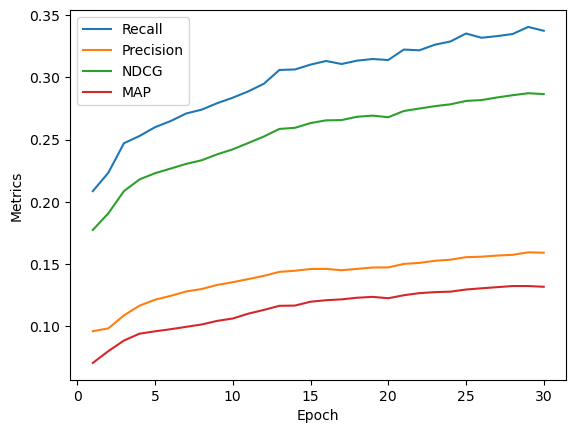

In [ ]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

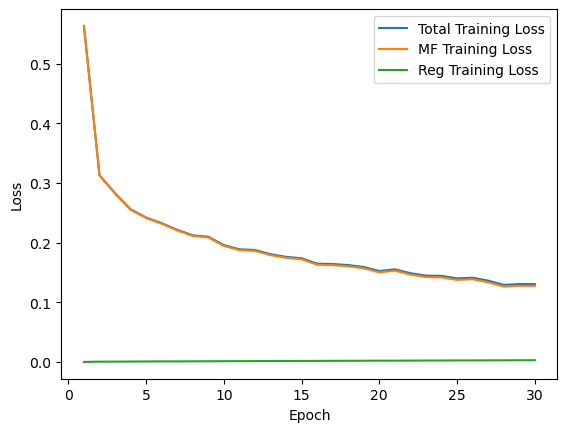

In [ ]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  4.35  seconds
Averge time taken to eval an epoch ->  0.26  seconds


In [ ]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.3374
Last Epoch's Test Data Precision ->  0.159
Last Epoch's Test Data NDCG ->  0.2865
Last Epoch's Test Data MAP ->  0.1316
Last Epoch's Train Data Loss ->  0.1305
